# Discovery of Musical Patterns and Structures using Mathematical Morphology

<div style="display: flex; justify-content: space-between; align-items: center; padding: 20px 0;">
    <img src="https://imgs.search.brave.com/xY8R_8l4B2YioiaJAn-_C_rdzuVm0GxAbIF6mx9uglE/rs:fit:500:0:0:0/g:ce/aHR0cHM6Ly9pcm1p/YXBwLnVuaXN0cmEu/ZnIvd2Vic2l0ZXMv/SVRJLUlSTUlBcHAv/TG9nb3MvbG9nb19p/cm1hLnBuZw" style="height: 80px;">
    <img src="https://imgs.search.brave.com/abpAYumpwZ7KG6ngCp5KWlZNqAdbOjBuAe13-lX2awg/rs:fit:500:0:0:0/g:ce/aHR0cHM6Ly93d3cu/dW5pc3RyYS5mci9m/aWxlYWRtaW4vdGVt/cGxhdGVzL3VuaXN0/cmEtdjMvdGVtcGxh/dGVzL2ltYWdlcy93/ZWItZXQtYXNzb2Np/ZS1OQi5wbmc" style="height: 80px;">
</div>

**Author:** Mathys DANIEL

**Based on the work of:** Paul LASCABETTES (Thesis: [https://hal.science/tel-04480227](https://hal.science/tel-04480227))

## Project Description

**Objective:** To develop a fully automatic program that captures musical patterns and provides some informations about the time signatures for individual tracks and instruments using exclusively topological tools, achieving greater computational efficiency than state-of-the-art methods.

**Methodology:** We will leverage mathematical morphology to analyze the inherent structure of musical data, identifying recurring motifs and rhythmic variations.

**Focus:** This project specifically focuses on the music of King Gizzard & the Lizard Wizard, known for their rhythmic complexity. Their diverse and intricate compositions provide a rich dataset for testing and validating the robustness of our topological analysis techniques.

**Expected Outcome:** To demonstrate the program’s ability to handle challenging rhythmic structures and extract meaningful musical information with minimal computational overhead.


# Import

In [ ]:
import os
import re
import time
import math
from math import isclose, modf
from fractions import Fraction
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple, Dict, Callable

# Scientific stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

# MIDI processing
!pip install pretty_midi
import pretty_midi

In [2]:
# Linking to my Drive
from google.colab import drive
drive.mount('/content/drive')
folder_path = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Polygondwanaland_MIDI" # our path

Mounted at /content/drive


# Dataset Creation

## Creating the csv file

This section aims to create a csv file to compute the dataset once only.

In [ ]:
def process_midi_separating_instruments(midi_file_path):
    """Processes a MIDI file and returns note information (onset, pitch, duration)
    separated by instruments with onsets normalized to beats.

    Args:
      midi_file_path: Path to the MIDI file.

    Returns:
      A list of dictionaries with keys: 'midi_file', 'instrument', 'pitch', 'onset', 'duration'.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    # Get the average BPM
    tempo_changes, tempos = midi_data.get_tempo_changes()
    bpm = (tempos[0]) if len(tempos) > 0 else Fraction(120)

    # Conversion factor: seconds -> beats
    seconds_to_beats = bpm / 60

    # Define the tatum as 1 / (8 * 3)
    tatum = Fraction(1, (8 * 3))

    data = []

    for instrument in midi_data.instruments:
        instrument_name = instrument.name if instrument.name else 'Unknown'

        for note in instrument.notes:
            onset_in_beats = note.start * seconds_to_beats
            duration_in_beats = (note.end - note.start) * seconds_to_beats

            try:
                # Round onset to the nearest multiple of tatum
                rounded_onset = round(onset_in_beats / tatum) * tatum
                rounded_duration = round(duration_in_beats / tatum) * tatum

                # Convert to float if denominator is not a multiple of 3
                onset_value = float(rounded_onset) if rounded_onset.denominator % 3 != 0 else rounded_onset
                duration_value = float(rounded_duration) if rounded_duration.denominator % 3 != 0 else rounded_duration

                data.append({
                    'midi_file': os.path.basename(midi_file_path),
                    'instrument': instrument_name,
                    'onset': onset_value,
                    'pitch': note.pitch,
                    'duration': duration_value
                })
            except Exception as e:
                print(f"Error with onset calculation: {onset_in_beats}, Track: {instrument_name}, Note: {note.pitch}")
                raise e

    return data

def preprocess_dataset_to_csv(folder_path, output_csv_path):
    """
    Preprocesses the dataset by extracting pitch, onset, and duration from MIDI files,
    and saves the information to a CSV file.

    Args:
      folder_path: Path to the folder containing MIDI files.
      output_csv_path: Path to the output CSV file.
    """
    all_data = []

    # Create output folder if it doesn't exist
    output_folder = os.path.join(os.path.dirname(output_csv_path), 'tracks_csv')
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        if filename.endswith(".mid") or filename.endswith(".midi"):
            midi_file_path = os.path.join(folder_path, filename)
            try:
                midi_data = process_midi_separating_instruments(midi_file_path)
                all_data.extend(midi_data)

                # Save a separate CSV for each track
                track_csv_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.csv")
                pd.DataFrame(midi_data).to_csv(track_csv_path, index=False)
                print(f"Track CSV saved to {track_csv_path}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                continue

    # Save full dataset to CSV
    df = pd.DataFrame(all_data)
    df.to_csv(output_csv_path, index=False)
    print(f"Dataset saved to {output_csv_path}")

# # Usage
# output_csv_path = "/content/drive/MyDrive/Pattern_Detection/dataset.csv"
# preprocess_dataset_to_csv(folder_path, output_csv_path)


## Check Instruments

In [ ]:
# Function to extract MIDI information
def extract_midi_info(midi_path):
    midi = pretty_midi.PrettyMIDI(midi_path)

    info = {'File Name': os.path.basename(midi_path)}

    for instrument in midi.instruments:
        track_name = instrument.name if instrument.name else 'Unknown'
        instrument_name = pretty_midi.program_to_instrument_name(instrument.program) if not instrument.is_drum else 'Drum Kit'

        info[track_name] = True

    return info

# Collect information from all MIDI files
midi_data = []
for file in os.listdir(folder_path):
    if file.endswith(".mid") or file.endswith(".midi"):
        midi_path = os.path.join(folder_path, file)
        midi_data.append(extract_midi_info(midi_path))

# Create a DataFrame and transpose it
df = pd.DataFrame(midi_data).fillna(False).set_index('File Name').T

# Function to apply color styling
def color_cells(val):
    return 'background-color: green' if val else 'background-color: red'

# Display styled DataFrame
styled_df = df.style.applymap(color_cells)
display(styled_df)

# Optionally save to CSV
df.to_csv('/content/drive/MyDrive/Pattern_Detection/midi_summary.csv')

/tmp/ipython-input-1105080162.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(midi_data).fillna(False).set_index('File Name').T
/tmp/ipython-input-1105080162.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_cells)


## Save the separated instruments MIDI

In [ ]:
def save_midi_files(input_folder):
    """
    Save separated MIDI files for each instrument in the Google Drive folder 'MIDI_separated'.

    Args:
        input_folder: Path to the folder containing MIDI files.
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Create the target directory if it doesn't exist
    output_dir = "/content/drive/MyDrive/IRMA/Polygondwanaland_MIDI_Separated"
    os.makedirs(output_dir, exist_ok=True)

    for midi_file in os.listdir(input_folder):
        if midi_file.endswith(".mid"):
            midi_path = os.path.join(input_folder, midi_file)

            # Load the MIDI file
            midi = pretty_midi.PrettyMIDI(midi_path)

            # Extract number and track name using regex
            match = re.search(r"\((\d+)\)\s*(.*)\.mid", midi_file)
            if match:
                track_number = match.group(1)
                track_name = match.group(2)
            else:
                track_number = "unknown"
                track_name = os.path.splitext(midi_file)[0]

            for i, instrument in enumerate(midi.instruments):
                # Create a new MIDI object for each instrument
                new_midi = pretty_midi.PrettyMIDI()

                # Keep the original instrument program and name
                new_instrument = pretty_midi.Instrument(program=instrument.program, name=instrument.name)
                new_instrument.notes = instrument.notes

                # Add instrument to the new MIDI object
                new_midi.instruments.append(new_instrument)

                # Create a filename based on the number, track name, and instrument
                # -- Change here --
                # Replace '/' with '_' to create a valid filename
                subset_name = f"({track_number}) {track_name}_{instrument.name.replace('/', '_')}.mid"
                # -- End of Change --
                output_path = os.path.join(output_dir, subset_name)

                # Write the new MIDI file
                new_midi.write(output_path)

                print(f"Saved: {output_path}")

# Example usage
save_midi_files("/content/drive/MyDrive/Pattern_Detection/Polygondwanaland_MIDI")

## Convert a .mid file in .wav

In [ ]:
# --- 0.  File you want to convert ------------------------------------------
midi_file_path = '/content/drive/MyDrive/IRMA/Polygondwanaland_MIDI_Separated/(4) Deserted Dunes Welcome Weary Feet_Guitar I.mid'
wav_out        = '/content/drive/MyDrive/IRMA/guitar_render.wav'


# ▬▬ 1.  Install everything we need ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
!apt-get -qq update
!apt-get -qq install -y fluidsynth          # synthesiser + FluidR3_GM.sf2
!pip -q install midi2audio                 # tiny wrapper around Fluidsynth

# ▬▬ 2.  Render the MIDI to WAV ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
from midi2audio import FluidSynth
sf2 = '/usr/share/sounds/sf2/FluidR3_GM.sf2'      # sound-font that apt just installed

FluidSynth(sound_font=sf2, sample_rate=44100).midi_to_audio(midi_file, wav_out)
print('WAV written to', wav_out)

# ▬▬ 3.  Listen inside the notebook ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
from IPython.display import Audio
Audio(wav_out)

# Dataset Loading

If the dataset is already created, this section aims to preprocess the dataset and load it into your notebook.

In [ ]:
def load_preprocessed_dataset_from_csv(csv_folder_path):
    """
    Loads preprocessed CSV files and reconstructs the dataset.

    Args:
      csv_folder_path: Path to the folder containing track CSV files.

    Returns:
      A dictionary where keys are MIDI file names and values are dictionaries of
      track and instrument data (pitch and onset of each notes).
    """
    dataset = {}

    for filename in os.listdir(csv_folder_path):
        if filename.endswith(".csv"):
            csv_path = os.path.join(csv_folder_path, filename)
            try:
                df = pd.read_csv(csv_path)
                midi_file = df['midi_file'].iloc[0]

                if midi_file not in dataset:
                    dataset[midi_file] = {}

                for instrument, group in df.groupby('instrument'):
                    if instrument not in dataset[midi_file]:
                        dataset[midi_file][instrument] = []

                    for row in group.itertuples(index=False):
                        onset = Fraction(row.onset) if '/' in str(row.onset) else float(row.onset)
                        dataset[midi_file][instrument].append((onset, row.pitch))
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue

    return dataset

# Usage
csv_folder_path = '/content/drive/MyDrive/Pattern_Detection/csv_dataset_King_Gizzard_and_the_Lizard_Wizard_Polygondwanaland'
preprocessed_dataset = load_preprocessed_dataset_from_csv(csv_folder_path)
print(preprocessed_dataset)

## Dataset Analysis

This section provides statistical analysis tools of the MIDI dataset.

In [4]:
def count_onset_apparition(preprocessed_dataset):
    """Extracts fractional values from onset points and returns a dictionary with their counts."""
    decimal_counts = {}

    for track_data in preprocessed_dataset.values():
        for instrument_data in track_data.values():
            for onset, _ in instrument_data:
                decimal_part = (onset % 1)  # Ensure precision for small decimals
                if decimal_part not in decimal_counts:
                    decimal_counts[decimal_part] = 0
                decimal_counts[decimal_part] += 1

    return decimal_counts

onset_counts = count_onset_apparition(preprocessed_dataset)
print(onset_counts)

{0.0: 54516, 0.5: 40586, 0.75: 4798, 0.25: 4296, Fraction(7, 12): 458, Fraction(1, 12): 1100, Fraction(13, 24): 820, Fraction(1, 24): 824, Fraction(5, 6): 1148, Fraction(11, 12): 840, Fraction(5, 12): 668, Fraction(23, 24): 866, Fraction(19, 24): 882, 0.625: 804, Fraction(11, 24): 676, Fraction(7, 24): 466, Fraction(17, 24): 556, Fraction(2, 3): 1384, Fraction(1, 6): 1164, 0.125: 882, 0.375: 840, Fraction(1, 3): 1508, Fraction(5, 24): 772, 0.875: 514}


In [5]:
#rank the decimals by number of occurence
sorted_onset_counts = {k: v for k, v in sorted(onset_counts.items(), key=lambda item: item[1], reverse=True)}
print(sorted_onset_counts)

{0.0: 54516, 0.5: 40586, 0.75: 4798, 0.25: 4296, Fraction(1, 3): 1508, Fraction(2, 3): 1384, Fraction(1, 6): 1164, Fraction(5, 6): 1148, Fraction(1, 12): 1100, Fraction(19, 24): 882, 0.125: 882, Fraction(23, 24): 866, Fraction(11, 12): 840, 0.375: 840, Fraction(1, 24): 824, Fraction(13, 24): 820, 0.625: 804, Fraction(5, 24): 772, Fraction(11, 24): 676, Fraction(5, 12): 668, Fraction(17, 24): 556, 0.875: 514, Fraction(7, 24): 466, Fraction(7, 12): 458}


In [6]:
total_onsets = sum(count for count in sorted_onset_counts.values())
for fraction, count in sorted(sorted_onset_counts.items(), key=lambda item: item[1], reverse=True):
    percentage = (count / total_onsets) * 100
    print(f"Decimal: {fraction}, Count: {count}, Percentage: {percentage:.5f}%")

Decimal: 0.0, Count: 54516, Percentage: 44.91794%
Decimal: 0.5, Count: 40586, Percentage: 33.44045%
Decimal: 0.75, Count: 4798, Percentage: 3.95327%
Decimal: 0.25, Count: 4296, Percentage: 3.53965%
Decimal: 1/3, Count: 1508, Percentage: 1.24250%
Decimal: 2/3, Count: 1384, Percentage: 1.14033%
Decimal: 1/6, Count: 1164, Percentage: 0.95907%
Decimal: 5/6, Count: 1148, Percentage: 0.94588%
Decimal: 1/12, Count: 1100, Percentage: 0.90633%
Decimal: 19/24, Count: 882, Percentage: 0.72672%
Decimal: 0.125, Count: 882, Percentage: 0.72672%
Decimal: 23/24, Count: 866, Percentage: 0.71353%
Decimal: 11/12, Count: 840, Percentage: 0.69211%
Decimal: 0.375, Count: 840, Percentage: 0.69211%
Decimal: 1/24, Count: 824, Percentage: 0.67893%
Decimal: 13/24, Count: 820, Percentage: 0.67563%
Decimal: 0.625, Count: 804, Percentage: 0.66245%
Decimal: 5/24, Count: 772, Percentage: 0.63608%
Decimal: 11/24, Count: 676, Percentage: 0.55698%
Decimal: 5/12, Count: 668, Percentage: 0.55039%
Decimal: 17/24, Count: 55

## Scatter Plot

This section is meant to visualize the data in our set of points

Saving PDF for: KGLW - Deserted Dunes Welcome Weary Feet Guitar I


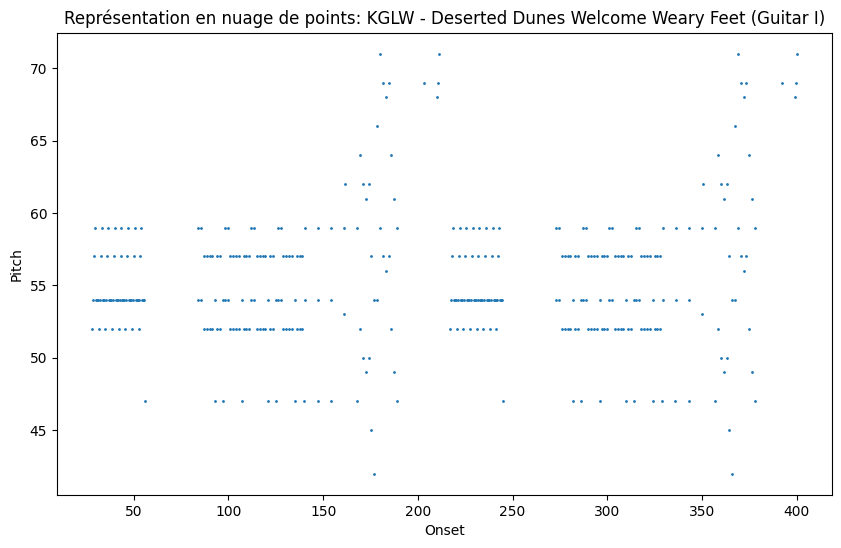

In [11]:
target_filename = 'King Gizzard and the Lizard Wizard - Polygondwanaland 8-Bit W- Tabs - (4) Deserted Dunes Welcome Weary Feet.mid'
target_instrument = 'Guitar I'

SHOW_ONLY_TARGET = True  # ← Change to False to display all figures


# To clean the files' display name
def clean_filename(filename):
    if filename == target_filename:
        return "KGLW - Deserted Dunes Welcome Weary Feet"
    else:
        return filename.replace(".mid", "")


for filename, instruments_data in preprocessed_dataset.items():
    for instrument_name, points in instruments_data.items():

        if SHOW_ONLY_TARGET:
            if filename != target_filename or instrument_name != target_instrument:
                continue  # Ignore other instruments/files

        x_values = [point[0] for point in points]
        y_values = [point[1] for point in points]

        plt.figure(figsize=(10, 6))
        plt.scatter(x_values, y_values, s=1)
        plt.xlabel("Onset")
        plt.ylabel("Pitch")

        display_name = clean_filename(filename)
        plt.title(f"Représentation en nuage de points: {display_name} ({instrument_name})")

        # PDF saving of the target figure
        if filename == target_filename and instrument_name == target_instrument:
            print("Saving PDF for:", display_name, instrument_name)
            plt.savefig("guitar_I_deserted_dunes.pdf")

        plt.show()


## Subsets values

We delete manually (because they are not interesting in our study):


*   Innercell - Keys II
*   Polygondwanaland - Keys I
*   Polygondwanaland - Intro Keys
*   Deserted Dunes Welcome Weary Feet - Flute/Keys II
*   Deserted Dunes Welcome Weary Feet - Bass Key
*   Deserted Dunes Welcome Weary Feet - Keys IV
*   Deserted Dunes Welcome Weary Feet - Flute
*   Searching - Keys I
*   Searching - Keys II
*   The Fourth Colour - Keys I

In [ ]:
def get_subsets_with_points(preprocessed_dataset):
    """
    Generates subsets in the format '<track_filename>_<instrument_name>' with corresponding points,
    excluding manually specified tracks.

    Args:
        preprocessed_dataset: The preprocessed dataset dictionary.

    Returns:
        A dictionary where keys are subsets ('<track_filename>_<instrument_name>') and values are lists of (onset, pitch) points.
    """
    excluded_tracks = {
        "(10) The Fourth Colour.mid_Low bass Key",
        "(9) Searching.mid_Keys I",
        "(9) Searching.mid_Keys II",
        "(2) Polygondwanaland.mid_Intro Keys",
        "(2) Polygondwanaland.mid_Keys I",
        "(4) Deserted Dunes Welcome Weary Feet.mid_Flute/Keys II",
        "(4) Deserted Dunes Welcome Weary Feet.mid_Low bass Key",
        "(4) Deserted Dunes Welcome Weary Feet.mid_Keys IV",
        "(4) Deserted Dunes Welcome Weary Feet.mid_Flute",
        "(5) Innercell.mid_Keys II"
    }

    subsets_data = {}
    for track_name, instruments_data in preprocessed_dataset.items():
        # Extract only the filename part
        track_filename = track_name.split(" - ")[-1]

        for instrument_name, points in instruments_data.items():
            subset_name = f"{track_filename}_{instrument_name}"  # Using cleaned track name

            if subset_name not in excluded_tracks:  # Exclude specified tracks
                subsets_data[subset_name] = points

    return subsets_data

# Example usage (assuming preprocessed_dataset is already defined from the previous code)
subsets_data = get_subsets_with_points(preprocessed_dataset)

for subset_name, points in subsets_data.items():
    print(f"Subset: {subset_name}")
    print(f"Points: {points}")

# Topological Tools

This section defines some topological tools that are useful for our algorithms.

In [13]:
def erosion(X, S):
    """
    Compute the erosion of X by structuring element S, with S centered at the origin.
    """
    # Get the first point of S to determine the translation vector
    s0, s1 = S[0]

    # Translate S to be centered at the origin
    S_centered = [(so - s0, sp - s1) for (so, sp) in S]

    eroded = list()

    X = set(X)

    for (o, p) in X:
        # Check if translated structuring element is included in X
        if all((o + so, p + sp) in X for (so, sp) in S_centered):
            eroded.append((o, p))

    return eroded

def dilation(X, S):
    """
    Compute the dilation of set X by structuring element S.
    """
    dilated = list()

    X = set(X)

    # Get the first point of S to determine the translation vector
    s0, s1 = S[0]

    # Translate S to be centered at the origin
    S_centered = [(so - s0, sp - s1) for (so, sp) in S]

    for (o, p) in X:
        for (so, sp) in S_centered:
            dilated.append((o + so, p + sp))

    return dilated

# opening (erosion then dilation)
def opening(X, S):
    """
    Compute the opening of set X by structuring element S.
    """
    return dilation(erosion(X, S), S)

# morphological closing of a set X (dilation then erosion)
def closing(X, S):
    """
    Compute the closing of set X by structuring element S.
    """
    return erosion(dilation(X, S), S)

# Metric Recognition

This section defines the algorithm that detects the patterns in a given piece of music.

In [14]:
def windowing(P, L):
    """
    Splits the pattern P into multiple sub-patterns of exact length L.
    - Ensures each window starts at a valid onset.
    - Prevents empty windows.
    """
    if not P:
      return []

    P = sorted(P, key=lambda x: x[0])  # Sort by onset
    windowed_patterns = []
    i = 0  # Index to track starting point

    while i < len(P):
        t1 = P[i][0]  # Base onset for this window
        window = [p for p in P if t1 <= p[0] < t1 + L]

        if not window:  # Skip empty windows
            i += 1
            continue

        windowed_patterns.append(window)

        # Move to next onset after the current window
        while i < len(P) and P[i][0] < t1 + L:
            i += 1

    return windowed_patterns

def filtering(P_list, P_full, L, Nmin=4):
    """
    Filter and merge the subpatterns that repeats periodically inside the previously found patterns
    """
    if not P_list:
        return []

    P_to_test = [tuple(map(tuple, Pj)) for Pj in P_list]
    P_output = []
    P_all = P_to_test.copy()
    P_to_test = sorted(P_to_test, key=lambda pat: min(p[0] for p in pat))

    while P_to_test:
        Pj = P_to_test.pop(0)
        Pj_list = list(Pj)
        onset_j = min(p[0] for p in Pj_list)
        opening_Pj = opening(P_full, Pj_list)

        Nj = Nmin
        absorbed = []

        # This list tracks all valid successive window onsets relative to Pj
        reference_onsets = [onset_j]

        for Pk in P_all:
            if Pk == Pj or Pk not in P_to_test:
                continue

            Pk_list = list(Pk)
            onset_k = min(p[0] for p in Pk_list)

            if any(p in opening_Pj for p in Pk_list):
                # Check if onset_k is in a window immediately after one of the reference windows
                window_diff_ok = any(round((onset_k - ref_onset) / L) == 1 for ref_onset in reference_onsets)

                if window_diff_ok:
                    Nj += 1
                    if all(p in opening_Pj for p in Pk_list):
                        absorbed.append(Pk)
                        reference_onsets.append(onset_k)  # Extend the chain!

        for Pk in absorbed:
            if Pk in P_to_test:
                P_to_test.remove(Pk)

        P_output.append((Pj_list, Nj))

    return P_output


def pattern_detection(X, Lmax = 20, Nmin=4):
    """
    Extracts translation-invariant patterns from input list X for various L values.
    - Applies erosion to detect patterns.
    - Uses windowing to extract patterns of exact length L.
    - Uses filtering to refine extracted patterns.
    """
    found_patterns = []
    L_values = np.arange(2, Lmax, 0.25)

    for L in L_values:
        # Step 1: Define structuring element O_L as a list
        O_L = [(n*L, 0) for n in range(Nmin)]

        # Step 2: Apply erosion to find patterns
        P = erosion(X, O_L)

        # Step 3: Windowing to get patterns of exact length L
        P1_to_Pn = windowing(P, L)

        # Step 4: Filtering to refine patterns
        filtered_patterns = filtering(P1_to_Pn, P, L, Nmin)

        # Step 5: Store results
        for P_prime, N in filtered_patterns:
            found_patterns.append((P_prime, N, float(L)))

    return found_patterns

# Metric visualization

### Ground Truth

This section extracts time signature from dataset info

In [15]:
def _parse_ts_string(ts_string):
    """
    '7/8 @ 0.000 beats; 6/4 @ 406.000 beats'
        -> [{'beat':0.0,'num':7,'den':8}, …]
    """
    if not ts_string:
        return []
    events = []
    for chunk in ts_string.split(';'):
        m = re.match(r'\s*(\d+)\s*/\s*(\d+)\s*@\s*([0-9.]+)', chunk)
        if m:
            num, den, beat = int(m[1]), int(m[2]), float(m[3])
            events.append({'beat': beat, 'num': num, 'den': den})
    return sorted(events, key=lambda d: d['beat'])
# ------------------------------------------------- ①

def _format_time_signature_in_beats(ts_obj, pm):
    """
    Returns the time signature in beats.
    """
    # Convert absolute seconds → ticks → beats
    beat_idx = pm.time_to_tick(ts_obj.time) / pm.resolution
    return f"{ts_obj.numerator}/{ts_obj.denominator} @ {beat_idx:.3f} beats"


def check_time_signature_presence(folder_path, show_table = False):
    """
    Scan every MIDI file in folder_path, report whether it contains
    Time-Signature events, how many, and list them.
    """
    rows = []

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith((".mid", ".midi")):
            continue

        path = os.path.join(folder_path, fname)
        try:
            pm = pretty_midi.PrettyMIDI(path)
            ts_changes = pm.time_signature_changes                   # list[TimeSignature]
            n_ts       = len(ts_changes)

            # ---------- tempo information ---------------------------
            tempo_changes, tempi = pm.get_tempo_changes()
            bpm = float(tempi[0]) if len(tempi) else 120.0

            ts_strs = [_format_time_signature_in_beats(ts, pm) for ts in ts_changes]    # turn each TimeSignature into a readable string (in beats)


            rows.append({
                "midi_file"                 : fname,
                "bpm"                       : bpm,
                "has_time_signature"        : bool(n_ts),
                "num_time_signature_events" : n_ts,
                "time_signatures"           : "; ".join(ts_strs) if ts_strs else ""
            })
        except Exception as e:
            print(f"Could not parse {fname}: {e}")

    df = pd.DataFrame(rows)

    if show_table:
      if not df.empty:
            print(df.to_string(index=False))
      else:
          print("No MIDI files found.")

      # Global summary
      if df["has_time_signature"].any():
          print("\n✓  At least one file contains explicit time-signature data.")
      else:
          print("\n✗  No file in the folder contains any time-signature events.")

    return df

### Plot sections

This section defines all the tools and apply them to visualize the metric construction of a given piece of music, using the algorithm previously defined.

/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


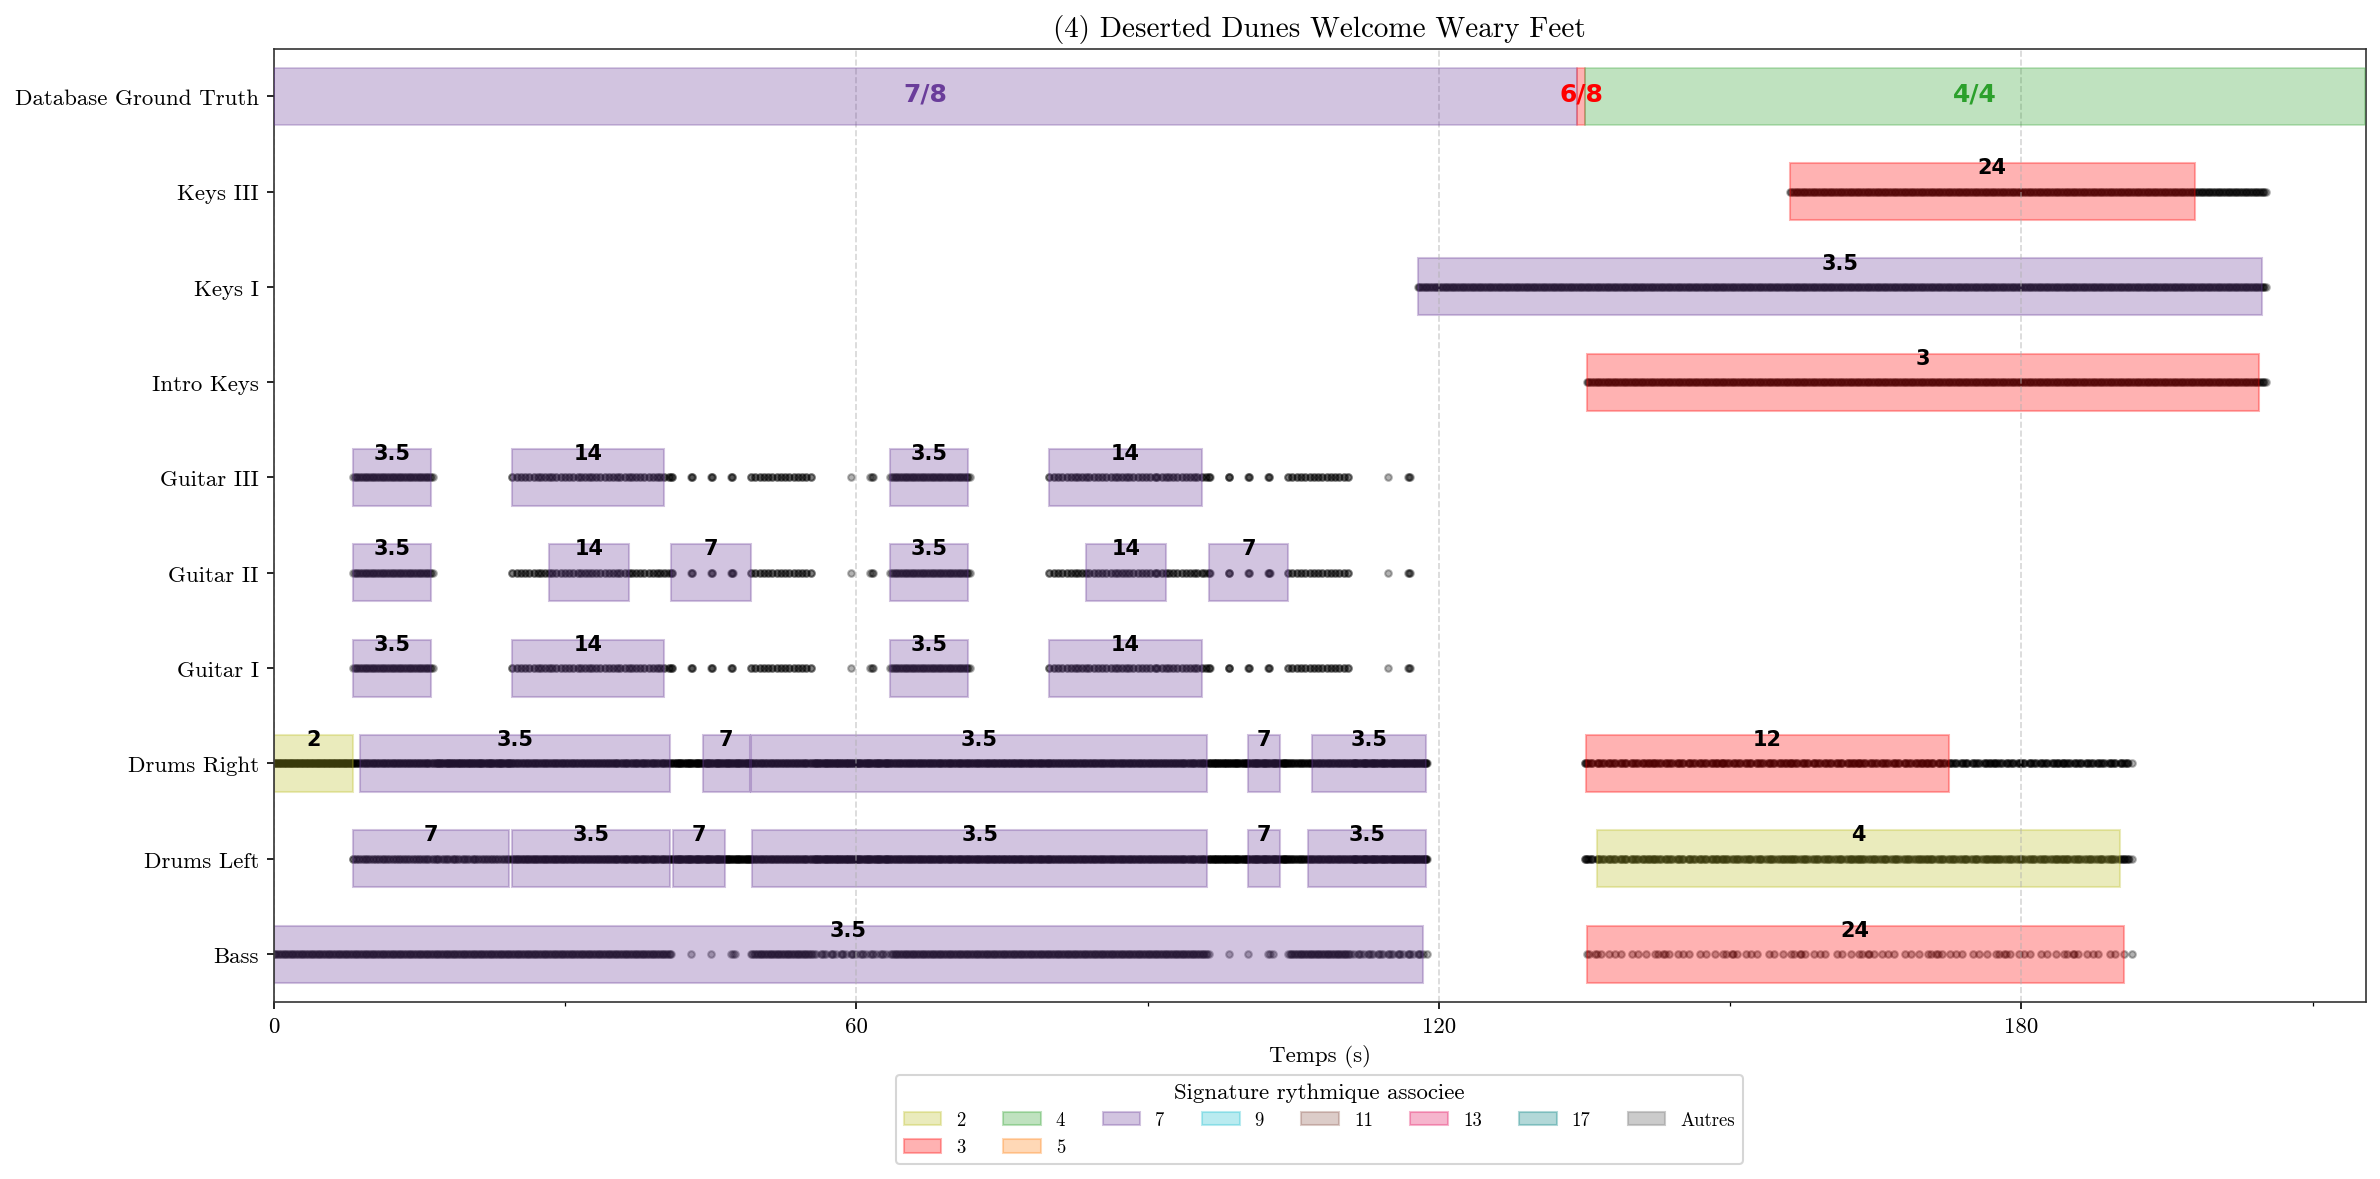

Pourcentage de points perdus : 4.37 %
Nombre de motifs: 99
Global compactness: 2.852882703777336


In [16]:
# ──────────────────────────────────────────────────────────────────────────────
#  0) Figure parameters definition
# ──────────────────────────────────────────────────────────────────────────────
mpl.rcParams.update({
    # --- fonts -----------------------------------------------------
    'font.family'       : 'serif',
    'font.serif'        : ['Computer Modern Roman', 'cmr10'],
    'mathtext.fontset'  : 'cm',
    'font.size'         : 11,          # base text size
    'axes.titlesize'    : 14,          # title → a bit larger
    'axes.titleweight'  : 'bold',

    # --- axes & spines --------------------------------------------
    'axes.edgecolor'    : '#333333',
    'axes.linewidth'    : .8,
    'axes.grid'         : False,       # we enable it manually, x–only
    'xtick.direction'   : 'out',
    'ytick.direction'   : 'out',

    # --- legend ----------------------------------------------------
    'legend.frameon'    : False,
    'legend.fontsize'   : 9,

    # --- figure / saving ------------------------------------------
    'figure.dpi'        : 150,
    'savefig.dpi'       : 300,
    'figure.autolayout' : True         # keeps labels from colliding
})

# ---------- SECTIONS COLOR MAPPING ---------------------------
PRESET_BASE_COLORS = {
     2 : "#bcbd22",   # olive (close to green, because it's musically close to 4)
     3 : "#FF0000",   # red
     4 : "#2ca02c",   # green
     5 : "#ff7f0e",   # orange
     7 : "#6a3d9a",   # purple
     9 : "#17becf",   # teal (separated from 3, because 9 is often not used as 3x3 but as a whole 9)
    11 : "#8c564b",   # brown
    13 : "#E30B5C",   # pink
    17 : "#008080",   # teal
}

# ──────────────────────────────────────────────────────────────────────────────
#  1)  Low-level numeric helpers
# ──────────────────────────────────────────────────────────────────────────────

def group_multiplicative_bases(Ls: List[float]) -> List[List[float]]:
    """
    Group L values by shared multiplicative base.

    If multiple base candidates are valid (i.e., L is divisible by several others),
    we assign it to the group with the **largest** such base.

    Returns
    -------
    base_groups : list of groups, each group being a list of Ls.
    """
    base_groups = []
    base_lookup = {}  # maps base -> group

    for L in sorted(Ls):
        best_base = None
        for base in base_lookup:
            ratio = L / base
            ratio_inv = base / L
            if (isclose(ratio, round(ratio), abs_tol=1e-8) and ratio >= 1) or \
               (isclose(ratio_inv, round(ratio_inv), abs_tol=1e-8) and ratio_inv >= 1):
                if best_base is None or base > best_base:
                    best_base = base
        if best_base is not None:
            base_lookup[best_base].append(L)
        else:
            base_lookup[L] = [L]

    return list(base_lookup.values())


def assign_vertical_layers(x_positions: List[float], min_gap: float) -> List[int]:
    """
    Greedy layer assignment so that labels (placed at each x_positions)
    do not overlap horizontally by less than min_gap.

    Returns a list `layer_index`  (same length as x_positions).
    """
    layers, label_layers = [], []          # running accumulation
    for x in x_positions:
        # Try to squeeze into an existing layer
        for i, layer in enumerate(layers):
            if all(abs(x - lx) > min_gap for lx in layer):
                layer.append(x)
                label_layers.append(i)
                break
        else:
            # No layer was available → create a new one
            layers.append([x])
            label_layers.append(len(layers) - 1)
    return label_layers


# ──────────────────────────────────────────────────────────────────────────────
#  2)  Pattern / compactness computation
# ──────────────────────────────────────────────────────────────────────────────
def compute_compactness_segments_for_instrument(
        points: List[Tuple[float, int]],
        pattern_detection: Callable,
        dilation: Callable[[list, list], list],
        global_id_start: int,
        Lmax: int
) -> Tuple[List[Dict], Dict[int, Dict], int]:
    """
    For one instrument track:
    • Call pattern_detection to get repeating patterns.
    • Dilate each pattern (so repetitions overlay each other).
    • Compute a 'compactness' score.
    • Assign a globally unique band ID starting from global_id_start.

    Returns
    -------
    bands : list of filtered bands (dicts)
    band_map : dict of {id → band}
    next_id : next available global ID
    """
    patterns = pattern_detection(points, Lmax=Lmax, Nmin=4)
    bands = []
    band_map = {}
    points_set = set(map(tuple, points))
    current_id = global_id_start

    for P_i, N_i, L_i in patterns:
        if not P_i:
            continue

        O_L_N = [(n * L_i, 0) for n in range(N_i)]
        dilated_i = dilation(P_i, O_L_N)
        if not dilated_i:
            continue

        dilated_set = set(map(tuple, dilated_i))
        x_min = min(o for o, _ in dilated_i)
        x_max = max(o for o, _ in dilated_i)
        pts_in_range = [p for p in points if x_min <= p[0] <= x_max]
        pertes = len(pts_in_range) - len(dilated_set)
        compactness = len(pts_in_range) / (len(P_i) + 2 + pertes)

        band = dict(
            id=current_id,
            L=L_i, N=N_i, compactness=compactness,
            pattern_len=len(P_i),
            min_on=x_min, max_on=x_max,
            dilated_set=dilated_set,
            original_points_set=points_set
        )
        bands.append(band)
        band_map[current_id] = band
        current_id += 1

    filtered = refine_overlapping_segments(bands)
    return filtered, band_map, current_id


def refine_overlapping_segments(
        bands: List[Dict],
        max_iterations: int = 5 # chosen arbitrarily for computational purposes
) -> List[Dict]:
    """
    Resolve overlaps between candidate bands, keeping the most compact one.

    Compactness is re-evaluated after removing shared points; the process is
    iterated until no further changes occur or max_iterations hits.
    """
    bands.sort(key=lambda b: b['min_on'])
    for _ in range(max_iterations):
        changed = False
        for i, b1 in enumerate(bands):
            for j in range(i + 1, len(bands)):
                b2 = bands[j]
                if b2['min_on'] > b1['max_on']:   # no horizontal overlap → break
                    break
                if b1['max_on'] >= b2['min_on']:  # overlap exists
                    winner, loser = (b1, b2) if b1['compactness'] > b2['compactness'] else (b2, b1)
                    overlap = loser['dilated_set'] & winner['dilated_set']
                    if overlap:
                        # Remove shared points from the loser
                        loser['dilated_set'] -= overlap
                        if not loser['dilated_set']:
                            loser['compactness'] = float('inf')
                            changed = True

                        else:
                            x_min = min(p[0] for p in loser['dilated_set'])
                            x_max = max(p[0] for p in loser['dilated_set'])

                            pts_in_range = [p for p in loser['original_points_set']
                                            if x_min <= p[0] <= x_max]
                            pertes = len(pts_in_range) - len(loser['dilated_set'])
                            if  (loser['pattern_len'] + 2 + pertes) <= 0:
                              loser['compactness'] = float('inf')
                              continue
                            # Update the loser's range and compactness
                            loser.update(min_on=x_min,
                                        max_on=x_max,
                                        compactness=len(pts_in_range) / (loser['pattern_len'] + 2 + pertes))
                            changed = True
        # Purge invalidated losers
        bands = [b for b in bands if b['compactness'] != float('inf')]
        if not changed:
            break
    return bands

def compute_compactness_segments_for_all_instruments(
        track_instruments: Dict[str, list],
        pattern_detection: Callable,
        dilation: Callable,
        Lmax: int
) -> Tuple[Dict[str, List[Dict]], Dict[int, Dict]]:
    """
    For all instrument tracks:
    • Call compute_compactness_segments_for_instrument with global IDs.
    • Collect filtered bands per instrument.
    • Return global band map and per-instrument bands.

    Returns
    -------
    all_bands : dict[str → list of band dicts]
    band_map  : dict[id → band dict]
    """
    all_bands = {}
    band_map = {}
    global_id = 0

    for inst, points in track_instruments.items():
        filtered, band_dict, global_id = compute_compactness_segments_for_instrument(points, pattern_detection, dilation, global_id, Lmax)
        all_bands[inst] = filtered
        band_map.update(band_dict)

    return all_bands, band_map

def extract_best_compactness_and_merge_intervals(
        bands: List[Dict]
) -> Tuple[List[Dict], List[Dict]]:
    """
    Extract the best-scoring (biggest compactness) segment for every elementary
    sub-interval found in bands.

    Returns
    -------
    exhaustive_intervals : List[Dict]
        Complete list of all non-overlapping intervals (one per elementary segment)
    merged_intervals : List[Dict]
        Merged contiguous segments for display purposes only
    """
    # ➊  Obtain all cut points
    cps = sorted({pt for b in bands for pt in (b['min_on'], b['max_on'])})
    exhaustive_intervals = []

    # ➋  For each elementary (a, b) choose the best band covering it
    for a, b in zip(cps, cps[1:]):
        cand = [x for x in bands if a < x['max_on'] and b > x['min_on']]
        if cand:
            best = max(cand, key=lambda x: (x['compactness'],  x['N'],  x['L']))
            exhaustive_intervals.append({'band_id':  best['id'],
                              'L': best['L'],
                              'compactness': best['compactness'],
                              'a': a, 'b': b})

    # Keep only merged segments whose length ≥ one full L
    exhaustive_intervals = [s for s in exhaustive_intervals if (s['b'] - s['a']) >= s['L']]

    # ➌  Create merged version for display (merge consecutive segments with same L)
    merged_intervals = []

    # Sort segments by start position
    sorted_segments = sorted(exhaustive_intervals, key=lambda x: x['a'])

    for seg in sorted_segments:
        # Check if we can merge with the last segment in merged_intervals
        if (merged_intervals and
            isclose(seg['L'], merged_intervals[-1]['L']) and
            # Check if there's no other segment between the current and the last merged one
            not any(other_seg['b'] > merged_intervals[-1]['b'] and other_seg['a'] < seg['a']
                   for other_seg in sorted_segments
                   if not isclose(other_seg['L'], seg['L']))):

            merged_intervals[-1]['b'] = seg['b'] # Extend the last merged segment
            merged_intervals[-1]['compactness'] = max(merged_intervals[-1]['compactness'], seg['compactness'])  # Update compactness to the maximum of the merged segments

        else:
            merged_intervals.append(seg.copy())  # Create new merged segment (copy of current segment)

    return exhaustive_intervals, merged_intervals


def compute_global_compactness(track_instruments: Dict[str, list],
                               bands_by_inst: Dict[str, List[Dict]]) -> float:
    """
    Global score

        GC = |P_tot| /
             ( Σ_patterns (len(pattern) + 2)  +  |misses| )

    • P_tot      : set of every original (time, pitch) point
    • len(pattern): stored in each band as  b['pattern_len']
    • misses     : original points that do **not** belong to any
                   dilated_set of the retained patterns
    """
    # ➊  All original points ---------------------------------------
    all_points = {
        tuple(p)
        for pts in track_instruments.values()
        for p   in pts
    }

    # ➋  Union of all dilated points and the pattern-cost term -----
    covered_points   = set()
    penalty_patterns = 0          # Σ (len(pattern) + 2)
    n_motifs = 0

    for bands in bands_by_inst.values():
        for b in bands:
            covered_points |= b['dilated_set']
            penalty_patterns += (b['pattern_len']*2 + 2)
            n_motifs += 1

    # ➌  Points not covered by any pattern -------------------------
    misses = all_points - covered_points

    # ➍  Final compactness -----------------------------------------
    print(f"Pourcentage de points perdus : {100 * len(misses) / len(all_points):.2f} %")
    print("Nombre de motifs:", n_motifs)

    return len(all_points)*2 / (penalty_patterns + len(misses)*2)

# ──────────────────────────────────────────────────────────────────────────────
#  3)  Colour assignment for metric groups
# ──────────────────────────────────────────────────────────────────────────────
def assign_color_groups_by_multiplicative_base(all_Ls: List[float]):
    """
    Create a colour map for each encountered L value.

    • All lengths are grouped by the smallest integer 'base' such that
      they differ by an integer ratio; each group gets its own colour.

    If a base is not found in the mapping dictionary (PRESET_BASE_COLORS)
    and has no multiplicative relation to one that is, it gets default grey.
    """

    # 1) Build multiplicative groups
    base_groups = group_multiplicative_bases(all_Ls)

    # 2) Label each group by its smallest integer (if any)
    base_labels = {}
    for group in base_groups:
        int_members = [x for x in group if isclose(x, round(x), abs_tol=1e-8)]
        label = int(min(int_members)) if int_members else min(group)
        for L in group:
            base_labels[L] = label

    # Special case for L=2 (because it's difficult to handle, half the integer values would be in its base)
    if any(isclose(L, 2.0, abs_tol=1e-8) for L in all_Ls):
        base_labels[2.0] = 2

    # 3) Color each base label
    color_for_base = {
        b: mcolors.to_rgba(c) for b, c in PRESET_BASE_COLORS.items()
    }

    known_bases = set(PRESET_BASE_COLORS.keys()) - {2}

    def find_related_base(base, knowns):
        for known in knowns:
            ratio = base / known
            ratio_inv = known / base
            if (isclose(ratio, round(ratio), abs_tol=1e-8) and ratio >= 1) or \
               (isclose(ratio_inv, round(ratio_inv), abs_tol=1e-8) and ratio_inv >= 1):
                return known
        return None

    for base in sorted({base_labels[L] for L in base_labels}):
        if base in color_for_base:
            continue
        related = find_related_base(base, known_bases)
        if related and related in color_for_base:           # in a mapped base
            color_for_base[base] = color_for_base[related]
        else:                                               # not in a mapped base
            color_for_base[base] = (0.6, 0.6, 0.6, 0.5)  # Default grey

    # 4) Final L → RGBA assignment
    color_for_L = {}
    for L in all_Ls:
        base = base_labels.get(L, L)
        color_for_L[L] = color_for_base[base]

    return color_for_L, base_labels, color_for_base


# ──────────────────────────────────────────────────────────────────────────────
#  4)  Plotting helpers
# ──────────────────────────────────────────────────────────────────────────────
def plot_instrument_onsets(ax, track_instruments, instrument_to_y):
    """
    Scatter-plot every individual onset for every instrument.

    Parameters
    ----------
    ax : matplotlib-axes
        The axes on which everything is drawn.

    track_instruments : dict[str, list[(float,int)]]
        Maps an instrument-name to a list of tuples (onsetBeat, midiPitch).

    instrument_to_y : dict[str, int]
        Pre-computed mapping  instrument → y-row index.
    """
    for inst, pts in track_instruments.items():
        y = instrument_to_y[inst]
        ax.scatter(
            [float(o) for o, _ in pts],   # x-coordinates (beats), but final output will be in seconds
            [y] * len(pts),               # y-coordinates (fixed row)
            s=10, color='black', alpha=.3
        )


def plot_segments_with_stacked_labels(ax, intervals_by_inst,
                                      instrument_to_y, color_for_L):
    """
    Draw the coloured metric segments (rectangles) and print L values
    stacked above them while avoiding label collisions.

    Parameters
    ----------
    intervals_by_inst : dict[str, list[dict]]
        Output of extract_and_merge_best_compactness_intervals per instrument.

    color_for_L : dict[float, rgba]
        Mapping from every observed L value to its display colour.
    """
    vertical_spacing = .18                       # distance between stacked labels

    for inst, merged in intervals_by_inst.items():
        y = instrument_to_y[inst]
        if not merged:
            continue

        # ➊  Compute label centres and layer organisation (collision-avoiding)
        xcent = [(s['a'] + s['b']) / 2 for s in merged]
        order = sorted(range(len(xcent)), key=lambda i: xcent[i])
        min_gap = .03 * (ax.get_xlim()[1] - ax.get_xlim()[0] or 1)
        layers = assign_vertical_layers([xcent[i] for i in order], min_gap)

        layer_idx = [0] * len(merged)
        for idx, layer in zip(order, layers):
            layer_idx[idx] = layer

        # ➋  Actually draw rectangles + labels
        for i, s in enumerate(merged):
            L = s['L']
            if L == int(L):
                L_str = str(int(L))
            elif L * 10 == int(L * 10):  # ex: 5.5
                L_str = f"{L:.1f}"
            else:
                L_str = f"{L:.2f}"  # fallback for unusual cases

            ax.add_patch(Rectangle((
                        s['a'], y - .3),           # (x, y) lower-left
                        s['b'] - s['a'], .6,        # width / height
                        facecolor=color_for_L.get(s['L'], (0, 0, 0, .1)),
                        edgecolor=color_for_L.get(s['L'], (0, 0, 0, .1)),
                        alpha=.3))

            ax.text((s['a'] + s['b']) / 2,
                    y + .15 + layer_idx[i] * vertical_spacing,
                    L_str,
                    ha='center', va='bottom',
                    fontweight='bold', fontsize=10, fontfamily='DejaVu Sans')


# ──────────────────────────────────────────────────────────────────────────────
#  5)  High-level driver: MAIN PLOT (plot_metric_sections_by_best_compactness)
# ──────────────────────────────────────────────────────────────────────────────

def plot_metric_sections_by_best_compactness(
        subset_data: dict,
        track_name: str,
        pattern_detection, dilation,
        ground_truth_df,
        Lmax=20):
    """
    Master routine that puts everything together

    Parameters
    ----------
    subset_data : dict
        {instrument_name → [(onsetBeat, midiPitch), …]}

    track_name : str
        Name (suffix) of the MIDI file we want to visualise.

    algo, dilation : callables
        User-supplied routines used earlier for pattern detection / dilation.

    ground_truth_df : pandas.DataFrame
        Data-frame holding the reference time-signature annotations.

    Lmax : int, optional (default=20)
        Maximum metric length to consider when searching for patterns.
    """

    # ------------------------------------------------------------------
    # ➊  Collect all onsets belonging to that MIDI file
    # ------------------------------------------------------------------
    track_instruments = {k: v for k, v in subset_data.items()
                         if k.startswith(track_name)}
    if not track_instruments:
        print(f"No data for {track_name}")
        return

    # Row mapping (instrument → y-coordinate on the plot)
    instruments = sorted(track_instruments)
    instrument_to_y = {inst: i for i, inst in enumerate(instruments)}

    # ------------------------------------------------------------------
    # ➋  Analyse compactness for every instrument
    # ------------------------------------------------------------------
    all_bands, band_map = compute_compactness_segments_for_all_instruments(
        track_instruments, pattern_detection, dilation, Lmax)

    intervals_by_inst = {}
    merged_intervals_by_inst = {}  # Only for display

    for inst, band in all_bands.items():
        exhaustive_intervals, merged_intervals = extract_best_compactness_and_merge_intervals(band)
        if exhaustive_intervals:  # Keep all exhaustive intervals
            intervals_by_inst[inst] = exhaustive_intervals
            merged_intervals_by_inst[inst] = merged_intervals  # For display

    used_ids = {
        seg['band_id']
        for segs in intervals_by_inst.values()
        for seg  in segs}

    display_bands = {
        inst: [band_map[seg['band_id']] for seg in segs]
        for inst, segs in intervals_by_inst.items()}

    # Colour bookkeeping
    all_L = {s['L'] for v in merged_intervals_by_inst.values() for s in v}
    color_for_L, base_for_L, color_for_base = assign_color_groups_by_multiplicative_base(all_L)

    # ------------------------------------------------------------------
    # ➌  Append an extra staff for ground-truth signatures
    # ------------------------------------------------------------------
    gt_name = "Database Ground Truth"
    instruments.append(gt_name)
    instrument_to_y = {inst: i for i, inst in enumerate(instruments)}
    gt_y = instrument_to_y[gt_name]

    # ------------------------------------------------------------------
    # ➍  Prepare figure & draw machine-estimated segments
    # ------------------------------------------------------------------
    plt.figure(figsize=(16, 1 + .8 * len(instruments)))
    ax = plt.gca()

    plot_instrument_onsets(ax, track_instruments, instrument_to_y)

    plot_segments_with_stacked_labels(ax, merged_intervals_by_inst,
                                      instrument_to_y, color_for_L)

    # ------------------------------------------------------------------
    # ➎  Draw ground-truth rectangles (if any) on the bottom staff
    # ------------------------------------------------------------------
    row = ground_truth_df[ground_truth_df['midi_file']
                          .str.endswith(track_name, na=False)]

    if not row.empty:
        events = _parse_ts_string(row.iloc[0]['time_signatures'])
        if events:
            x_max = ax.get_xlim()[1]

            # Compute centre-points and layer indices for GT labels
            gt_centers = []
            for i, ev in enumerate(events):
                x0 = ev['beat']
                x1 = events[i + 1]['beat'] if i + 1 < len(events) else x_max
                gt_centers.append((x0 + x1) / 2)

            gt_layers = assign_vertical_layers(
                gt_centers, min_gap=0.03 * (x_max - 0))

            # Actual drawing loop
            L_gt_list = []
            for i, ev in enumerate(events):
                L_gt = ev['num']
                L_gt_list.append(L_gt)
                x0 = ev['beat']
                x1 = events[i + 1]['beat'] if i + 1 < len(events) else x_max
                color_for_L_gt, _, _ = assign_color_groups_by_multiplicative_base(L_gt_list)
                color = color_for_L_gt.get(L_gt, (0, 0, 0, 0.2))

                # Background rectangle
                ax.add_patch(Rectangle((x0, gt_y - .3), x1 - x0, .6,
                                       facecolor=color, edgecolor= color,
                                       alpha=.3, linewidth=.8, zorder=5))

                # Time-signature label (e.g. "7/8")
                y_offset = -0.10 + gt_layers[i] * .18
                ax.text((x0 + x1) / 2, gt_y + y_offset,
                        f"{ev['num']}/{ev['den']}",
                        ha='center', va='bottom',
                        fontsize=12, fontweight='bold', fontfamily='DejaVu Sans',
                        color=color, zorder=6)

    # ------------------------------------------------------------------
    # ➏  Cosmetics: axes, legend, layout
    # ------------------------------------------------------------------
    ax.set_yticks(list(instrument_to_y.values()))
    ax.set_yticklabels([k.split('_')[-1] for k in instruments])

    # ------ Convert the beats axis in seconds for visibility purpose -------
    track_row = ground_truth_df.loc[
        ground_truth_df['midi_file'].str.endswith(track_name, na=False)]

    bpm = float(track_row['bpm'].iloc[0]) if not track_row.empty else 120.0
    beat_to_sec = 60 / bpm
    ax.set_xlabel("Temps (s)")

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda beat, pos: f"{beat*beat_to_sec:.0f}"))

    sec_step   = 60
    beat_step  = sec_step / beat_to_sec     # beats per 60 s  (== bpm)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(beat_step))     # major ticks every 60s
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(beat_step/2))   # minor ticks every 30s
    display_name = track_name.removesuffix('.mid')
    ax.set_title(f"{display_name}")
    ax.grid(True, axis='x', ls='--', alpha=.5)
    ax.set_xlim(left=0)
    ax.set_ylim(-.5, gt_y + .5)

    # ---- Legend showing multiplicative bases -------------------------

    legend_patches = [mpatches.Patch(color=color_for_base[base],
                      label=f"{base:g}",
                       alpha=0.3)
        for base in sorted(PRESET_BASE_COLORS.keys())]

    DEFAULT_OTHER_COLOR = (0.6, 0.6, 0.6, .5)
    default_patch = mpatches.Patch(color=DEFAULT_OTHER_COLOR,label="Autres")
    legend_patches.append(default_patch)

    if legend_patches:
        ncol = min(len(legend_patches), 8)
        ax.legend(handles=legend_patches,
                  title="Signature rythmique associee",
                  ncol=ncol,
                  loc='lower center',
                  bbox_to_anchor=(.5, -0.18),
                  frameon=True)

    plt.tight_layout(rect=[0, 0, 1, 0.9])

    safe_name = track_name.replace(" ", "_").replace("(", "").replace(")", "").replace(".mid", "")
    filename = f"segmentation_{safe_name}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()
    # -------------------
    # GLOBAL COMPACTNESS
    # -------------------
    global_compactness = compute_global_compactness(track_instruments, display_bands)
    print("Global compactness:", global_compactness)

    return intervals_by_inst, band_map, display_bands, track_instruments

# ──────────────────────────────────────────────────────────────────────────────
#  6)  Usage
# ──────────────────────────────────────────────────────────────────────────────
folder_path = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Polygondwanaland_MIDI"
ground_truth_df = check_time_signature_presence(folder_path)

intervals_by_inst, band_map, display_bands, track_instruments = plot_metric_sections_by_best_compactness(
                              subsets_data,
                              "(4) Deserted Dunes Welcome Weary Feet.mid", #"(3) Castle in the Air.mid", #"(4) Deserted Dunes Welcome Weary Feet.mid", #"(9) Searching.mid", #
                              pattern_detection=pattern_detection,
                              dilation=dilation,
                              ground_truth_df=ground_truth_df,
                              Lmax = 50)

## On King Gizard's "Polygondwanaland" tracks

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


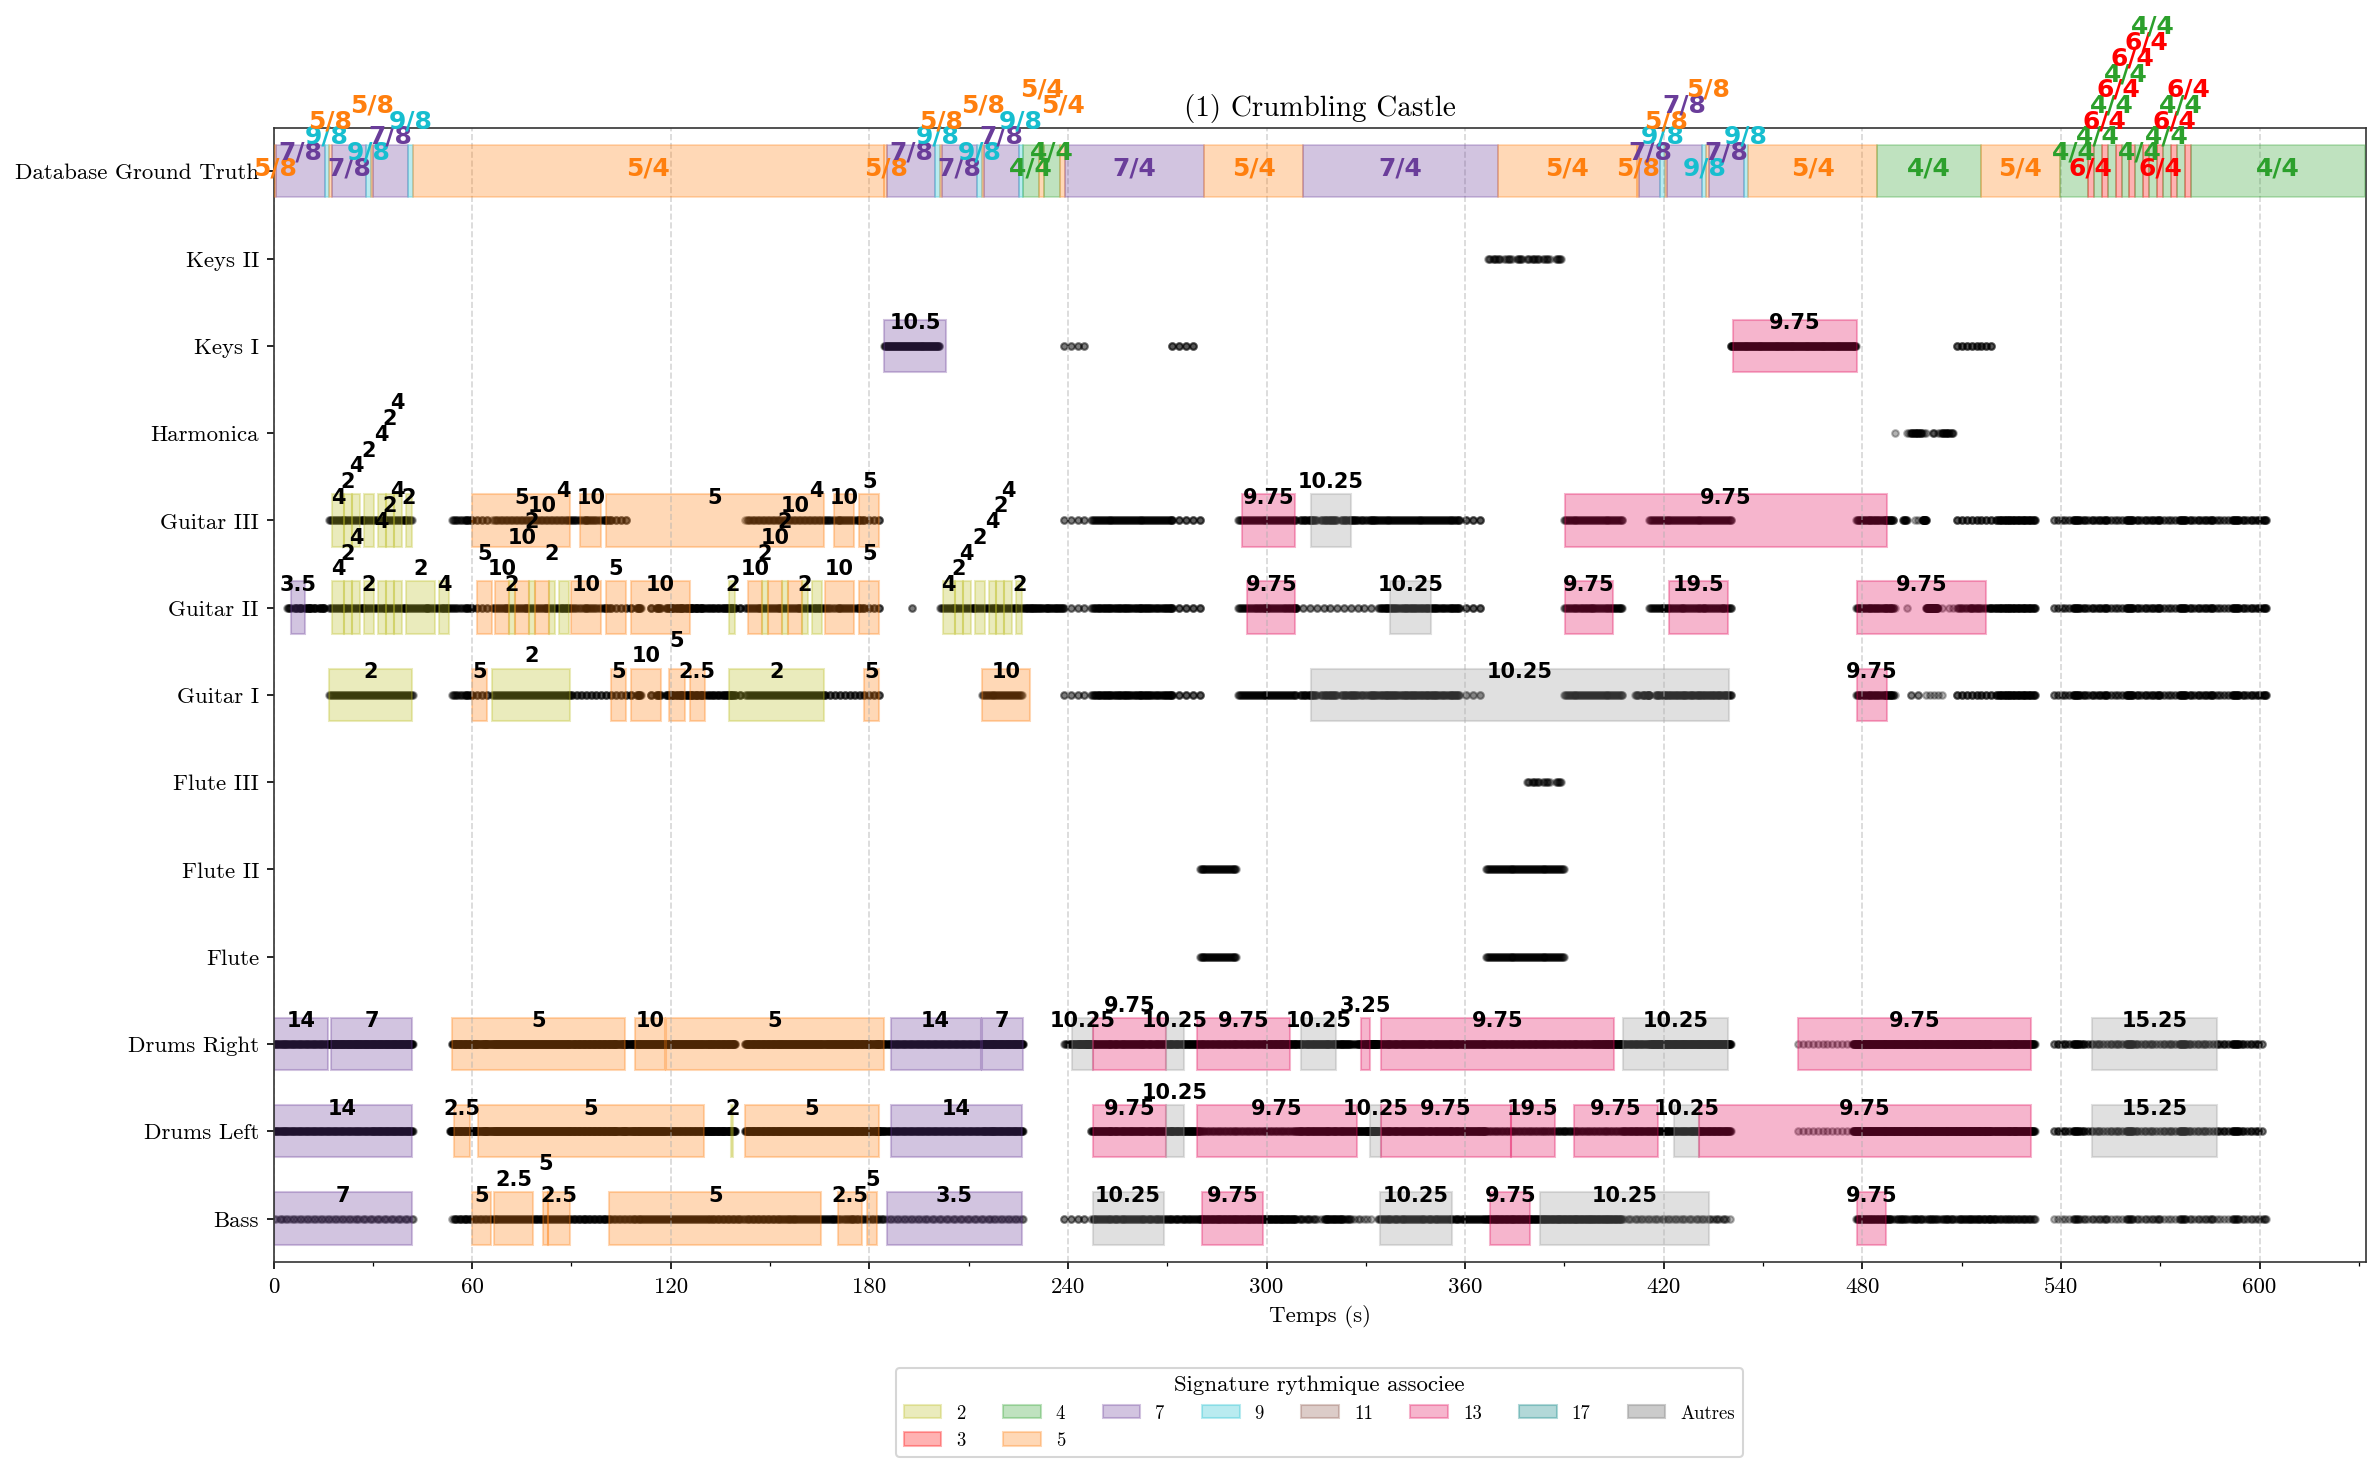

Pourcentage de points perdus : 63.46 %
Nombre de motifs: 249
Global compactness: 1.2747415066469718


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


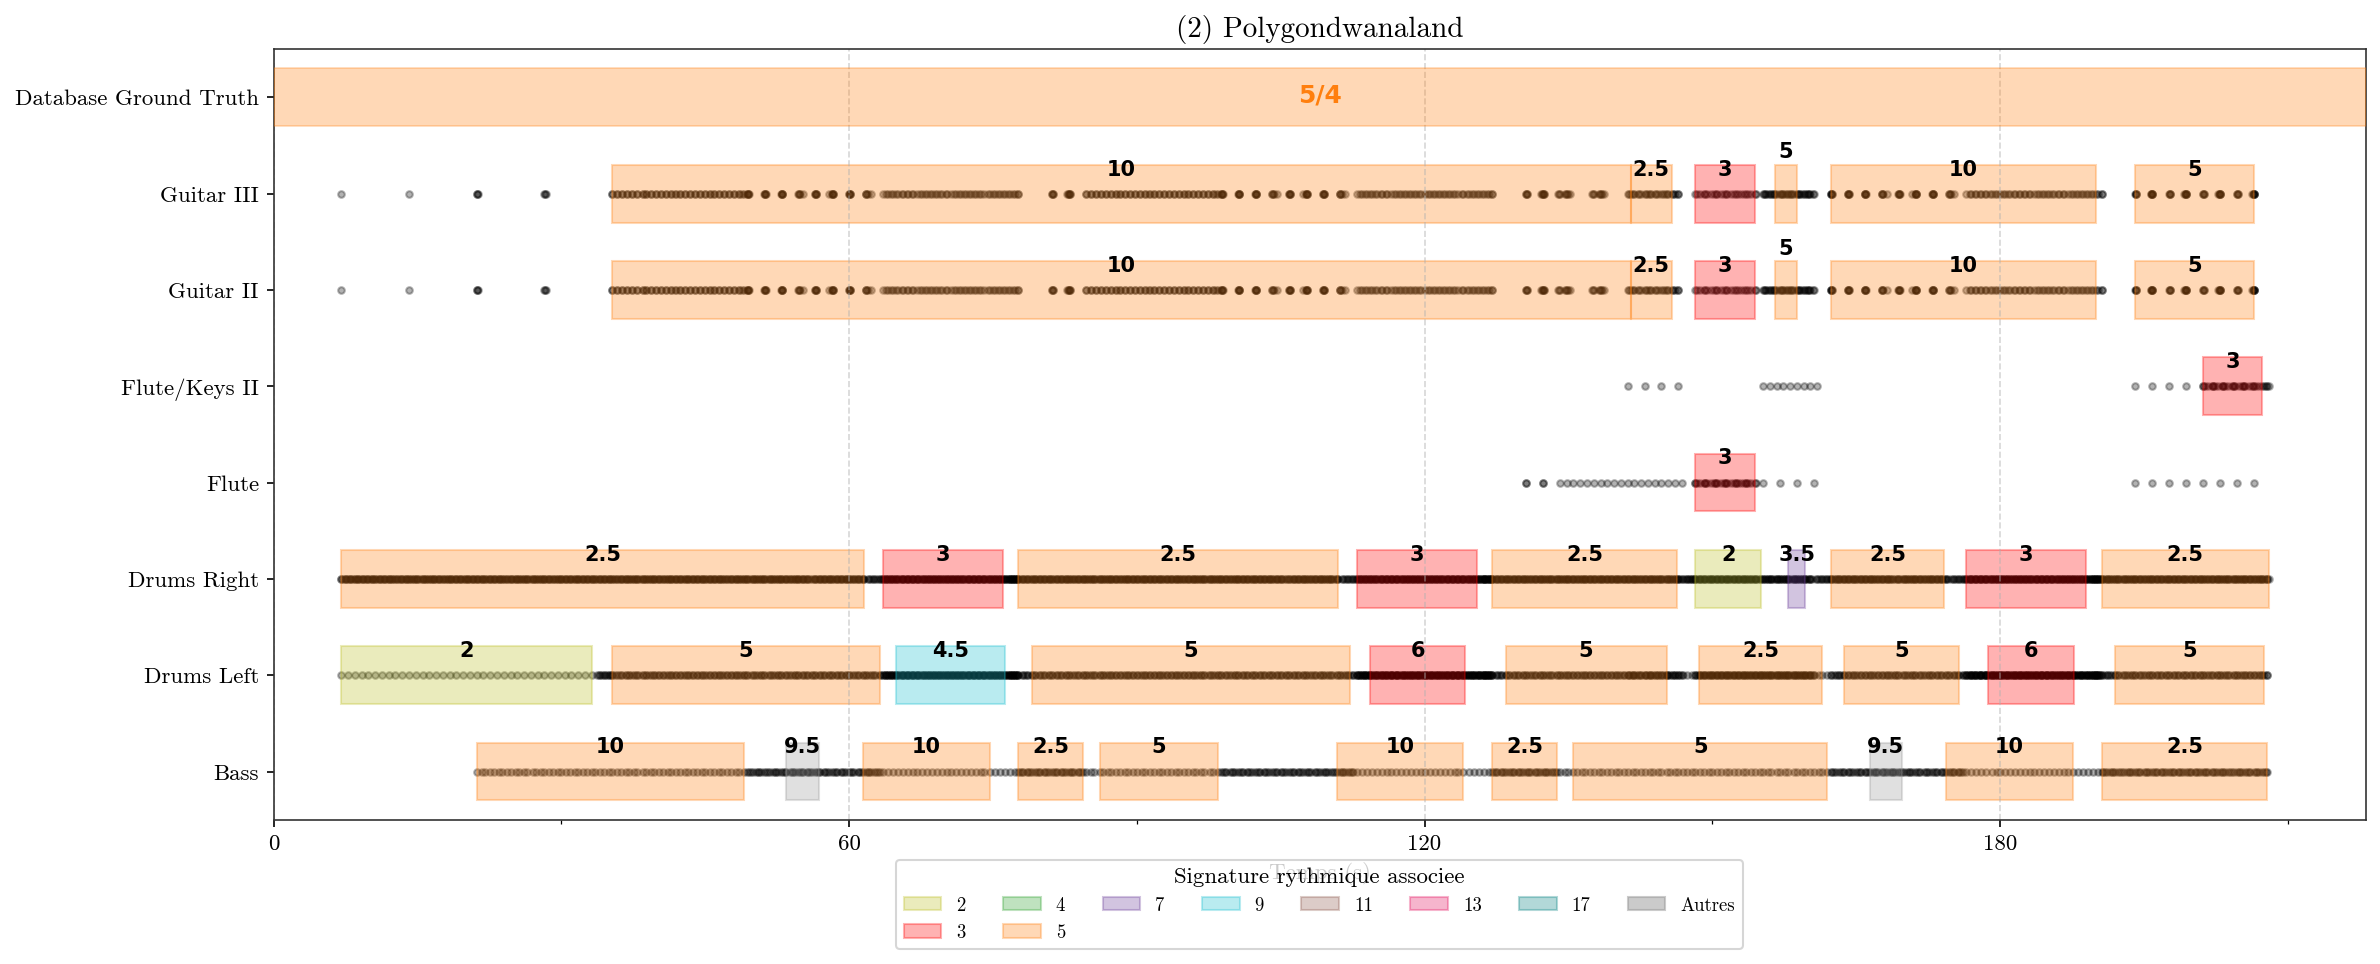

Pourcentage de points perdus : 27.41 %
Nombre de motifs: 117
Global compactness: 1.7323442136498517


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


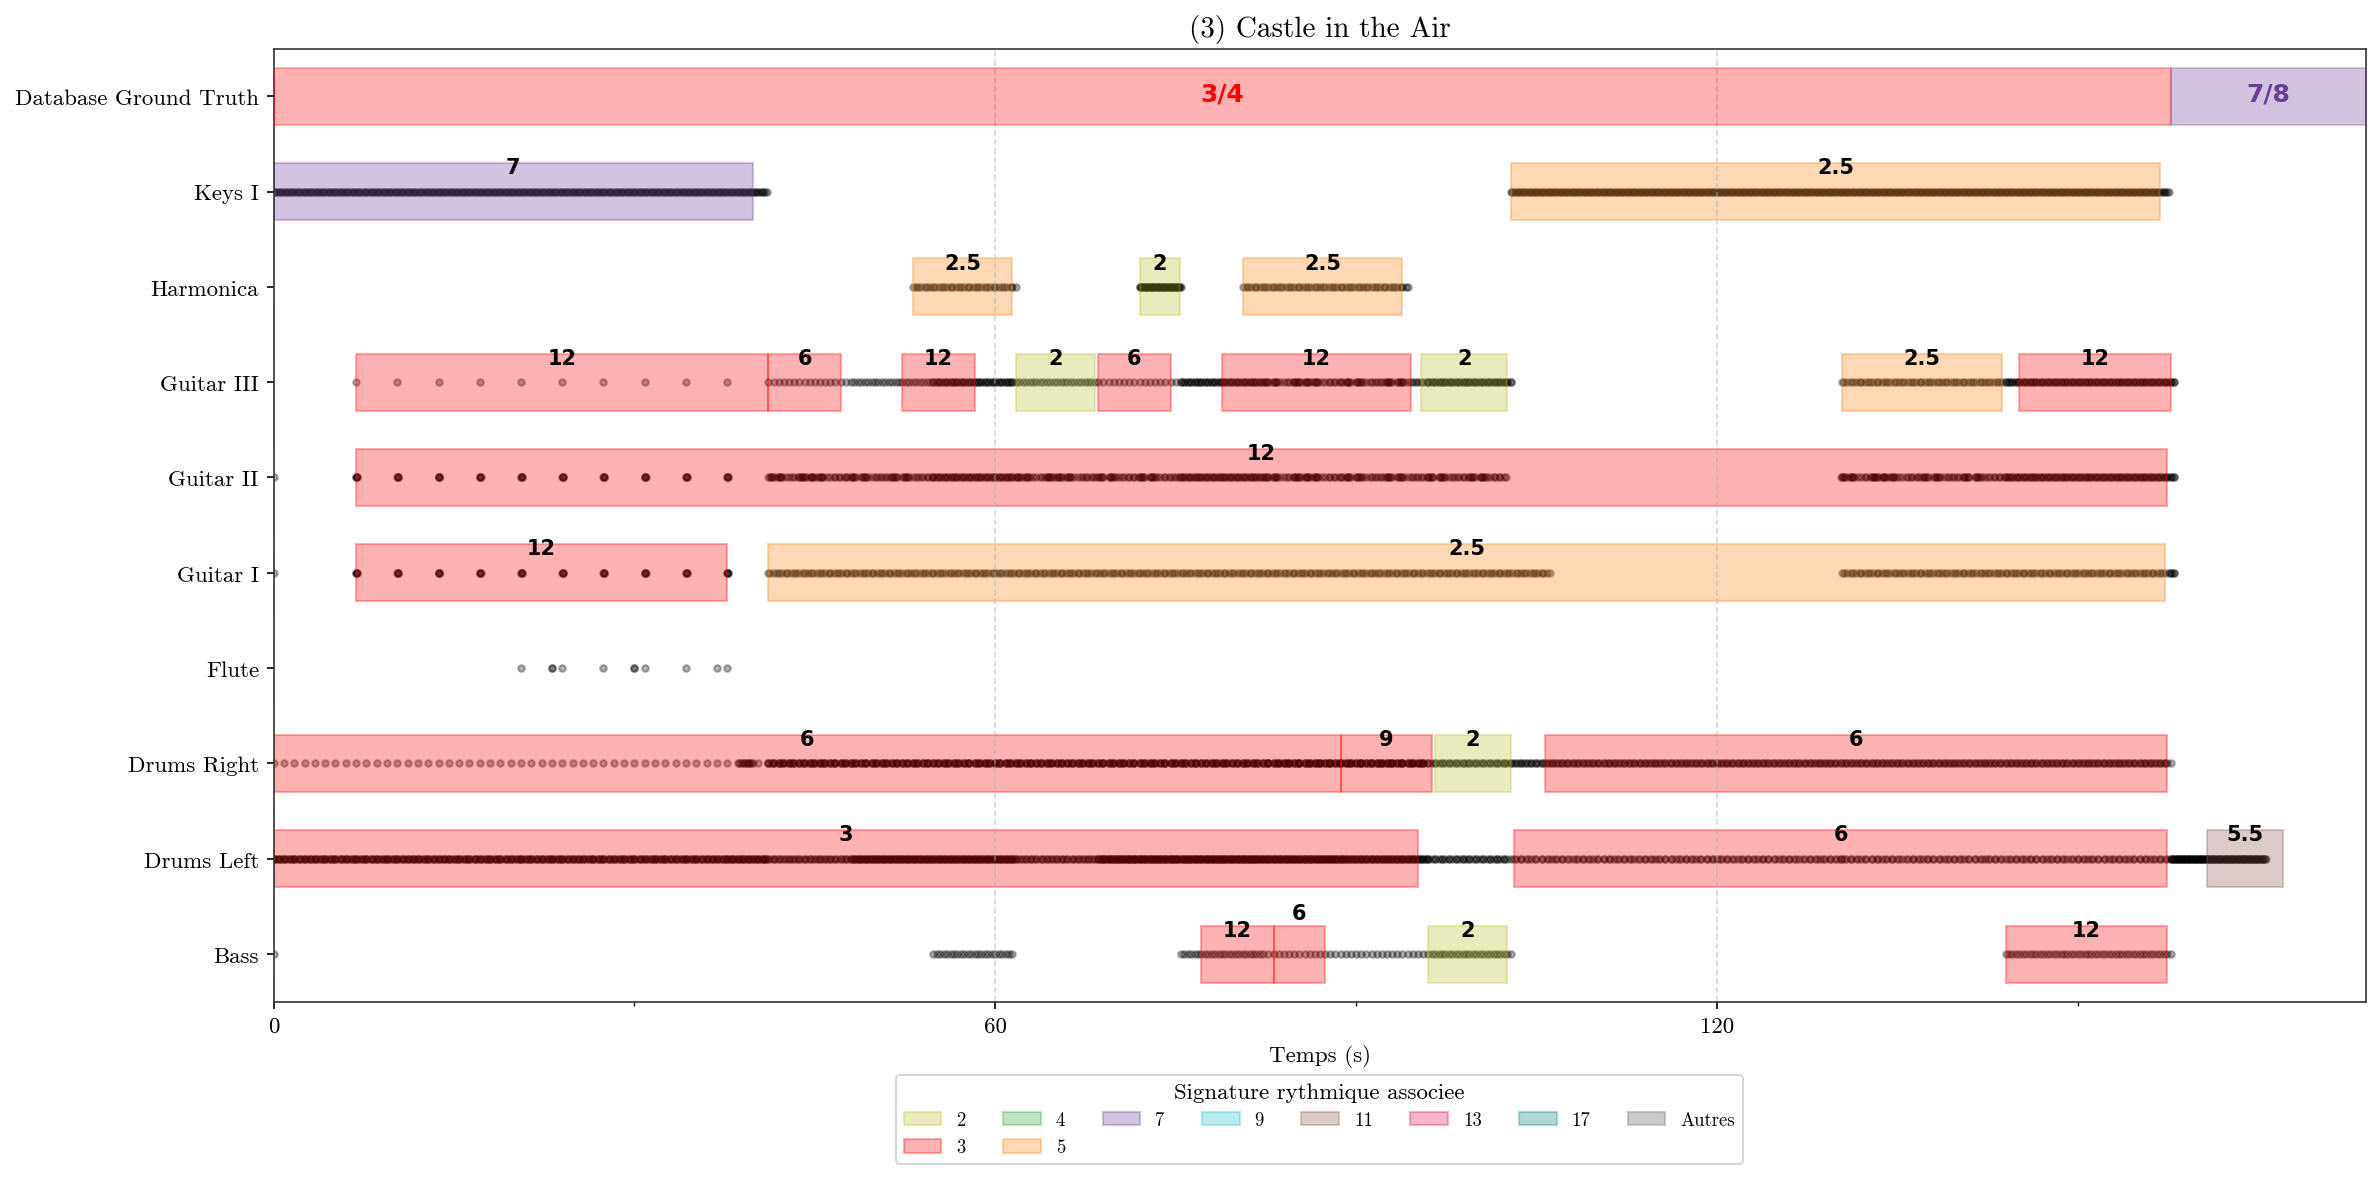

Pourcentage de points perdus : 16.41 %
Nombre de motifs: 98
Global compactness: 2.735735735735736


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


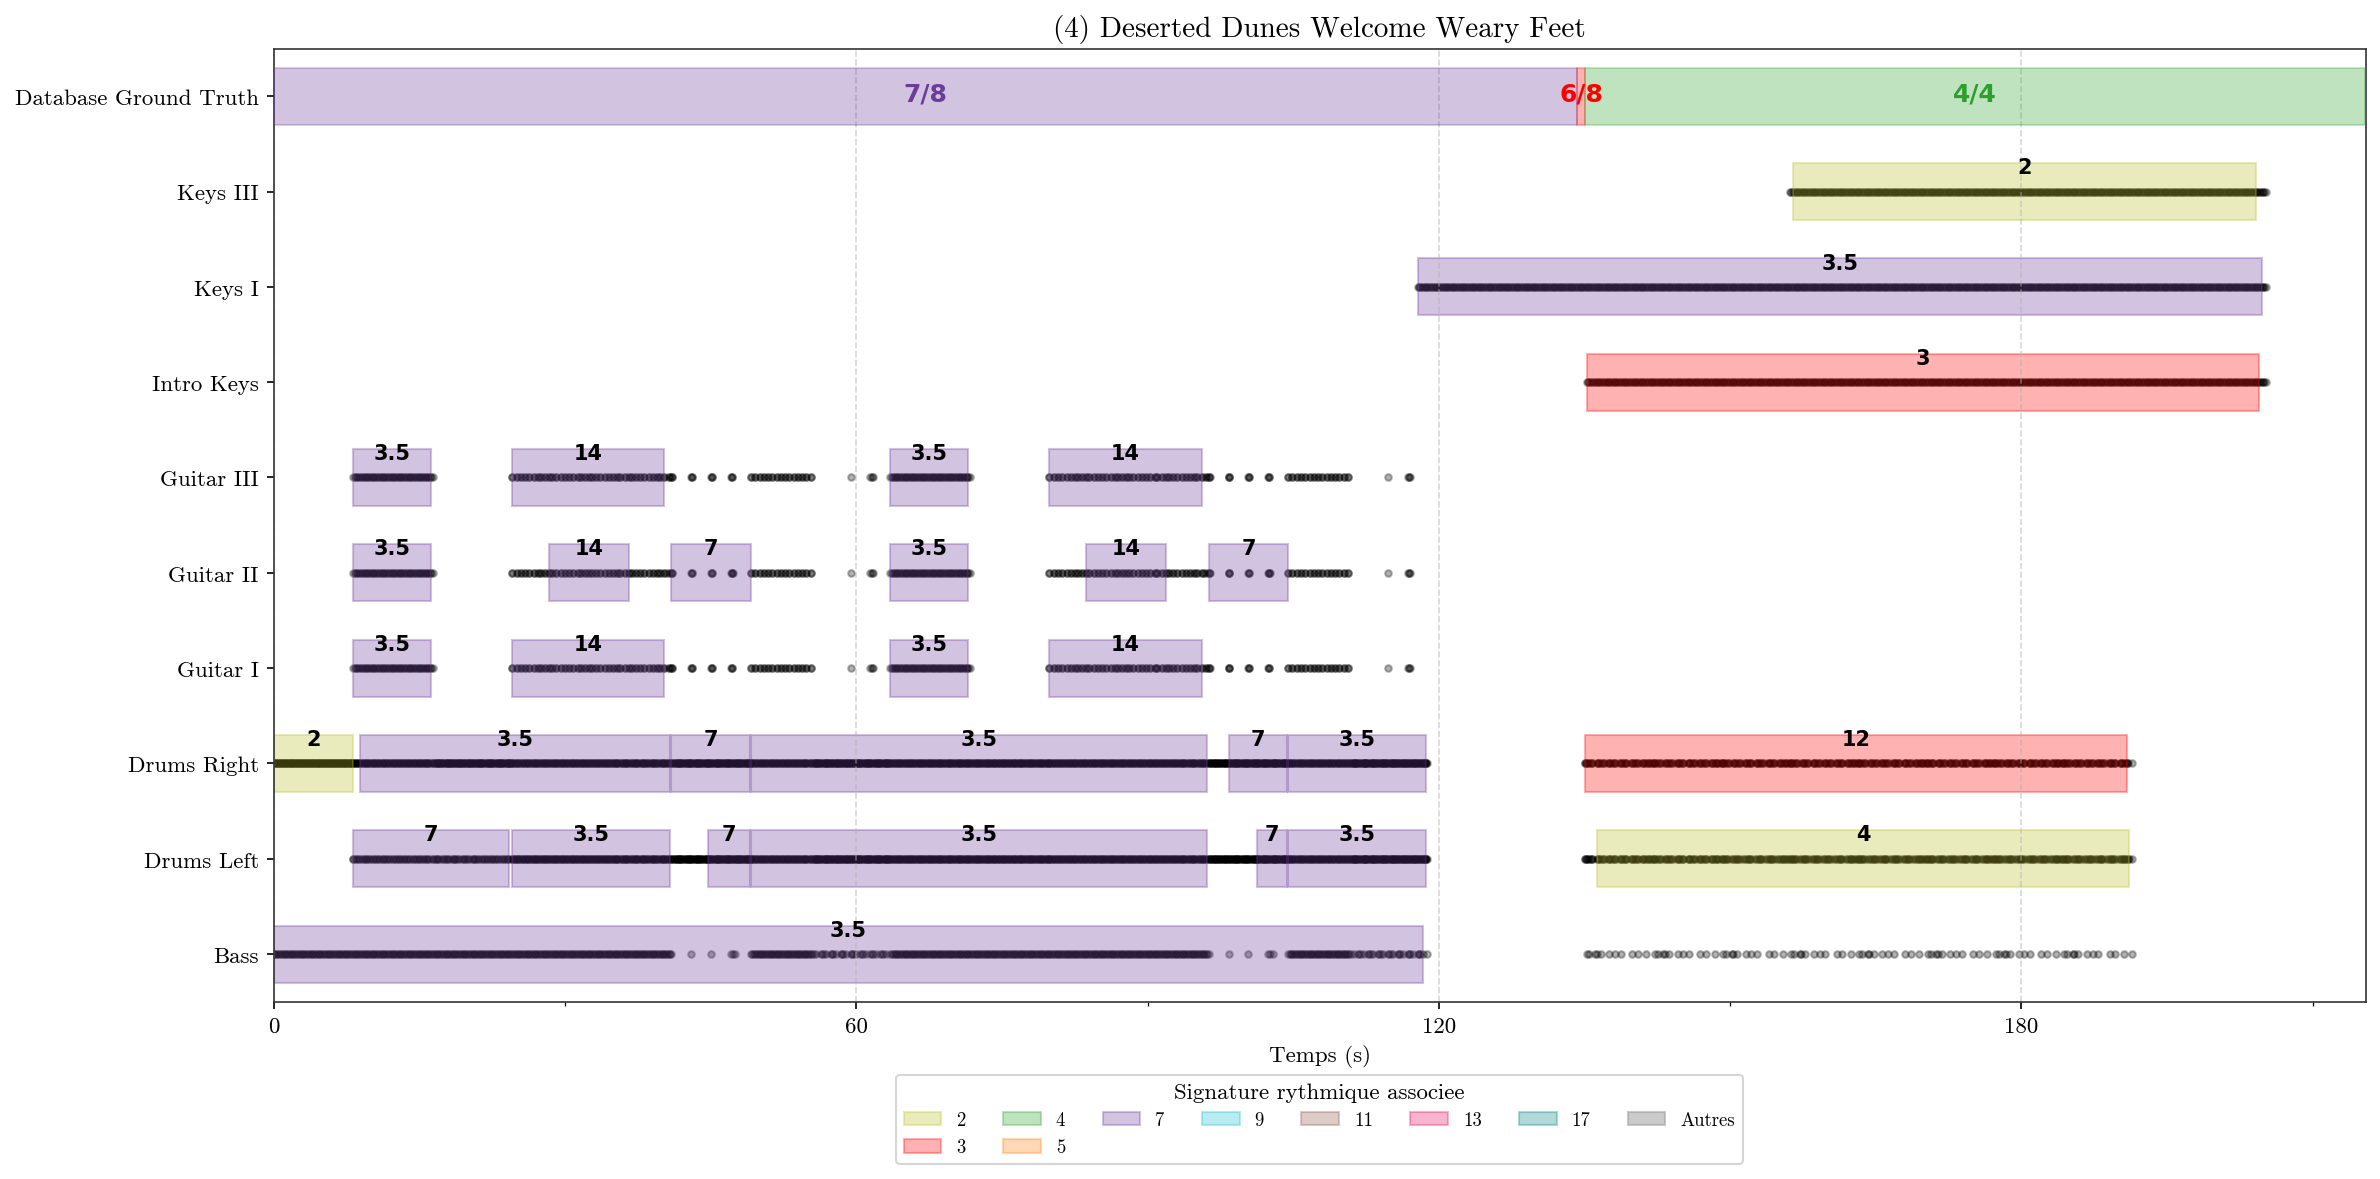

Pourcentage de points perdus : 8.97 %
Nombre de motifs: 97
Global compactness: 2.7828054298642533


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


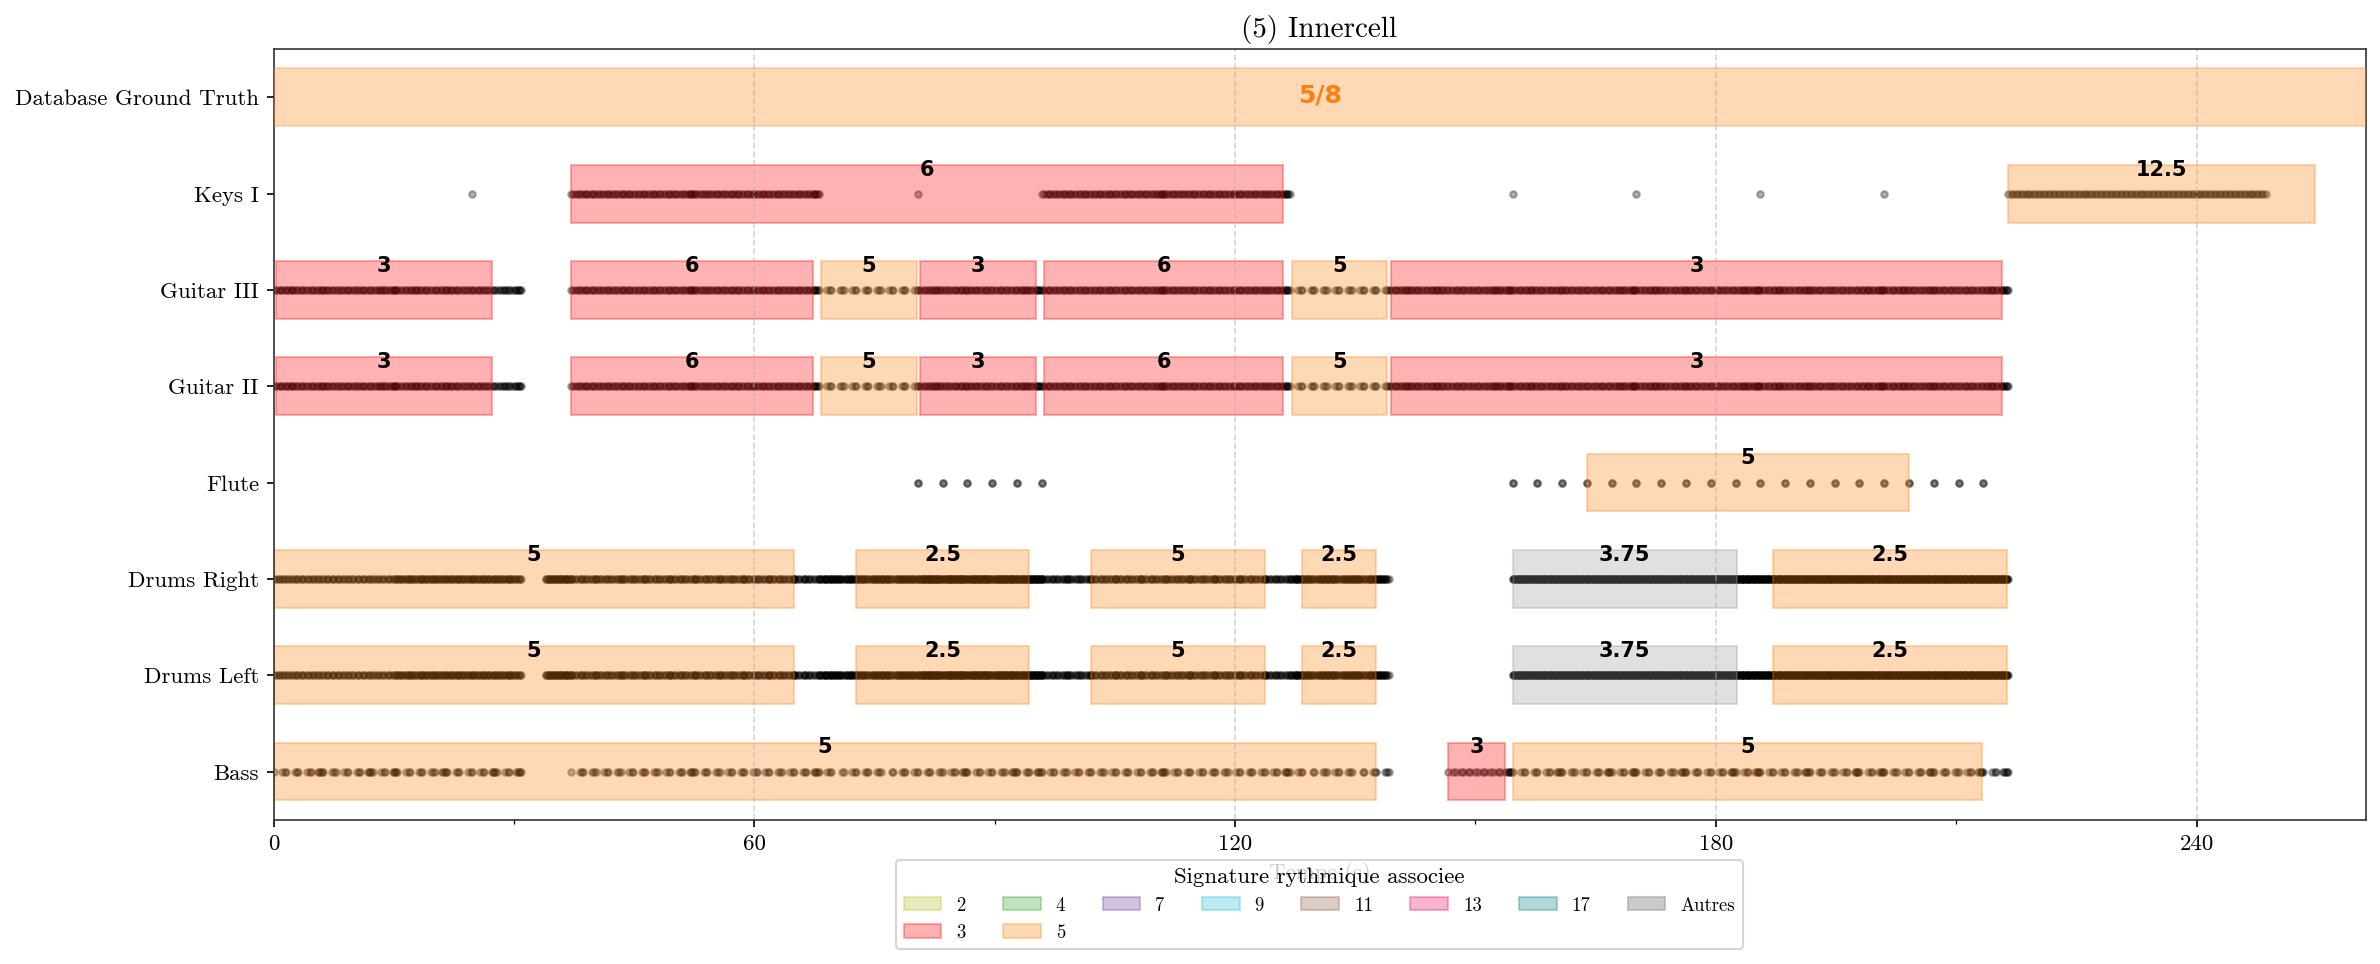

Pourcentage de points perdus : 19.33 %
Nombre de motifs: 154
Global compactness: 1.2625994694960212


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


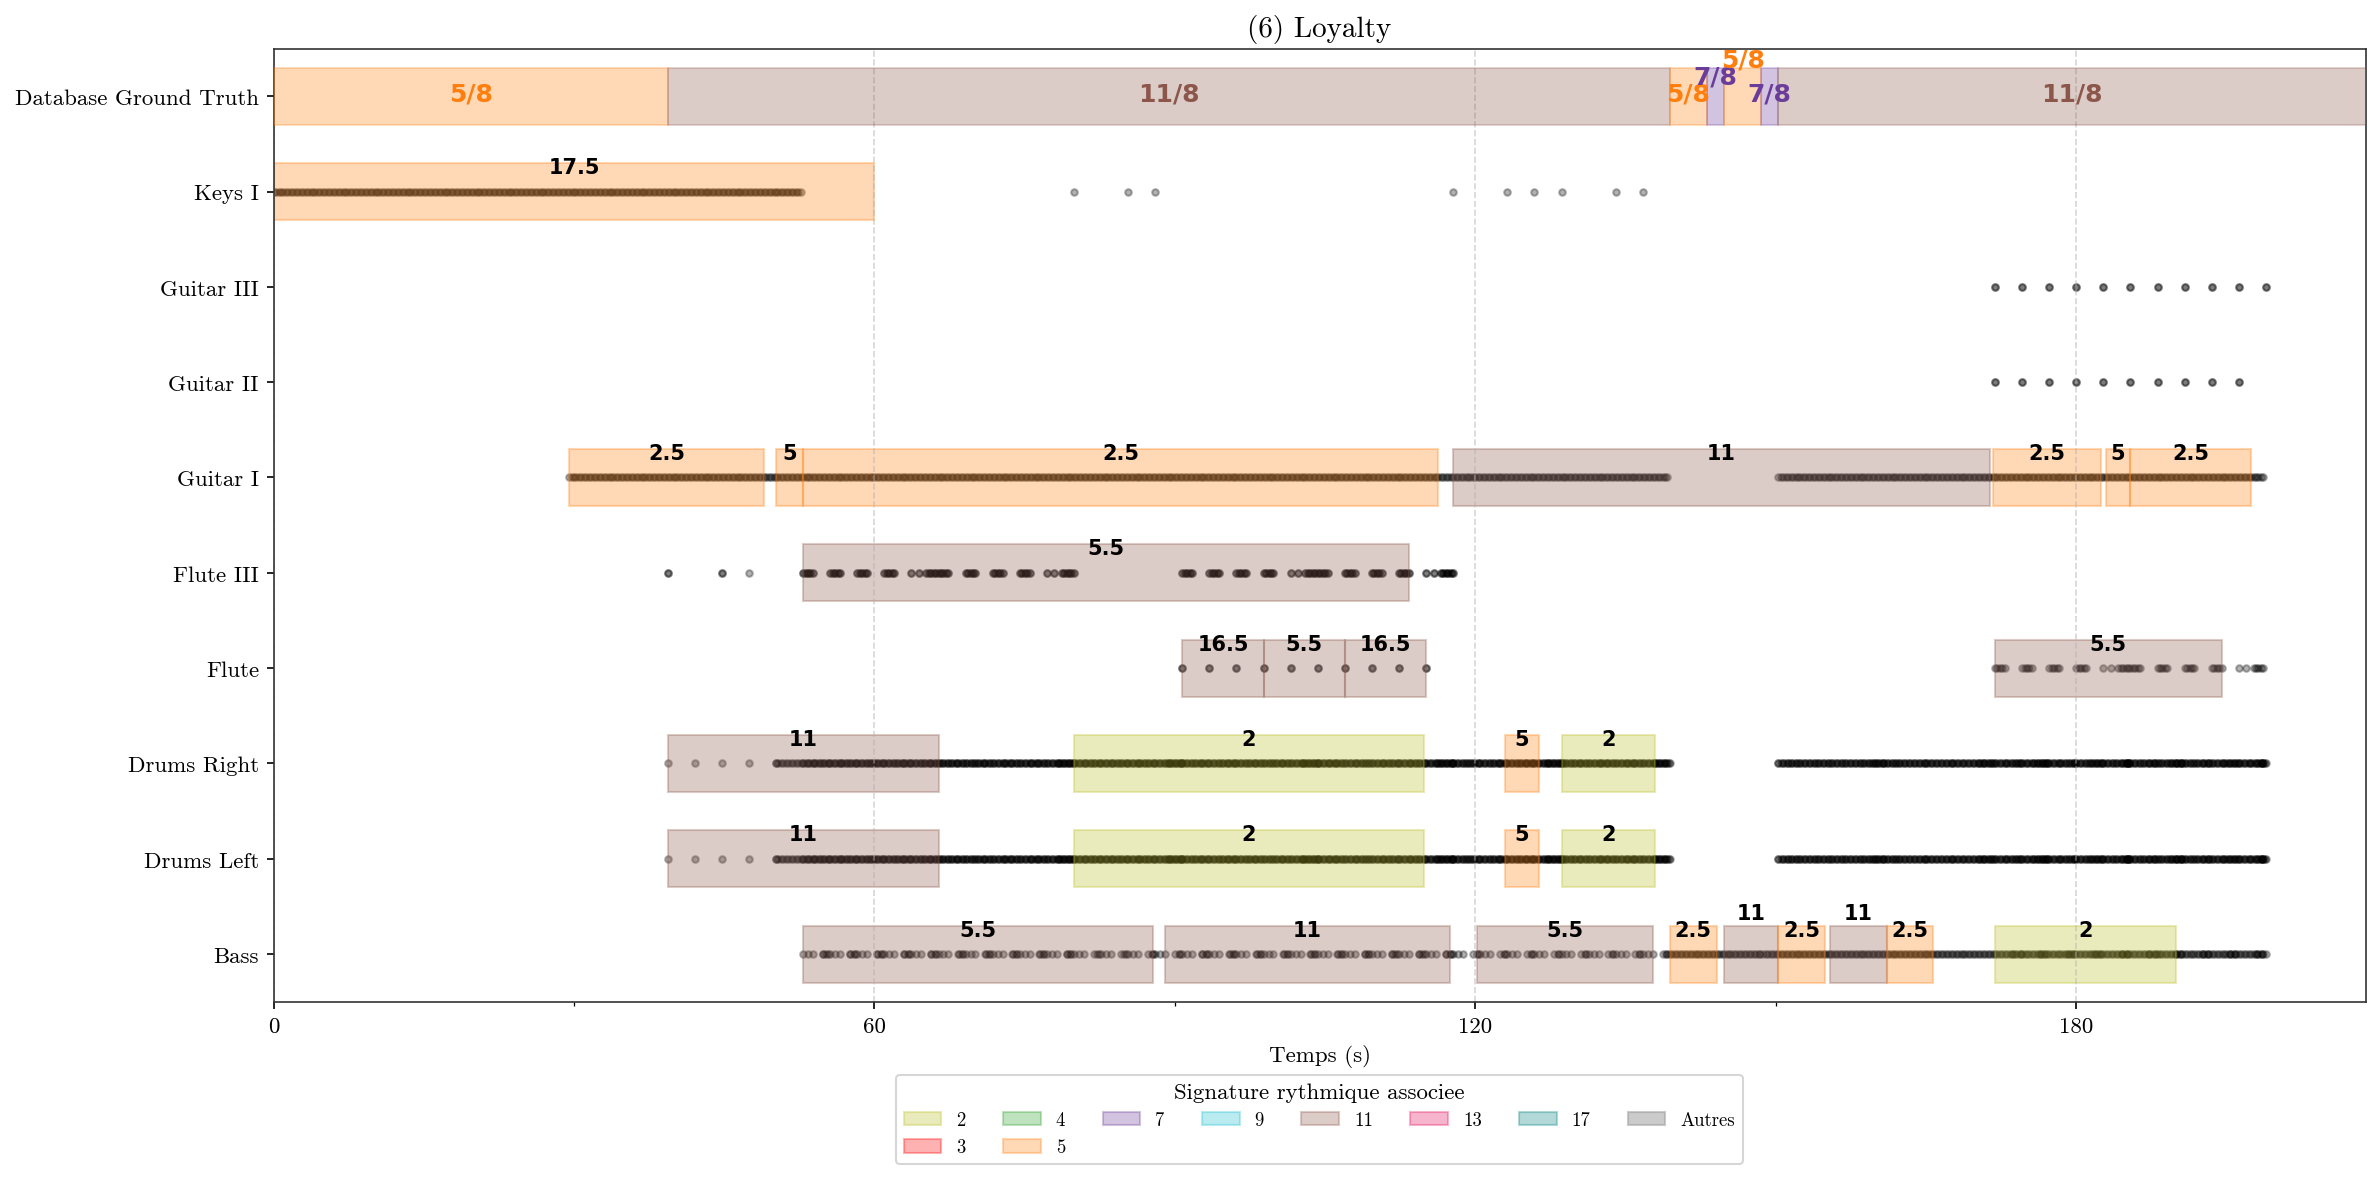

Pourcentage de points perdus : 39.42 %
Nombre de motifs: 65
Global compactness: 1.660887656033287


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


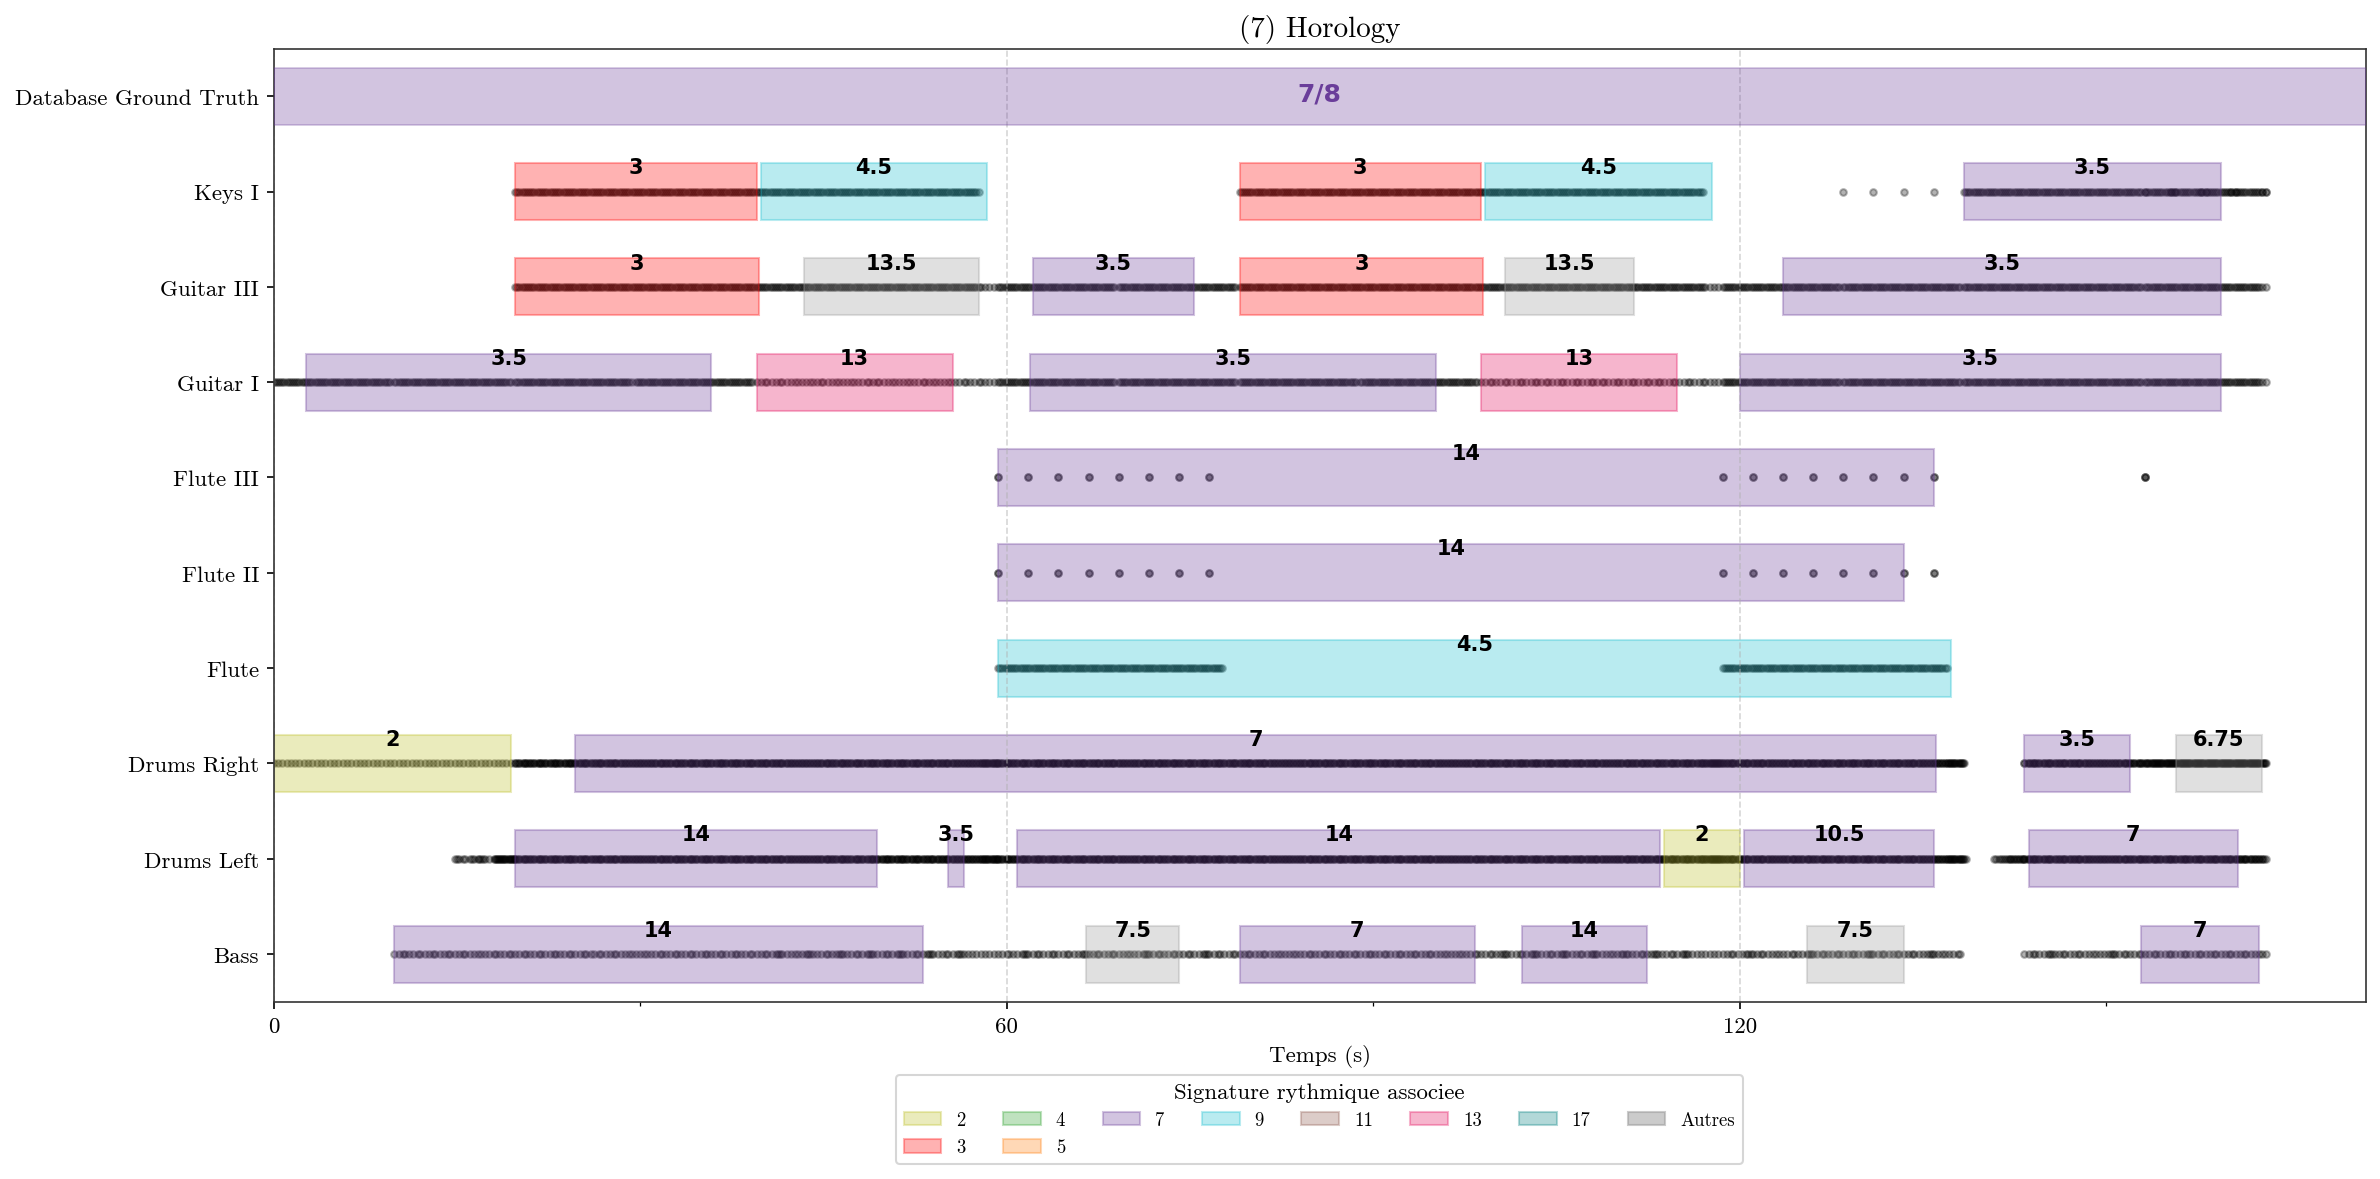

Pourcentage de points perdus : 26.76 %
Nombre de motifs: 115
Global compactness: 1.388155091606306


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


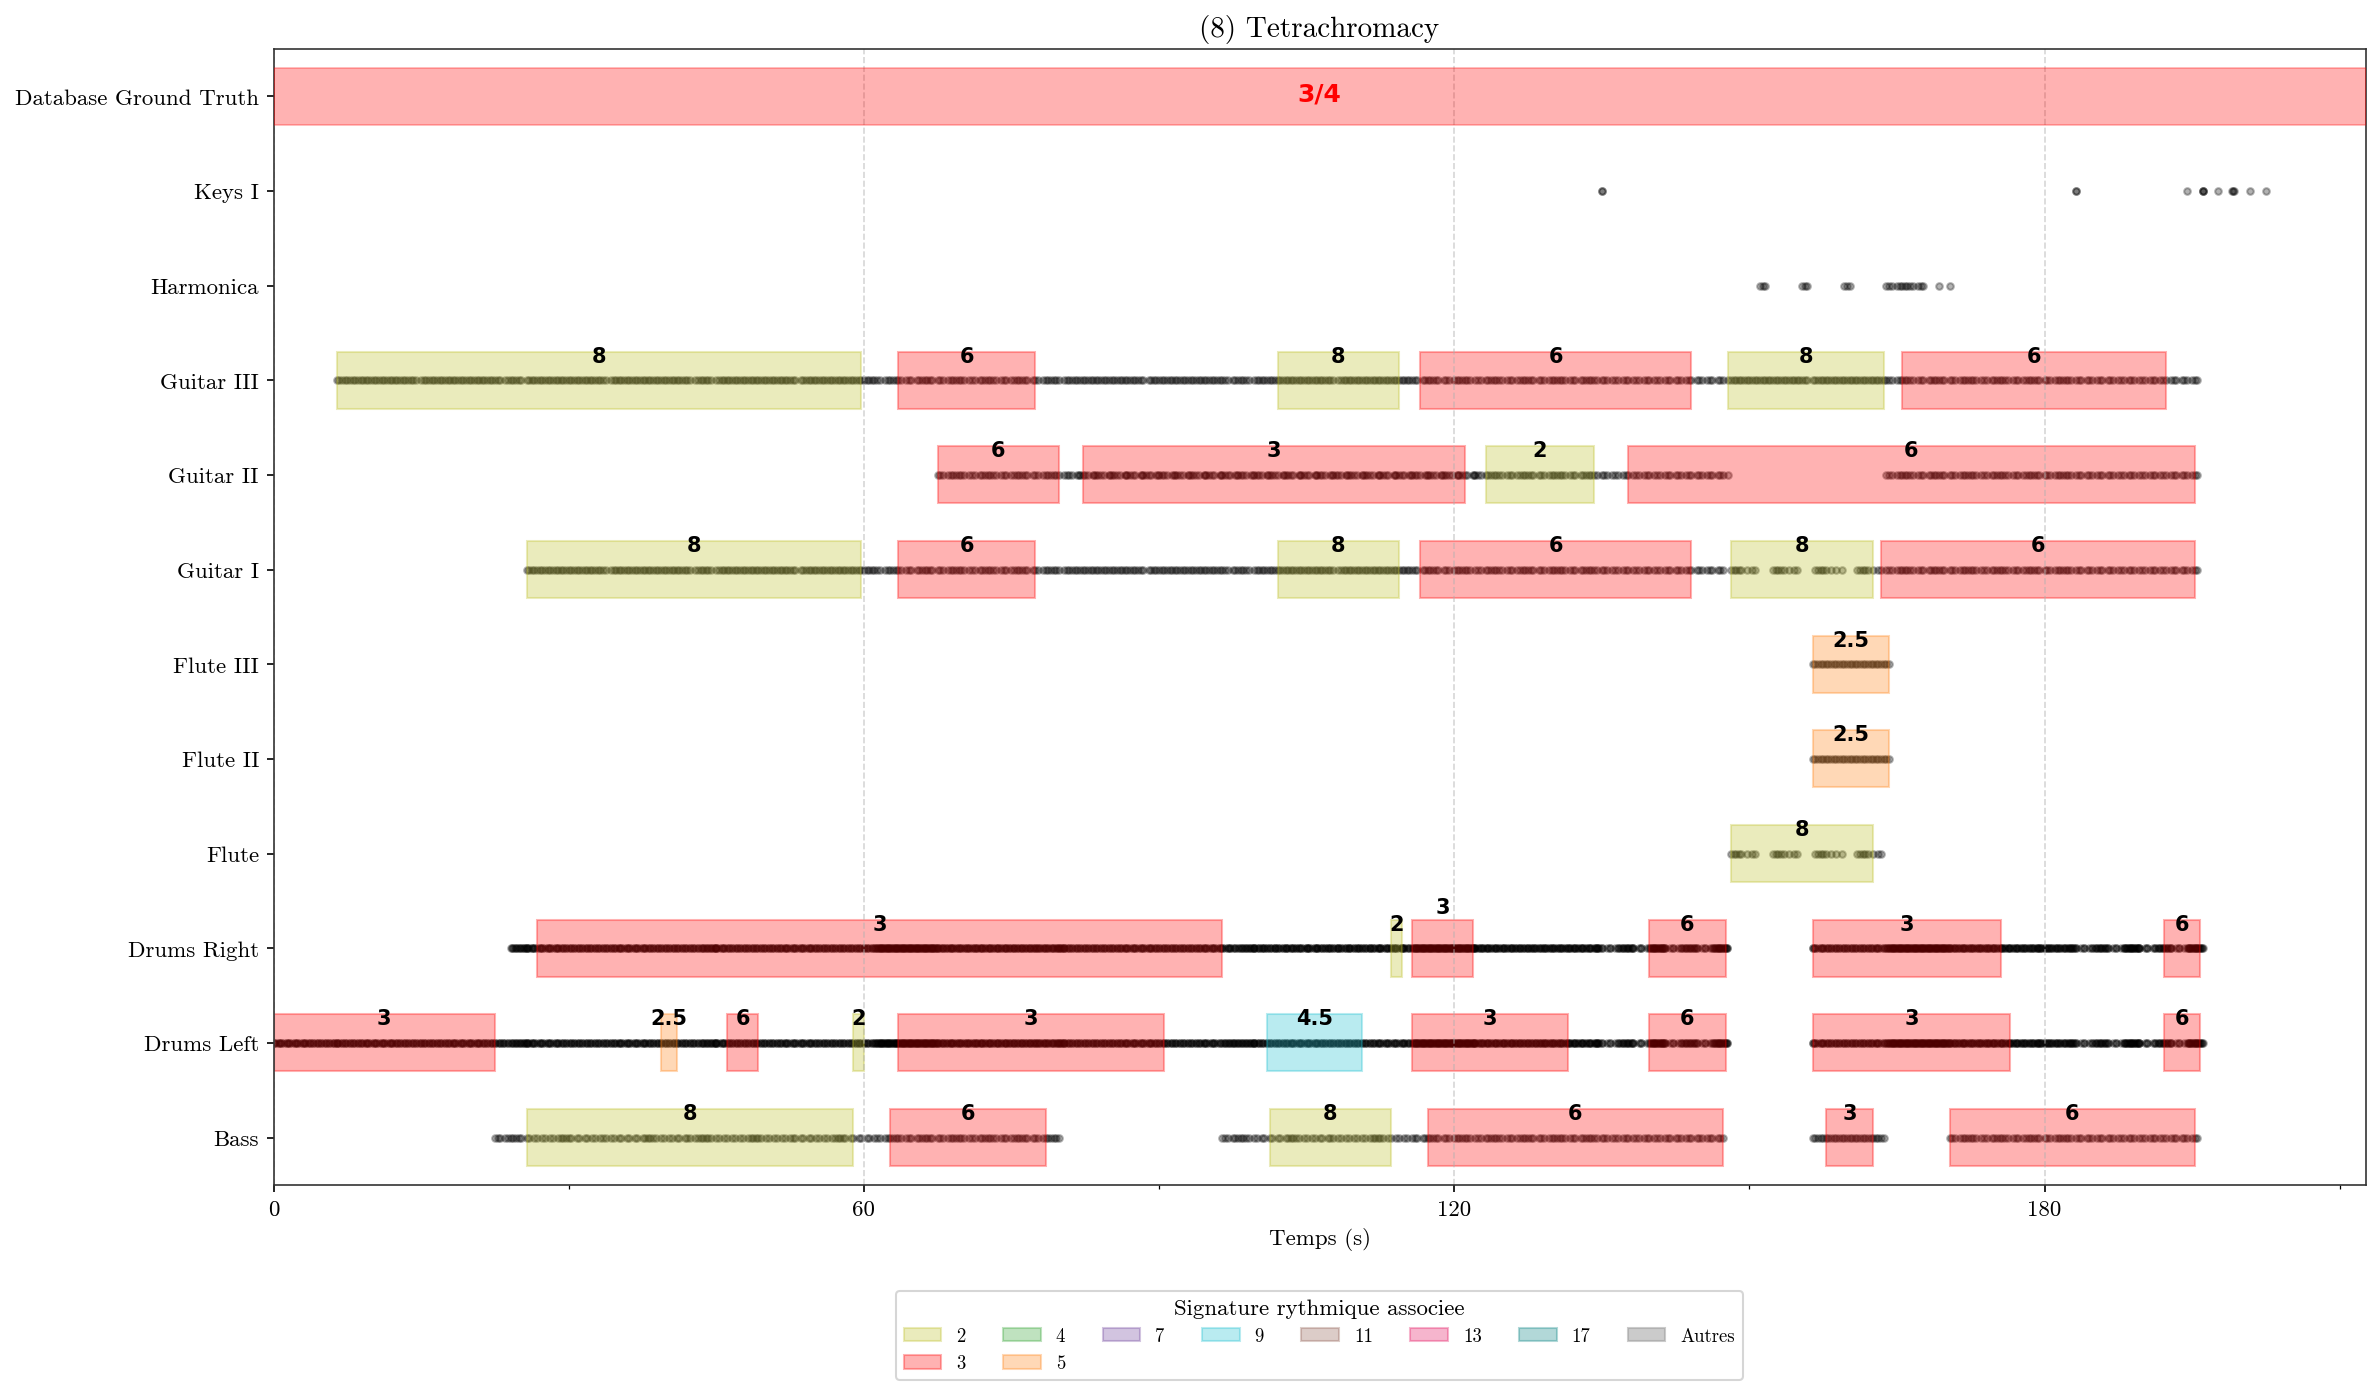

Pourcentage de points perdus : 31.96 %
Nombre de motifs: 96
Global compactness: 1.4619469026548673


/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


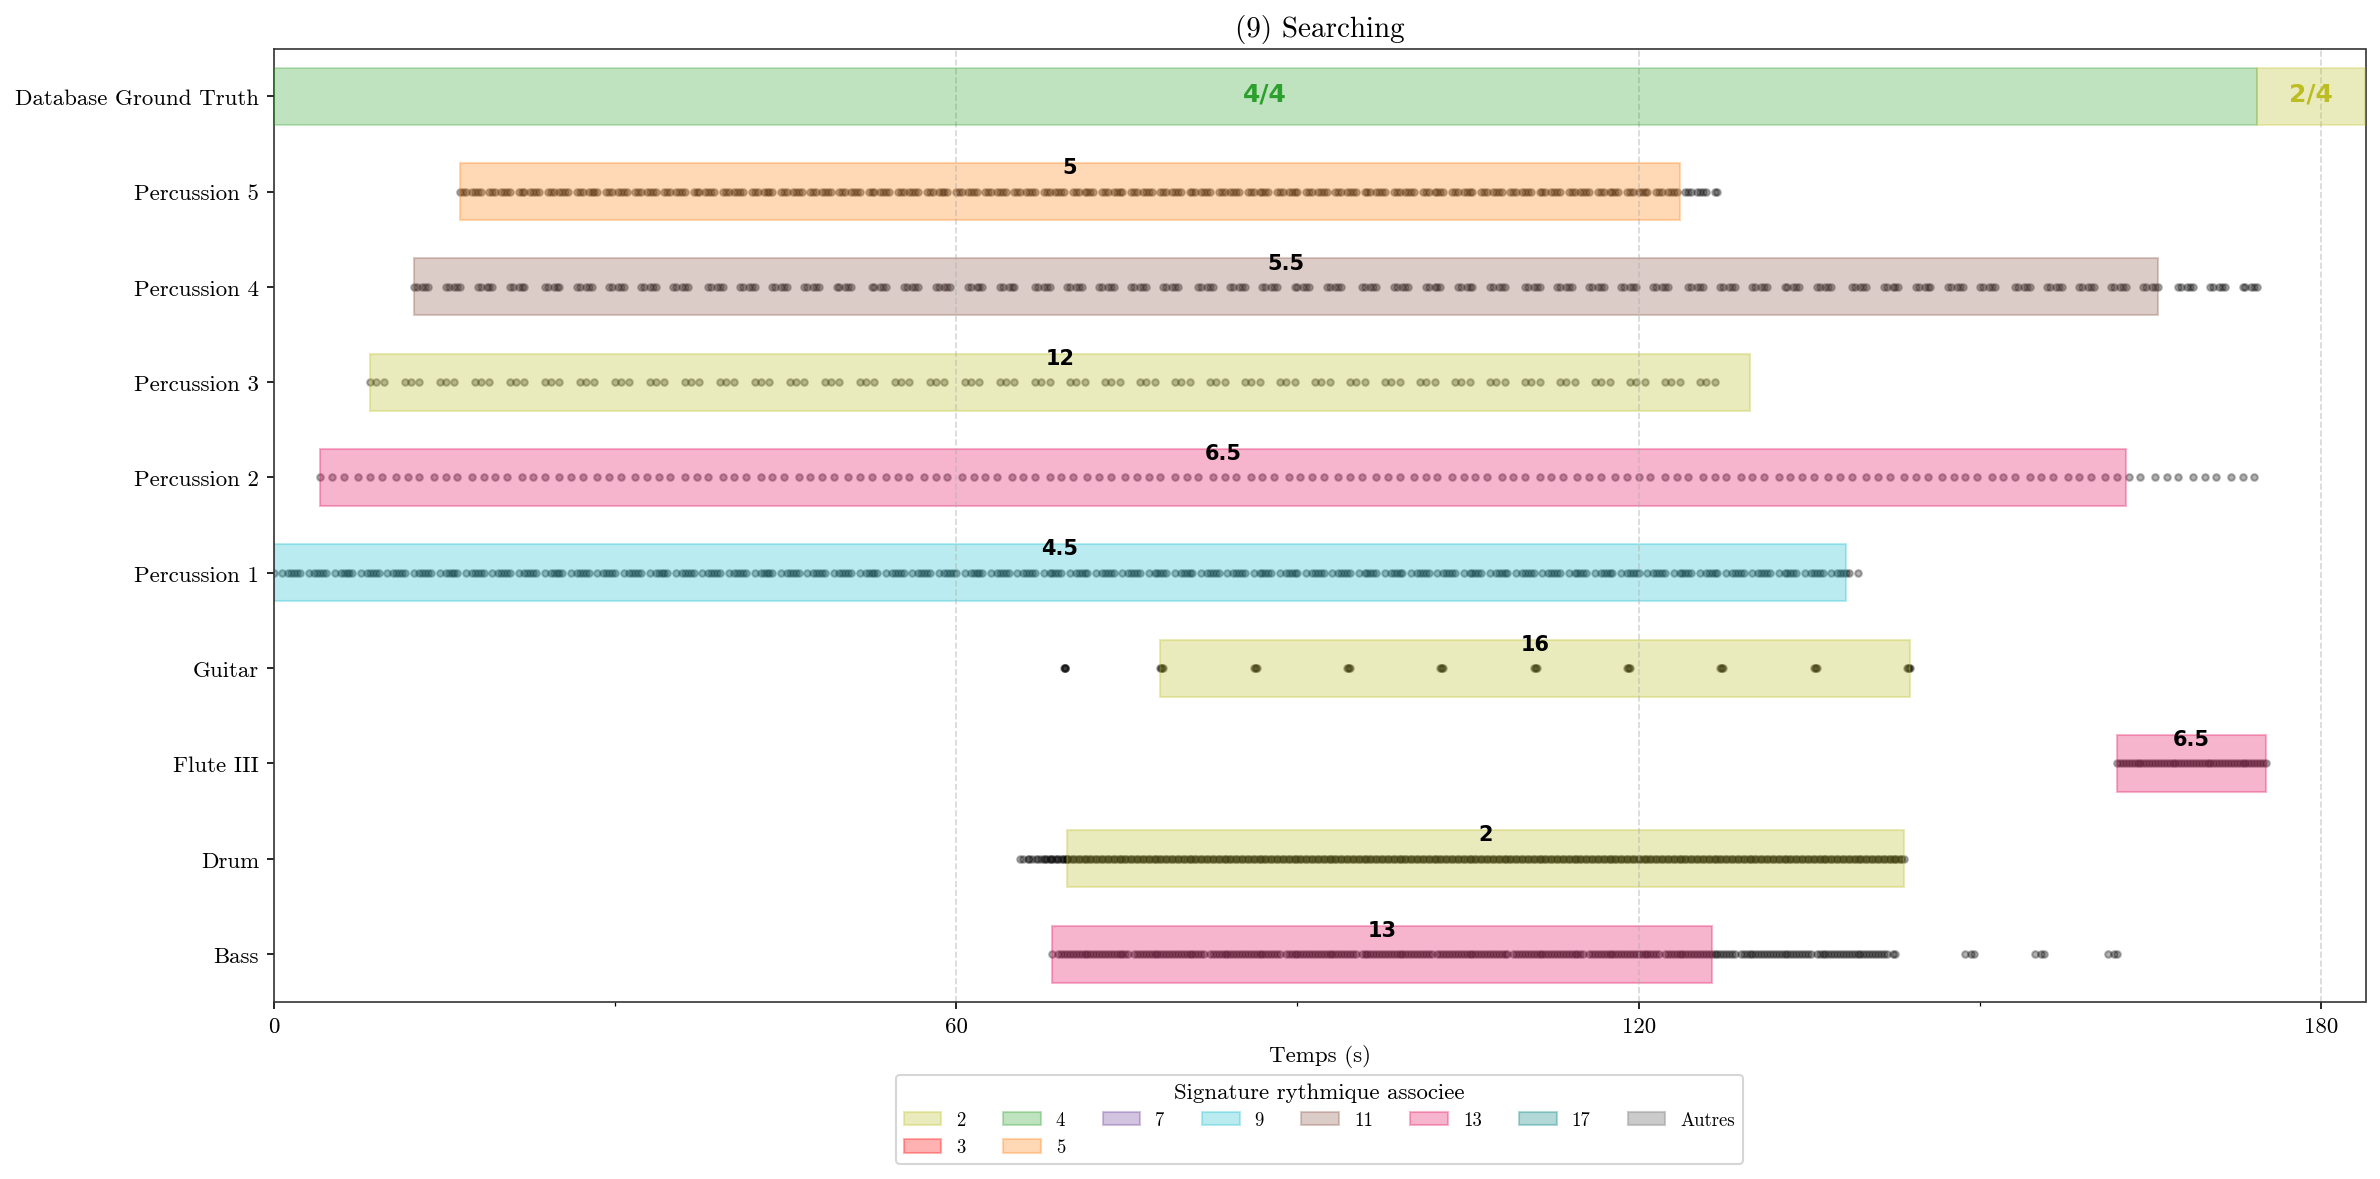

Pourcentage de points perdus : 9.80 %
Nombre de motifs: 70
Global compactness: 2.9437229437229435


In [ ]:
pieces_name = ["(1) Crumbling Castle.mid", "(2) Polygondwanaland.mid", "(3) Castle in the Air.mid", "(4) Deserted Dunes Welcome Weary Feet.mid", "(5) Innercell.mid", "(6) Loyalty.mid",  "(7) Horology.mid", "(8) Tetrachromacy.mid","(9) Searching.mid"] #, "(10) The Fourth Colour.mid"]

folder_path = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Polygondwanaland_MIDI"
ground_truth_df = check_time_signature_presence(folder_path)

for piece in pieces_name:
    plot_metric_sections_by_best_compactness(subsets_data, piece, pattern_detection, dilation, ground_truth_df, Lmax=20)

## On King Gizzard's "Butterfly3000" tracks

/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

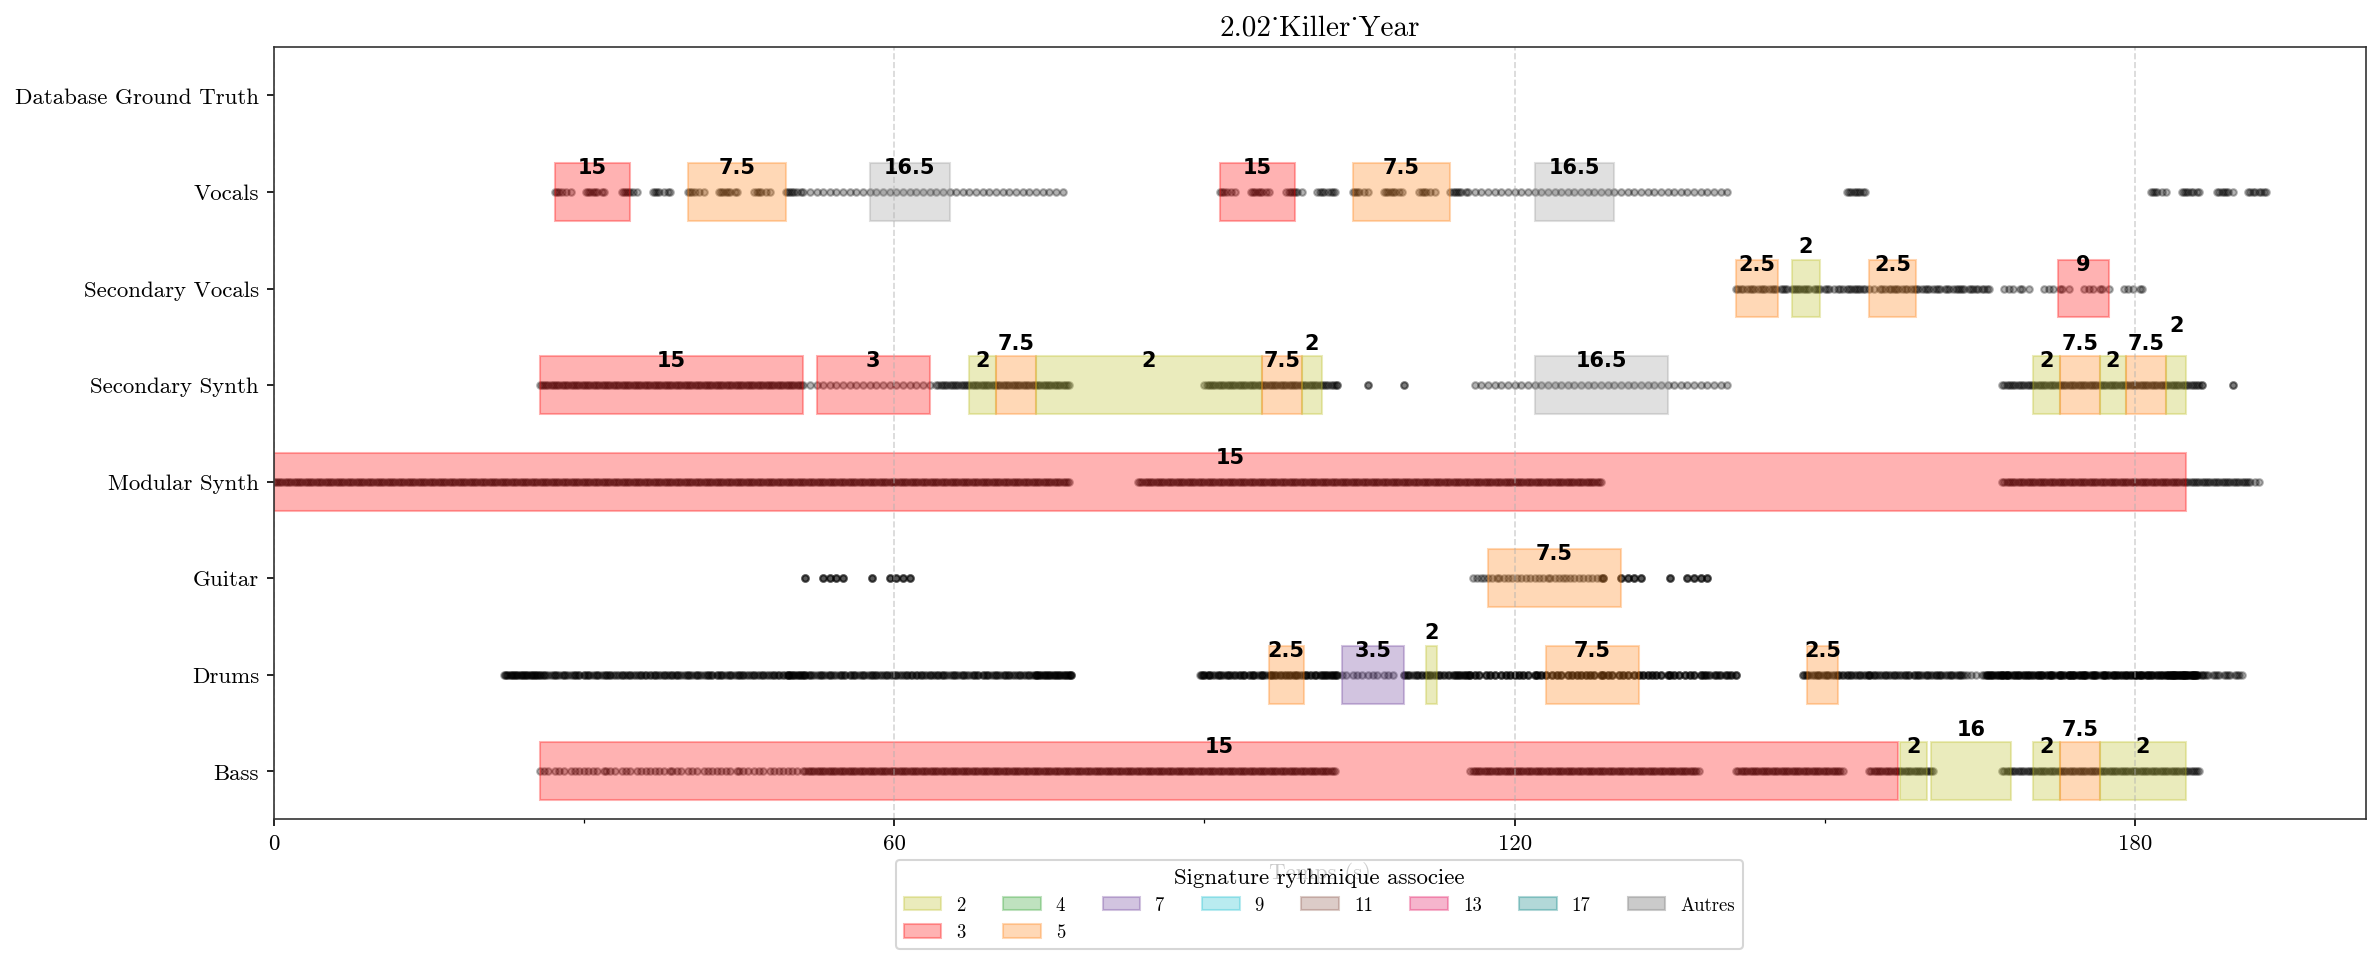

Pourcentage de points perdus : 45.53 %
Nombre de motifs: 55
Global compactness: 1.6156052782558807


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


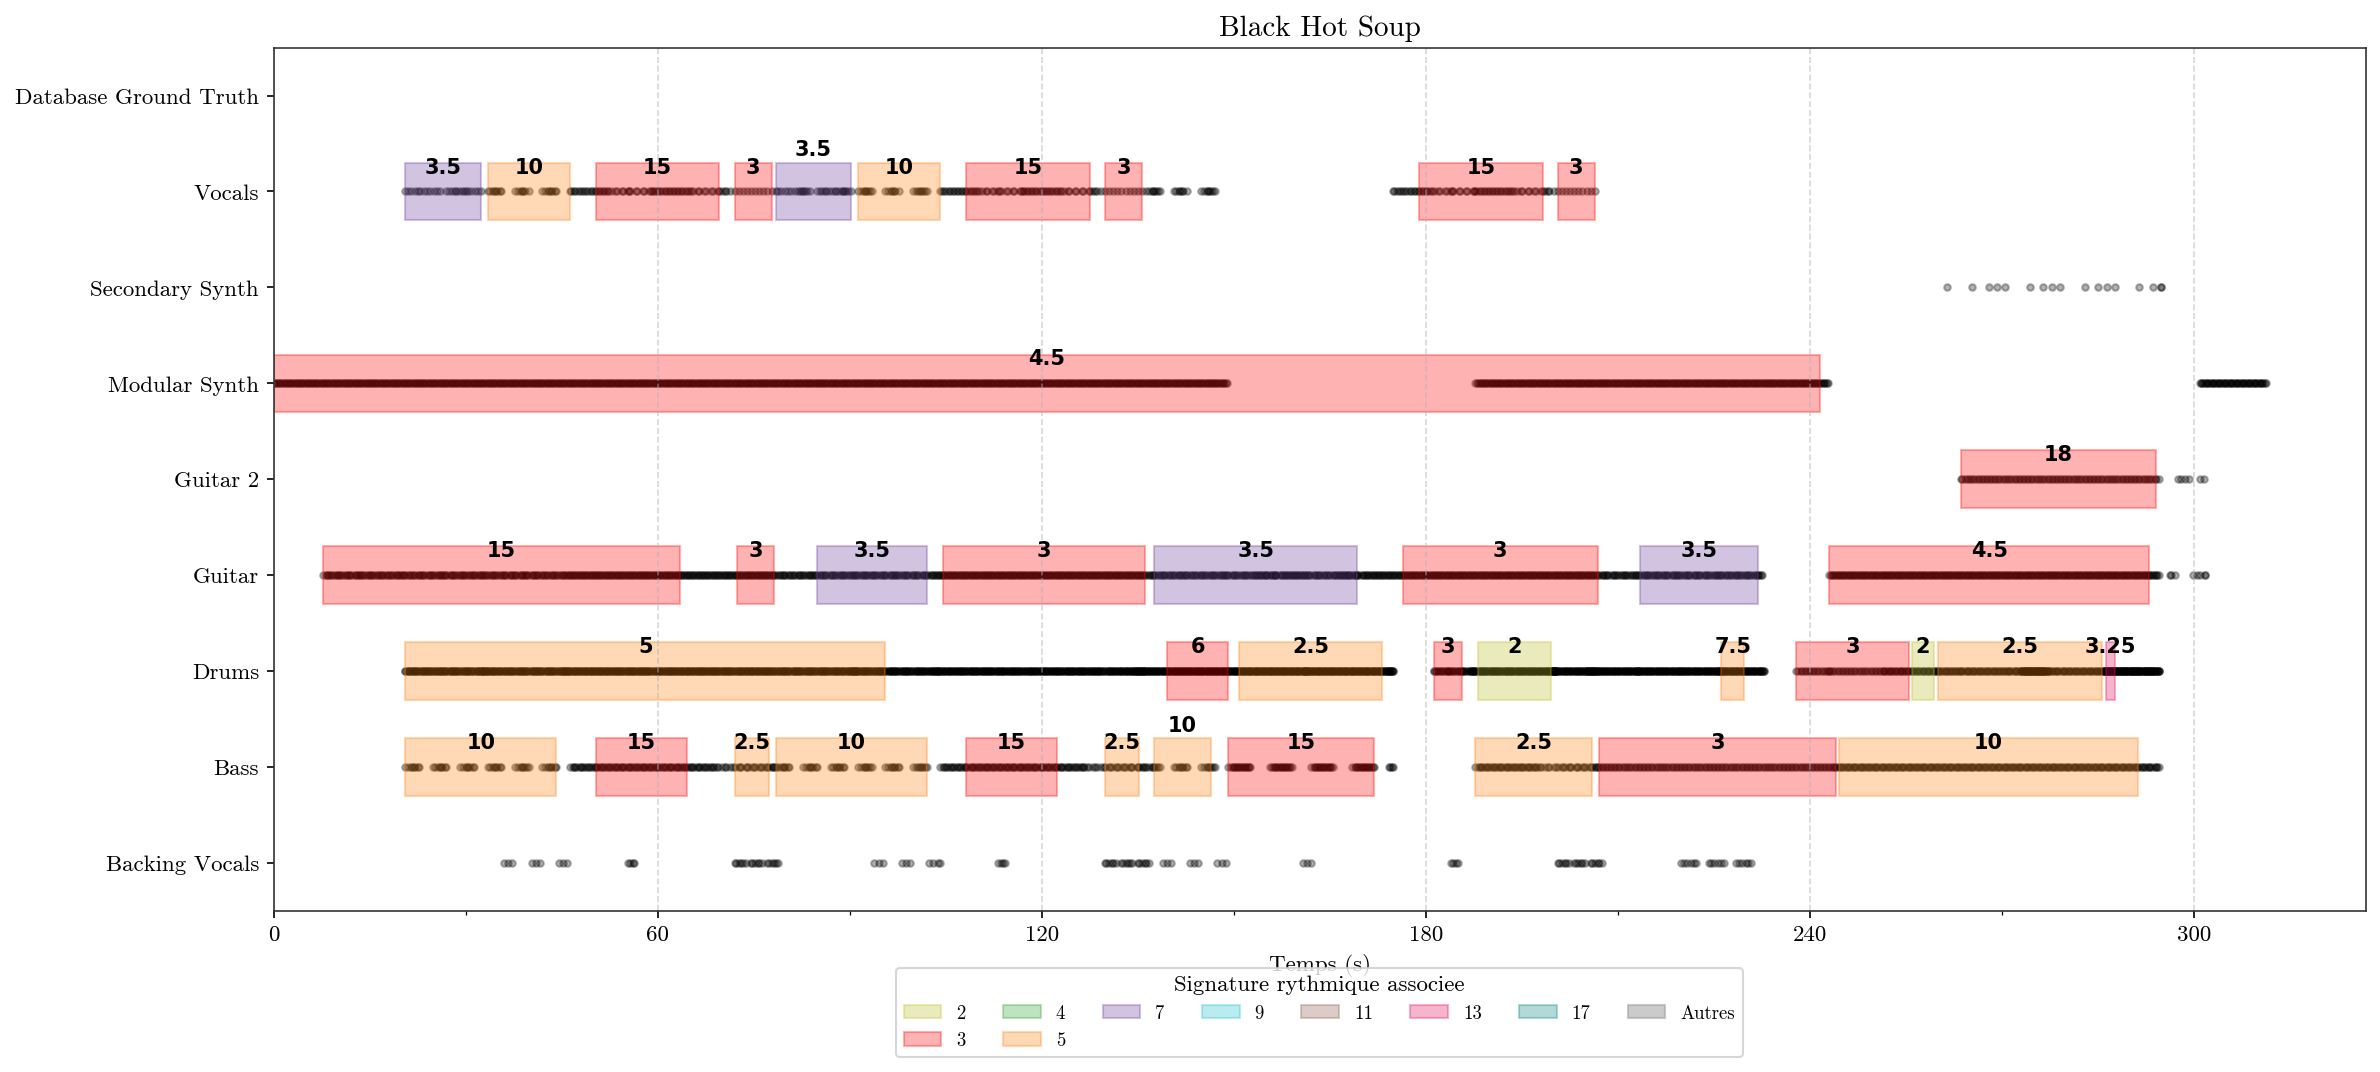

Pourcentage de points perdus : 35.05 %
Nombre de motifs: 91
Global compactness: 2.0534230312623665


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


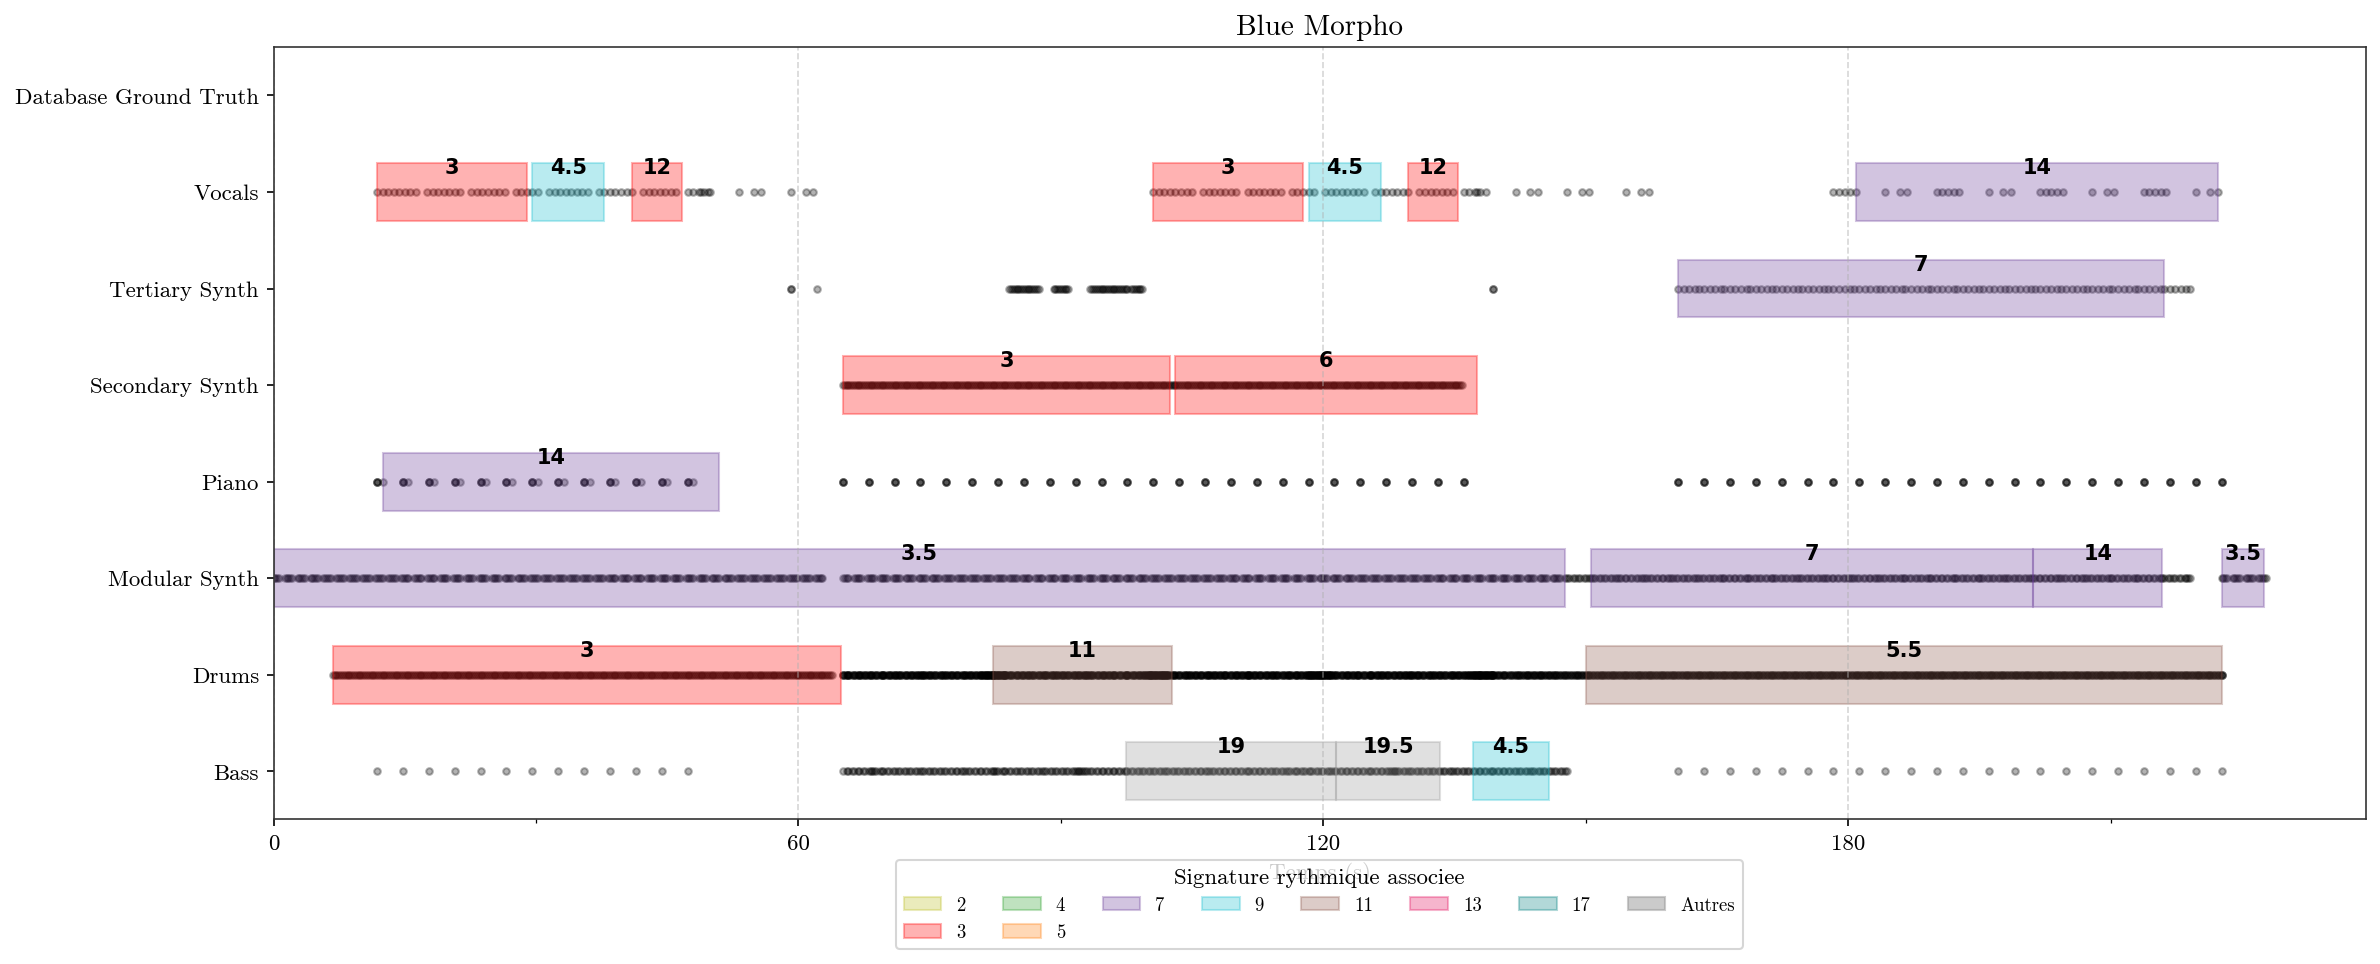

Pourcentage de points perdus : 40.18 %
Nombre de motifs: 39
Global compactness: 2.127579737335835


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


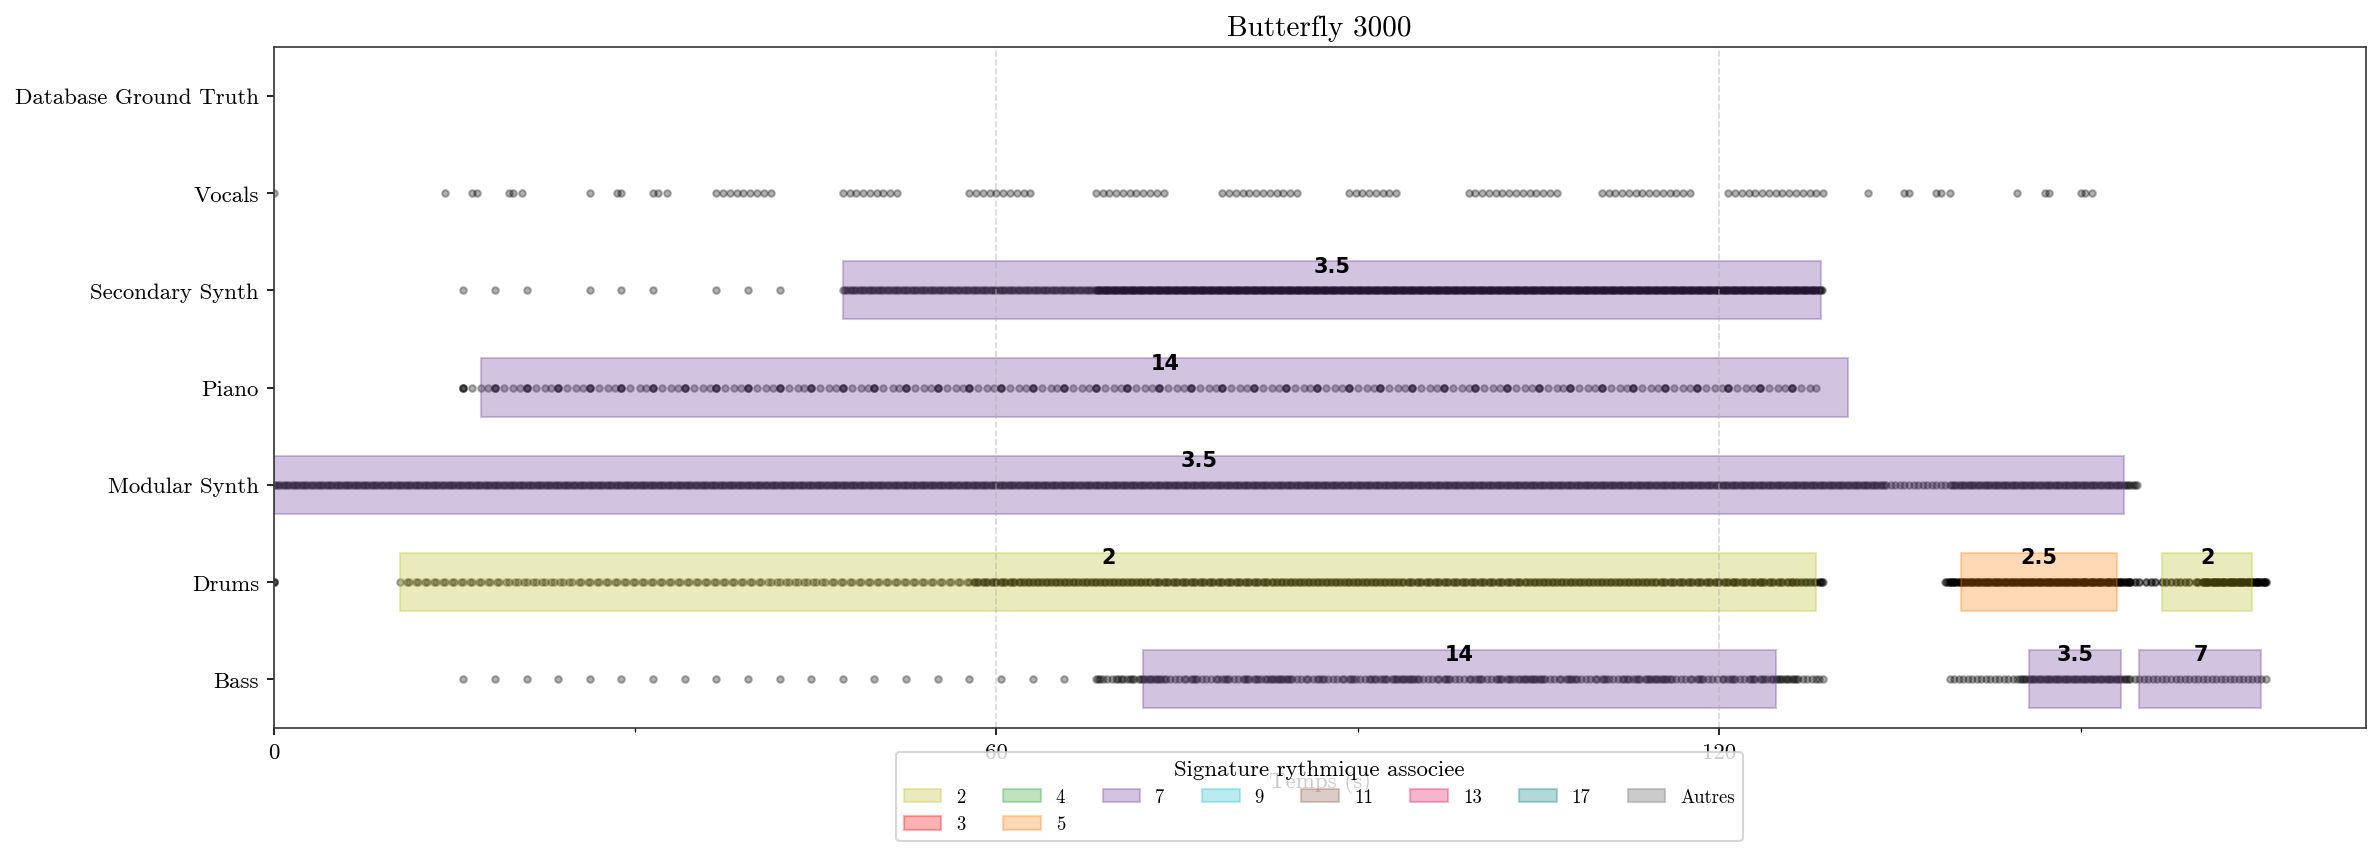

Pourcentage de points perdus : 32.06 %
Nombre de motifs: 25
Global compactness: 2.6711749788672865


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


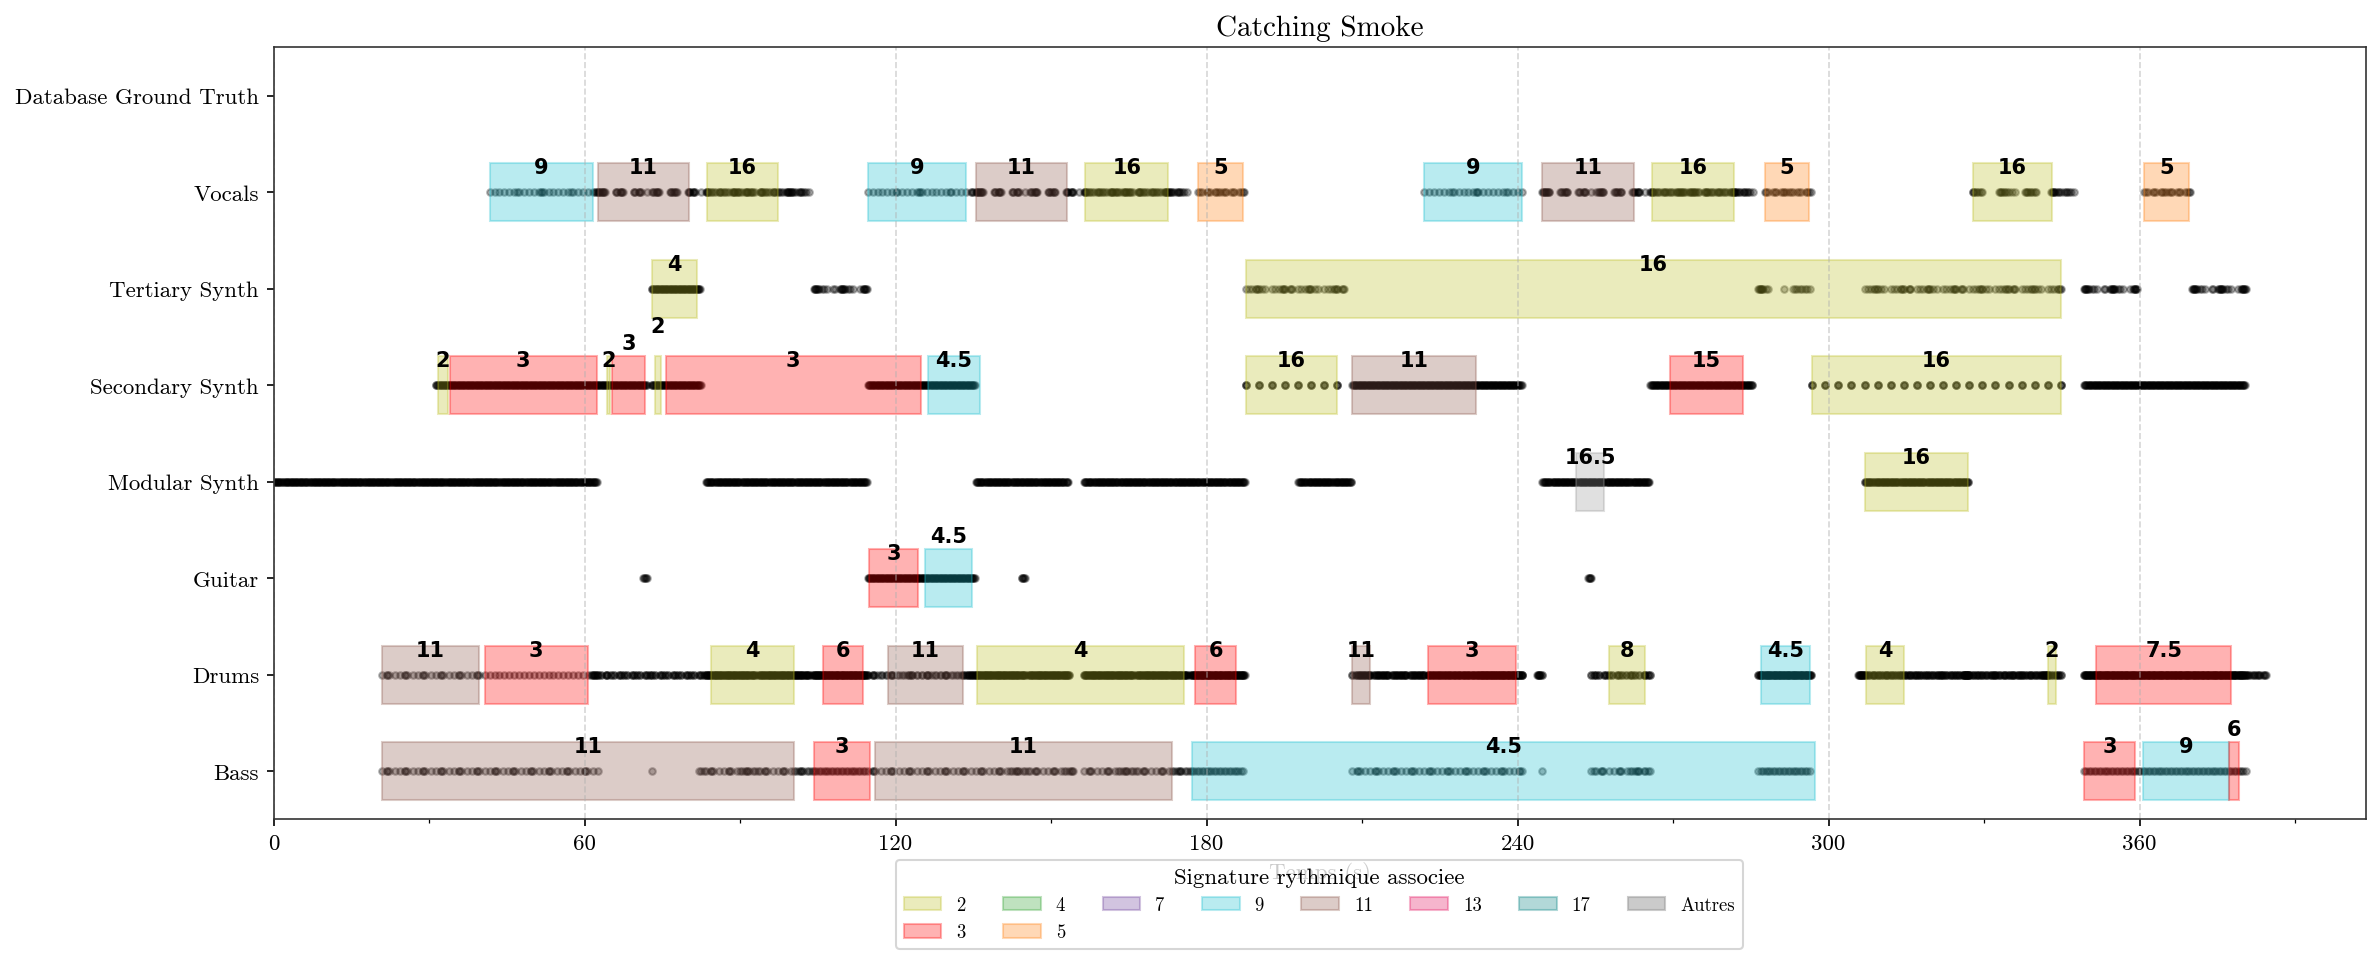

Pourcentage de points perdus : 46.30 %
Nombre de motifs: 107
Global compactness: 1.5722337585286266


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


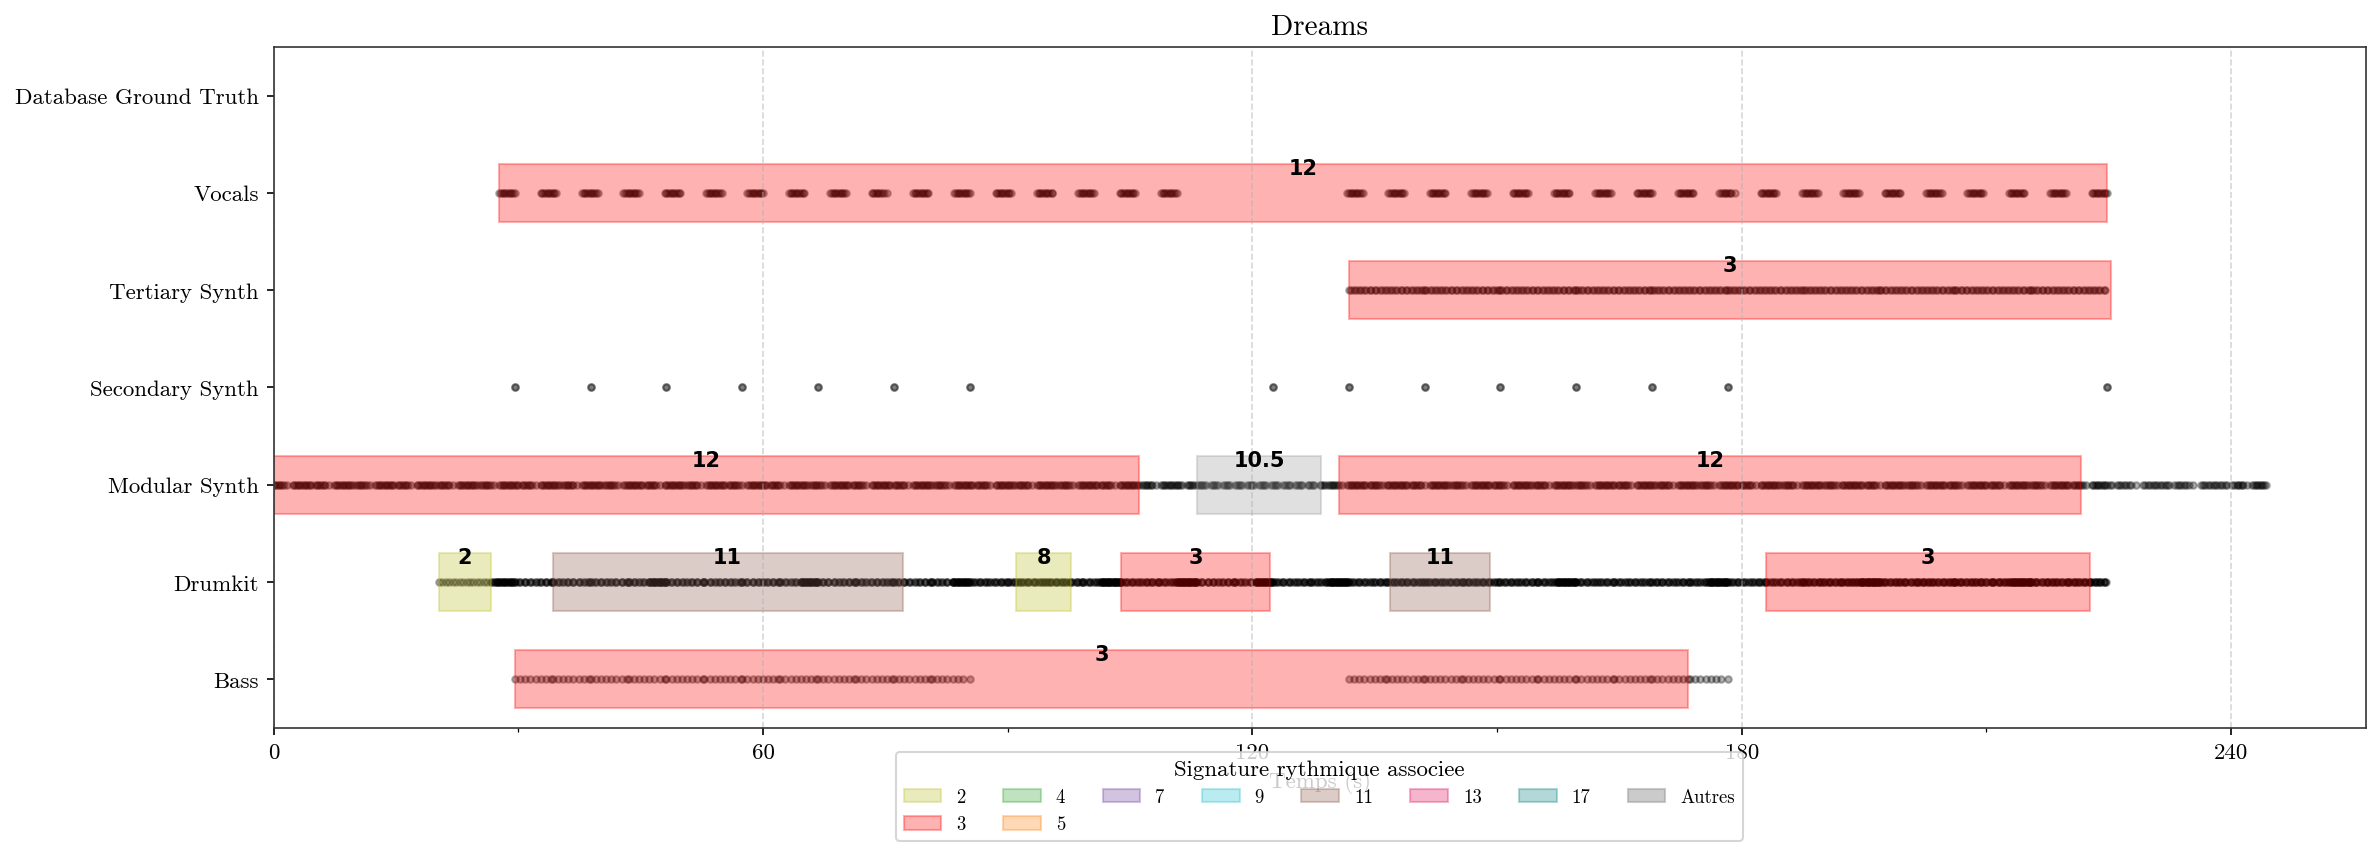

Pourcentage de points perdus : 37.52 %
Nombre de motifs: 65
Global compactness: 1.8349447513812154


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


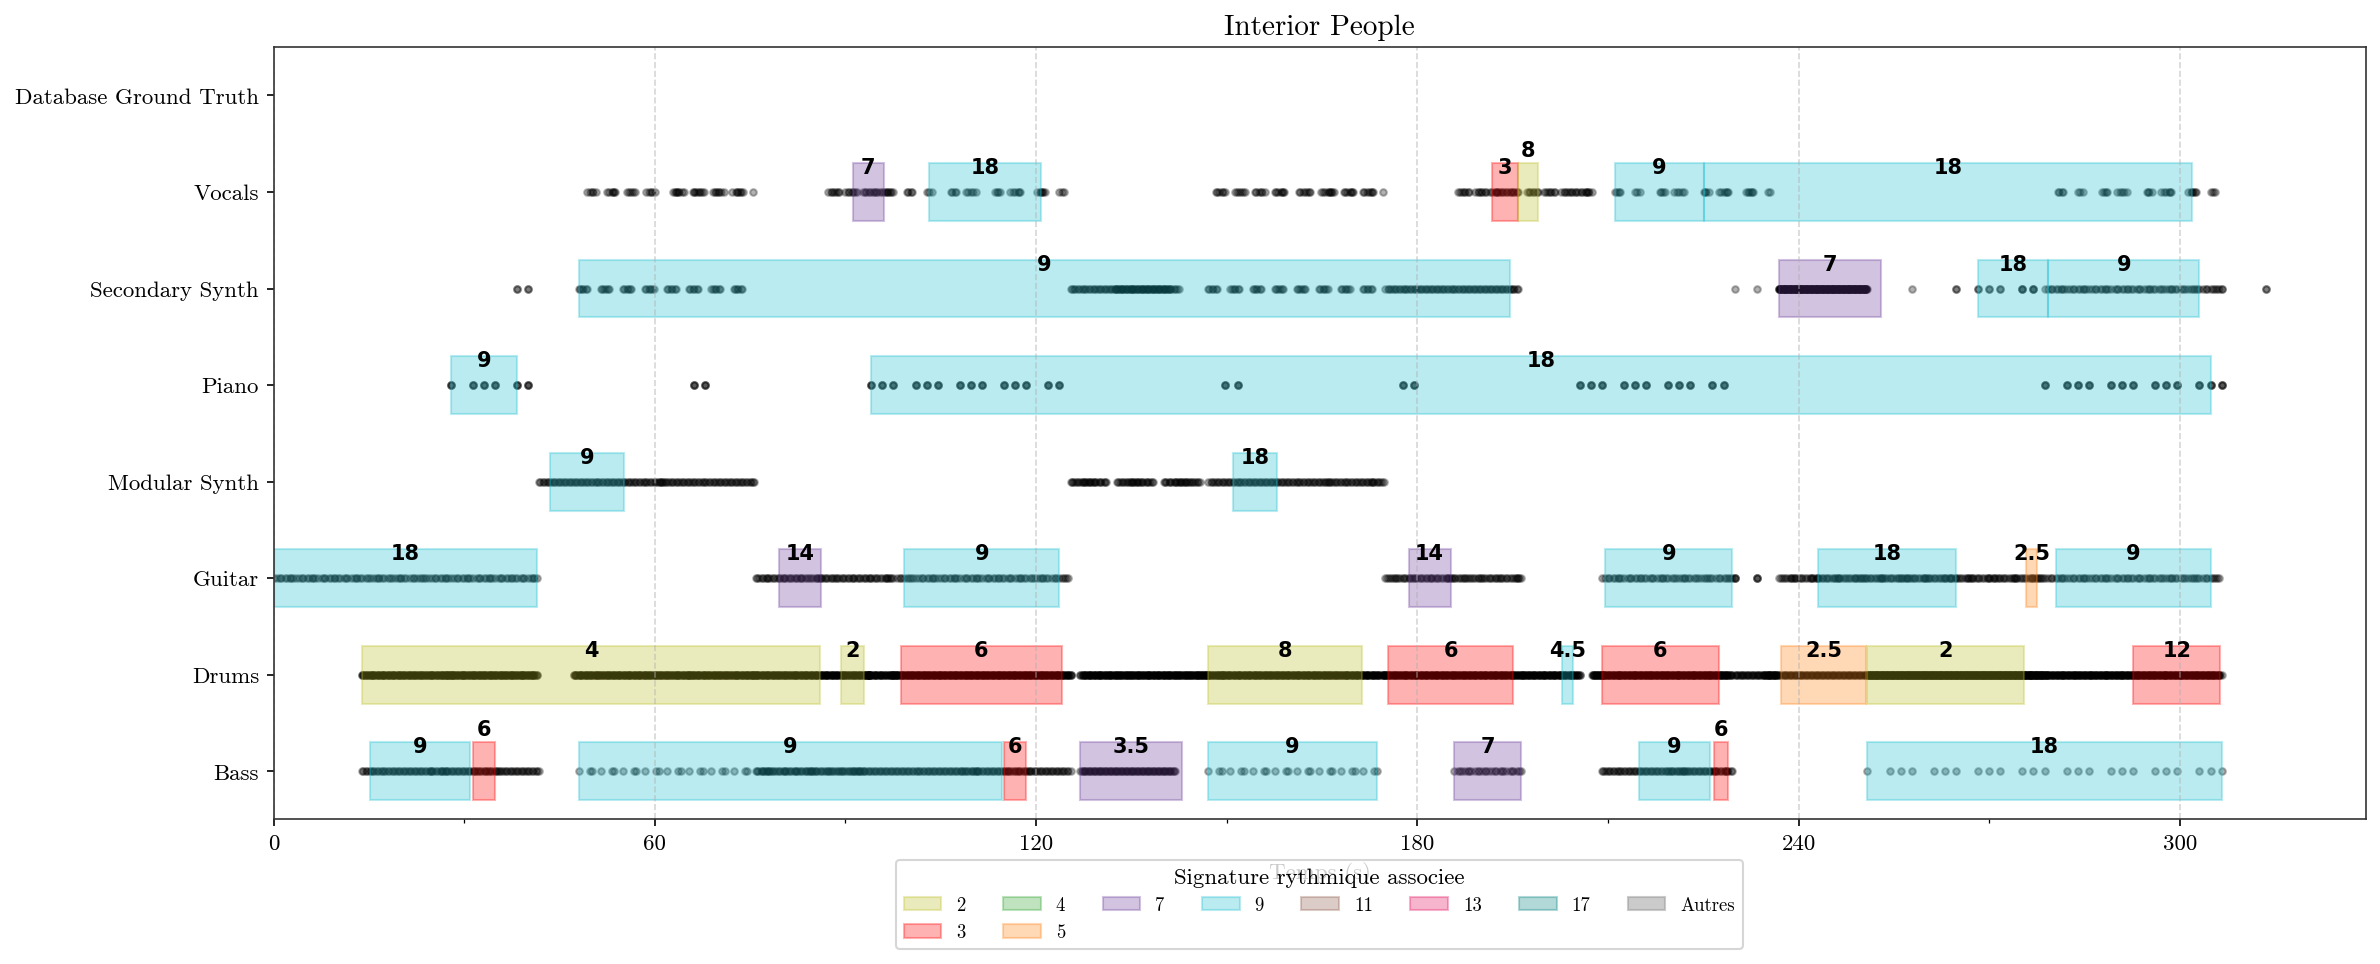

Pourcentage de points perdus : 31.24 %
Nombre de motifs: 80
Global compactness: 2.1046561298590345


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


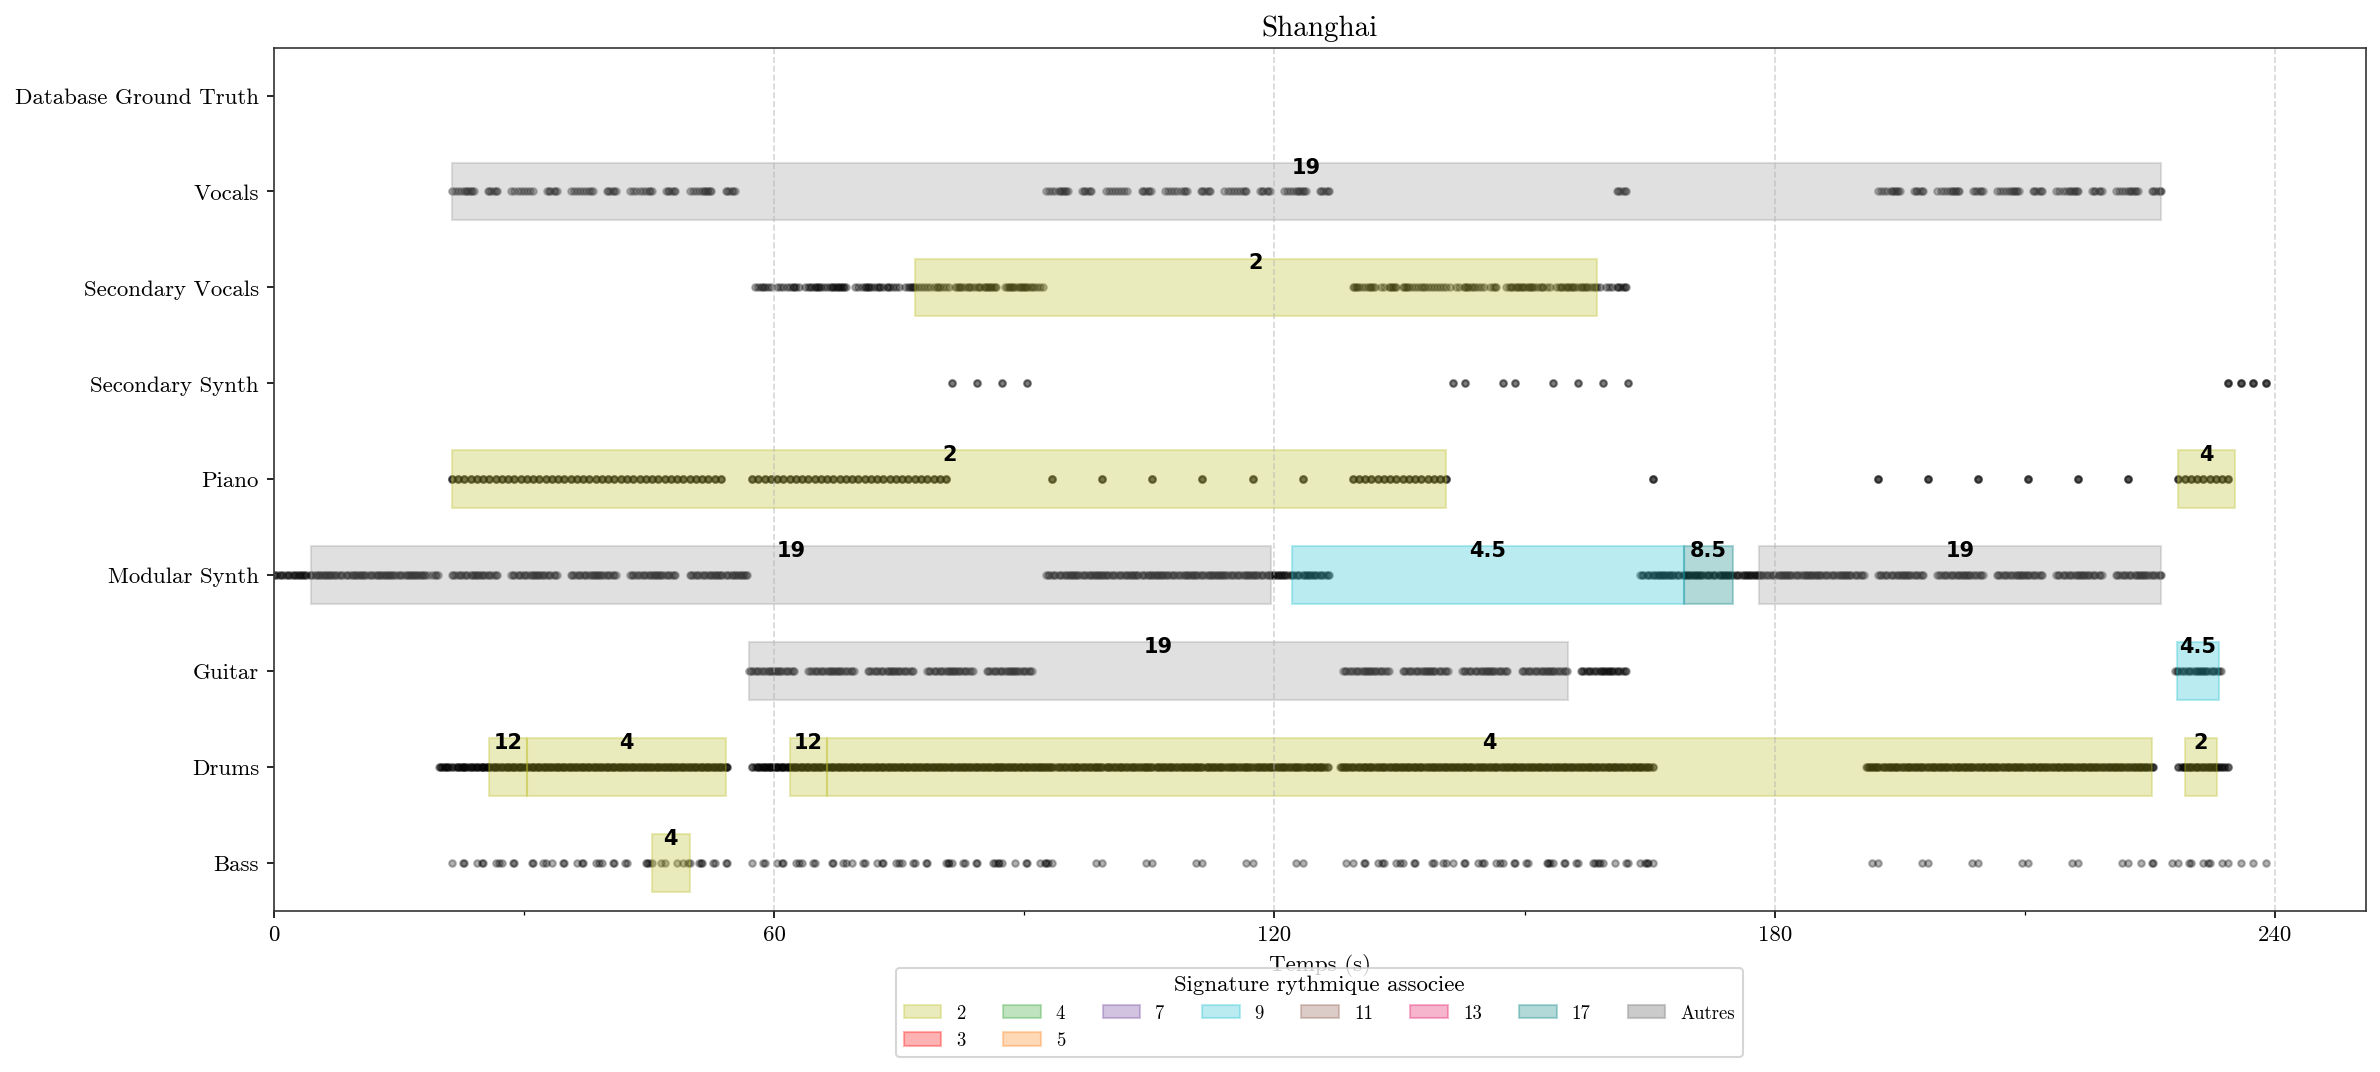

Pourcentage de points perdus : 25.27 %
Nombre de motifs: 59
Global compactness: 2.1927710843373496


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


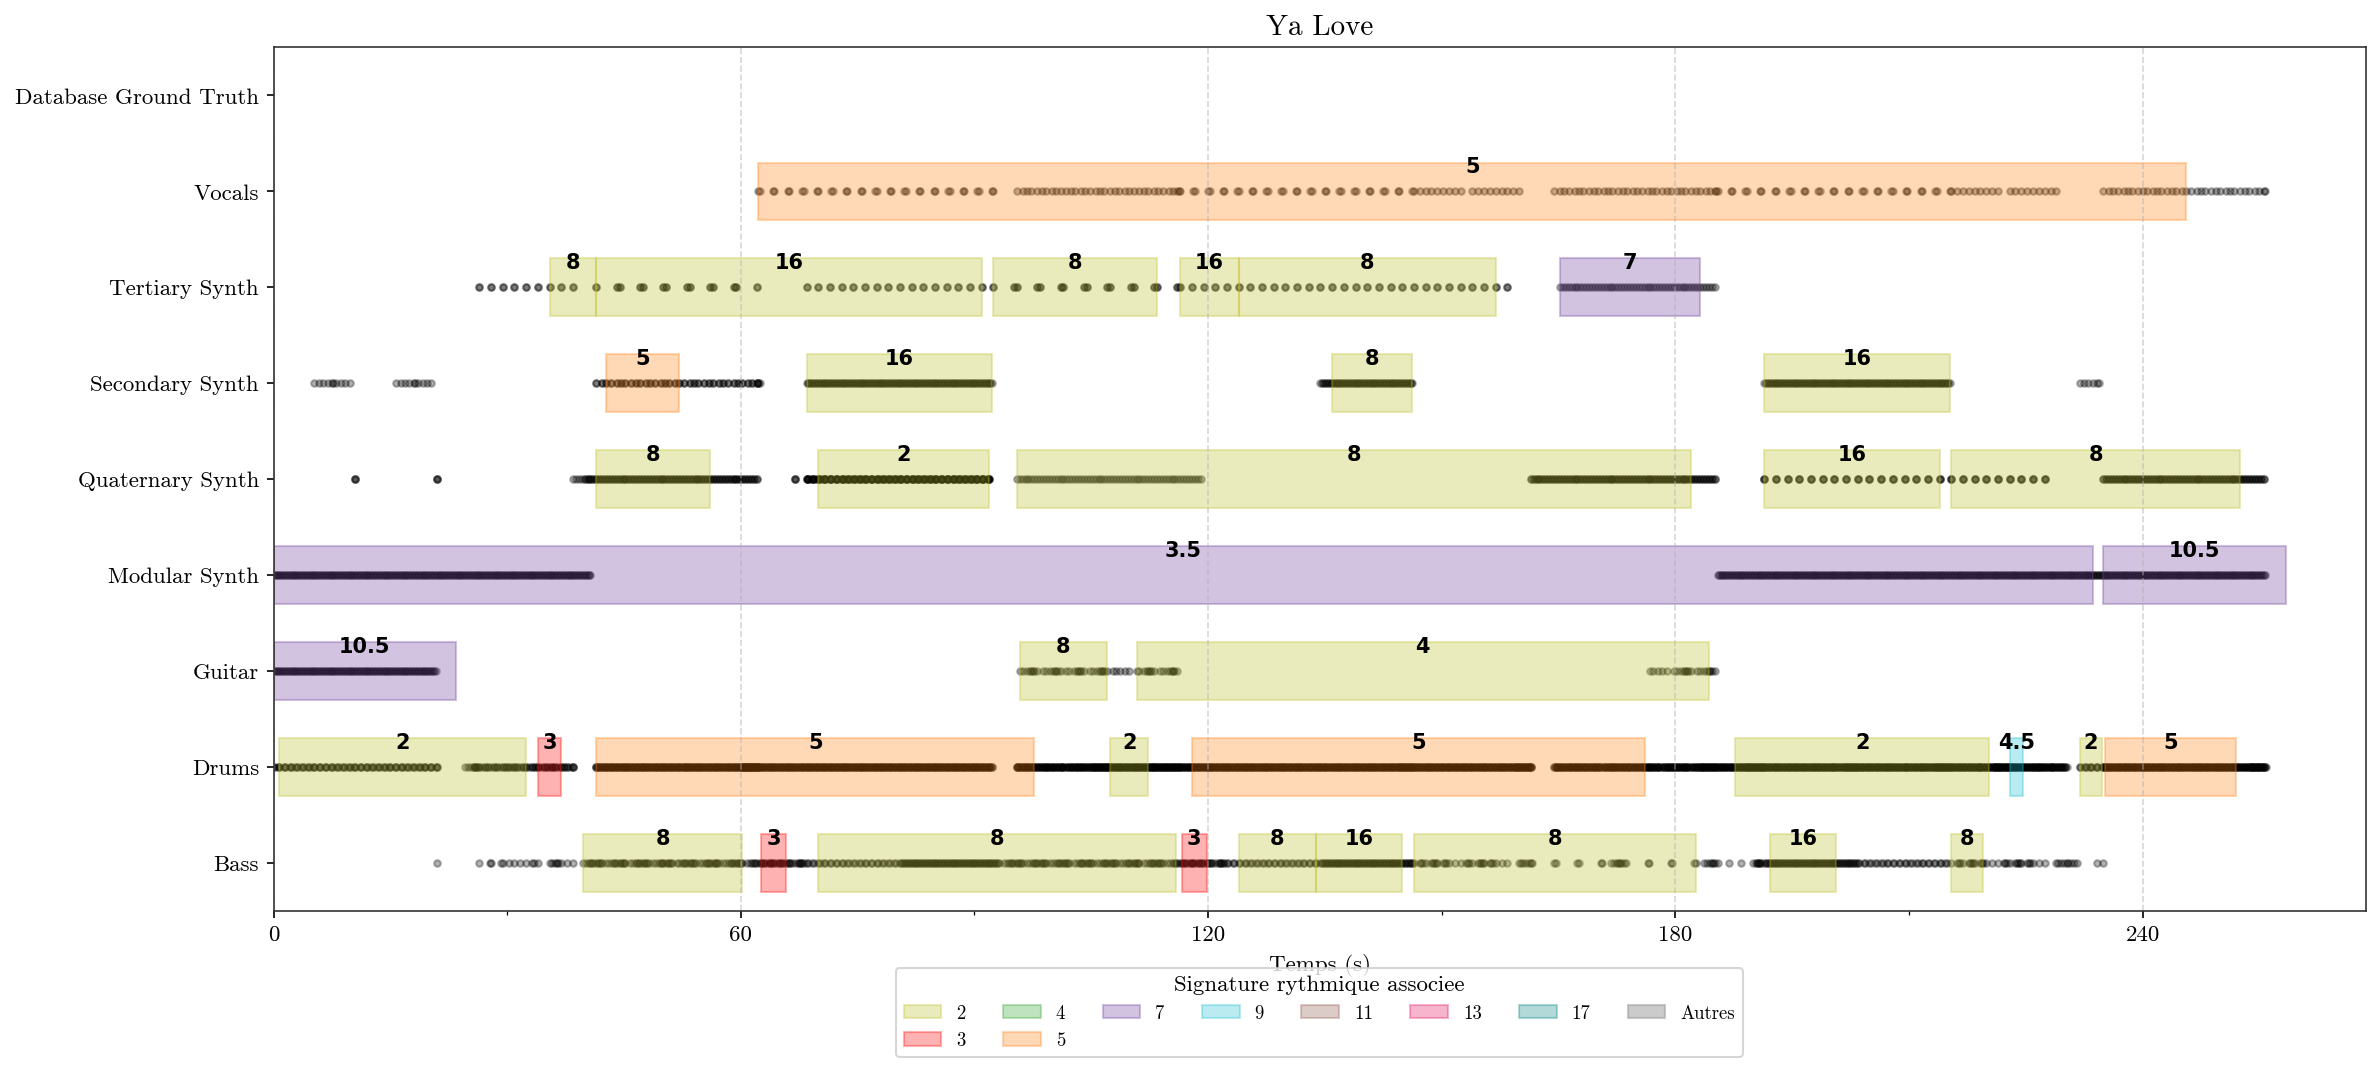

Pourcentage de points perdus : 34.68 %
Nombre de motifs: 113
Global compactness: 1.8272969881814716


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


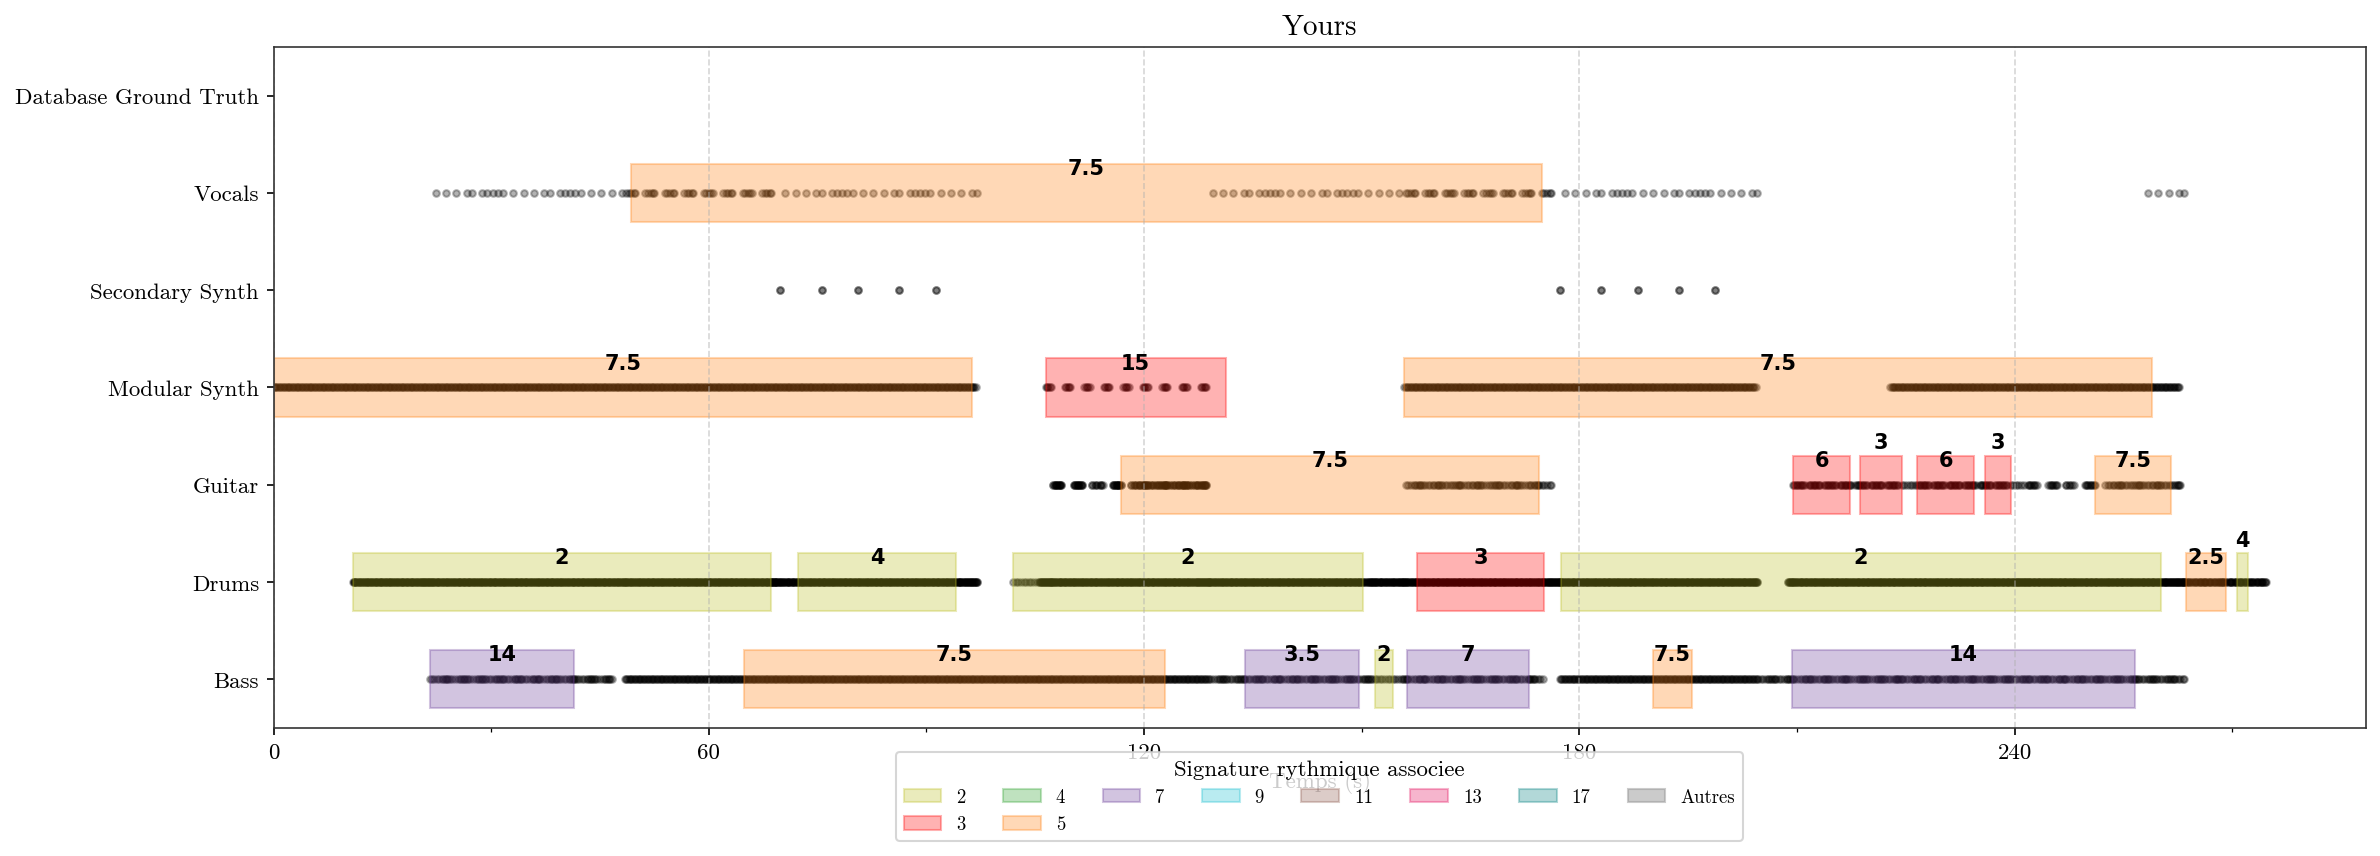

Pourcentage de points perdus : 16.29 %
Nombre de motifs: 81
Global compactness: 3.064018968583284


In [17]:
def process_midi_separating_instruments(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    tempo_changes, tempos = midi_data.get_tempo_changes()
    bpm = tempos[0] if len(tempos) > 0 else Fraction(120)
    seconds_to_beats = bpm / 60
    tatum = Fraction(1, (8 * 3))
    data = []

    for instrument in midi_data.instruments:
        instrument_name = instrument.name if instrument.name else 'Unknown'
        for note in instrument.notes:
            onset_in_beats = note.start * seconds_to_beats
            duration_in_beats = (note.end - note.start) * seconds_to_beats

            rounded_onset = round(onset_in_beats / tatum) * tatum
            rounded_duration = round(duration_in_beats / tatum) * tatum

            onset_value = float(rounded_onset) if rounded_onset.denominator % 3 != 0 else rounded_onset
            duration_value = float(rounded_duration) if rounded_duration.denominator % 3 != 0 else rounded_duration

            data.append({
                'midi_file': os.path.basename(midi_file_path),
                'instrument': instrument_name,
                'pitch': note.pitch,
                'onset': onset_value,
                'duration': duration_value
            })
    return data

def preprocess_midi_folder_to_dict(folder_path):
    dataset = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".mid") or filename.endswith(".midi"):
            file_path = os.path.join(folder_path, filename)
            try:
                midi_data = process_midi_separating_instruments(file_path)
                df = pd.DataFrame(midi_data)
                midi_file = df['midi_file'].iloc[0]

                if midi_file not in dataset:
                    dataset[midi_file] = {}

                for instrument, group in df.groupby('instrument'):
                    if instrument not in dataset[midi_file]:
                        dataset[midi_file][instrument] = []

                    for row in group.itertuples(index=False):
                        onset = Fraction(row.onset) if '/' in str(row.onset) else float(row.onset)
                        dataset[midi_file][instrument].append((onset, row.pitch))

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    return dataset

def get_subsets_with_points(preprocessed_dataset):
    excluded_tracks = {}

    subsets_data = {}
    for track_name, instruments_data in preprocessed_dataset.items():
        track_filename = track_name.split(" - ")[-1]
        for instrument_name, points in instruments_data.items():
            subset_name = f"{track_filename}_{instrument_name}"
            if subset_name not in excluded_tracks:
                subsets_data[subset_name] = points
    return subsets_data

# 👇 Usage:
midi_folder_path_bf3k = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Butterfly3000_MIDI"
preprocessed_dataset_bf3k = preprocess_midi_folder_to_dict(midi_folder_path_bf3k)
subsets_data_bf3k = get_subsets_with_points(preprocessed_dataset_bf3k)
ground_truth_df_bf3k = check_time_signature_presence(midi_folder_path_bf3k)

# 1. Get all unique track names (without instruments)
track_names = {
    "_".join(k.split("_")[:-1])  # Remove last segment (instrument name)
    for k in subsets_data_bf3k
}

# 2. Convert to sorted list
pieces_name = sorted(track_names)

# 3. Plot each unique piece
for piece in pieces_name:
    plot_metric_sections_by_best_compactness(subsets_data_bf3k, piece, pattern_detection, dilation, ground_truth_df_bf3k, Lmax=20)

## On Beatles tracks

/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

Pieces name: ['Beatles-yellow_submarine-1966.mid', 'beatles-a_taste_of_honey_3.4-1963.mid', 'beatles-all_my_loving-1963.mid', 'beatles-boys-1963.mid', 'beatles-chains-1963.mid', 'beatles-devil_in_her_heart-1963.mid', 'beatles-do_you_want_to_know_a_secret-1963.mid', 'beatles-dont_bother_me-1963.mid', 'beatles-hold_me_tight-1963.mid', 'beatles-i_saw_her_standing_ther-1963.mid', 'beatles-i_wanna_be_your_man-1963.mid', 'beatles-it_wont_be_long-1963.mid', 'beatles-let_it_be-1970.mid', 'beatles-misery-1963.mid', 'beatles-please_please_me-1963.mid', 'beatles-roll_over_beethoven-1963.mid', 'beatles-you_really_got_a_hold_on_me-1963.mid']


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


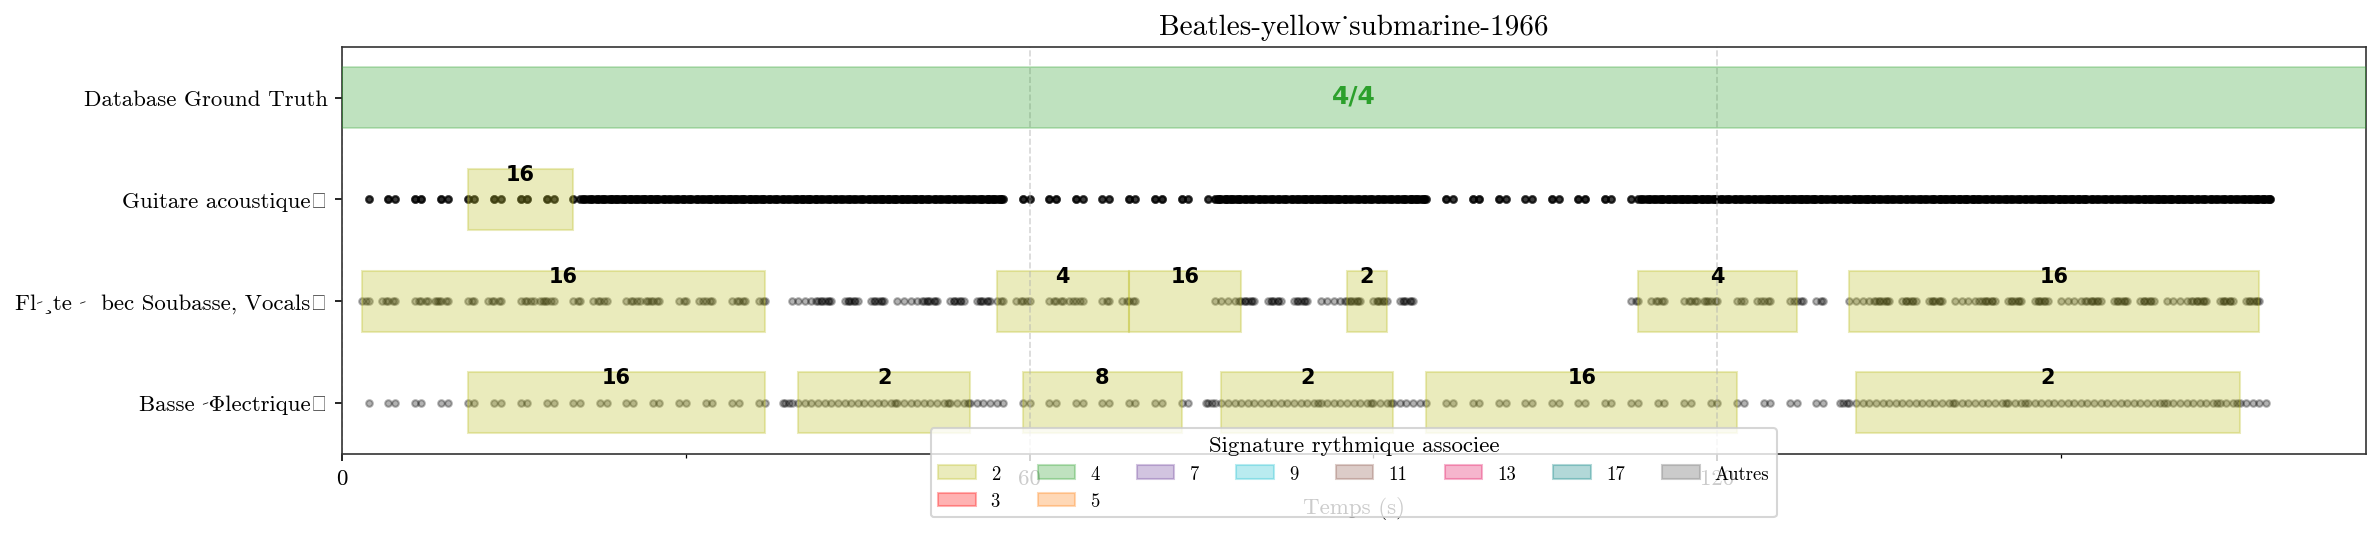

Pourcentage de points perdus : 86.85 %
Nombre de motifs: 24
Global compactness: 1.0956036287508724


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


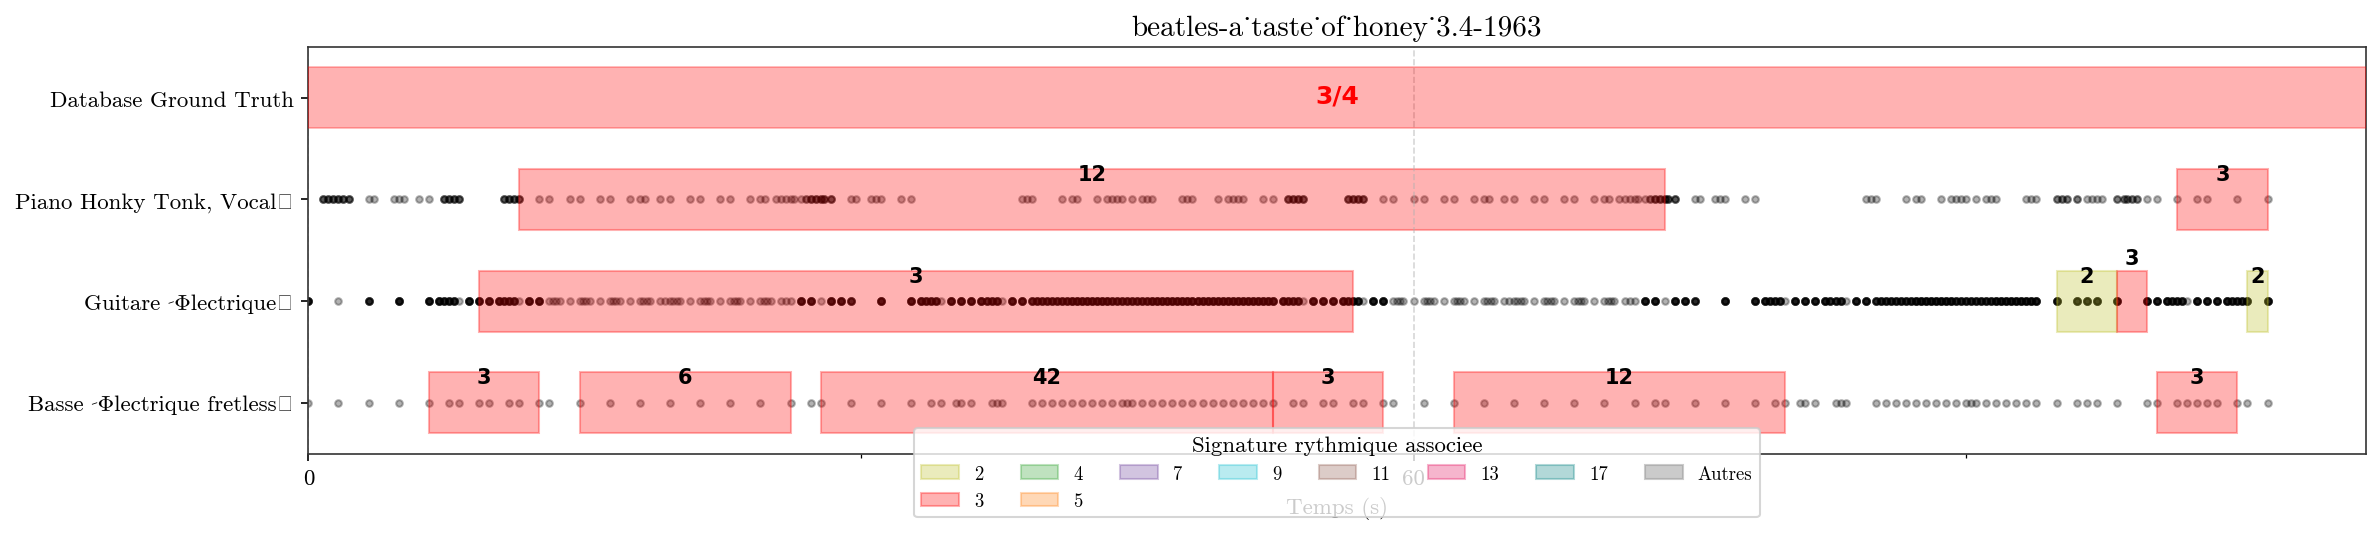

Pourcentage de points perdus : 84.73 %
Nombre de motifs: 18
Global compactness: 1.0980720871751886


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


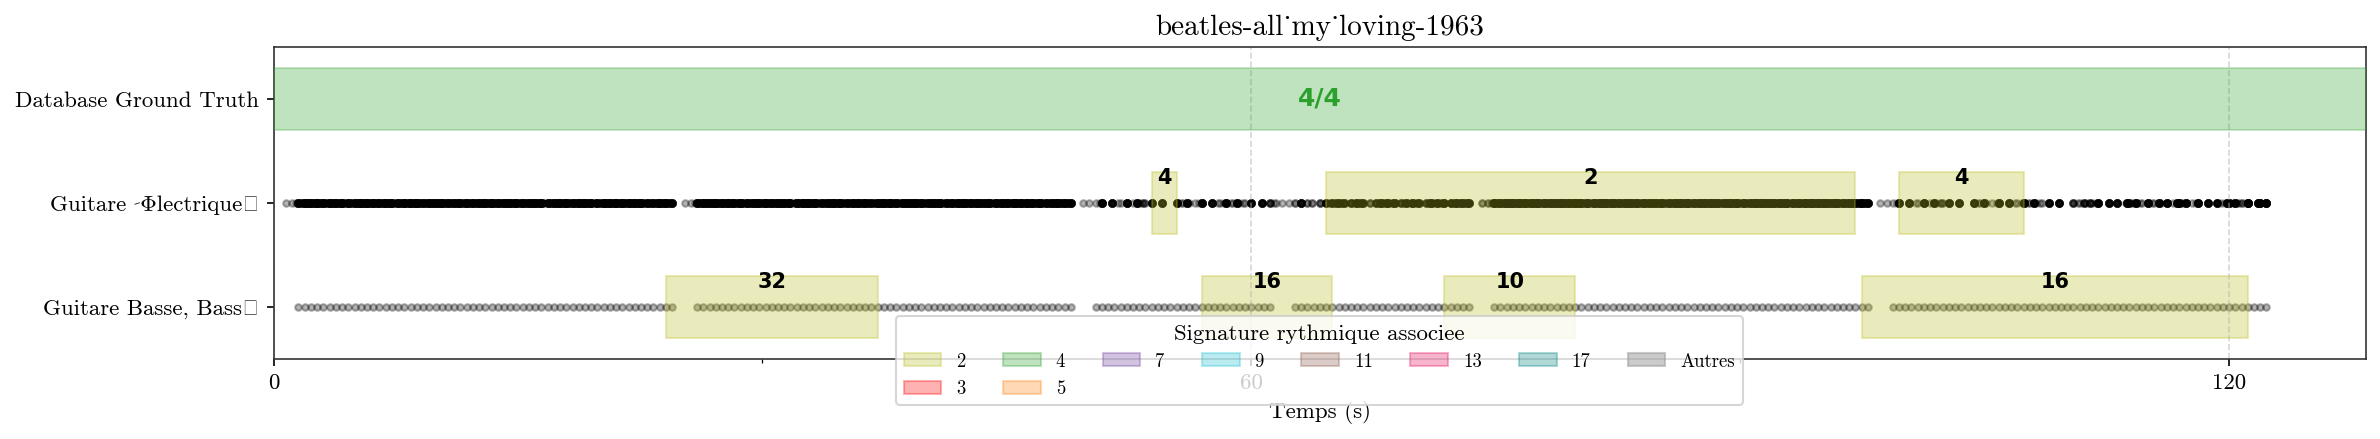

Pourcentage de points perdus : 93.38 %
Nombre de motifs: 18
Global compactness: 1.038083903600119


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


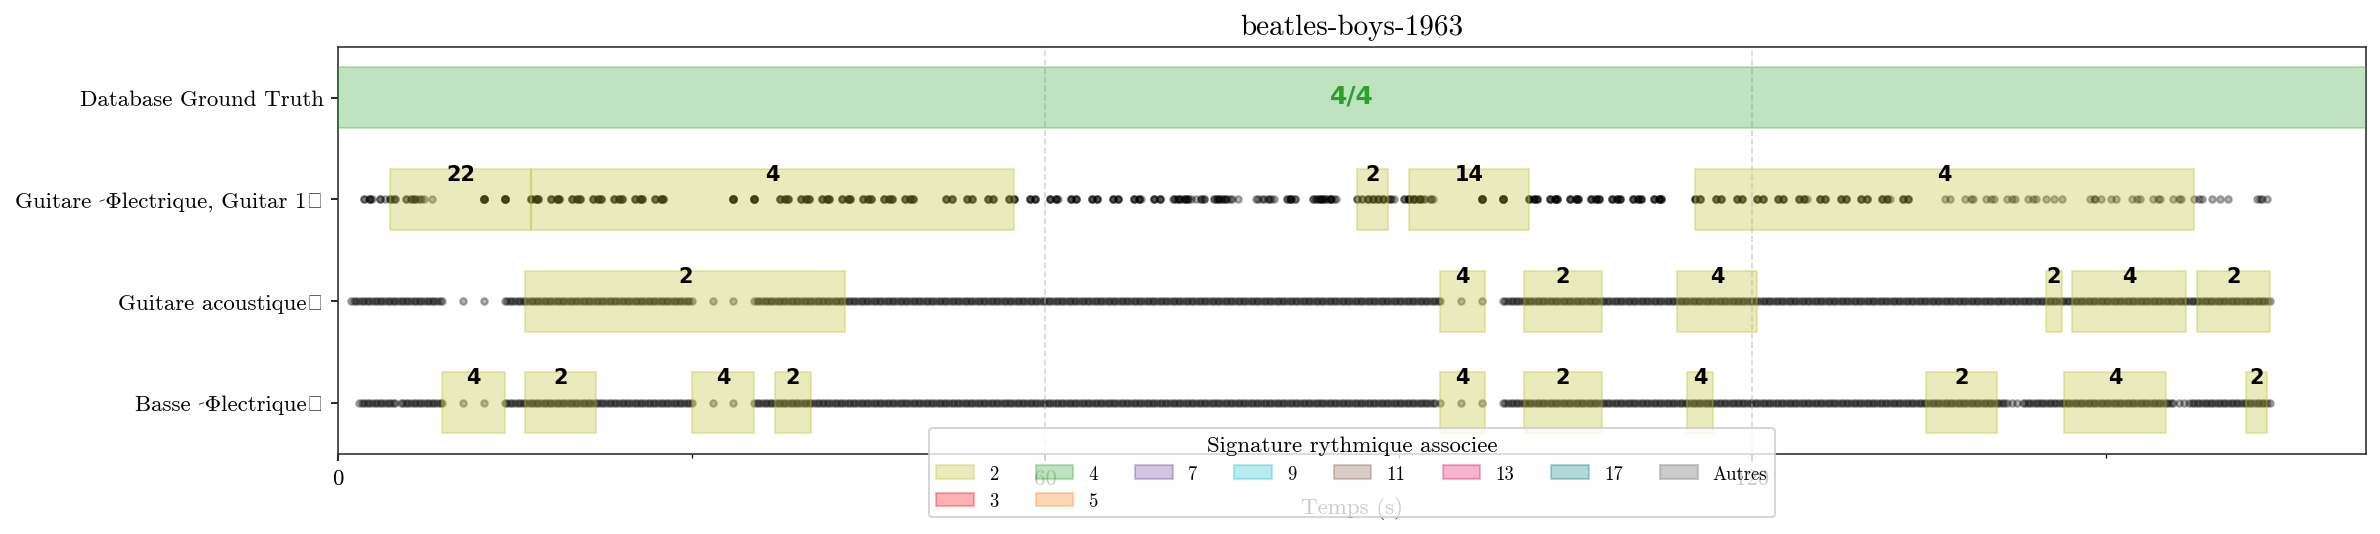

Pourcentage de points perdus : 80.81 %
Nombre de motifs: 38
Global compactness: 1.0892282958199357


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


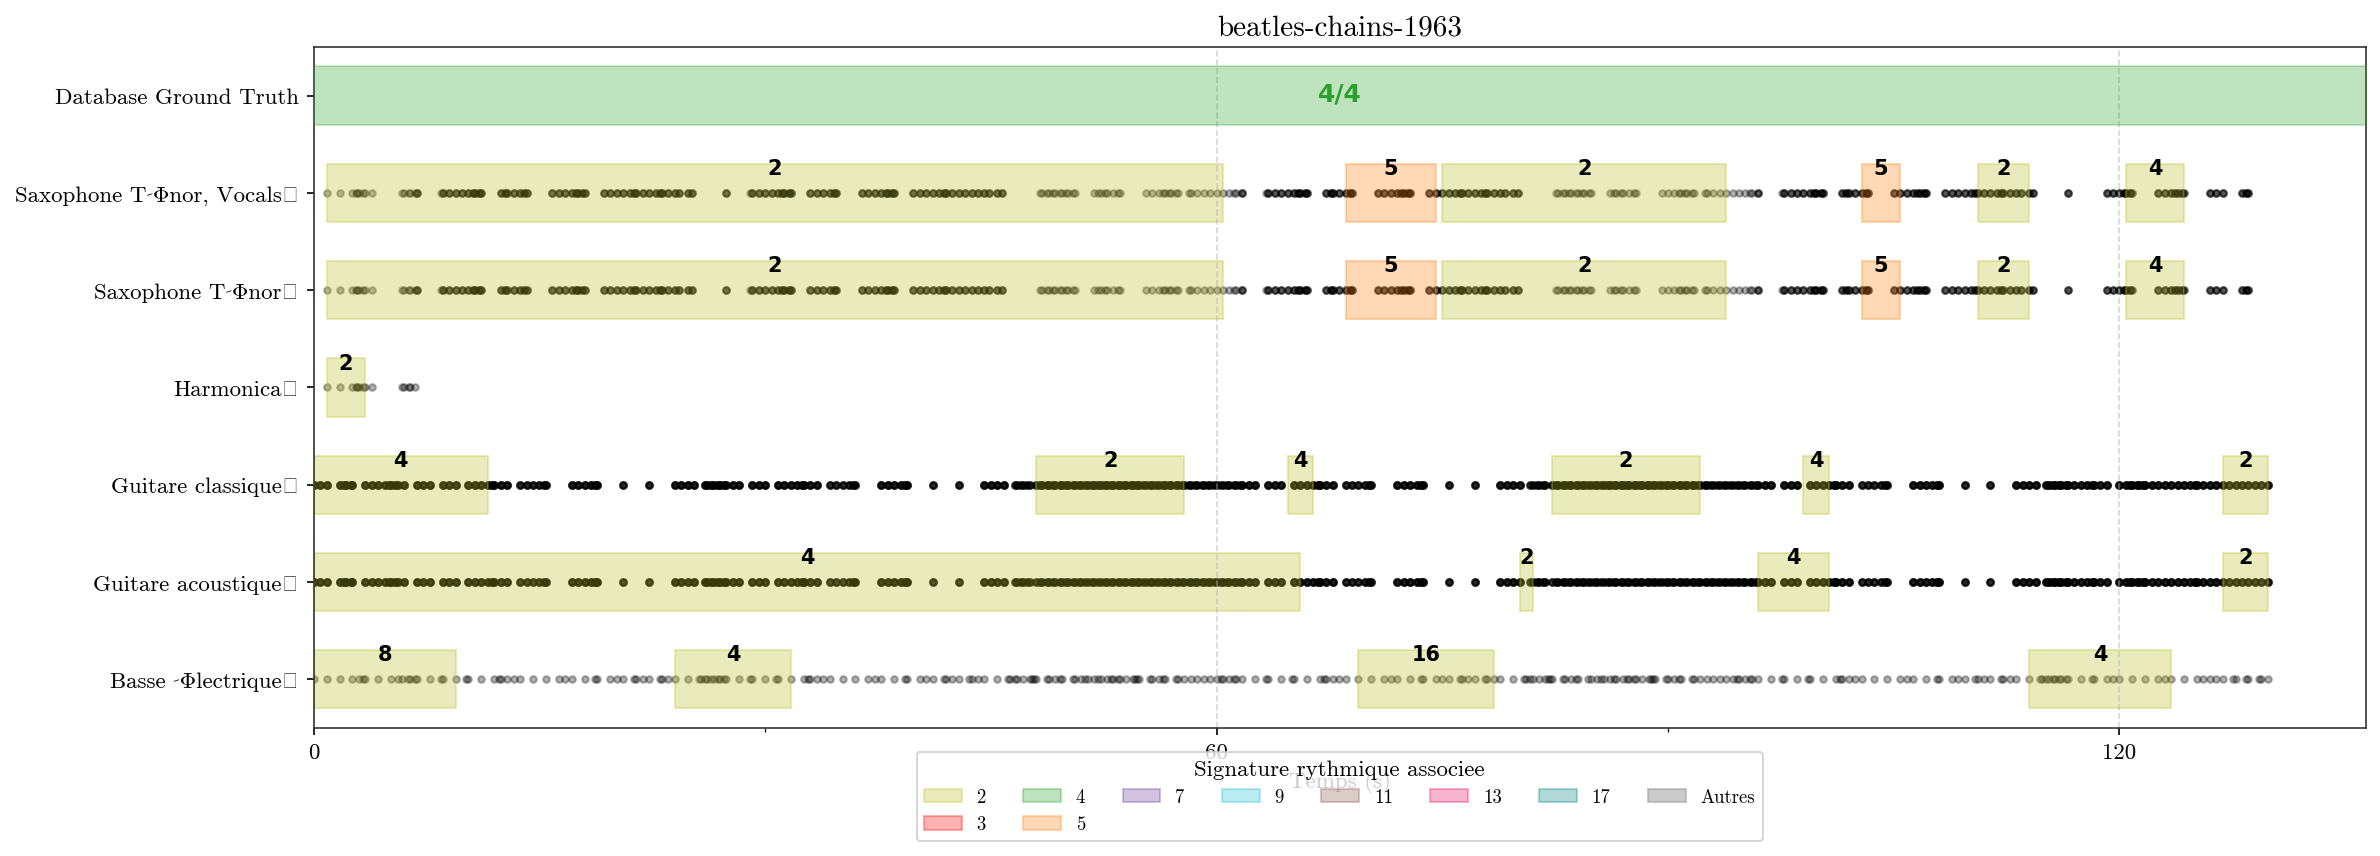

Pourcentage de points perdus : 74.49 %
Nombre de motifs: 67
Global compactness: 1.093255620316403


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 226 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX}) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 153 (\x99) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 226 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX}) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 153 (\x99) mi

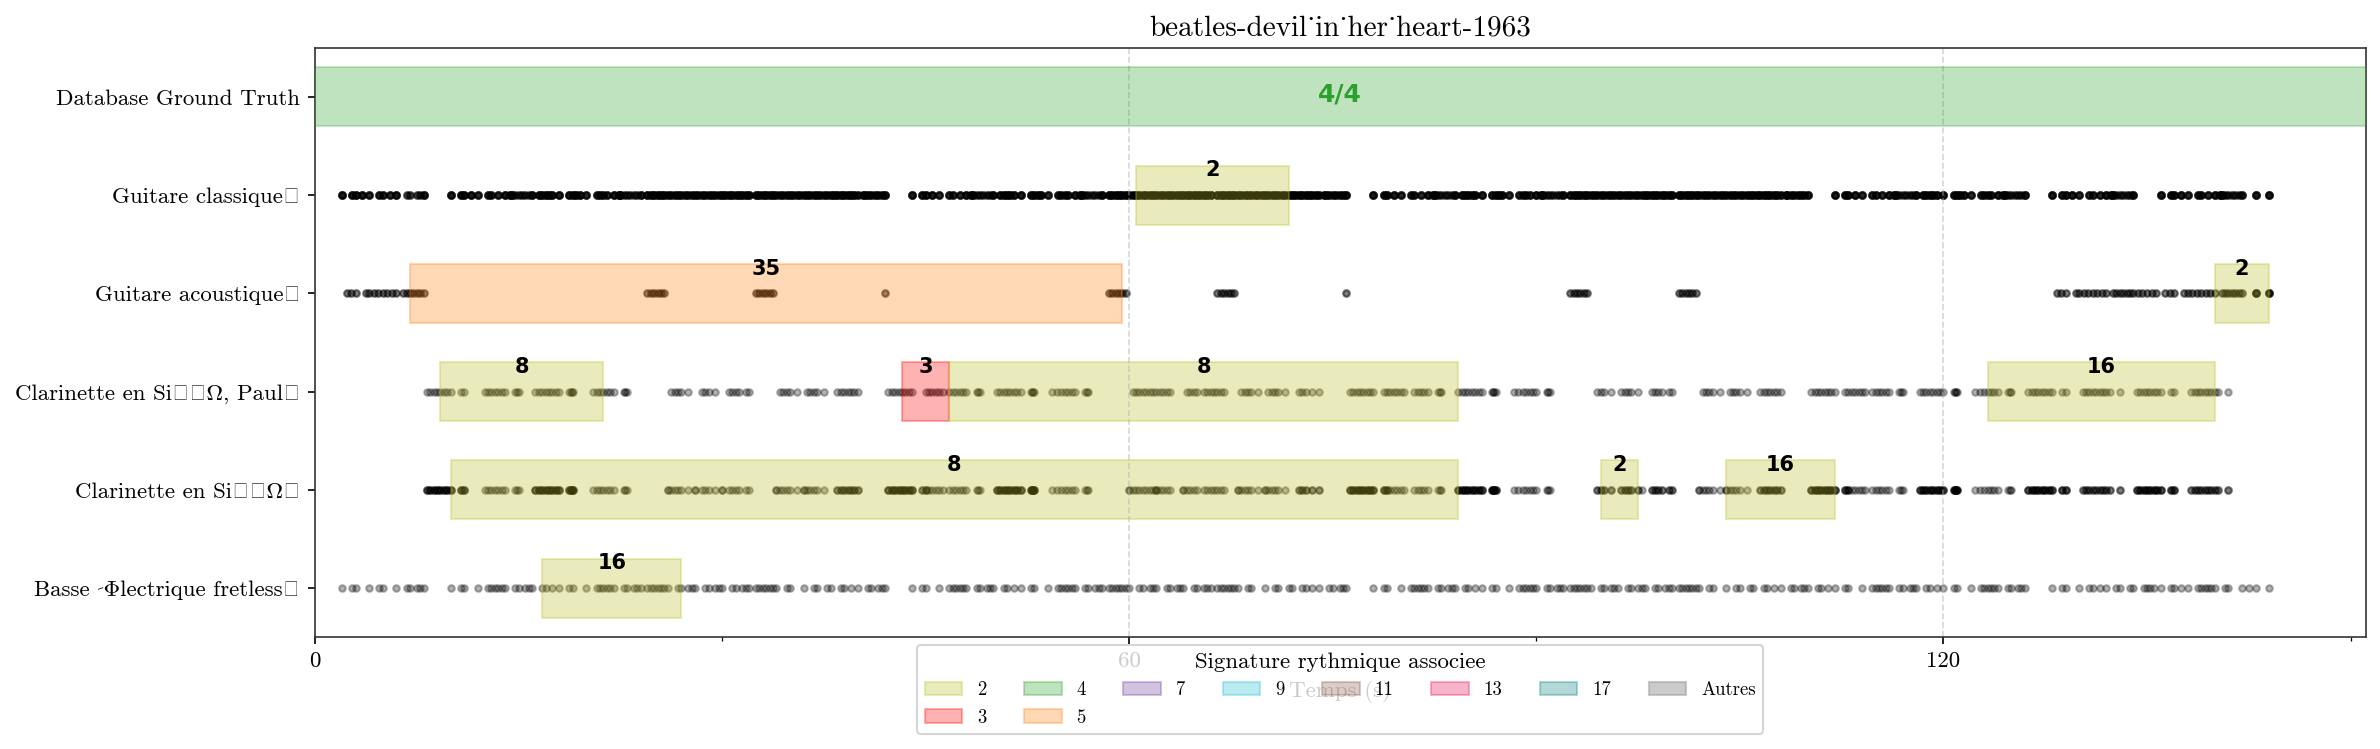

Pourcentage de points perdus : 89.78 %
Nombre de motifs: 18
Global compactness: 1.058802177858439


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


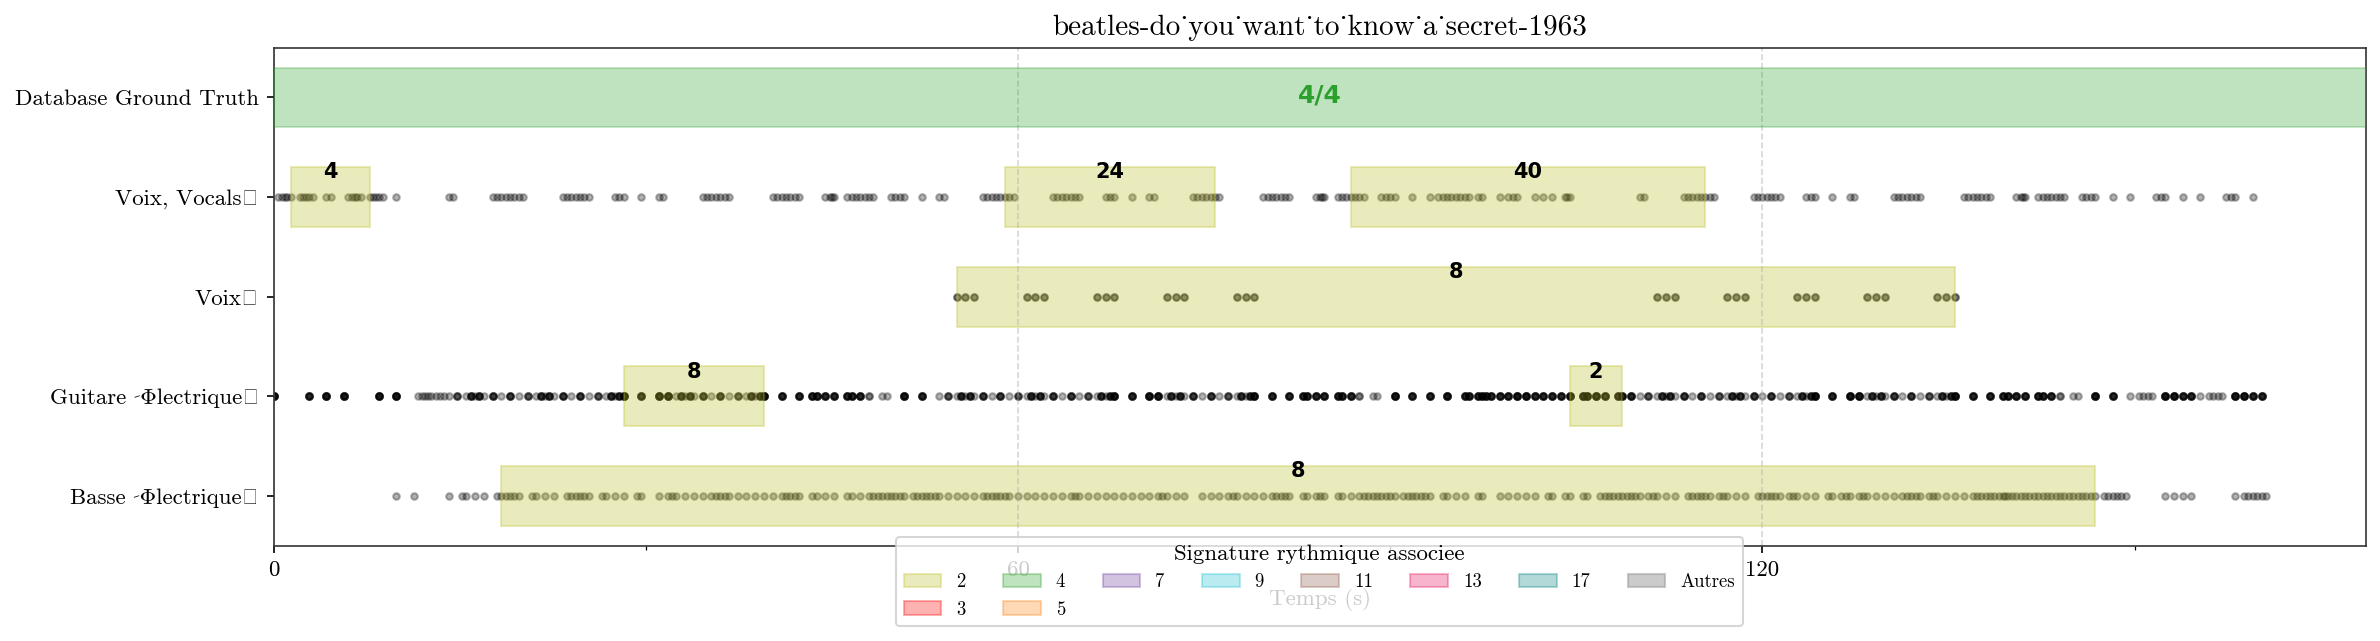

Pourcentage de points perdus : 79.15 %
Nombre de motifs: 15
Global compactness: 1.168615984405458


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


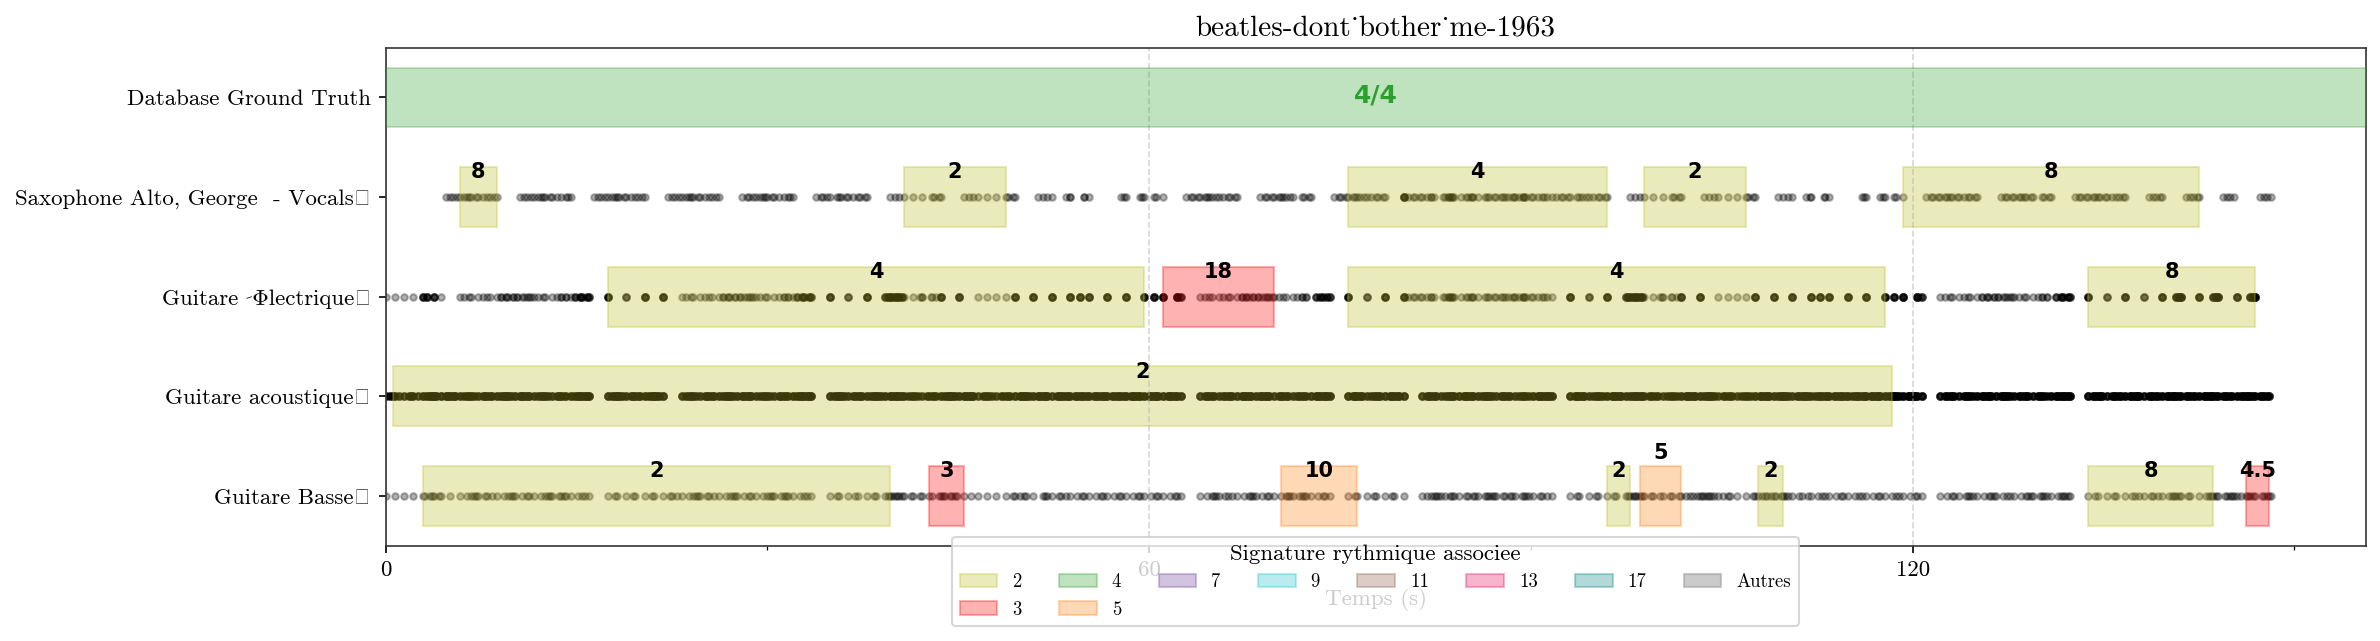

Pourcentage de points perdus : 85.46 %
Nombre de motifs: 49
Global compactness: 1.0951255539143279


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


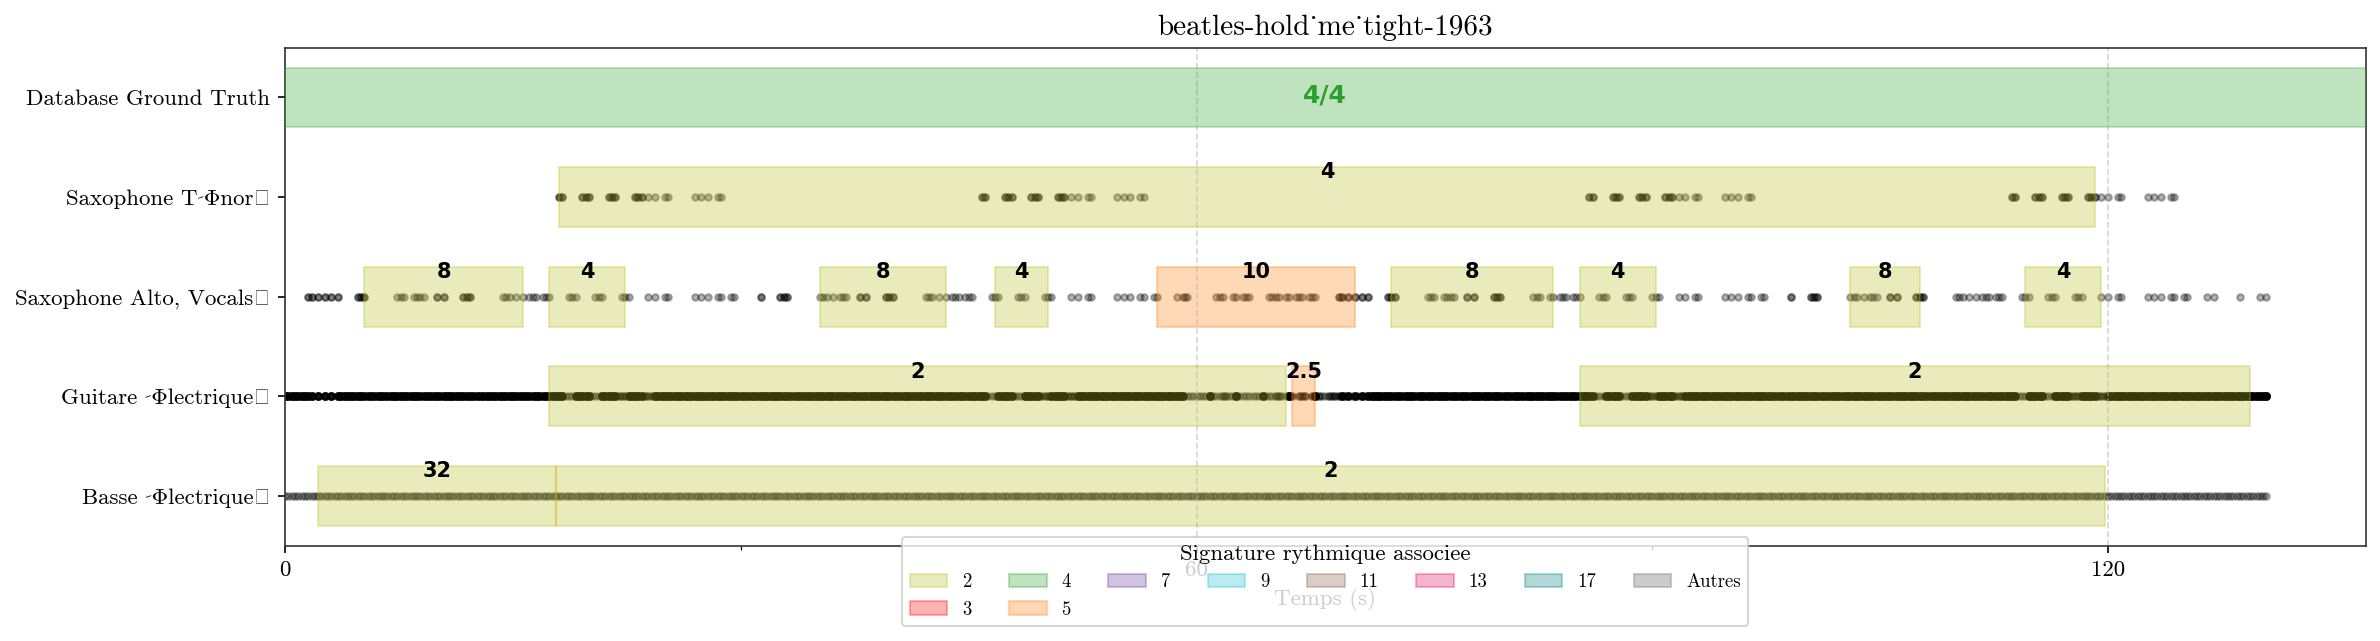

Pourcentage de points perdus : 87.42 %
Nombre de motifs: 33
Global compactness: 1.0894399554193368


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


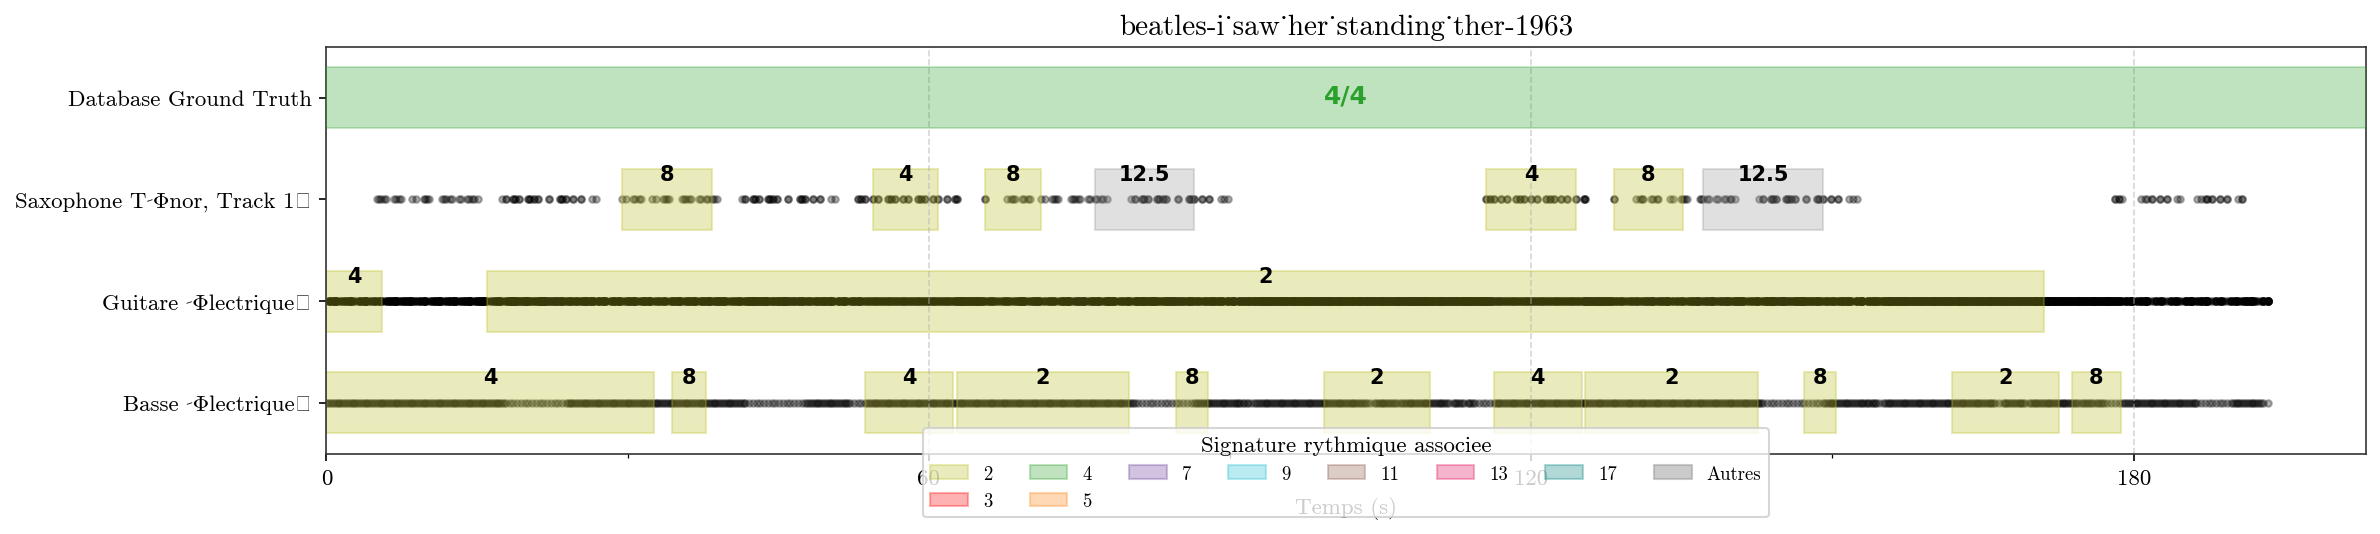

Pourcentage de points perdus : 77.72 %
Nombre de motifs: 50
Global compactness: 1.1785363457760314


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


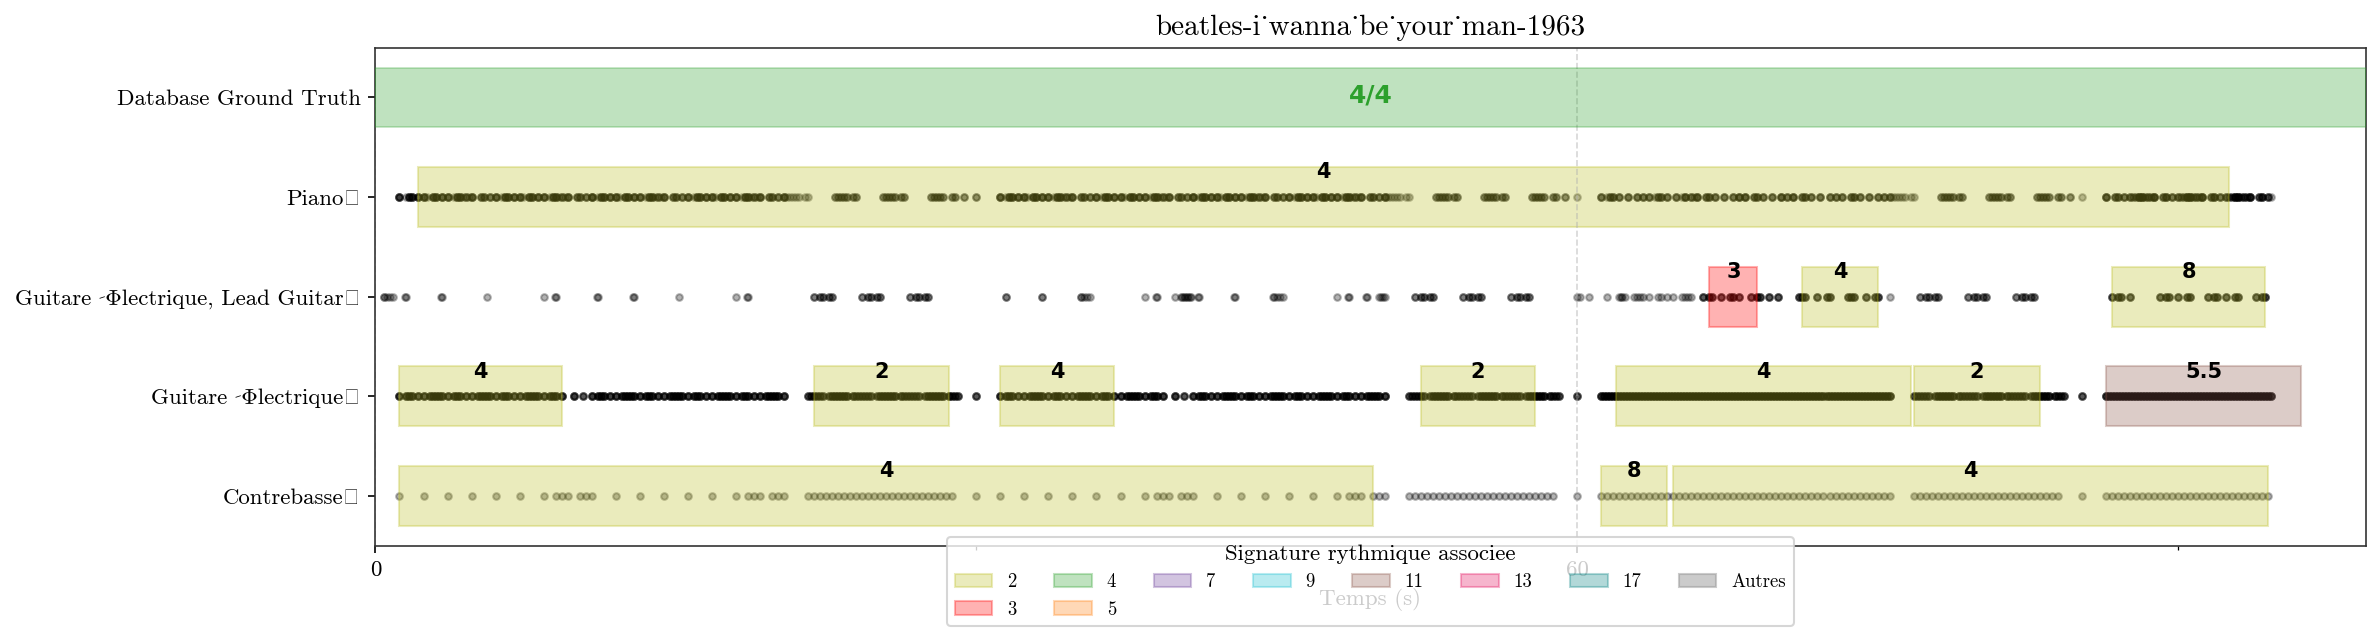

Pourcentage de points perdus : 52.67 %
Nombre de motifs: 44
Global compactness: 1.4202822791427079


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


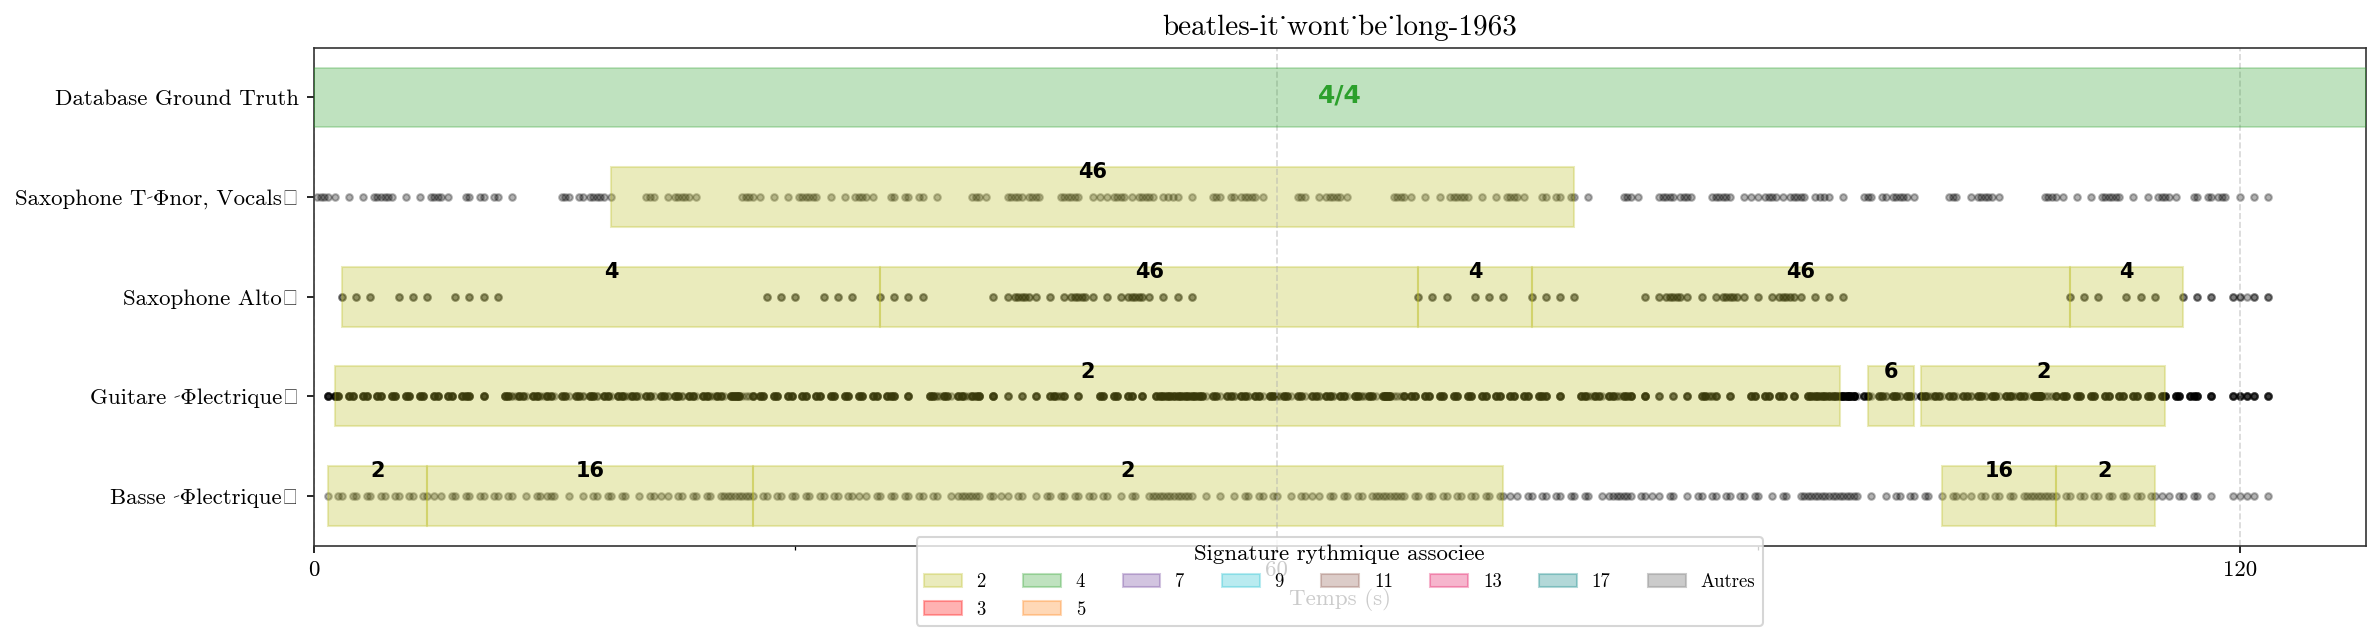

Pourcentage de points perdus : 63.17 %
Nombre de motifs: 56
Global compactness: 1.2565274151436032


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


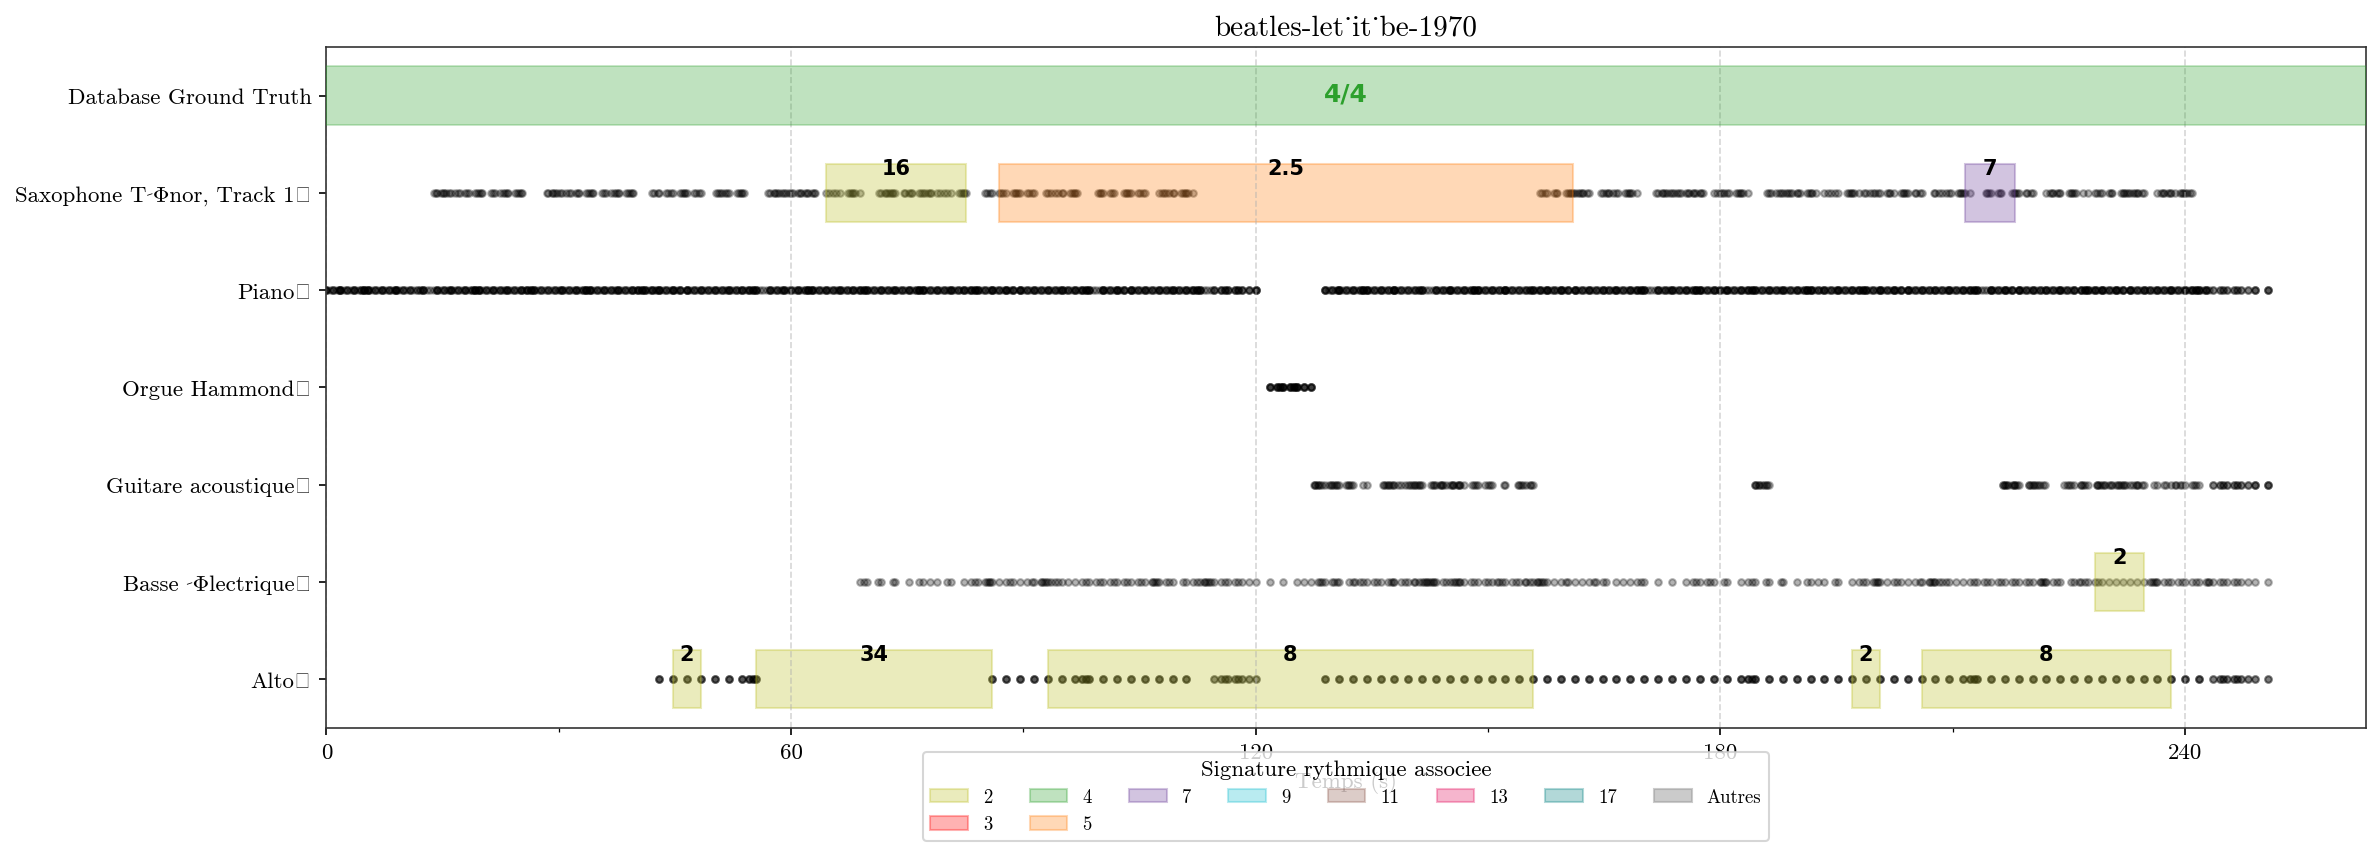

Pourcentage de points perdus : 92.33 %
Nombre de motifs: 18
Global compactness: 1.0360799609946367


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


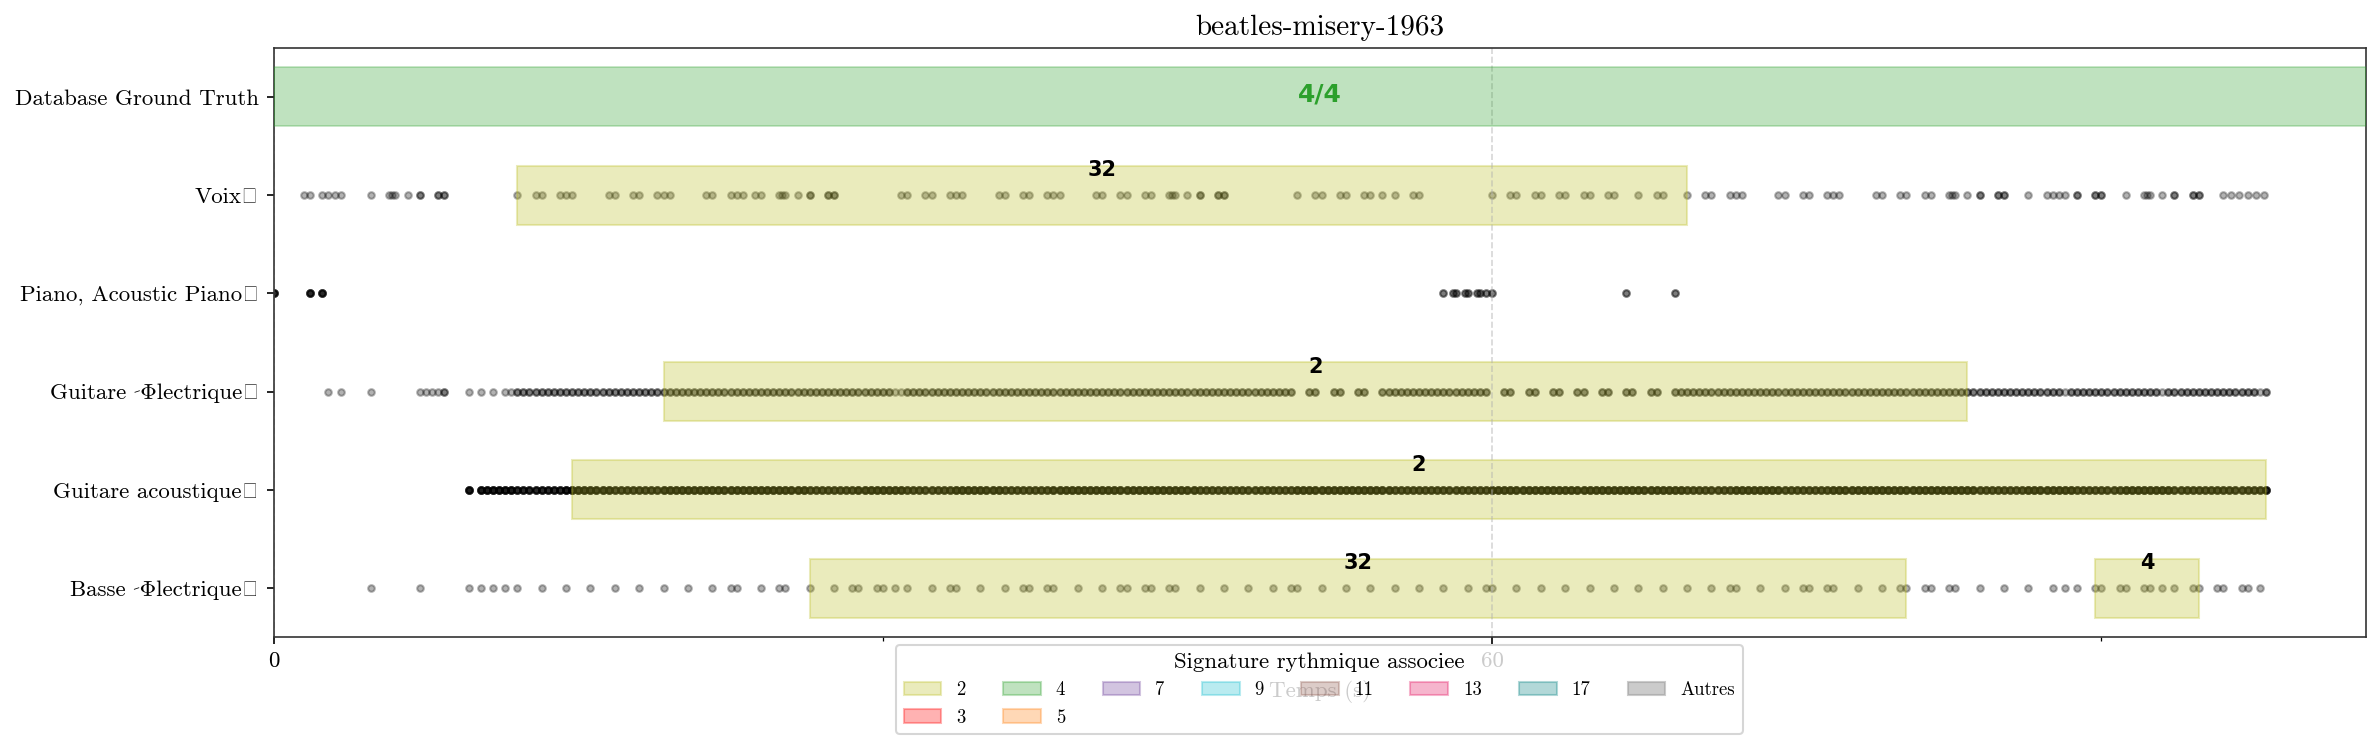

Pourcentage de points perdus : 66.80 %
Nombre de motifs: 23
Global compactness: 1.2872964169381107


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 226 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX}) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 153 (\x99) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 226 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX}) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 153 (\x99) mi

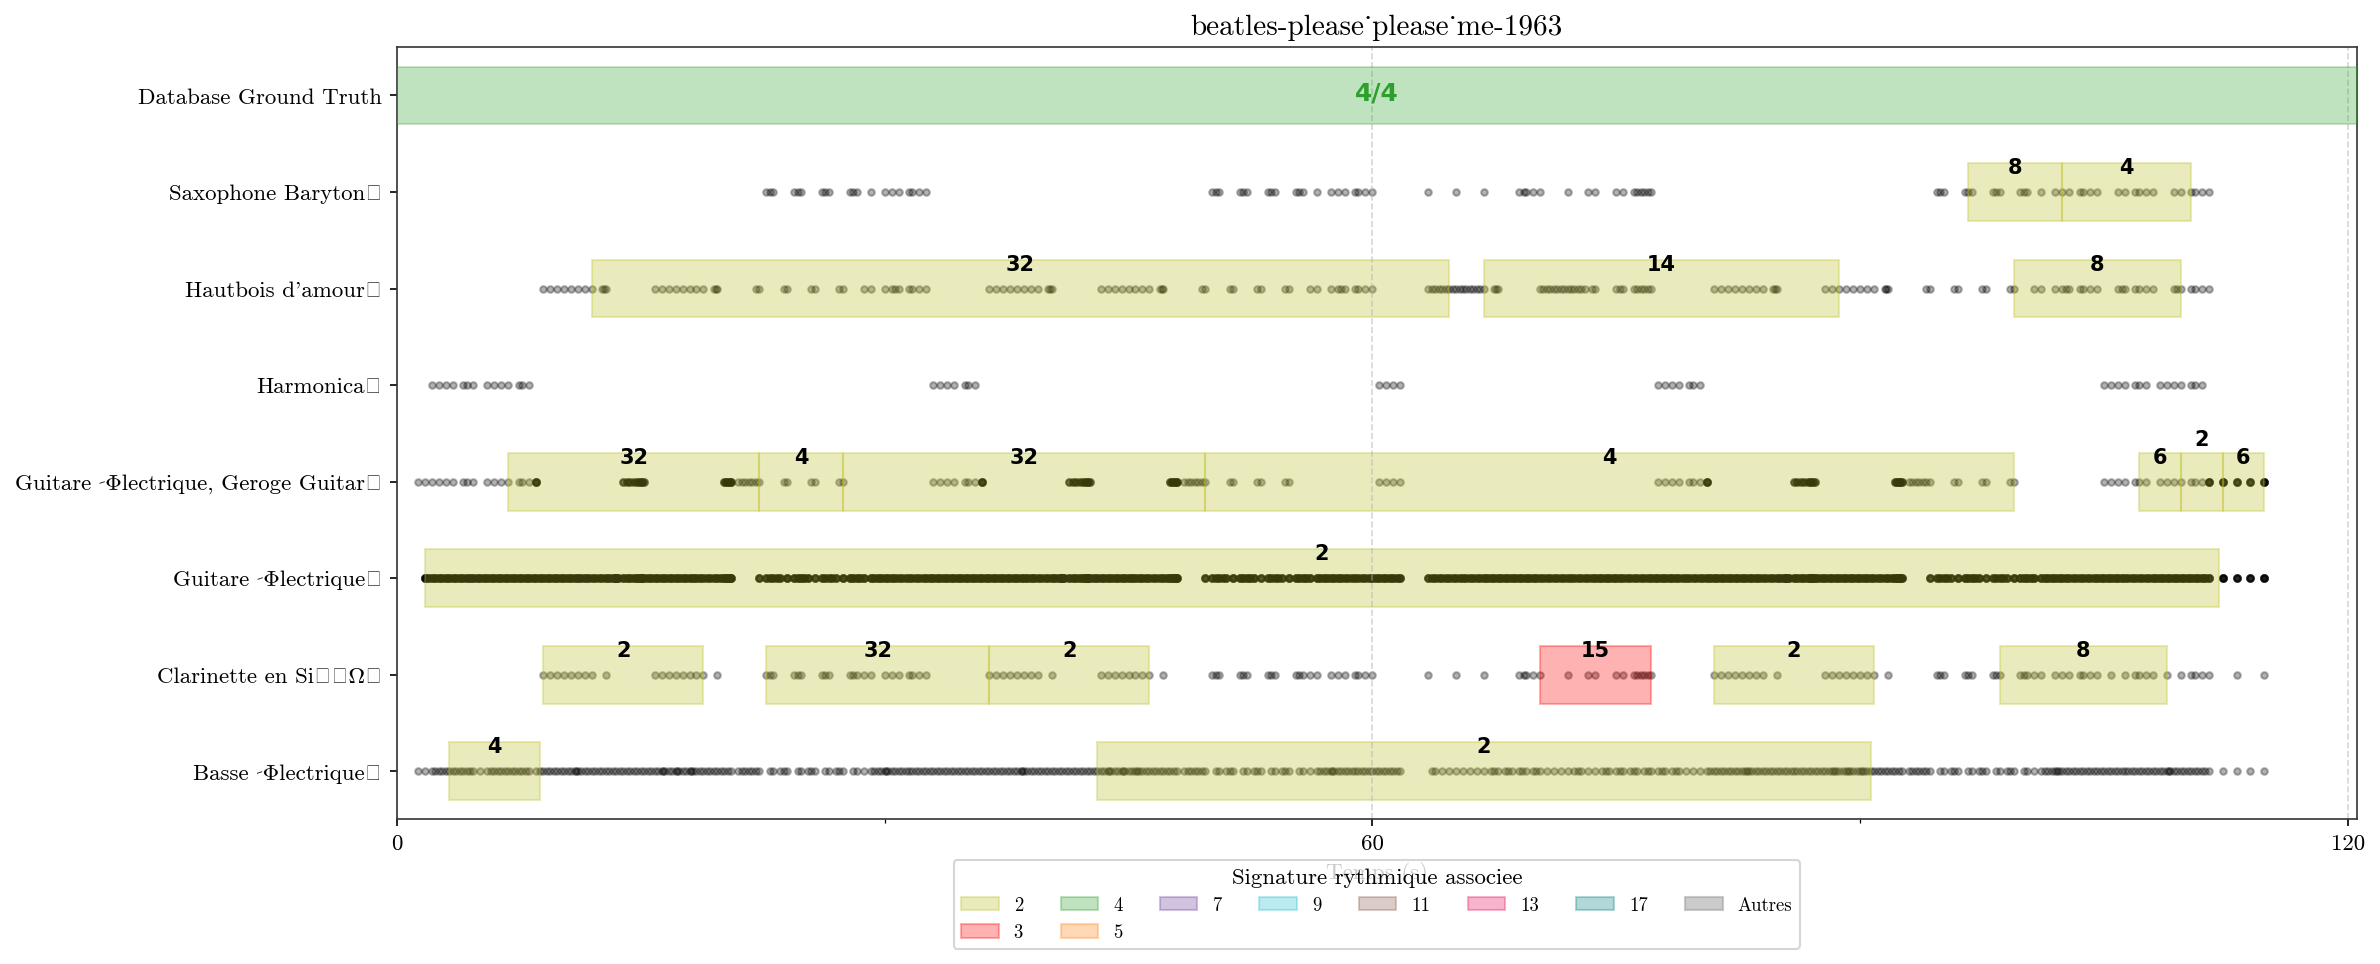

Pourcentage de points perdus : 67.18 %
Nombre de motifs: 40
Global compactness: 1.2967032967032968


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


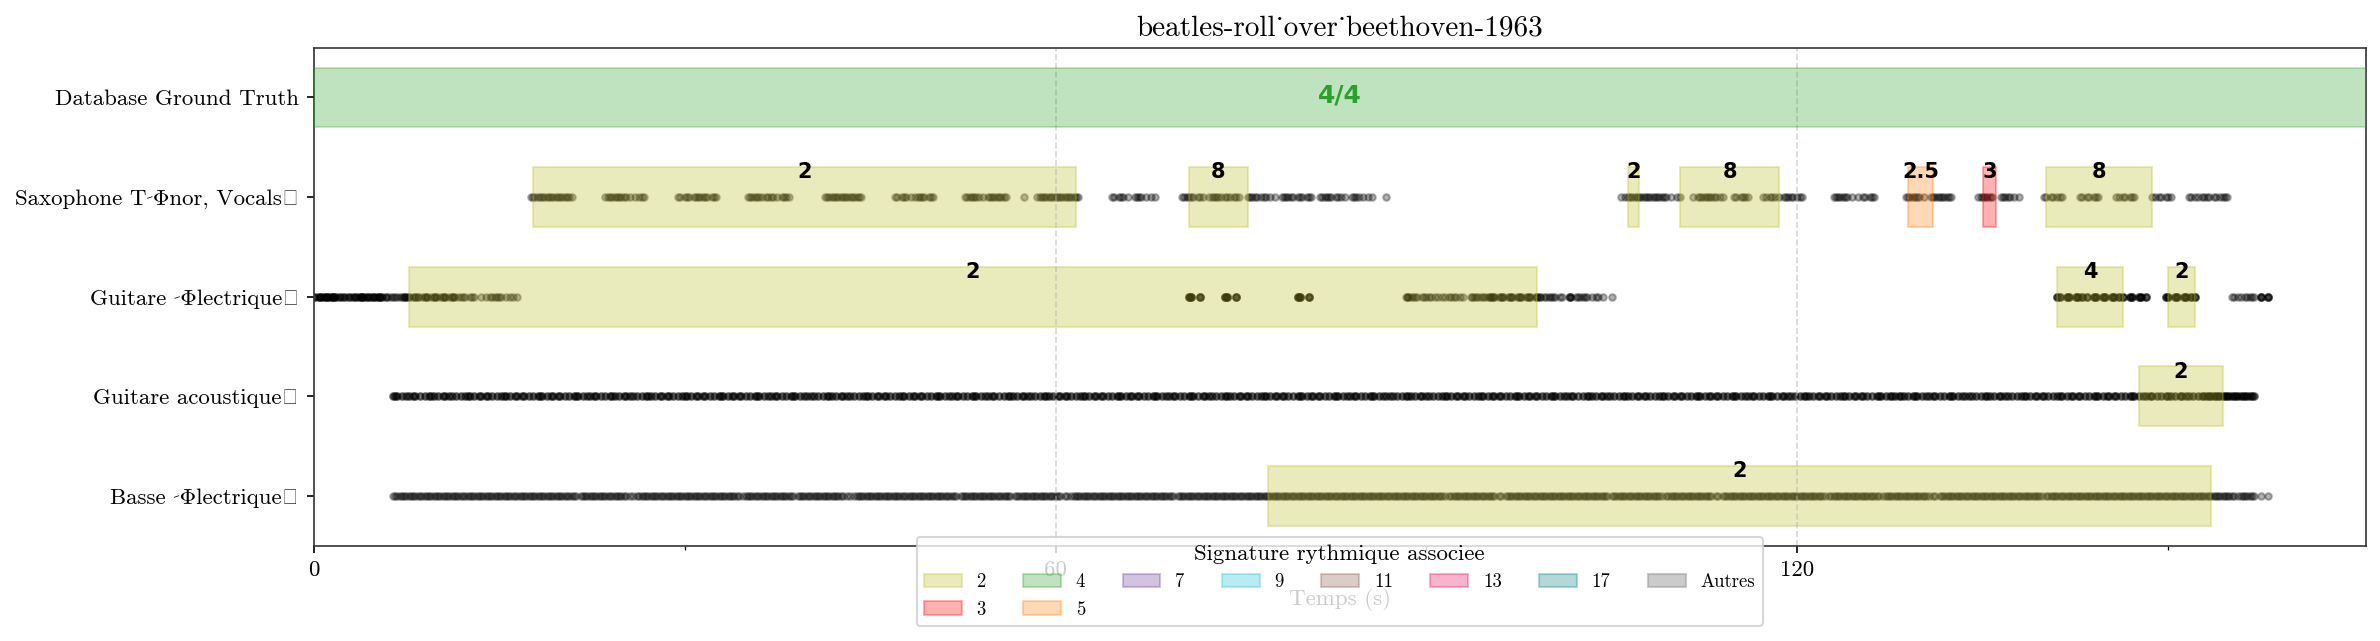

Pourcentage de points perdus : 90.93 %
Nombre de motifs: 21
Global compactness: 1.058670143415906


/tmp/ipython-input-576335406.py:562: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/tmp/ipython-input-576335406.py:659: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0, 1, 0.9])
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/tmp/ipython-input-576335406.py:663: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  plt.savefig(filename, format='pdf', bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


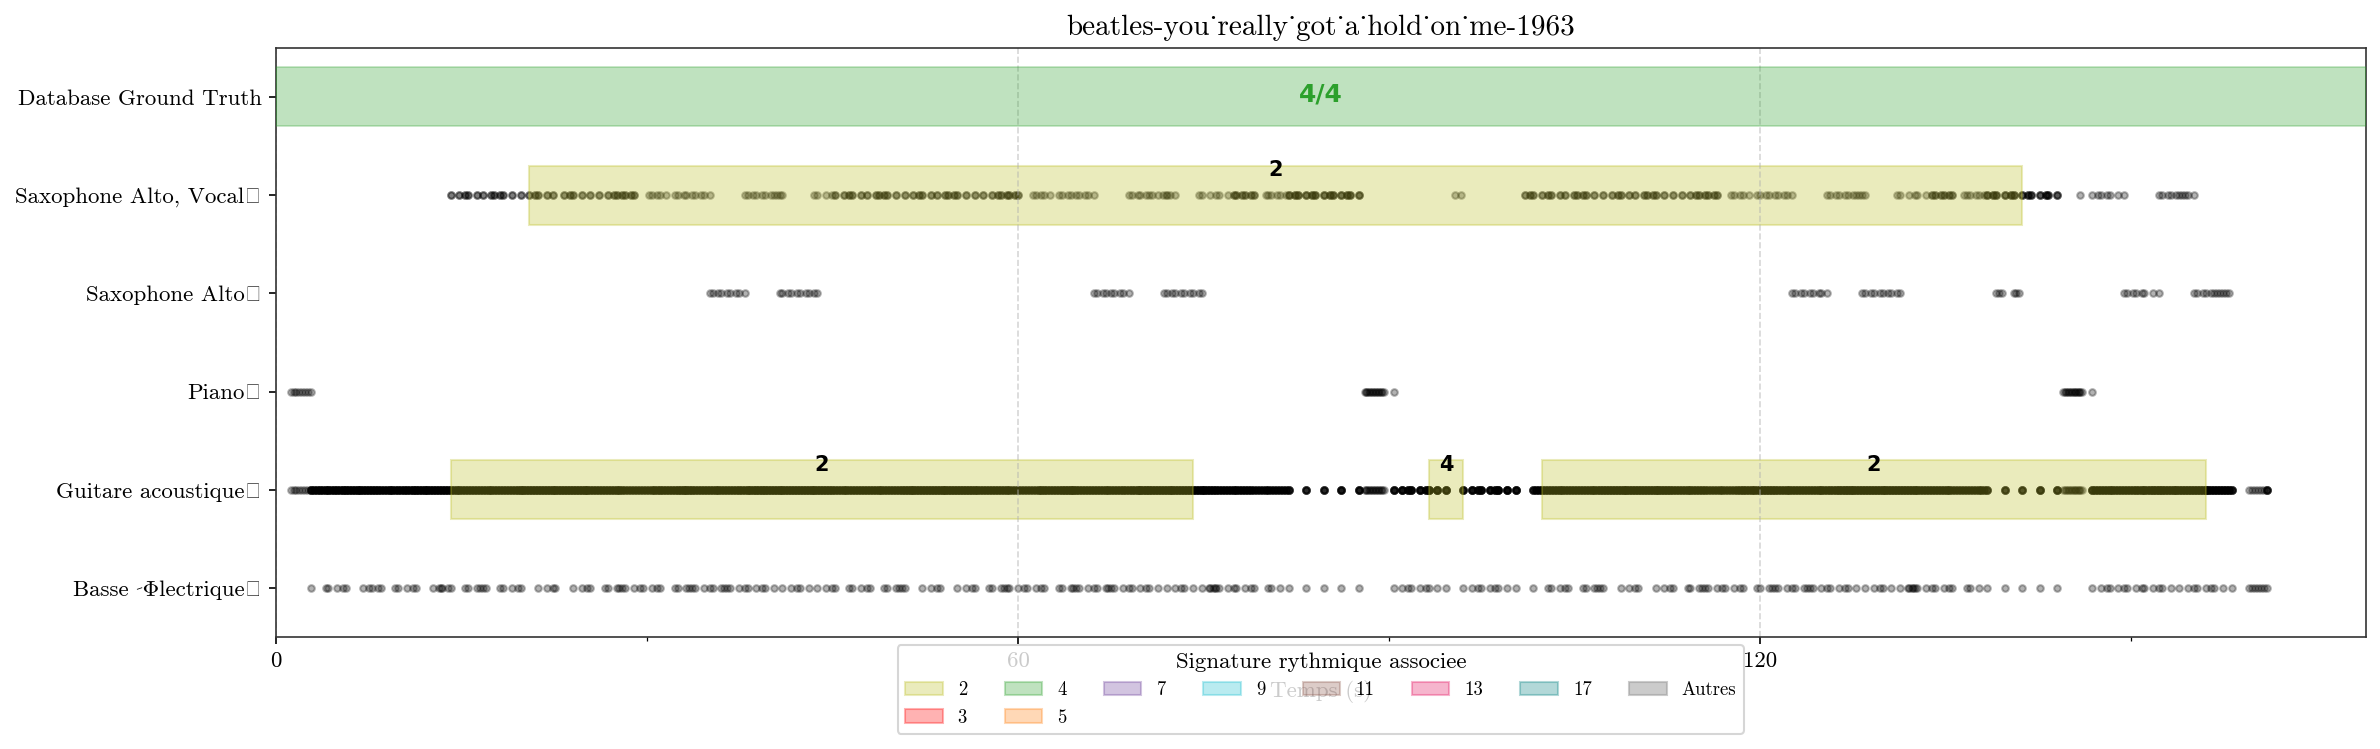

Pourcentage de points perdus : 85.63 %
Nombre de motifs: 39
Global compactness: 1.0806646525679757


In [19]:
def process_midi_separating_instruments(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    tempo_changes, tempos = midi_data.get_tempo_changes()
    bpm = tempos[0] if len(tempos) > 0 else Fraction(120)
    seconds_to_beats = bpm / 60
    tatum = Fraction(1, (8 * 3))
    data = []

    for instrument in midi_data.instruments:
        instrument_name = instrument.name if instrument.name else 'Unknown'
        for note in instrument.notes:
            onset_in_beats = note.start * seconds_to_beats
            duration_in_beats = (note.end - note.start) * seconds_to_beats

            rounded_onset = round(onset_in_beats / tatum) * tatum
            rounded_duration = round(duration_in_beats / tatum) * tatum

            onset_value = float(rounded_onset) if rounded_onset.denominator % 3 != 0 else rounded_onset
            duration_value = float(rounded_duration) if rounded_duration.denominator % 3 != 0 else rounded_duration

            data.append({
                'midi_file': os.path.basename(midi_file_path),
                'instrument': instrument_name,
                'pitch': note.pitch,
                'onset': onset_value,
                'duration': duration_value
            })
    return data

def preprocess_midi_folder_to_dict(folder_path):
    dataset = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".mid") or filename.endswith(".midi"):
            file_path = os.path.join(folder_path, filename)
            try:
                midi_data = process_midi_separating_instruments(file_path)
                df = pd.DataFrame(midi_data)
                midi_file = df['midi_file'].iloc[0]

                if midi_file not in dataset:
                    dataset[midi_file] = {}

                for instrument, group in df.groupby('instrument'):
                    if instrument not in dataset[midi_file]:
                        dataset[midi_file][instrument] = []

                    for row in group.itertuples(index=False):
                        onset = Fraction(row.onset) if '/' in str(row.onset) else float(row.onset)
                        dataset[midi_file][instrument].append((onset, row.pitch))

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    return dataset

def get_subsets_with_points(preprocessed_dataset):
    excluded_tracks = {}

    subsets_data = {}
    for track_name, instruments_data in preprocessed_dataset.items():
        track_filename = track_name.split(" - ")[-1]
        for instrument_name, points in instruments_data.items():
            subset_name = f"{track_filename}_{instrument_name}"
            if subset_name not in excluded_tracks:
                subsets_data[subset_name] = points
    return subsets_data

# 👇 Usage:
midi_folder_path_beatles = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Beatles_MIDI"
preprocessed_dataset_beatles = preprocess_midi_folder_to_dict(midi_folder_path_beatles)
subsets_data_beatles = get_subsets_with_points(preprocessed_dataset_beatles)
ground_truth_df_beatles = check_time_signature_presence(midi_folder_path_beatles)

# 1. Get all unique track names (without instruments)
track_names = {
    "_".join(k.split("_")[:-1])  # Remove last segment (instrument name)
    for k in subsets_data_beatles
}

# 2. Convert to sorted list
pieces_name = sorted(track_names)
print("Pieces name:", pieces_name)

# 3. Plot each unique piece
for piece in pieces_name:
    plot_metric_sections_by_best_compactness(subsets_data_beatles, piece, pattern_detection, dilation, ground_truth_df_beatles, Lmax=50)

# Polymetric complexity representation

This section aims to propose a new way to visualize time signature repartition of a given MIDI file, using a grid representing the polymetric/homometric repartition of the given piece of music.

🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 1869.50
   • Total cumulated length covered by signature segments: 14252.00
   • Percentage of 'No Signature': 4.4%
   • Percentage of 'With Signature': 95.6%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.370174 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (4) Deserted Dunes Welcome Weary Feet.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 95.6%
   • Without signature (gaps): 4.4%

🎵 POLYMETRIC COMPLEXITY: 0.914
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 341.5 beats
   • Number of instruments: 9
   • Total number of segments: 59
   • Number of bases: 4

🔄 DOMINA

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


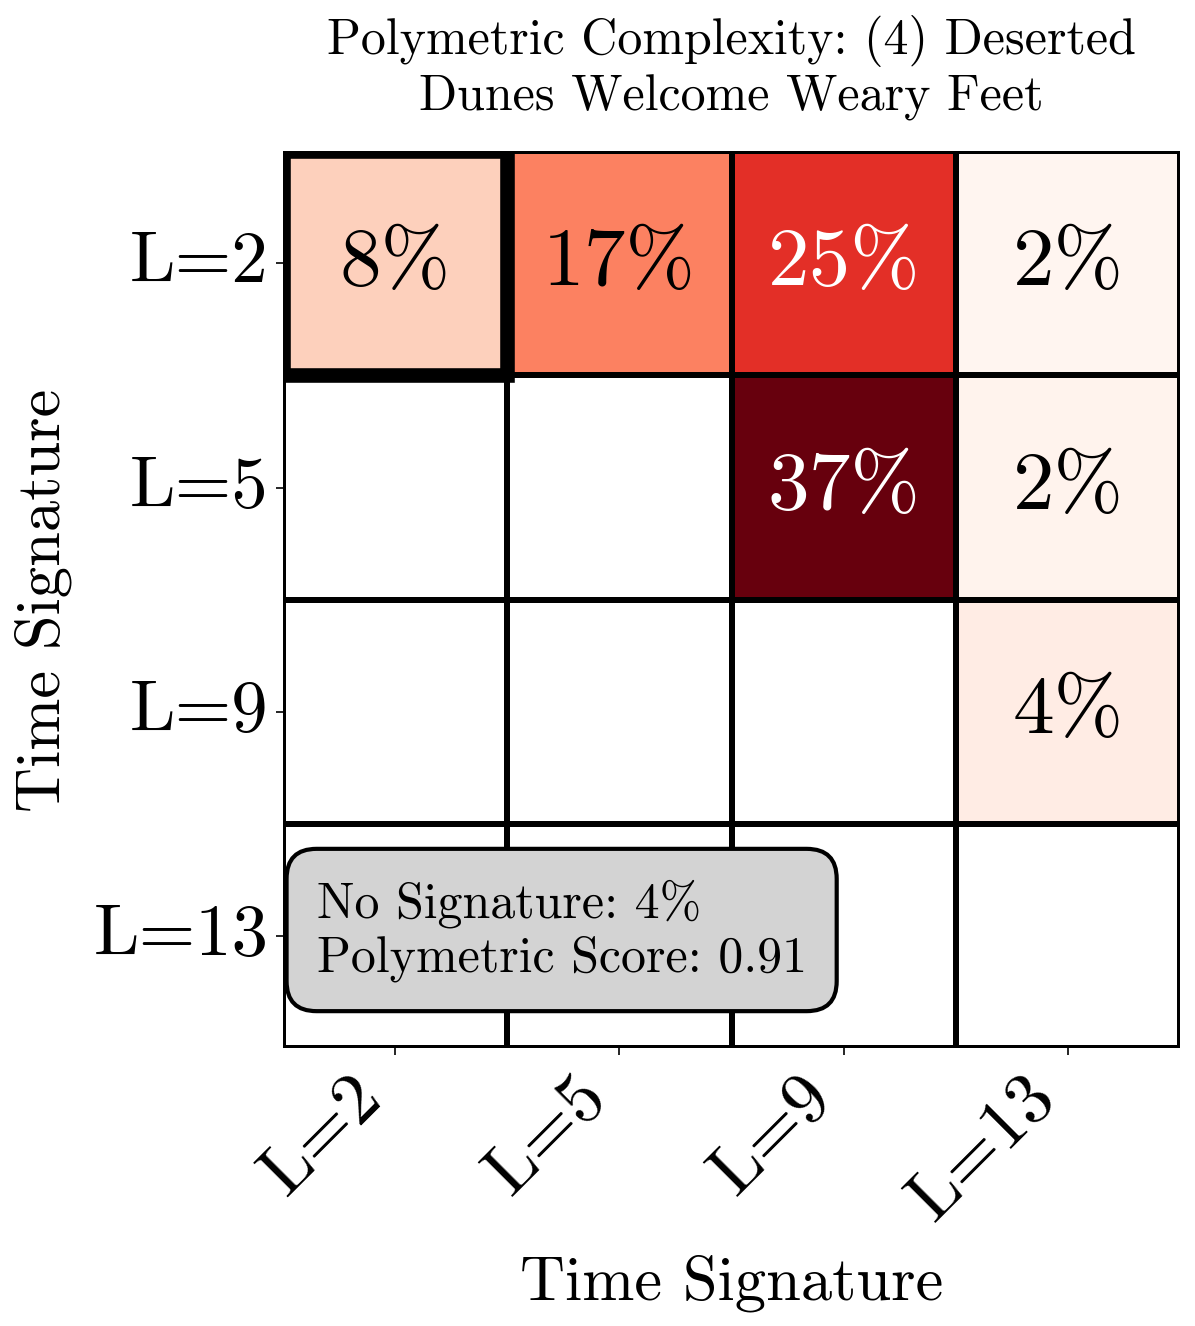

In [ ]:
def compute_polymetric_complexity_grid_with_precalculated_gaps(
        display_bands: Dict[str, List[Dict]],
        track_instruments: Dict[str, List],  # Données originales des onsets
        base_for_L: Dict[float, int] = None
) -> Tuple[np.ndarray, List[str], Dict]:
    """
    Compute a 2D grid representing polymetric complexity.
    """

    # 1) Convert display_bands to segments format, grouped by instrument
    segments_by_instrument = {}
    all_L_values = set()

    for inst, bands in display_bands.items():
        segments_by_instrument[inst] = []
        for band in bands:
            segment = {
                'instrument': inst,
                'start': band['min_on'],
                'end': band['max_on'],
                'L': band['L'],
                'N': band['N'],
                'compactness': band['compactness'],
                'duration': band['max_on'] - band['min_on'],
                'band_id': band['id']
            }
            segments_by_instrument[inst].append(segment)
            all_L_values.add(band['L'])

    # 2) Compute bases if not provided
    if base_for_L is None:
        base_for_L = {}
        base_groups = group_multiplicative_bases(list(all_L_values))

        for group in base_groups:
            base_raw = min(group)
            base_int = Fraction(base_raw).limit_denominator().numerator
            for L in group:
                base_for_L[L] = base_int

    # 3) Add base information to all segments
    for inst_segments in segments_by_instrument.values():
        for seg in inst_segments:
            seg['base'] = base_for_L.get(seg['L'], seg['L'])

    # 4) Get unique bases and create mapping (including "No signature")
    unique_bases = sorted(set(base_for_L.values()))
    base_labels = [f"L={base}" for base in unique_bases] + ["No signature"]
    base_to_idx = {base: i for i, base in enumerate(unique_bases)}
    no_signature_idx = len(unique_bases)
    n_categories = len(base_labels)

    # 5) Calculate instrument-specific ranges using ORIGINAL ONSET DATA
    instrument_ranges = {}
    for inst in track_instruments.keys():
        onsets = track_instruments[inst]
        if onsets:
            onset_beats = [onset[0] for onset in onsets]
            inst_start = min(onset_beats)
            inst_end = max(onset_beats)
            inst_total_duration = inst_end - inst_start
            instrument_ranges[inst] = {
                'start': inst_start,
                'end': inst_end,
                'total_duration': inst_total_duration
            }
        else:
            instrument_ranges[inst] = {'start': 0, 'end': 0, 'total_duration': 0}

    # 6) Calculate global piece duration
    all_onsets = []
    for inst_onsets in track_instruments.values():
        all_onsets.extend([onset[0] for onset in inst_onsets])

    if all_onsets:
        global_start = min(all_onsets)
        global_end = max(all_onsets)
        global_duration = global_end - global_start
    else:
        global_duration = 1.0

    # 7) Calculate the % of "NO SIGNATURE"
    def compute_no_signature_percentage_from_ranges_and_segments(instrument_ranges, segments_by_instrument):
        """
        Calculate the % of "NO SIGNATURE" based on the given ranges and segments.
        """
        def merge_intervals(intervals):
            if not intervals:
                return []
            intervals.sort()
            merged = [intervals[0]]
            for start, end in intervals[1:]:
                last_start, last_end = merged[-1]
                if start <= last_end:
                    merged[-1] = (last_start, max(last_end, end))
                else:
                    merged.append((start, end))
            return merged

        total_piece_duration = 0
        total_signature_duration = 0

        for inst, segs in segments_by_instrument.items():
            # Total length of the track
            if inst not in instrument_ranges or "total_duration" not in instrument_ranges[inst]:
                continue  # Skip if data missing

            total_piece_duration += instrument_ranges[inst]["total_duration"]

            # Merging the segments (to avoid doubles)
            merged = merge_intervals([(s["start"], s["end"]) for s in segs])
            total_signature_duration += sum(end - start for start, end in merged)

        if total_piece_duration > 0:
            no_signature_percentage = 1.0 - (total_signature_duration / total_piece_duration)
        else:
            no_signature_percentage = 1.0

        return no_signature_percentage
    no_signature_percentage = compute_no_signature_percentage_from_ranges_and_segments(instrument_ranges, segments_by_instrument)
    signature_percentage = 1.0 - no_signature_percentage
    total_instrument_duration = sum(inst_range['total_duration'] for inst_range in instrument_ranges.values())
    total_signature_duration = sum(seg['duration'] for inst_segments in segments_by_instrument.values() for seg in inst_segments)
    global_duration = max(inst_range['end'] for inst_range in instrument_ranges.values()) - min(inst_range['start'] for inst_range in instrument_ranges.values())


    print(f"🔍 PERCENTAGE CALCULATION: ")
    print(f"   • Total cumulated track length: {total_instrument_duration:.2f}")
    print(f"   • Total cumulated length covered by signature segments: {total_signature_duration:.2f}")
    print(f"   • Percentage of 'No Signature': {no_signature_percentage:.1%}")
    print(f"   • Percentage of 'With Signature': {signature_percentage:.1%}")

    # 8) Initialisation of the grid for signatures only
    n_instruments = len(track_instruments)
    instruments = list(track_instruments.keys())
    signature_grid = np.zeros((n_categories - 1, n_categories - 1))  # Sans la diagonale No signature

    # 9) Crossed comparison of the signed segments
    comparisons_made = 0

    for i in range(n_instruments):
        inst1 = instruments[i]
        for j in range(i + 1, n_instruments):
            inst2 = instruments[j]
            comparisons_made += 1

            inst1_segments = segments_by_instrument.get(inst1, [])
            inst2_segments = segments_by_instrument.get(inst2, [])

            for seg1 in inst1_segments:
                for seg2 in inst2_segments:
                    overlap_start = max(seg1['start'], seg2['start'])
                    overlap_end = min(seg1['end'], seg2['end'])

                    if overlap_start < overlap_end:
                        overlap_duration = overlap_end - overlap_start
                        base1_idx = base_to_idx[seg1['base']]
                        base2_idx = base_to_idx[seg2['base']]

                        if base1_idx <= base2_idx:
                            signature_grid[base1_idx, base2_idx] += overlap_duration
                        else:
                            signature_grid[base2_idx, base1_idx] += overlap_duration

    # 10) Filling the diagonal (homometry between 2 instruments)
    for i in range(n_instruments):
        inst1 = instruments[i]
        for j in range(i + 1, n_instruments):
            inst2 = instruments[j]

            inst1_segments = segments_by_instrument.get(inst1, [])
            inst2_segments = segments_by_instrument.get(inst2, [])

            for seg1 in inst1_segments:
                for seg2 in inst2_segments:
                    if seg1['base'] == seg2['base']:
                        overlap_start = max(seg1['start'], seg2['start'])
                        overlap_end = min(seg1['end'], seg2['end'])

                        if overlap_start < overlap_end:
                            overlap_duration = overlap_end - overlap_start
                            base_idx = base_to_idx[seg1['base']]
                            signature_grid[base_idx, base_idx] += overlap_duration

    # 11) RENORMALISATION : Final scaling
    final_grid = np.zeros((n_categories, n_categories))

    total_signature_time = np.sum(signature_grid)
    if total_signature_time > 0:
        normalized_signature_grid = (signature_grid / total_signature_time) * signature_percentage
        final_grid[:-1, :-1] = normalized_signature_grid

    final_grid[no_signature_idx, no_signature_idx] = no_signature_percentage

    total_final = np.sum(final_grid)
    print(f"   • Somme finale du grid: {total_final:.6f} (devrait être ≈ 1.0)")

    # 12) Complementary analysis
    analysis_data = {
        'global_duration': global_duration,
        'total_instrument_duration': total_instrument_duration,
        'total_signature_duration': total_signature_duration,
        'no_signature_percentage': no_signature_percentage,
        'signature_percentage': signature_percentage,
        'n_segments': sum(len(segs) for segs in segments_by_instrument.values()),
        'n_bases': len(unique_bases),
        'n_instruments': n_instruments,
        'comparisons_made': comparisons_made,
        'base_to_idx': base_to_idx,
        'no_signature_idx': no_signature_idx,
        'L_to_base': base_for_L,
        'segments_by_instrument': segments_by_instrument,
        'instrument_ranges': instrument_ranges,
        'original_onsets': track_instruments
    }

    return final_grid, base_labels, analysis_data


def verify_proportions_triangular(grid: np.ndarray, base_labels: List[str]) -> None:
    """
    Verify that the grid contains valid proportions for triangular matrix.
    """
    # Only count upper triangle
    n = len(base_labels)
    upper_triangle_sum = 0

    for i in range(n):
        for j in range(i, n):
            upper_triangle_sum += grid[i, j]

    max_val = np.max(grid)
    min_val = np.min(grid)

    print(f"\n🔍 CHECKING PROPORTIONS (Triangular):")
    print(f"   • Upper triangle sum: {upper_triangle_sum:.6f} (should be ≈ 1.0)")
    print(f"   • Max value: {max_val:.6f} (should be ≤ 1.0)")
    print(f"   • Min value: {min_val:.6f} (should be ≥ 0.0)")

    if abs(upper_triangle_sum - 1.0) < 1e-6:
        print("   ✅ Proportions are correct")
    else:
        print("   ❌ Proportions do not sum to 1")

    if max_val <= 1.0 and min_val >= 0.0:
        print("   ✅ All values are within [0,1]")
    else:
        print("   ❌ Some values are outside the [0,1] range")


def plot_polymetric_complexity_grid_triangular(
        grid: np.ndarray,
        base_labels: List[str],
        analysis_data: Dict,
        track_name: str = "",
        figsize: Tuple[int, int] = (10, 8)
) -> None:
    """
    Plot the polymetric complexity grid optimized for small print sizes in reports.
    All font sizes are >= 20pt, with clear contrast and thick borders on diagonal.
    Includes stats box superimposed in bottom-left corner without overlapping the diagonal.
    """

    import textwrap

    def wrap_title(title: str, max_chars: int) -> str:
        return '\n'.join(textwrap.wrap(title, width=max_chars))

    grid = np.array(grid)
    grid_trimmed = grid[:-1, :-1]
    labels_trimmed = base_labels[:-1]

    fig, ax = plt.subplots(figsize=figsize)
    n = len(labels_trimmed)
    mask = np.zeros((n, n), dtype=bool)

    for i in range(n):
        for j in range(i):
            mask[i, j] = True

    zero_mask = grid_trimmed == 0
    combined_mask = mask | zero_mask

    cell_size = min(figsize) / max(n, 1)
    font_size = max(20, int(cell_size * 20))

    sns.heatmap(
        grid_trimmed,
        annot=False,
        xticklabels=labels_trimmed,
        yticklabels=labels_trimmed,
        cmap='Reds',
        cbar=False,
        mask=combined_mask,
        square=True,
        linewidths=2,
        linecolor='black',
        ax=ax
    )

    max_value = np.max(grid_trimmed[~combined_mask]) if np.any(~combined_mask) else 1.0

    for i in range(n):
        for j in range(i, n):
            if not combined_mask[i, j]:
                value = grid_trimmed[i, j]
                percentage = value * 100
                if percentage >= 1.0:
                    text = f'{percentage:.0f}%'
                elif percentage >= 0.1:
                    text = f'{percentage:.1f}%'
                else:
                    text = f'{percentage:.2f}%'
                normalized_value = value / max_value if max_value > 0 else 0
                text_color = 'white' if normalized_value > 0.5 else 'black'
                ax.text(j + 0.5, i + 0.5, text,
                        ha='center', va='center',
                        fontsize=font_size,
                        fontweight='bold',
                        color=text_color)

    for i in range(n):
        for j in range(i, n):
            if not combined_mask[i, j]:
                border_width = 7 if i == j else 2
                rect = plt.Rectangle((j, i), 1, 1,
                                     fill=False,
                                     edgecolor='black',
                                     linewidth=border_width,
                                     zorder=3)
                ax.add_patch(rect)

    display_name = track_name.replace(".mid", "")
    full_title = f'Polymetric Complexity: {display_name}'
    max_chars = int(figsize[0] * 4)  # Approximate max characters per line
    wrapped_title = wrap_title(full_title, max_chars=max_chars)

    ax.set_title(wrapped_title, fontsize=24, fontweight='bold', pad=20)

    ax.set_xlabel('Time Signature', fontweight='bold', fontsize=30, labelpad=10)
    ax.set_ylabel('Time Signature', fontweight='bold', fontsize=30, labelpad=10)
    ax.set_xticklabels(labels_trimmed, rotation=45, ha='right', fontsize=35)
    ax.set_yticklabels(labels_trimmed, rotation=0, fontsize=35)

    no_sig_prop = grid[-1, -1] if len(base_labels) > 0 else 0

    total_homometric = sum(grid_trimmed[i, i] for i in range(n) if not combined_mask[i, i])
    total_polymetric = sum(grid_trimmed[i, j] for i in range(n) for j in range(i + 1, n) if not combined_mask[i, j])
    total_signature_activity = total_homometric + total_polymetric
    complexity_score = total_polymetric / total_signature_activity if total_signature_activity > 0 else 0

    stats_text = f'No Signature: {no_sig_prop:.0%}\nPolymetric Score: {complexity_score:.2f}'
    x_cell = 0 + 0.15
    y_cell = n - 0.30

    ax.text(x_cell, y_cell, stats_text,
            transform=ax.transData,
            ha='left', va='bottom',
            fontsize=24, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6',
                      facecolor='lightgray', edgecolor='black',
                      linewidth=2, alpha=1))

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(bottom=0.1)
    safe_name = re.sub(r'[^\w\-_.]', '_', display_name)
    plt.savefig(f"grid_{safe_name}.pdf", format='pdf', bbox_inches='tight')
    plt.show()


def analyze_polymetric_patterns_with_gaps(
        grid: np.ndarray,
        base_labels: List[str],
        analysis_data: Dict,
        threshold: float = 0.01
) -> Dict:
    """
    Analyze the polymetric patterns in the grid including gap analysis.
    """

    patterns = {
        'homometric': {},
        'polymetric': {},
        'no_signature_proportion': 0.0,
        'dominant_base': None,
        'complexity_score': 0.0,
        'coverage_score': 0.0
    }

    n = len(base_labels)
    no_sig_idx = analysis_data['no_signature_idx']

    # Extract no signature proportion
    if no_sig_idx < n:
        patterns['no_signature_proportion'] = grid[no_sig_idx, no_sig_idx]

    # Analyze homometric patterns (diagonal, excluding no signature)
    for i in range(n - 1):  # Exclude no signature index
        if grid[i, i] > threshold:
            base_label = base_labels[i]
            patterns['homometric'][base_label] = {
                'proportion': grid[i, i],
                'rank': 0
            }

    # Analyze polymetric patterns (off-diagonal, upper triangle only, excluding no signature)
    for i in range(n - 1):
        for j in range(i + 1, n - 1):  # Exclude no signature index
            if grid[i, j] > threshold:
                base_pair = (base_labels[i], base_labels[j])
                patterns['polymetric'][base_pair] = {
                    'proportion': grid[i, j]
                }

    # Find dominant base (excluding no signature)
    diagonal_values = {}
    for i in range(n - 1):
        if grid[i, i] > 0:
            diagonal_values[base_labels[i]] = grid[i, i]

    if diagonal_values:
        patterns['dominant_base'] = max(diagonal_values.keys(),
                                      key=lambda x: diagonal_values[x])

    # Compute complexity score (excluding no signature)
    total_homometric = sum(grid[i, i] for i in range(n - 1))
    total_polymetric = sum(grid[i, j] for i in range(n - 1) for j in range(i + 1, n - 1))

    total_signature_activity = total_homometric + total_polymetric
    if total_signature_activity > 0:
        patterns['complexity_score'] = total_polymetric / total_signature_activity

    # Coverage score (1 - proportion of no signature)
    patterns['coverage_score'] = 1.0 - patterns['no_signature_proportion']

    # Rank homometric patterns
    ranked_homo = sorted(patterns['homometric'].items(),
                        key=lambda x: x[1]['proportion'], reverse=True)
    for rank, (base, data) in enumerate(ranked_homo):
        patterns['homometric'][base]['rank'] = rank + 1

    return patterns

def analyze_track_polymetry_with_precalculated_gaps(
        display_bands: Dict[str, List[Dict]],
        track_instruments: Dict[str, List],
        track_name: str = "",
        base_for_L: Dict[float, int] = None,
        plot: bool = True,
        threshold: float = 0.01
) -> Tuple[np.ndarray, List[str], Dict, Dict]:
    """
    Complete analysis with pre-calculated gap handling using improved logic.
    """

    # Compute grid with pre-calculated gap handling
    grid, base_labels, analysis_data = compute_polymetric_complexity_grid_with_precalculated_gaps(
        display_bands, track_instruments, base_for_L
    )

    verify_proportions_triangular(grid, base_labels)

    patterns = analyze_polymetric_patterns_with_gaps(grid, base_labels, analysis_data, threshold)

    print_polymetric_analysis_with_precalculated_gaps(patterns, analysis_data, track_name)

    if plot:
        plot_polymetric_complexity_grid_triangular(grid, base_labels, analysis_data, f"{track_name}")

    return grid, base_labels, analysis_data, patterns

def print_polymetric_analysis_with_precalculated_gaps(patterns: Dict, analysis_data: Dict, track_name: str = "") -> None:
    """
    Print polymetric analysis results using pre-calculated gap information.
    """
    print(f"\n{'='*70}")
    print(f"POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: {track_name}")
    print(f"{'='*70}")

    print(f"\n📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):")
    print(f"   • With detected signature: {analysis_data['signature_percentage']:.1%}")
    print(f"   • Without signature (gaps): {analysis_data['no_signature_percentage']:.1%}")

    print(f"\n🎵 POLYMETRIC COMPLEXITY: {patterns['complexity_score']:.3f}")
    print(f"   (0 = purely homometric, 1 = purely polymetric)")
    print(f"   (calculated only on zones with a signature)")

    print(f"\n📈 STATISTICS:")
    print(f"   • Total duration: {analysis_data['global_duration']:.1f} beats")
    # print(f"   • Total possible overlap time: {analysis_data['total_possible_overlap']:.1f} beats")
    # print(f"   • Time with simultaneous signature: {analysis_data['total_signature_overlap']:.1f} beats")
    print(f"   • Number of instruments: {analysis_data['n_instruments']}")
    print(f"   • Total number of segments: {analysis_data['n_segments']}")
    print(f"   • Number of bases: {analysis_data['n_bases']}")

    if patterns['dominant_base']:
        print(f"\n🔄 DOMINANT SIGNATURE: {patterns['dominant_base']}")
    else:
        print(f"\n🔄 DOMINANT SIGNATURE: No signature detected")

    print(f"\n📊 HOMOMETRY (same signature across different tracks):")
    if patterns['homometric']:
        for base, data in sorted(patterns['homometric'].items(),
                               key=lambda x: x[1]['proportion'], reverse=True):
            print(f"   • {base}: {data['proportion']:.3f} ({data['proportion']*100:.1f}%)")
    else:
        print("   No homometry detected")

    print(f"\n🔀 POLYMETRY (different signatures occurring simultaneously):")
    if patterns['polymetric']:
        for (base1, base2), data in sorted(patterns['polymetric'].items(),
                                         key=lambda x: x[1]['proportion'], reverse=True):
            print(f"   • {base1} ⟷ {base2}: {data['proportion']:.3f} ({data['proportion']*100:.1f}%)")
    else:
        print("   No polymetry detected")


grid, bases, analysis_data, patterns = analyze_track_polymetry_with_precalculated_gaps(
    display_bands,
    track_instruments,
    "(4) Deserted Dunes Welcome Weary Feet.mid", #"(3) Castle in the Air.mid", #"(9) Searching.mid", #"(4) Deserted Dunes Welcome Weary Feet.mid",  # #"(4) Deserted Dunes Welcome Weary Feet.mid", #"(9) Searching.mid", #"(4) Deserted Dunes Welcome Weary Feet.mid", #"(3) Castle in the Air.mid", # # #
    plot=True,
    threshold=0.005
)

## On King Gizzard's "Polygondwanaland" tracks

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


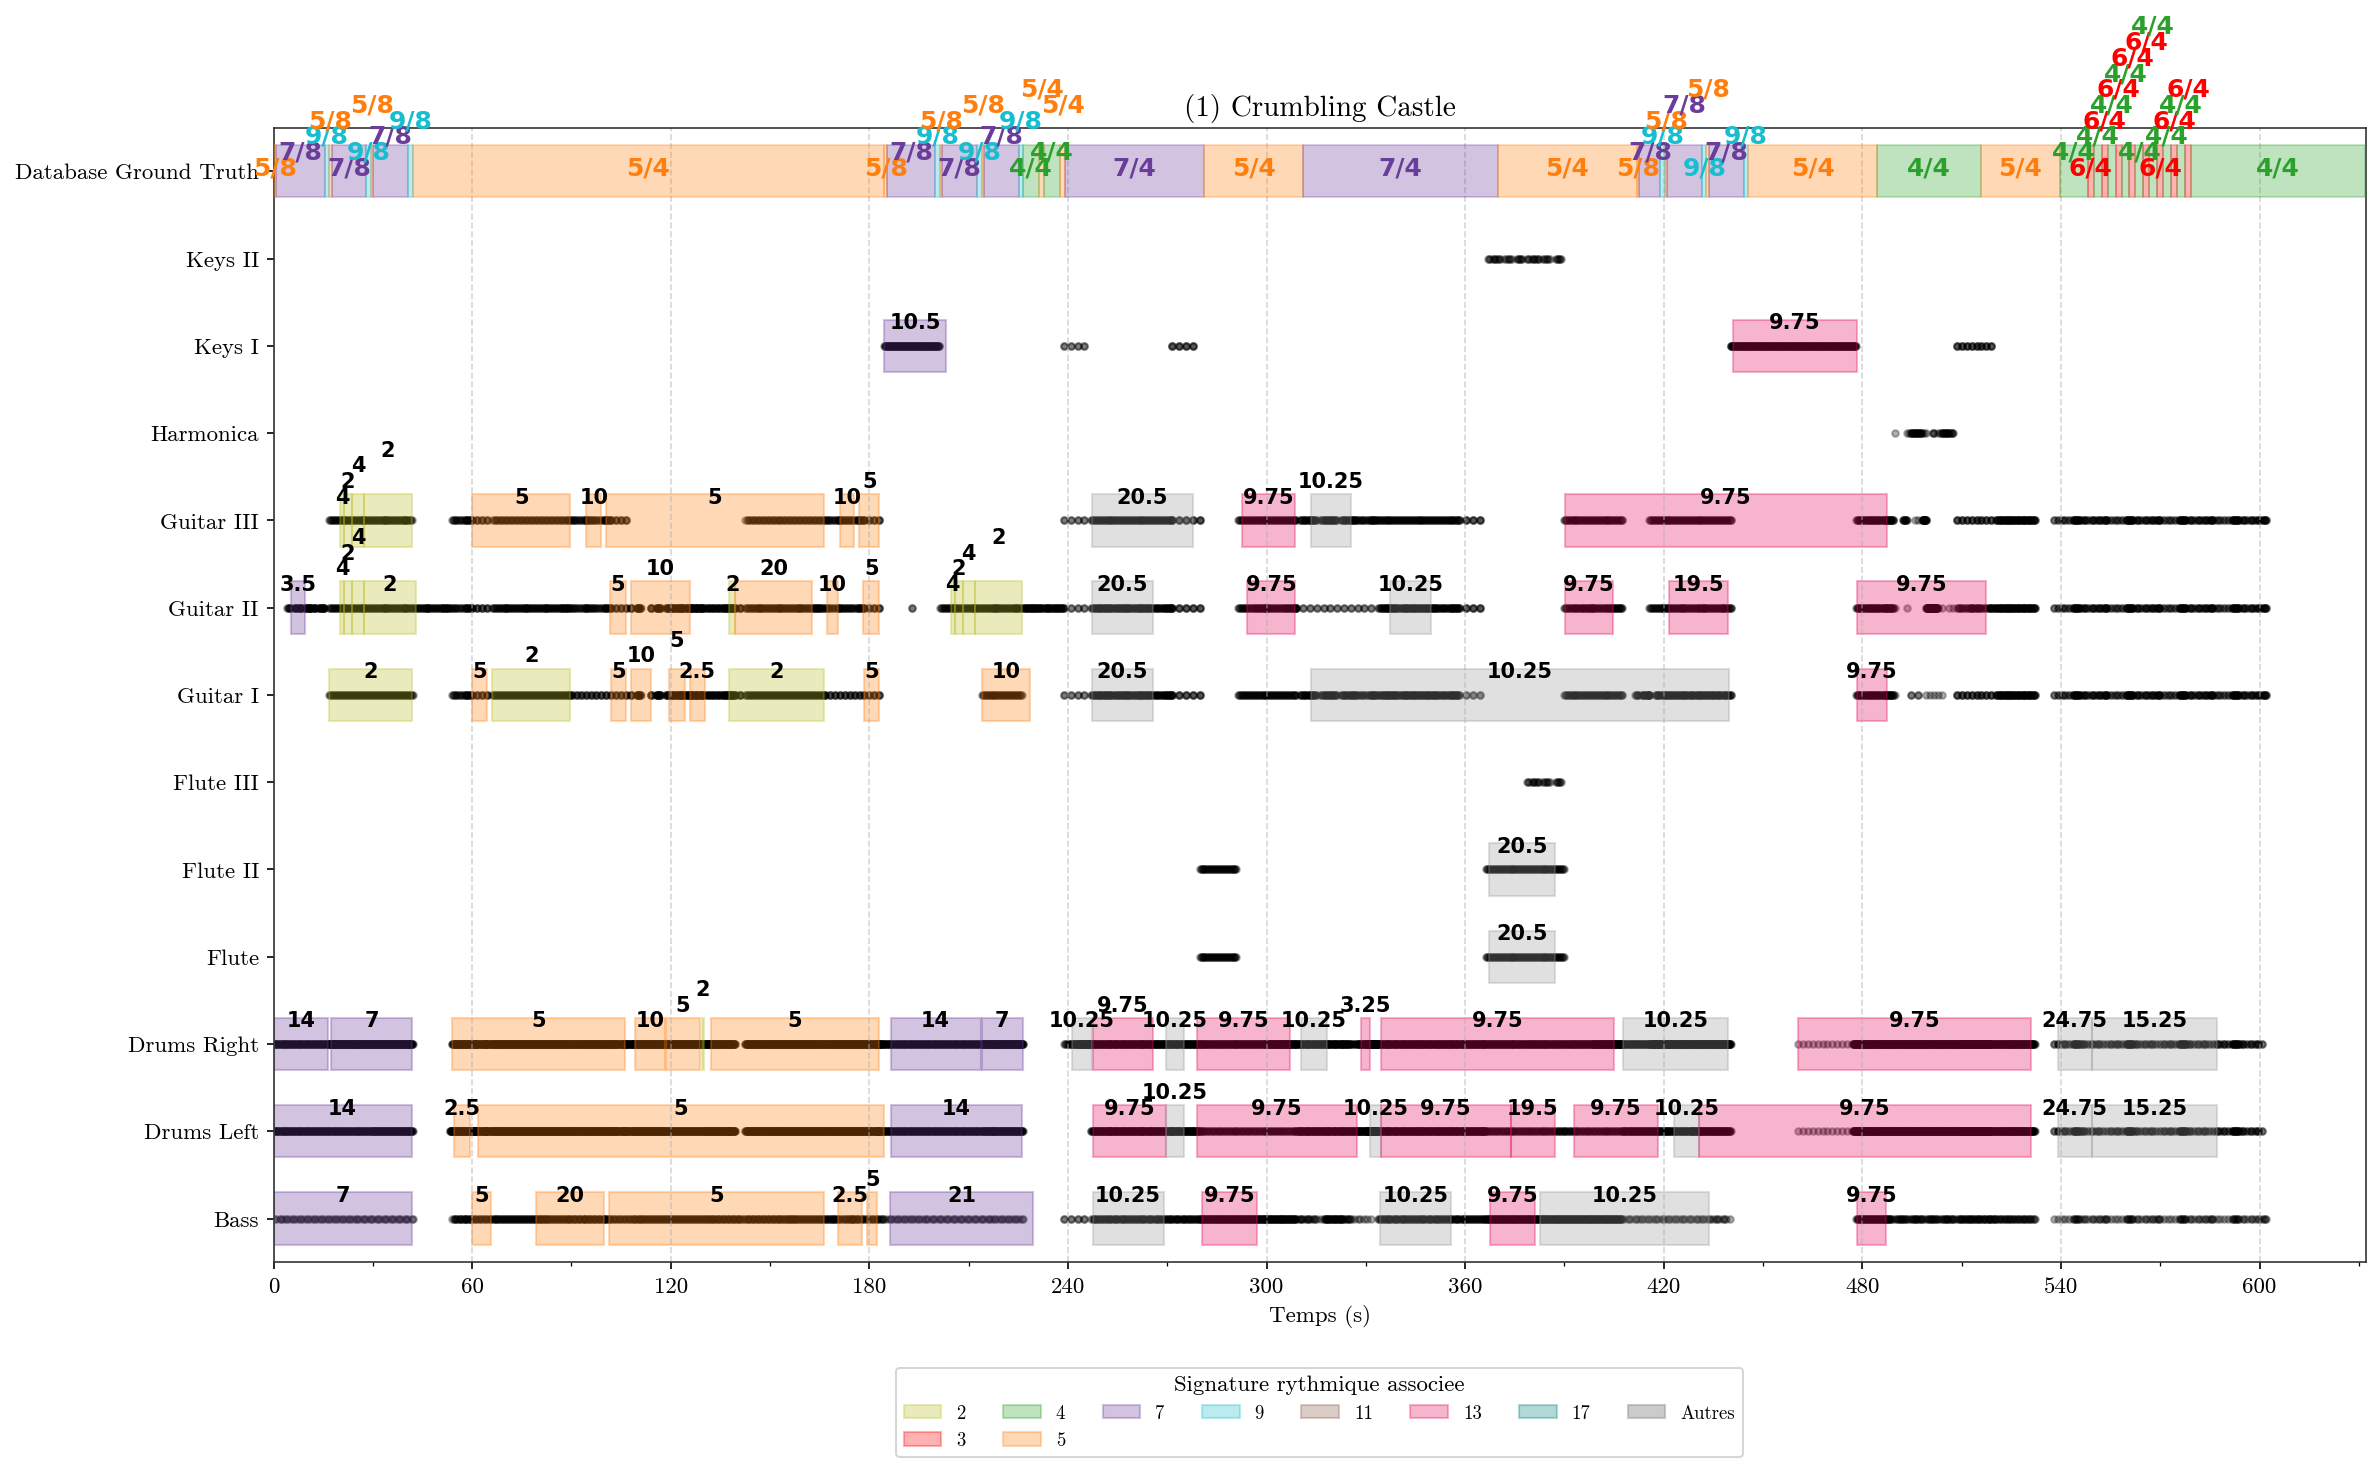

Pourcentage de points perdus : 63.34 %
Nombre de motifs: 250
Global compactness: 1.254857898215466
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 13919.04
   • Total cumulated length covered by signature segments: 11638.62
   • Percentage of 'No Signature': 53.0%
   • Percentage of 'With Signature': 47.0%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.529728 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (1) Crumbling Castle.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 47.0%
   • Without signature (gaps): 53.0%

🎵 POLYMETRIC COMPLEXITY: 0.217
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 2006.4 beats
   • Number

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


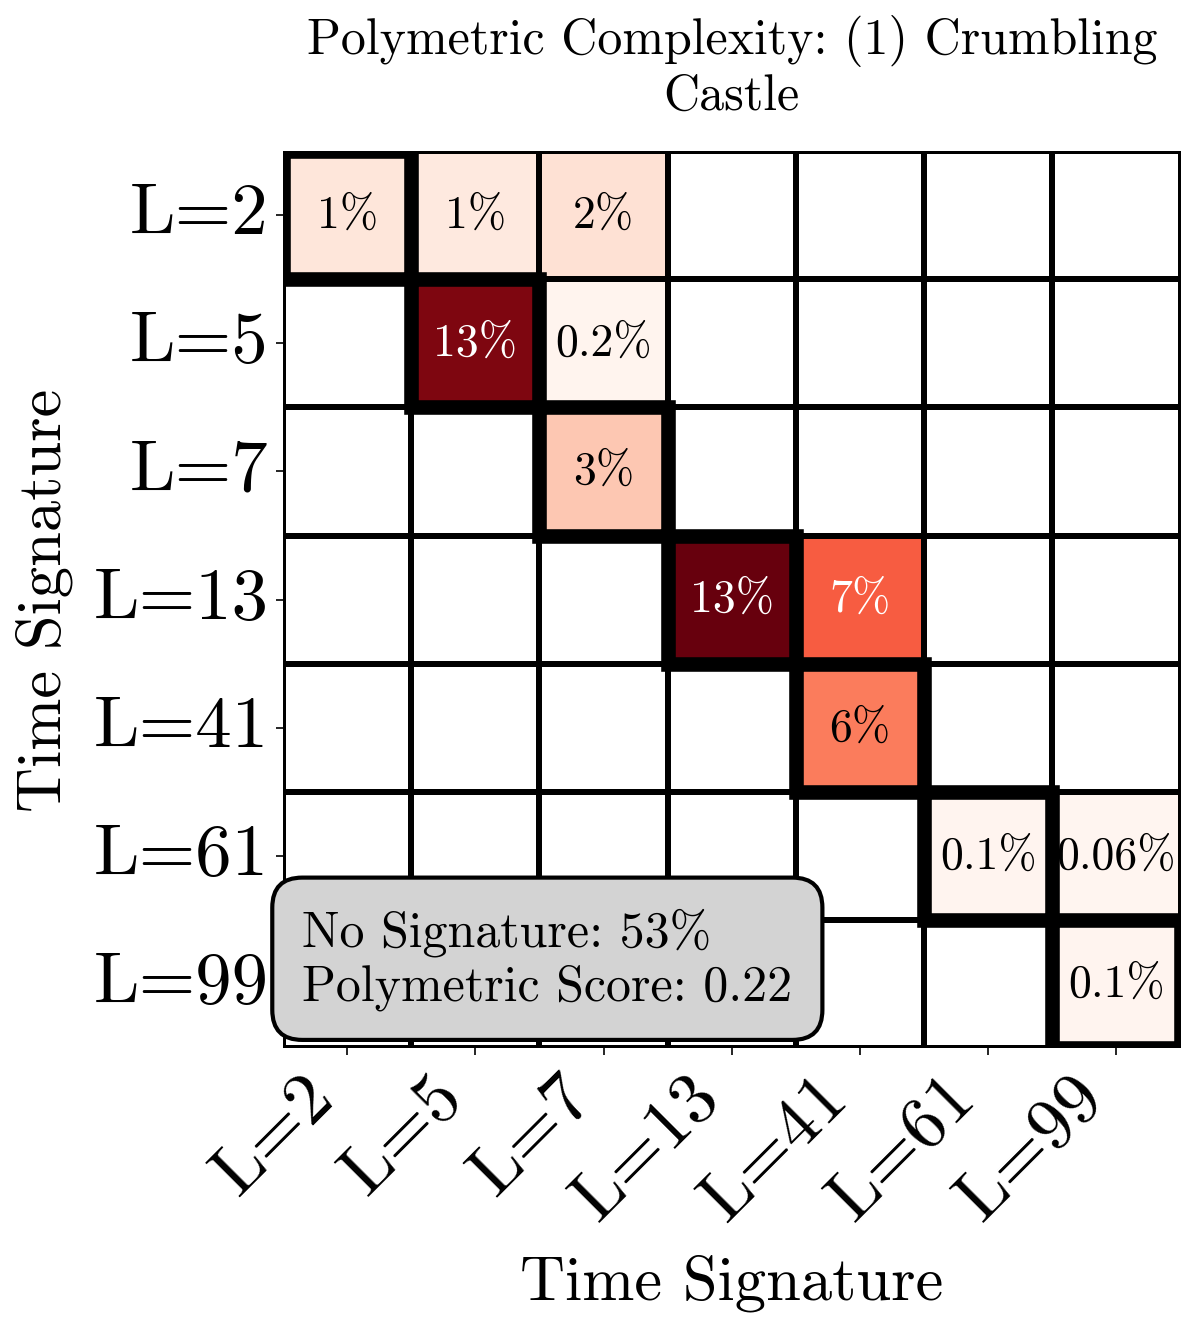

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


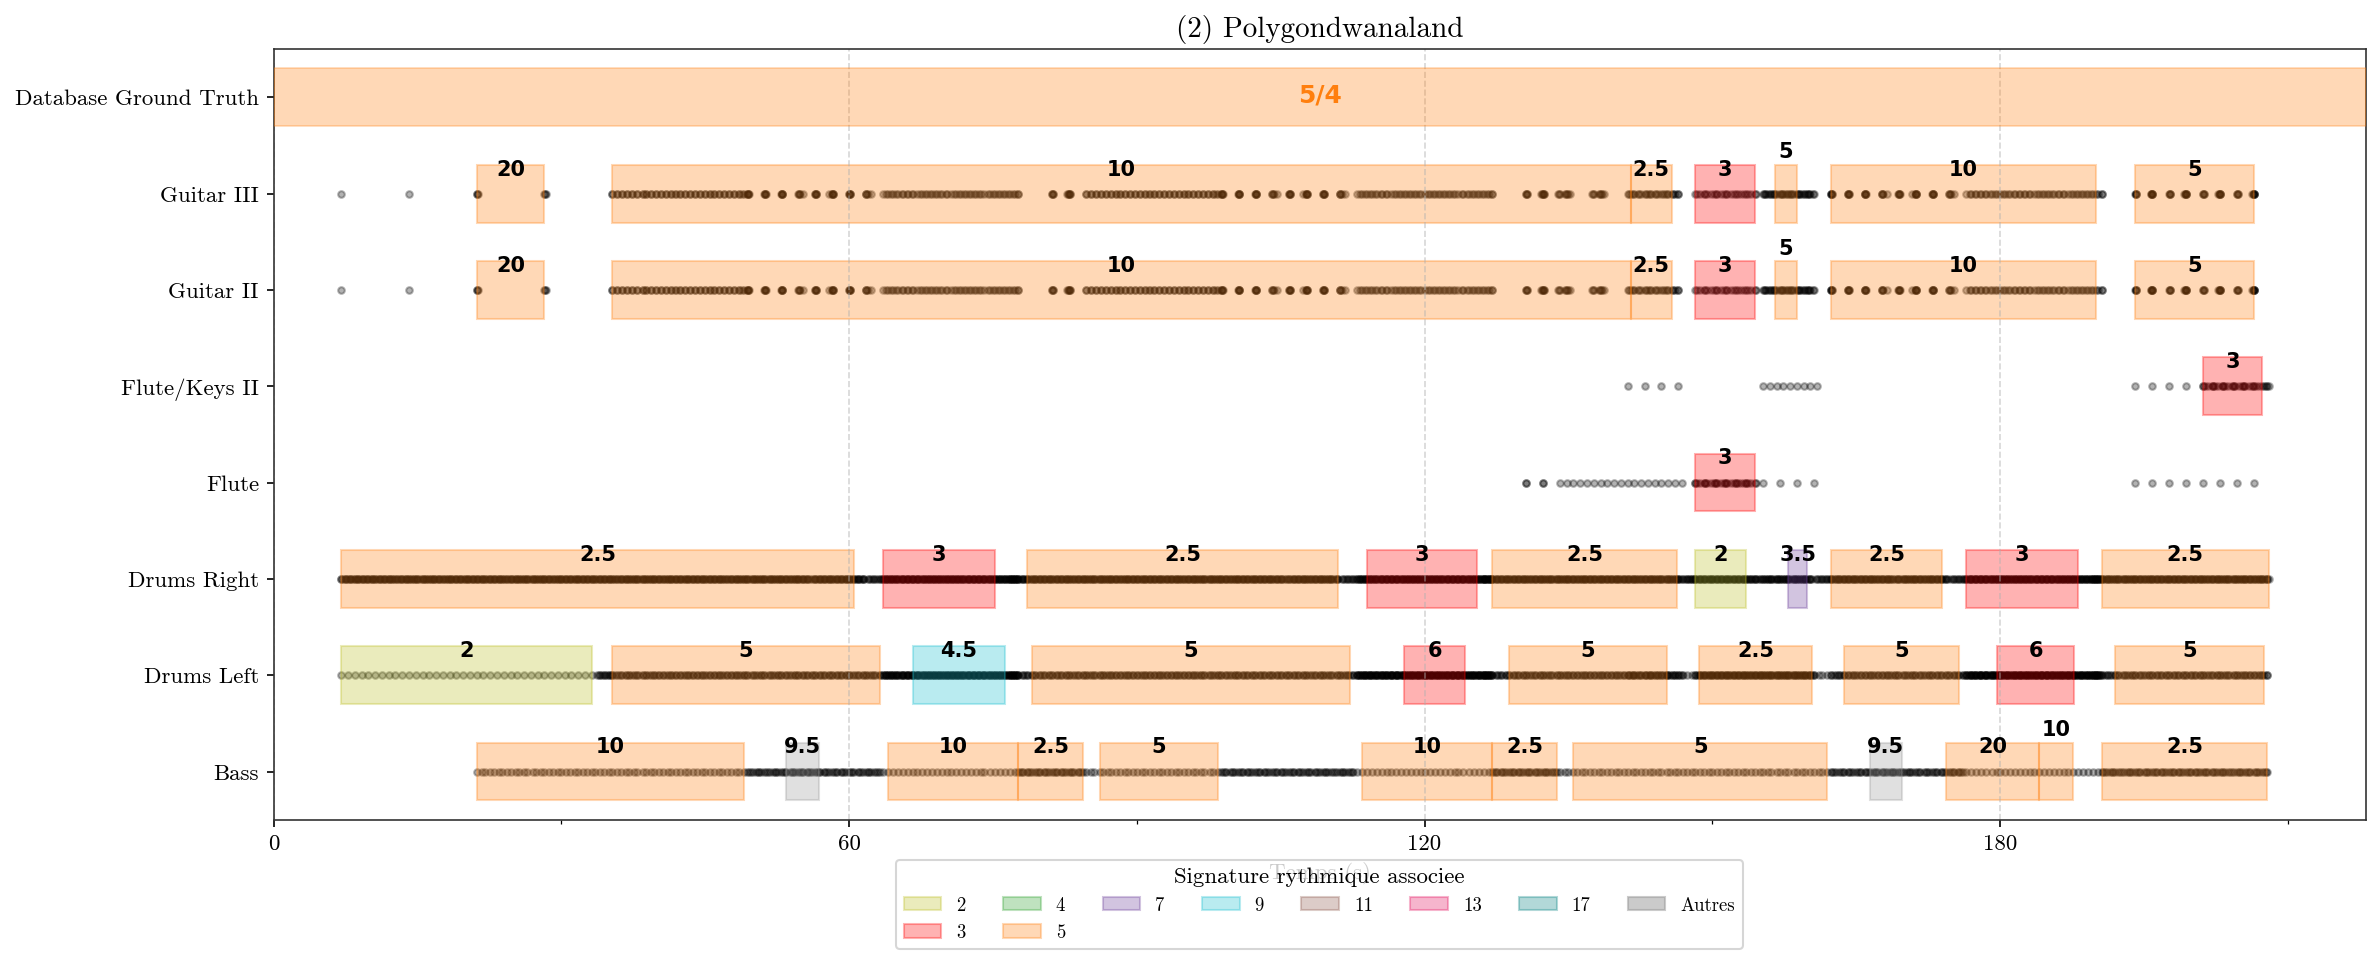

Pourcentage de points perdus : 26.96 %
Nombre de motifs: 116
Global compactness: 1.7437275985663083
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 3202.00
   • Total cumulated length covered by signature segments: 4164.25
   • Percentage of 'No Signature': 26.6%
   • Percentage of 'With Signature': 73.4%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.489029 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (2) Polygondwanaland.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 73.4%
   • Without signature (gaps): 26.6%

🎵 POLYMETRIC COMPLEXITY: 0.245
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 569.5 beats
   • Number o

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


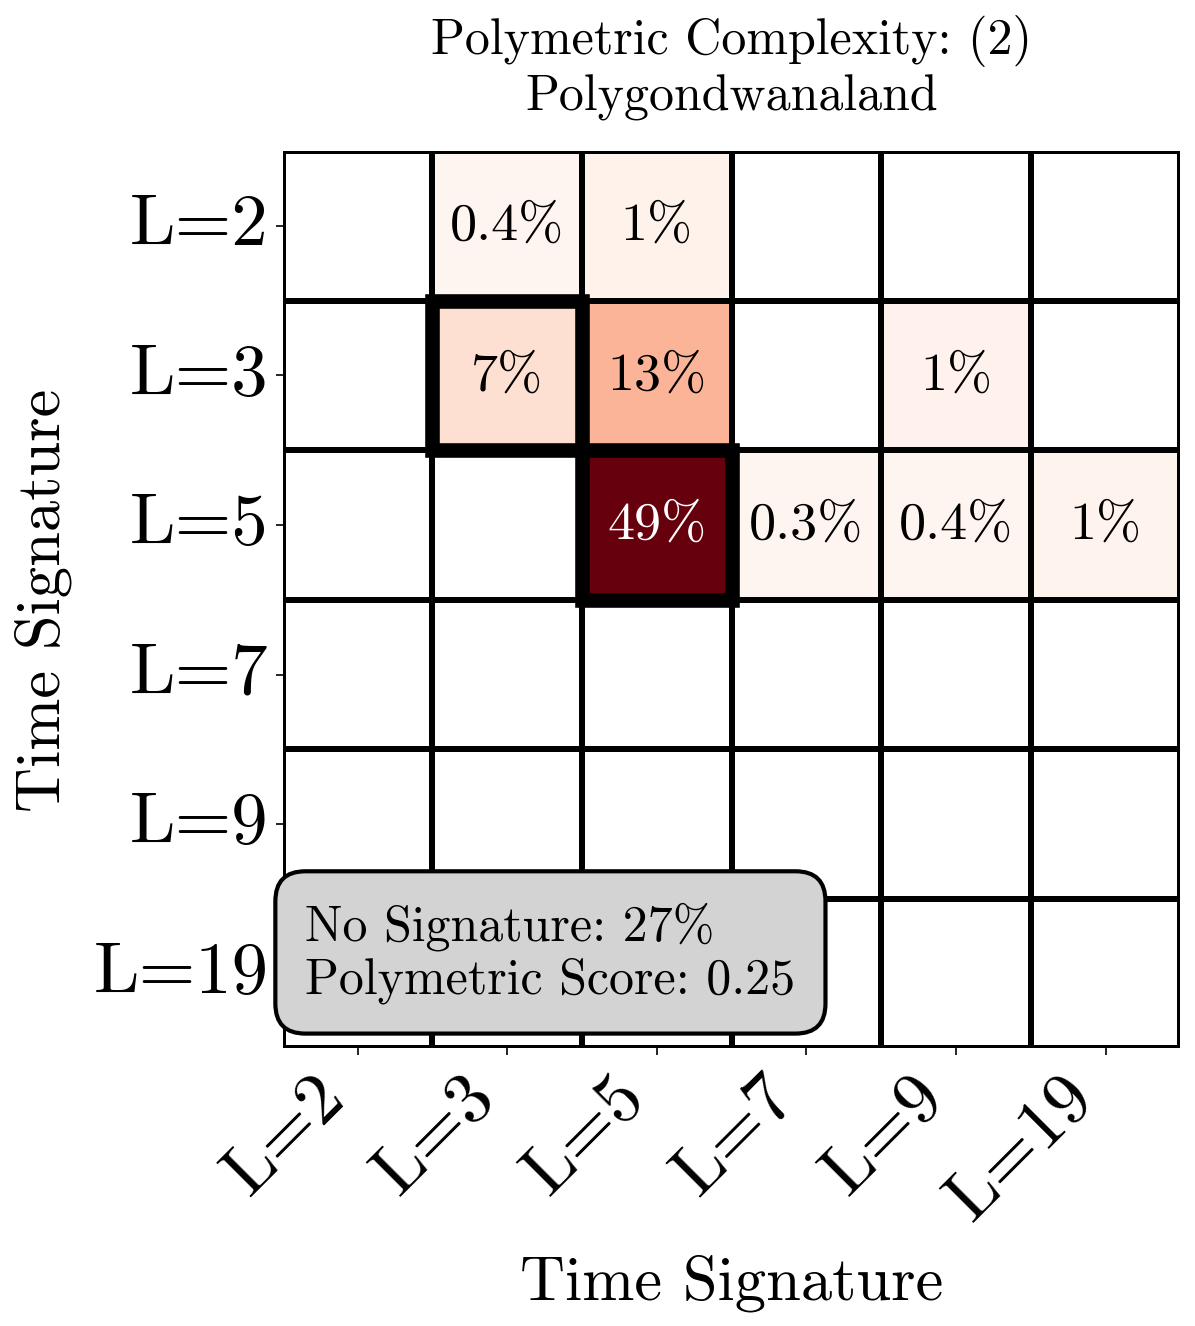

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


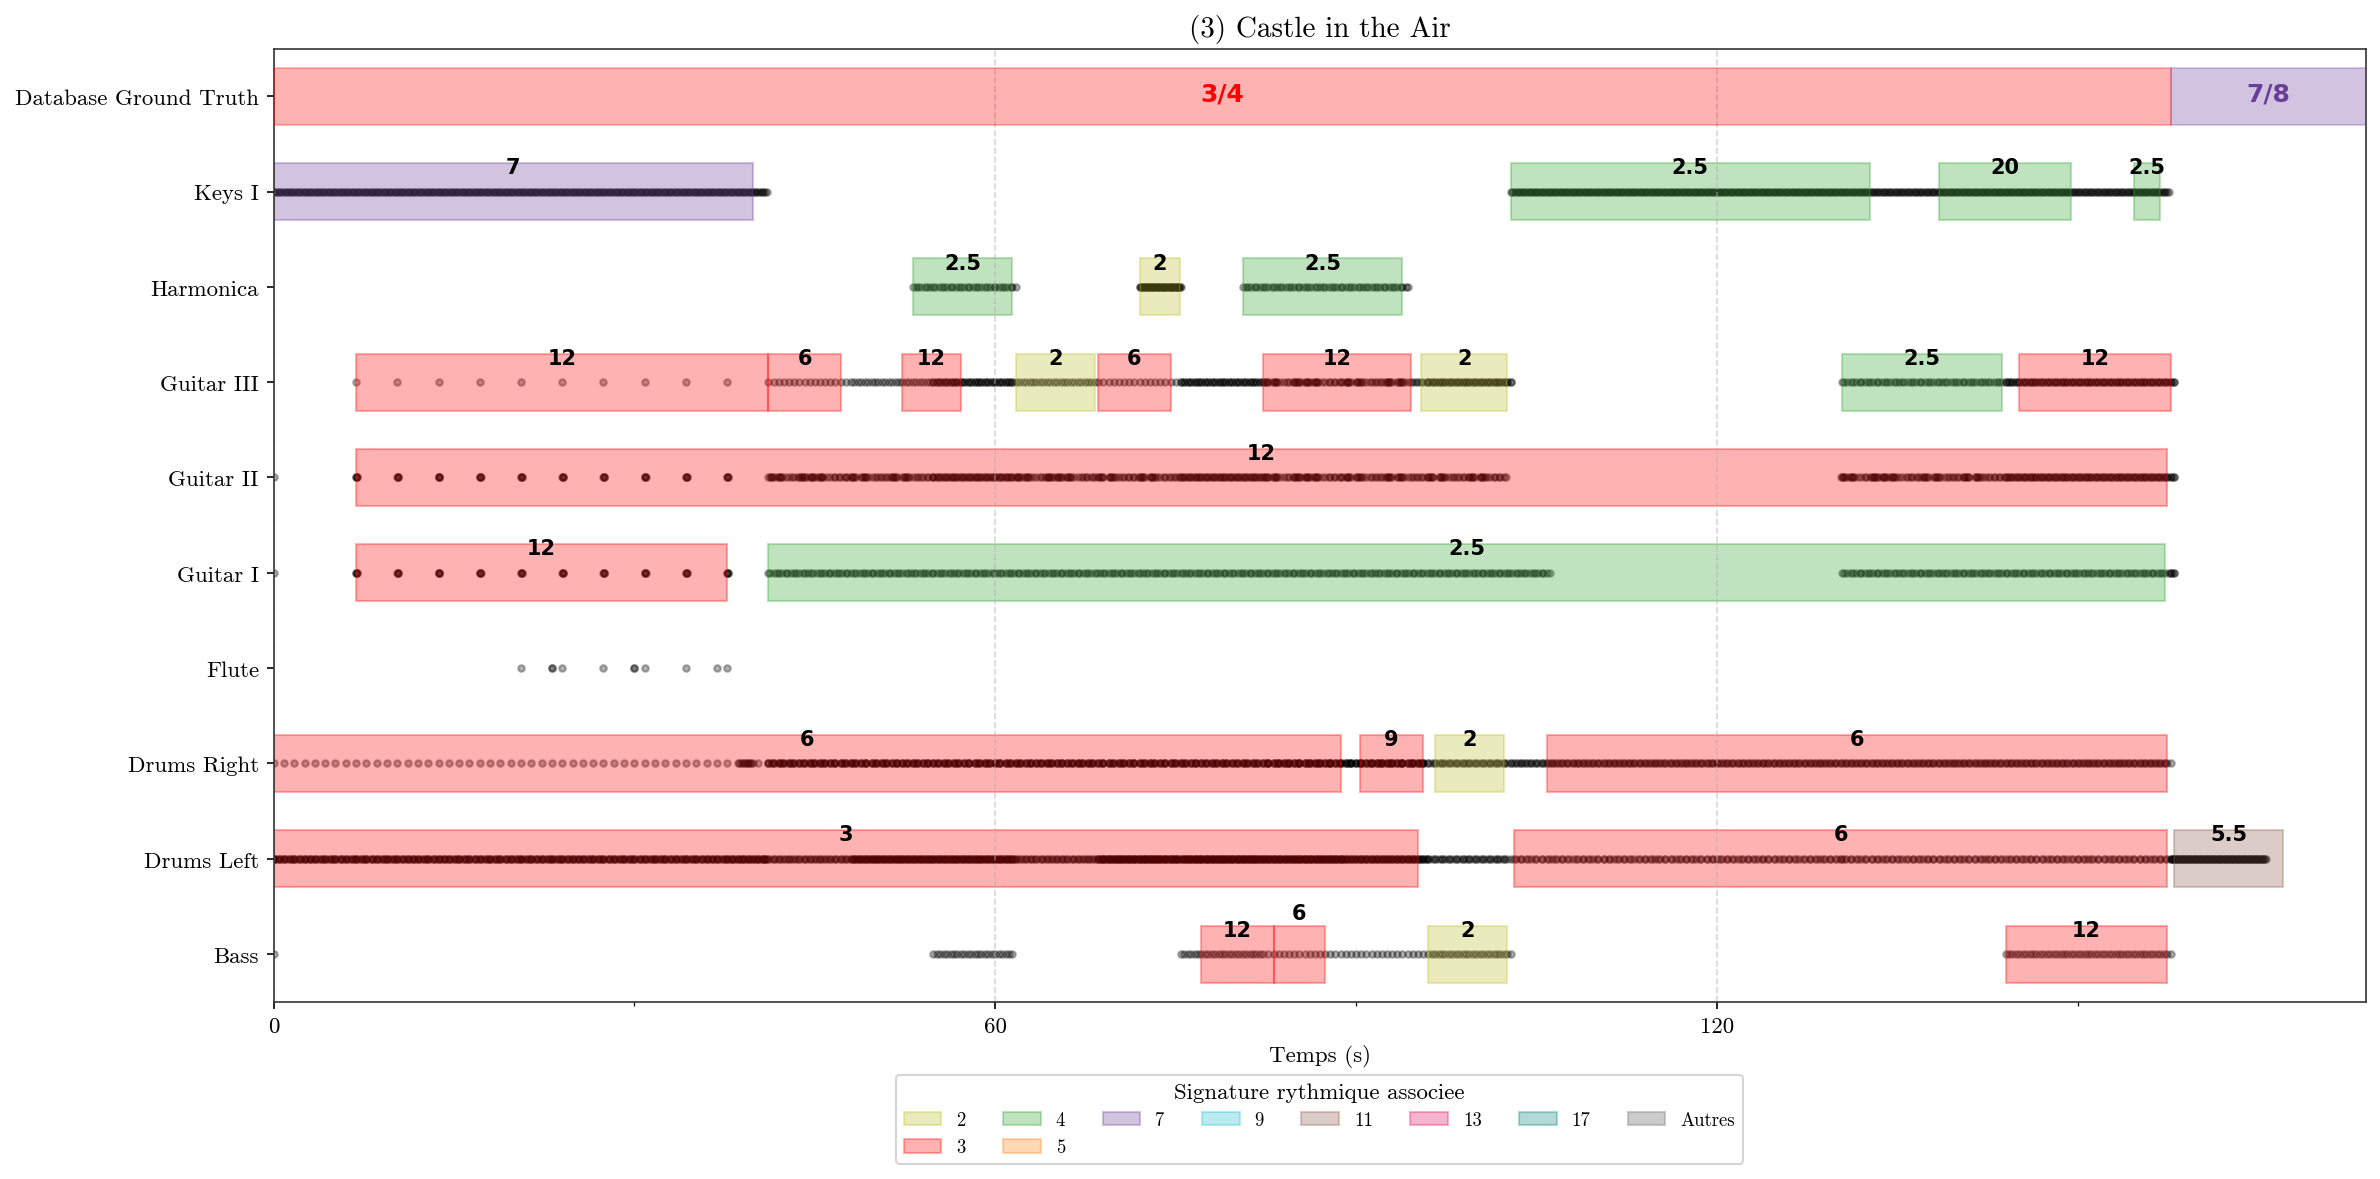

Pourcentage de points perdus : 14.35 %
Nombre de motifs: 82
Global compactness: 3.0544844928751047
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 4074.25
   • Total cumulated length covered by signature segments: 5148.50
   • Percentage of 'No Signature': 31.8%
   • Percentage of 'With Signature': 68.2%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.393887 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (3) Castle in the Air.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 68.2%
   • Without signature (gaps): 31.8%

🎵 POLYMETRIC COMPLEXITY: 0.379
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 579.8 beats
   • Number o

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


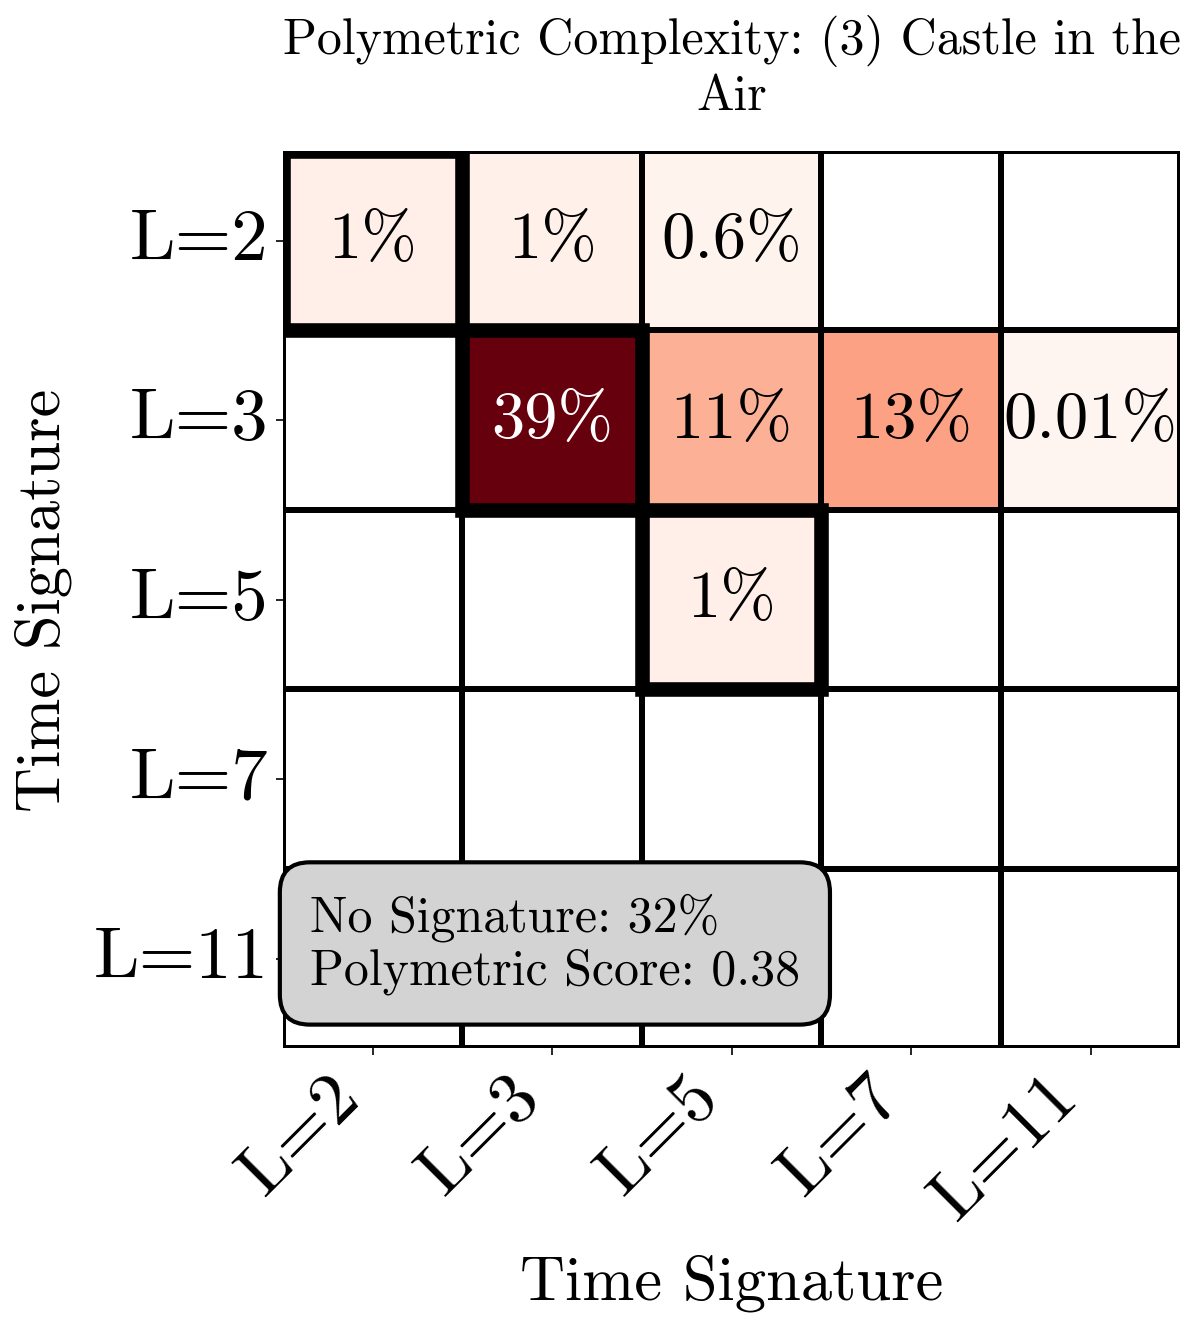

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


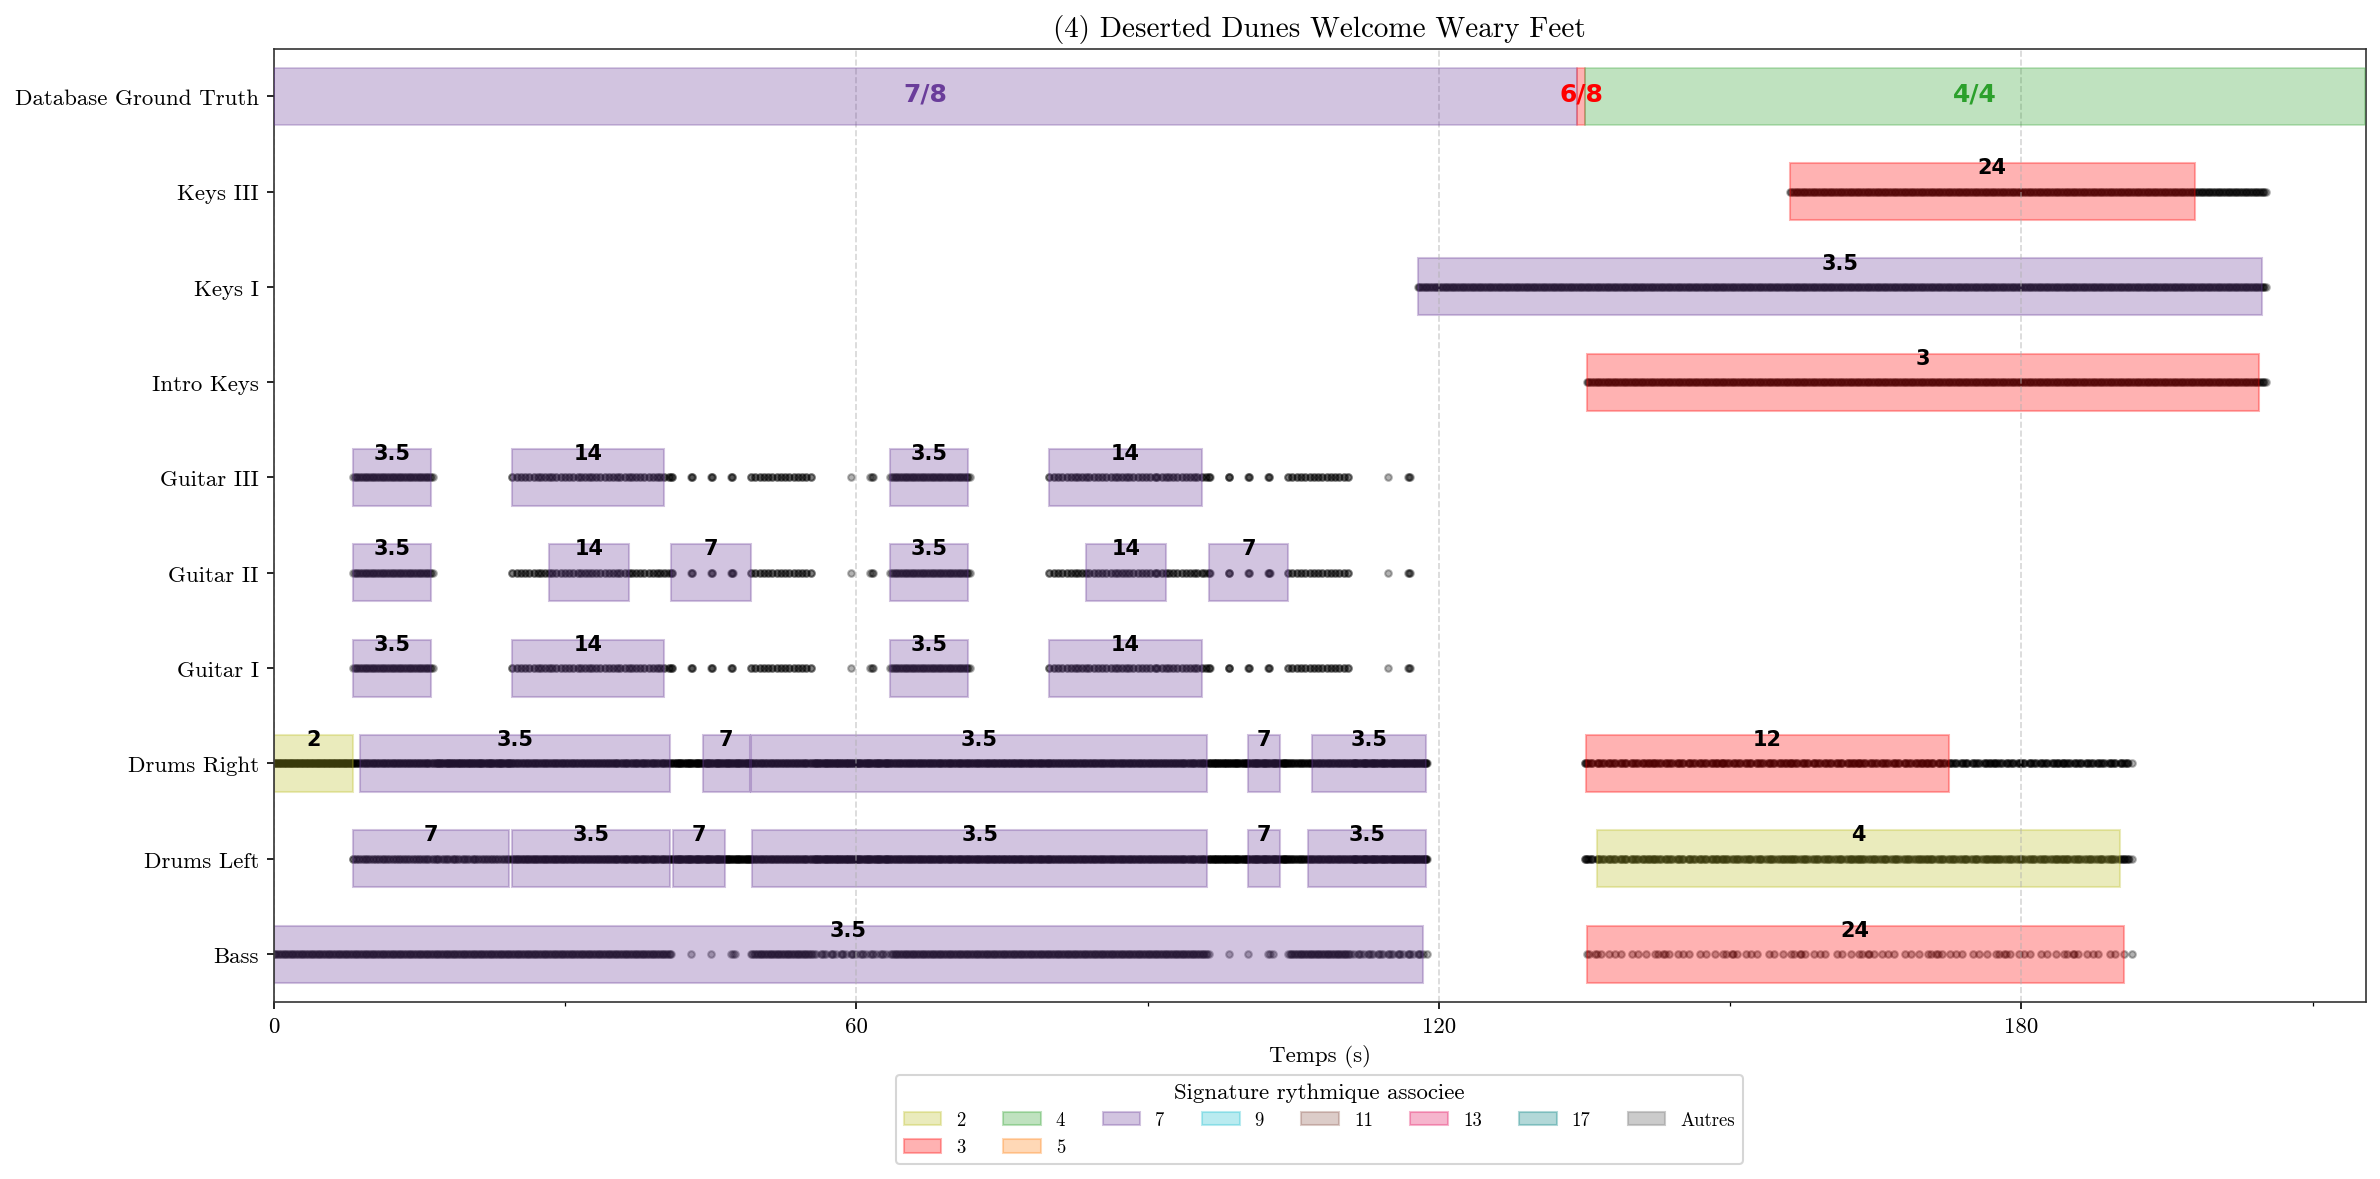

Pourcentage de points perdus : 4.37 %
Nombre de motifs: 99
Global compactness: 2.852882703777336
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 3755.00
   • Total cumulated length covered by signature segments: 7203.75
   • Percentage of 'No Signature': 22.4%
   • Percentage of 'With Signature': 77.6%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.331540 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (4) Deserted Dunes Welcome Weary Feet.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 77.6%
   • Without signature (gaps): 22.4%

🎵 POLYMETRIC COMPLEXITY: 0.410
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 701.0 beats

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


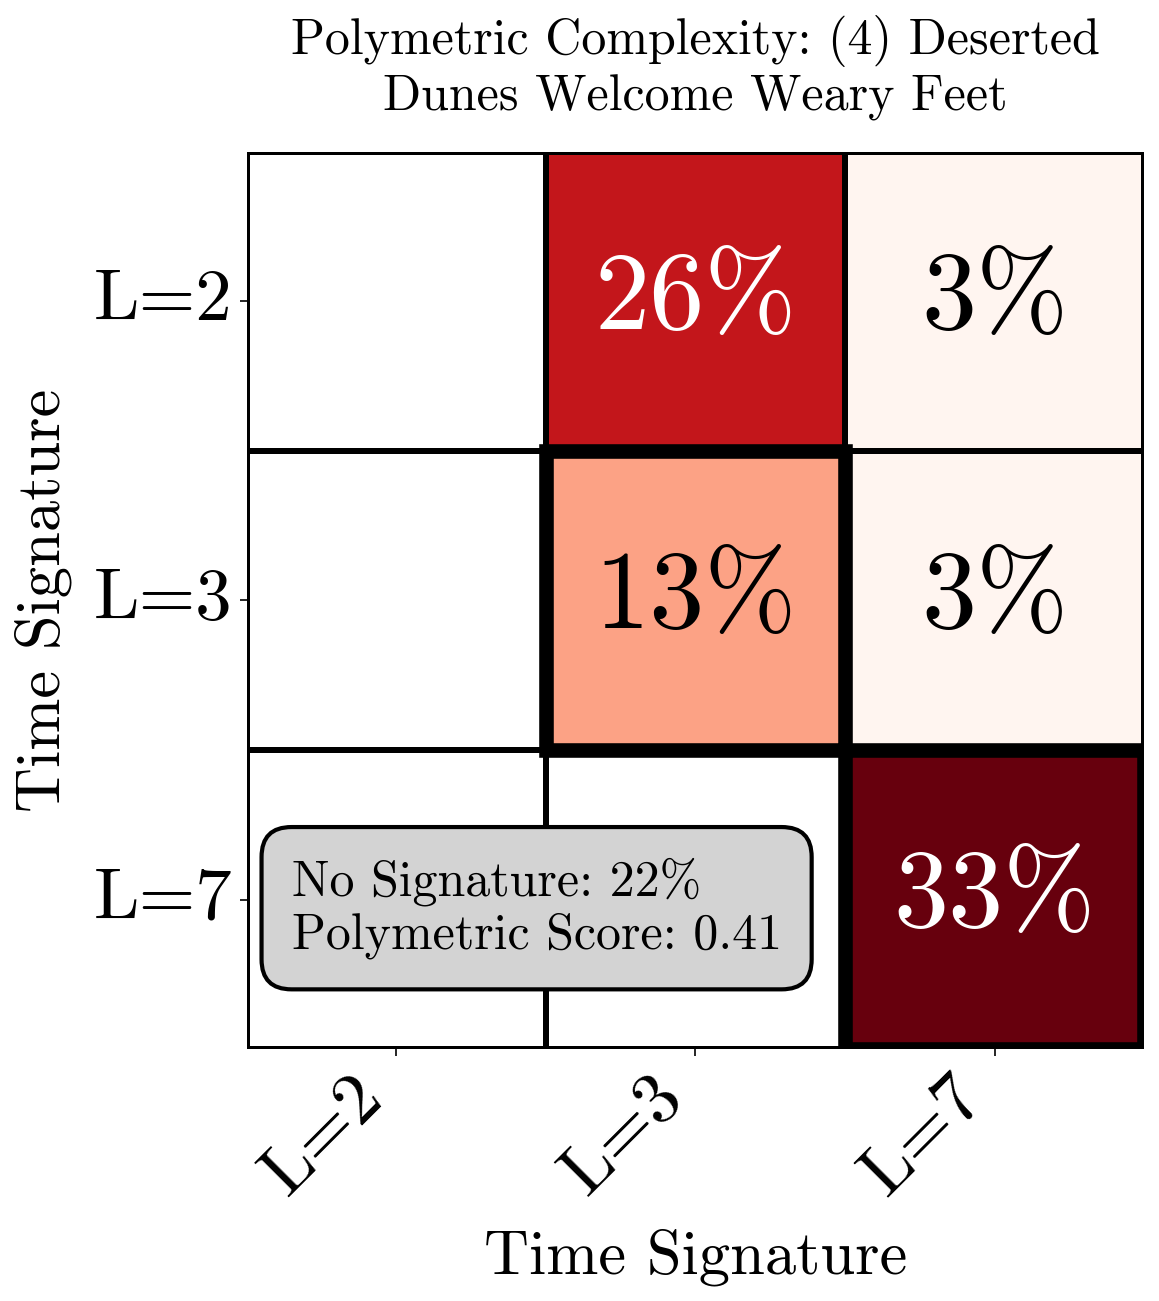

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


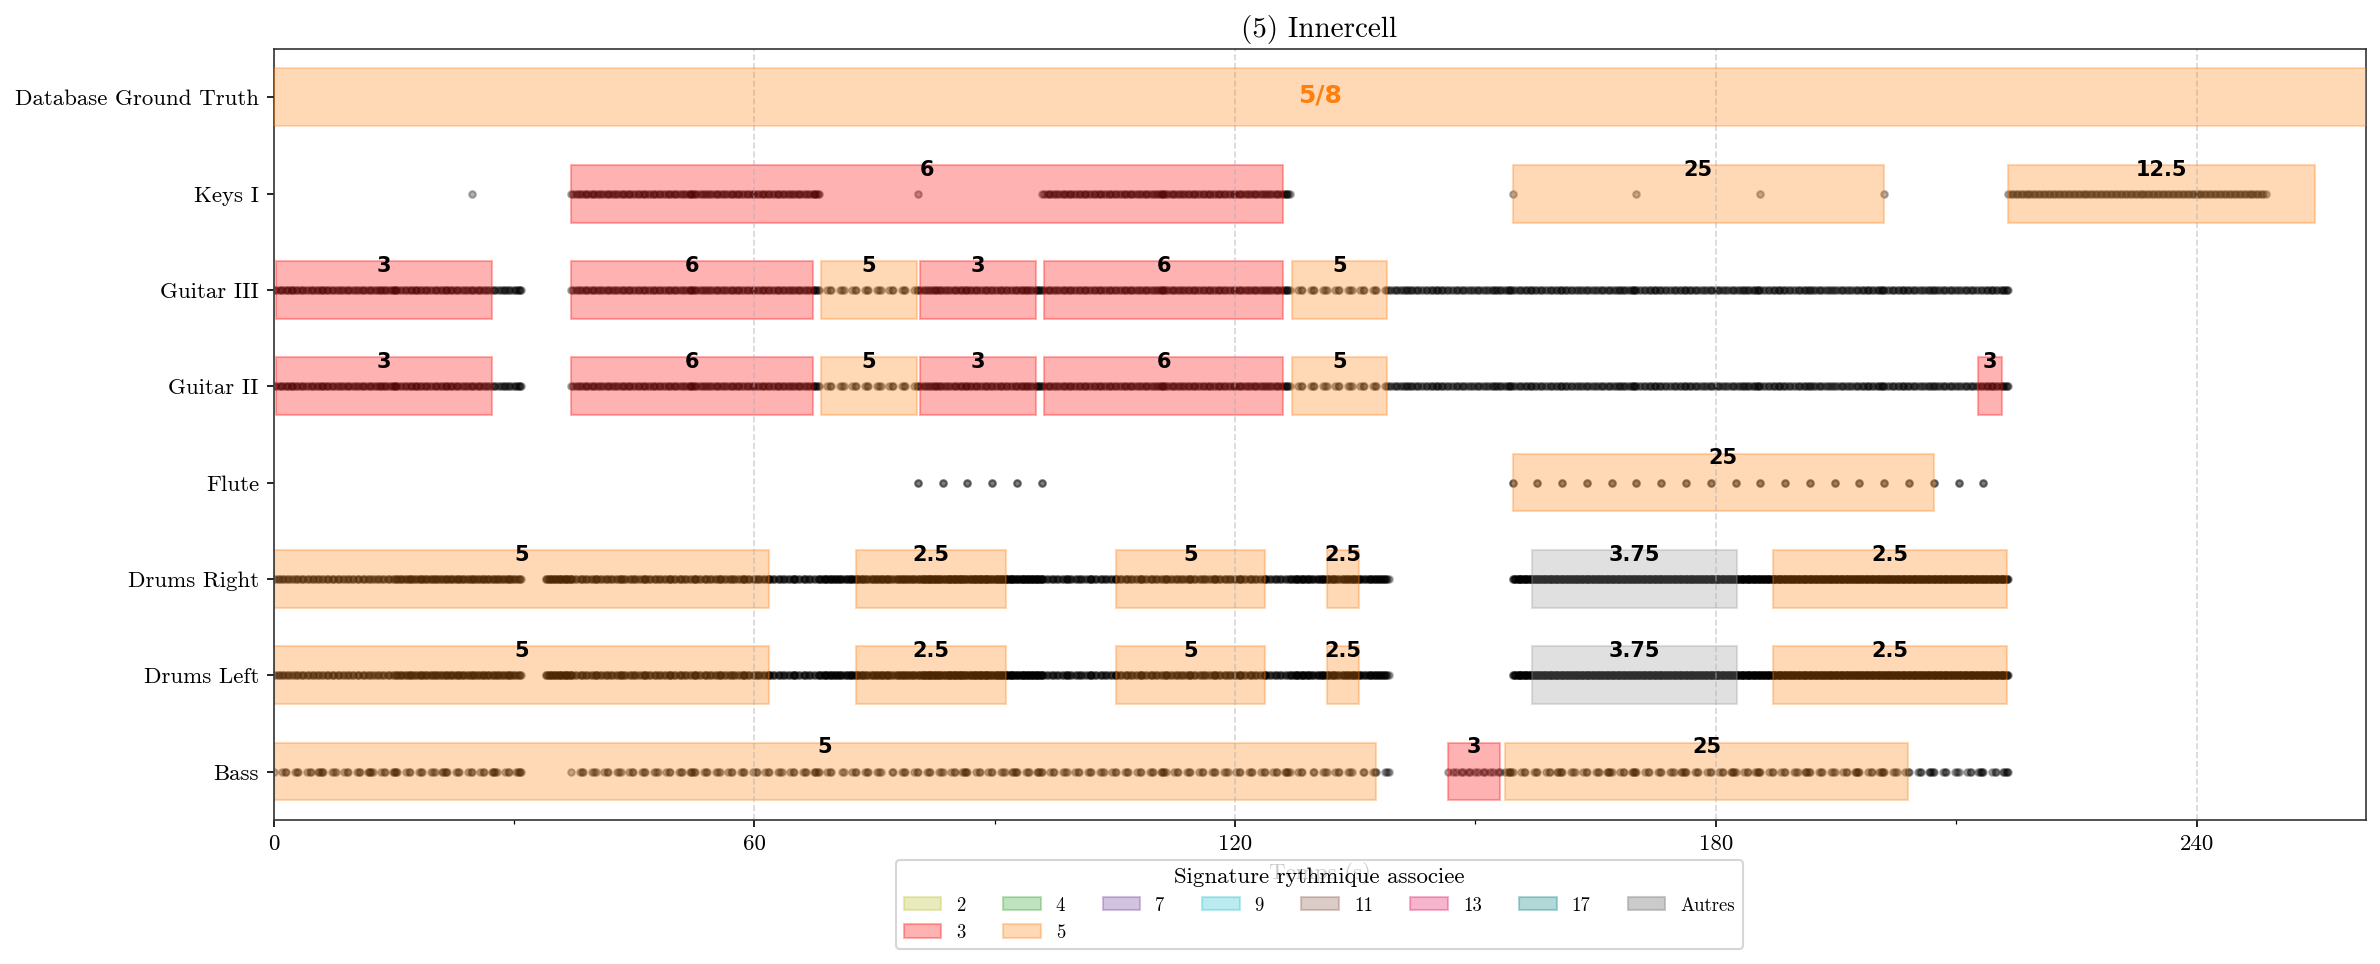

Pourcentage de points perdus : 20.03 %
Nombre de motifs: 115
Global compactness: 1.3490788852149267
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 2327.00
   • Total cumulated length covered by signature segments: 3737.25
   • Percentage of 'No Signature': 30.2%
   • Percentage of 'With Signature': 69.8%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.453990 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (5) Innercell.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 69.8%
   • Without signature (gaps): 30.2%

🎵 POLYMETRIC COMPLEXITY: 0.226
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 402.0 beats
   • Number of instr

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


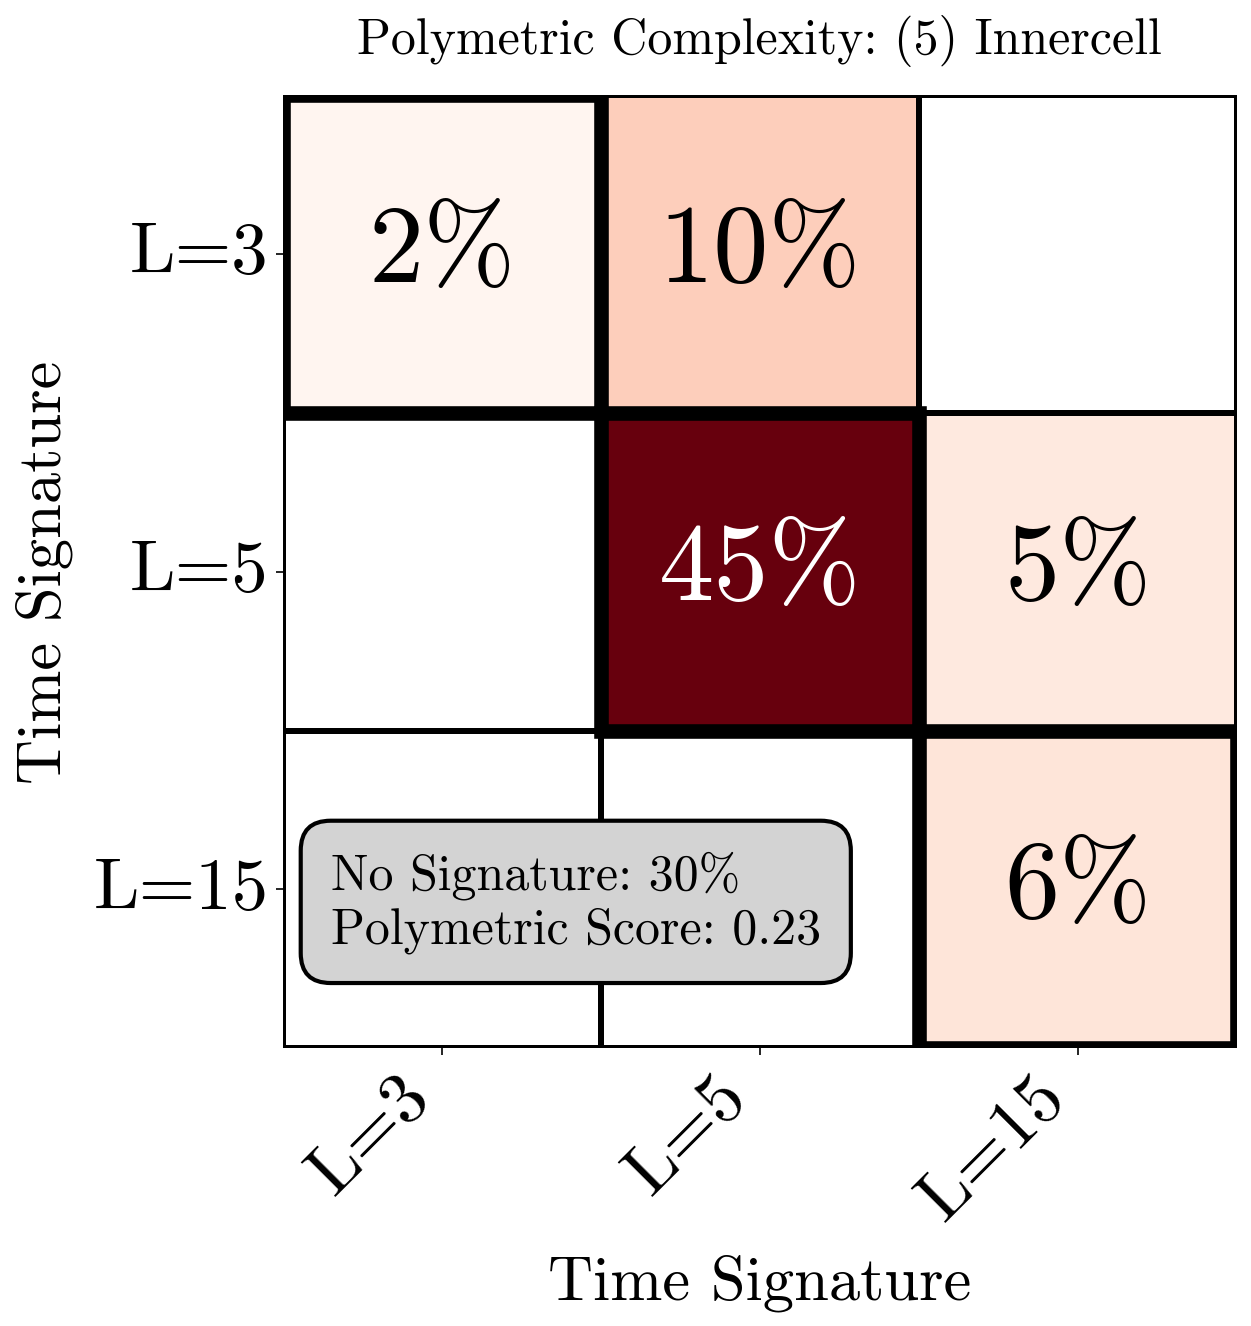

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


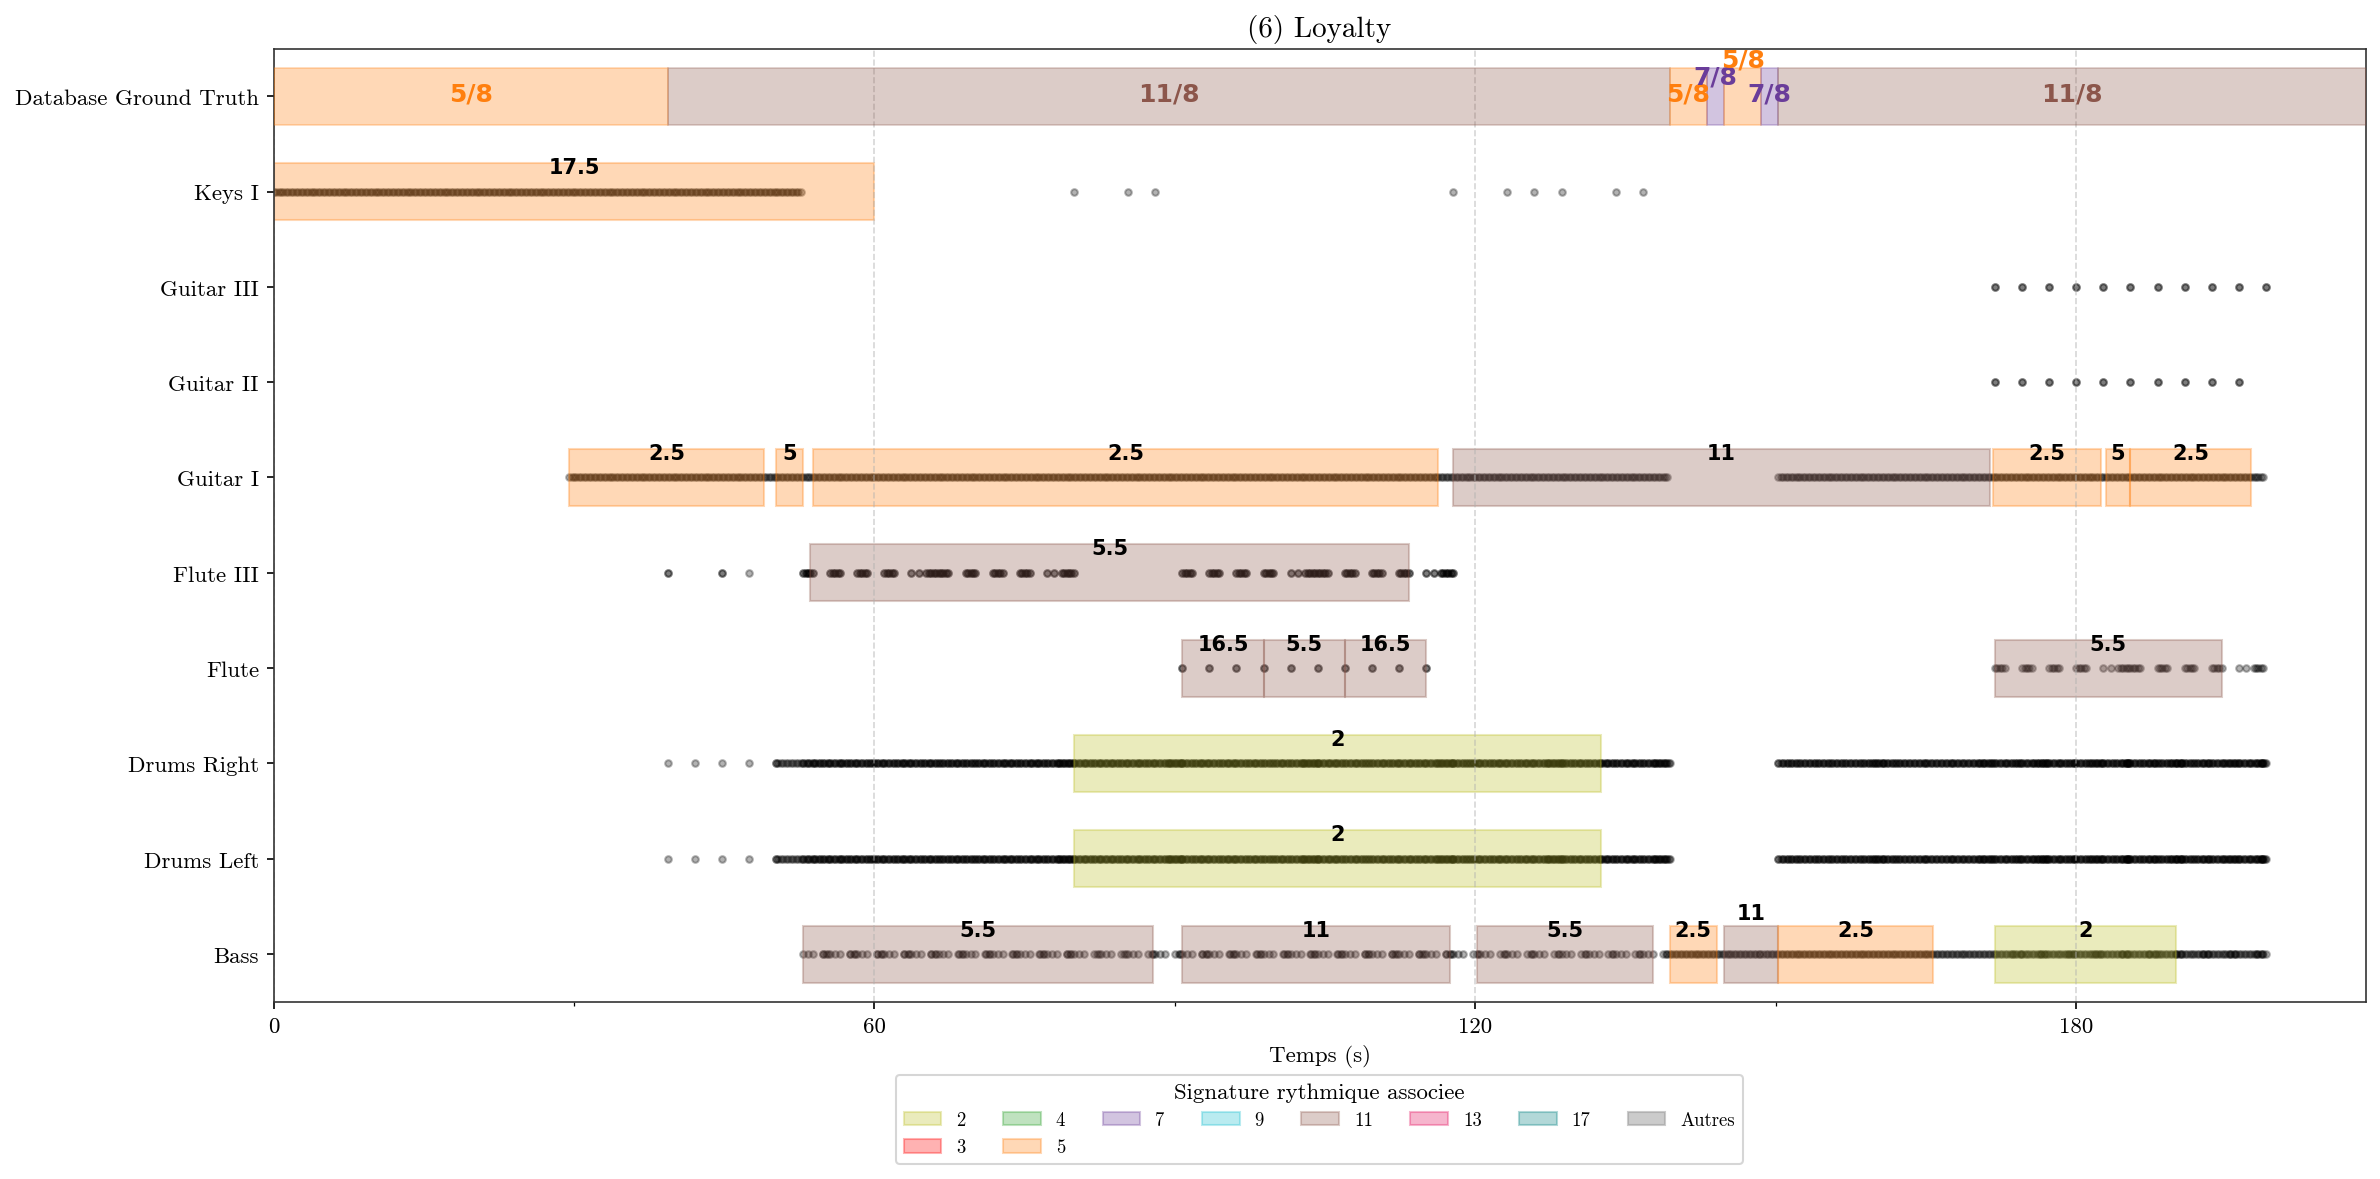

Pourcentage de points perdus : 46.22 %
Nombre de motifs: 61
Global compactness: 1.5725541694024952
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 2051.50
   • Total cumulated length covered by signature segments: 1527.00
   • Percentage of 'No Signature': 49.9%
   • Percentage of 'With Signature': 50.1%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.499230 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (6) Loyalty.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 50.1%
   • Without signature (gaps): 49.9%

🎵 POLYMETRIC COMPLEXITY: 0.470
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 404.5 beats
   • Number of instrume

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


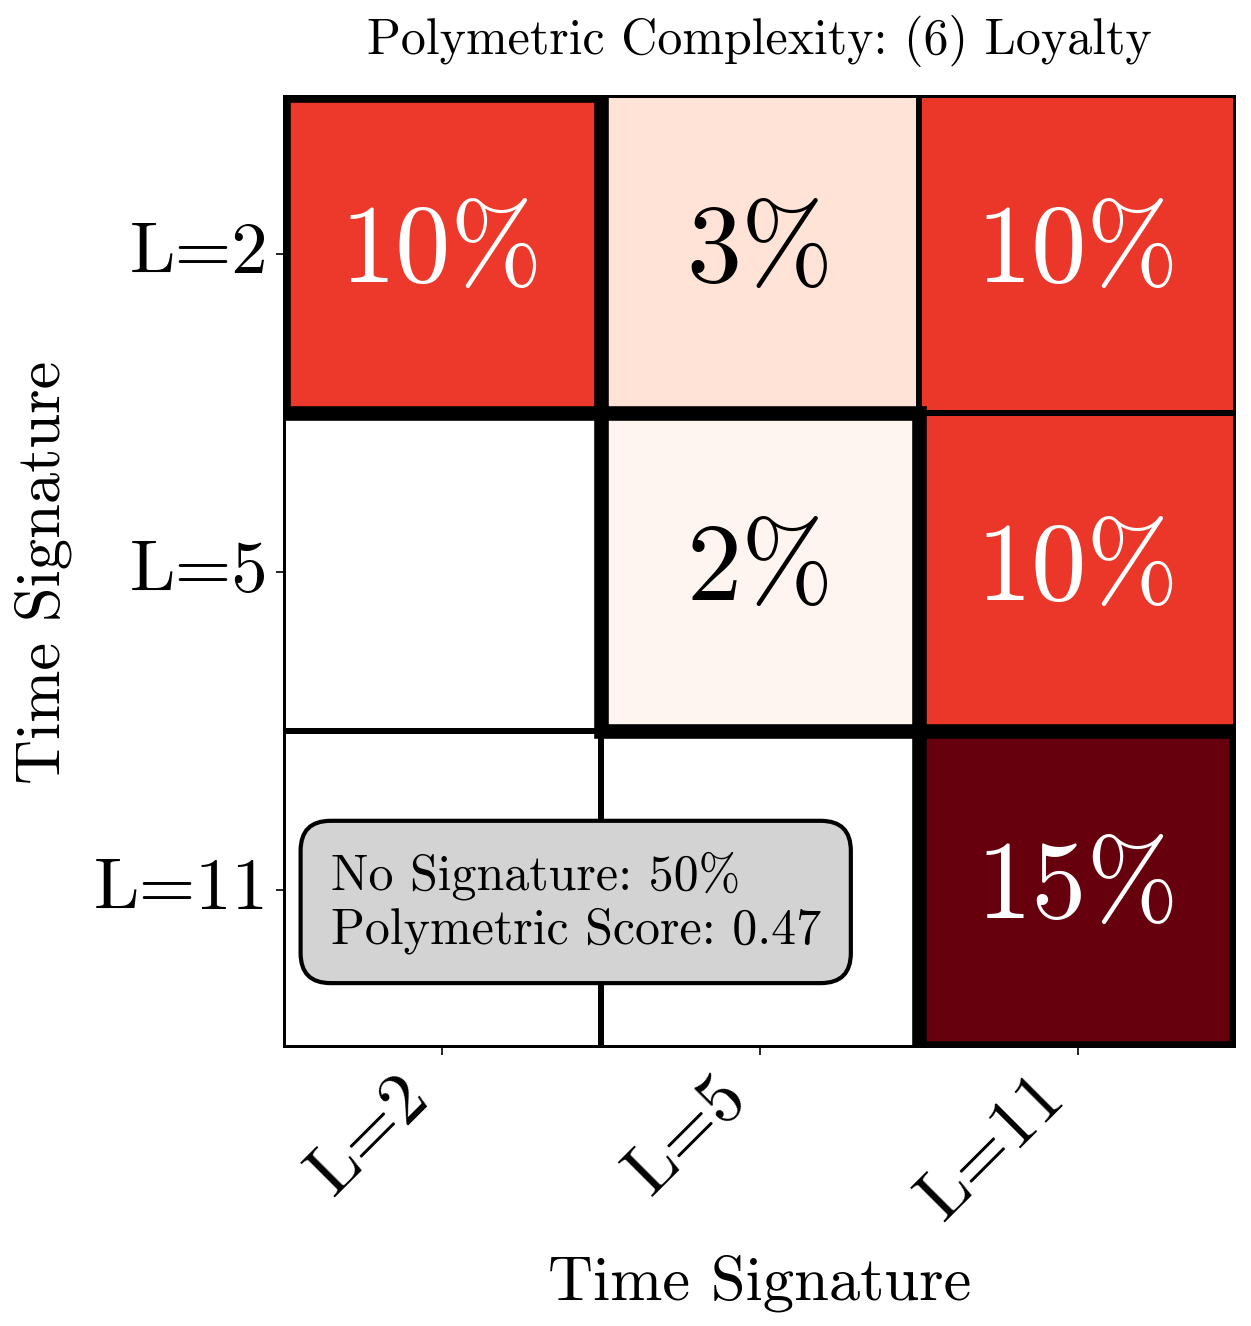

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


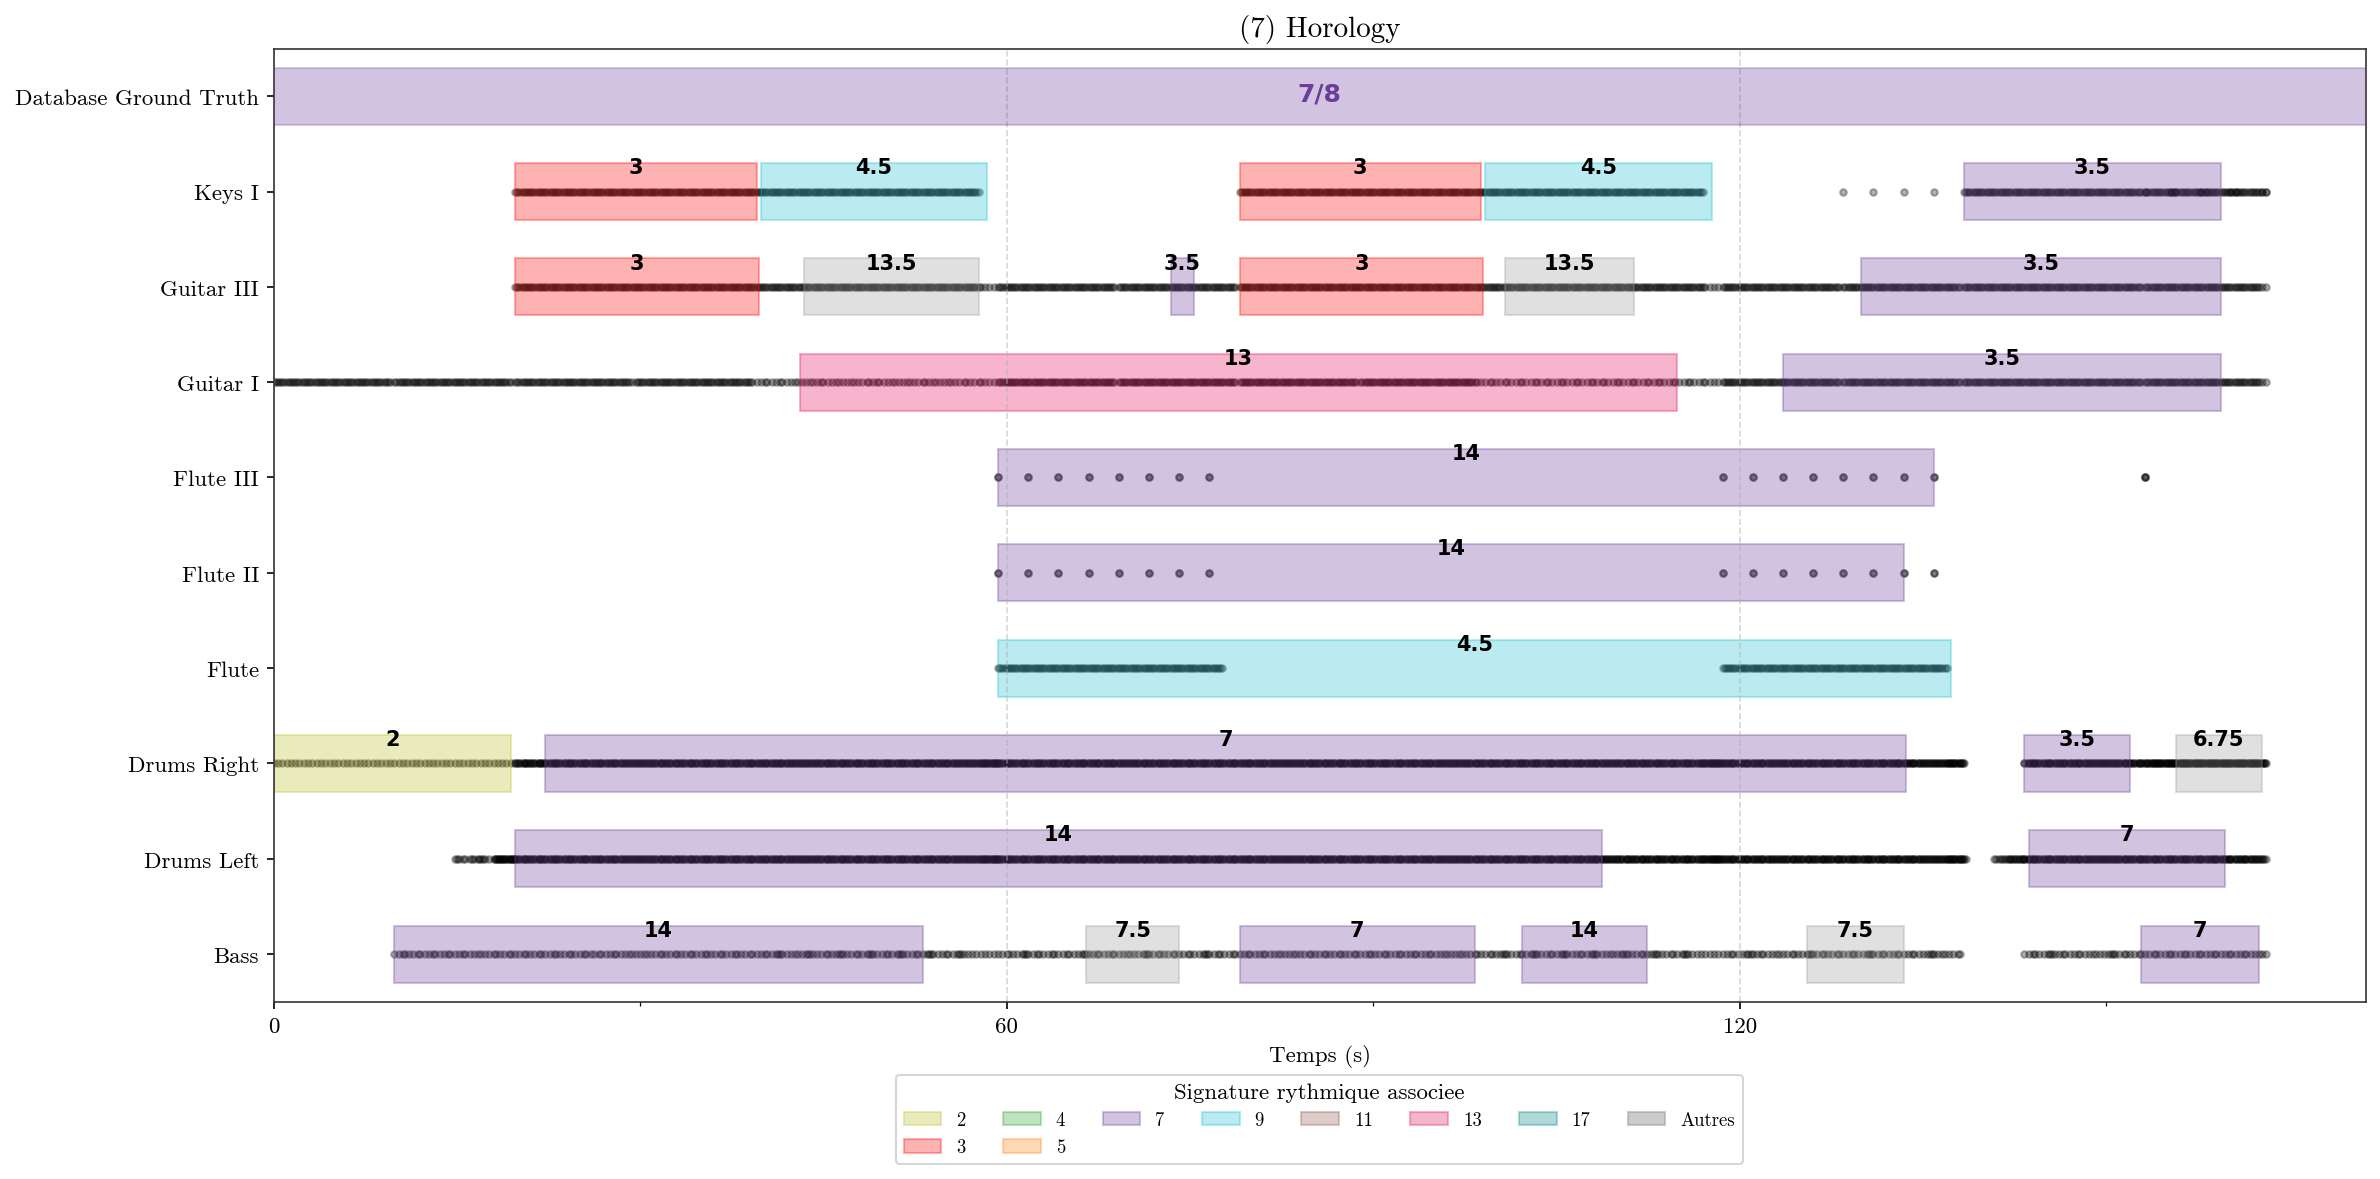

Pourcentage de points perdus : 28.97 %
Nombre de motifs: 95
Global compactness: 1.4091695501730104
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 3293.00
   • Total cumulated length covered by signature segments: 4989.00
   • Percentage of 'No Signature': 38.2%
   • Percentage of 'With Signature': 61.8%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.393935 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (7) Horology.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 61.8%
   • Without signature (gaps): 38.2%

🎵 POLYMETRIC COMPLEXITY: 0.356
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 462.0 beats
   • Number of instrum

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


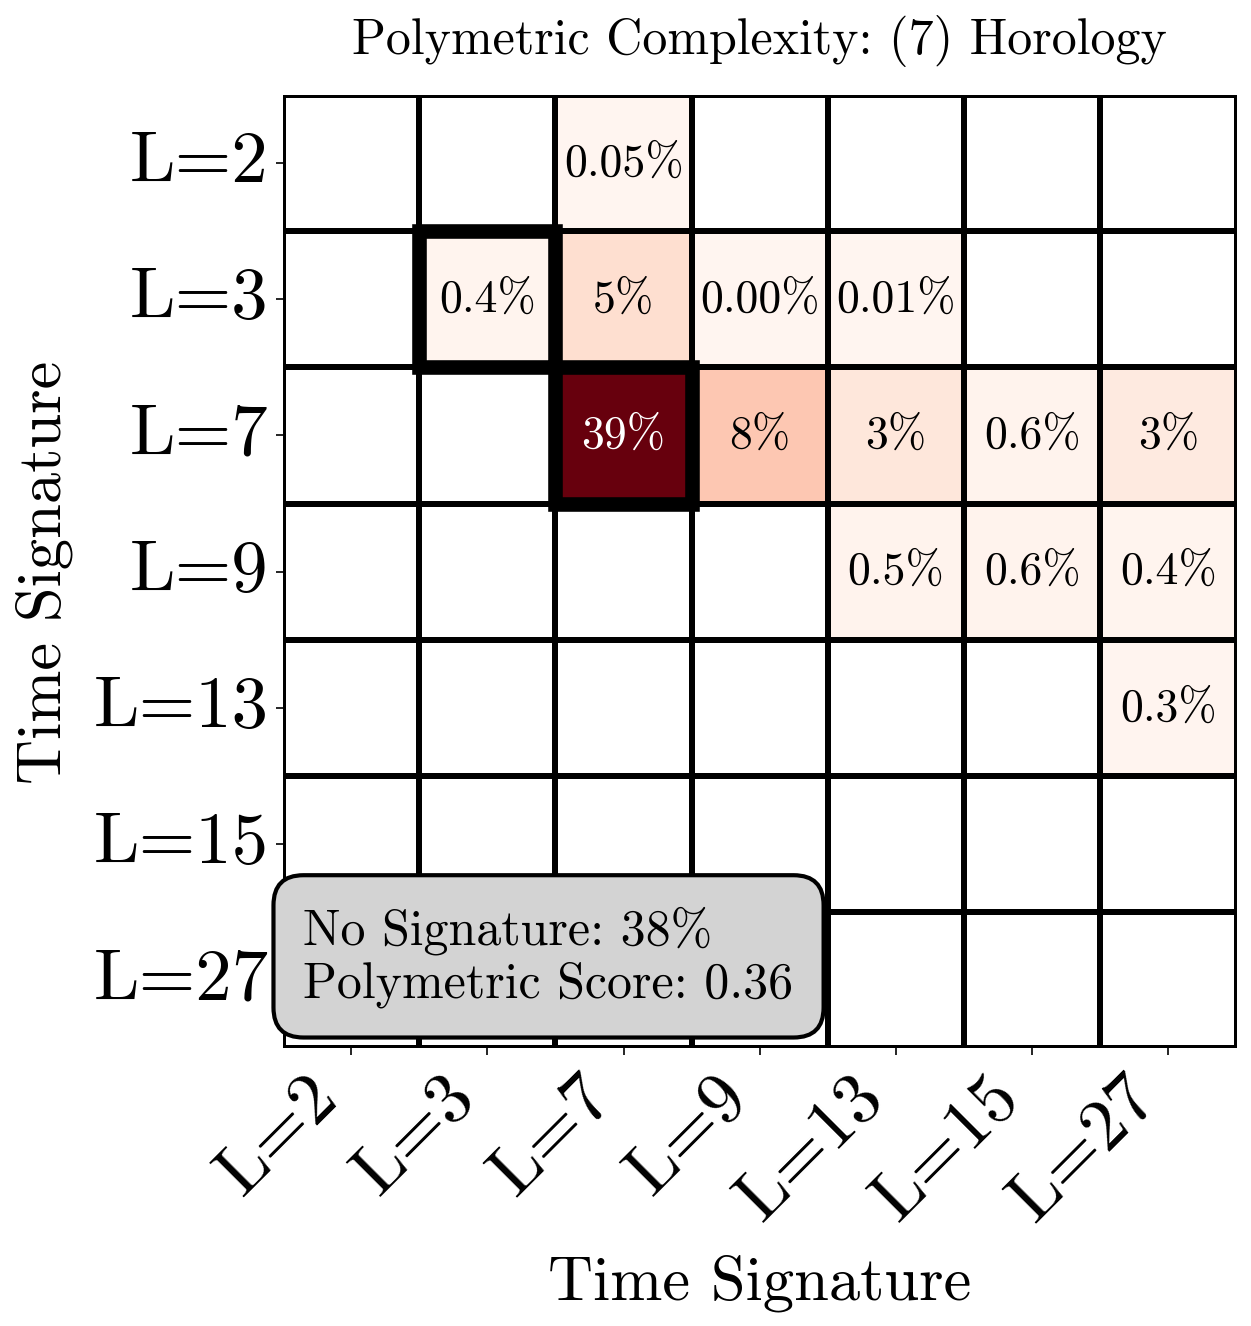

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


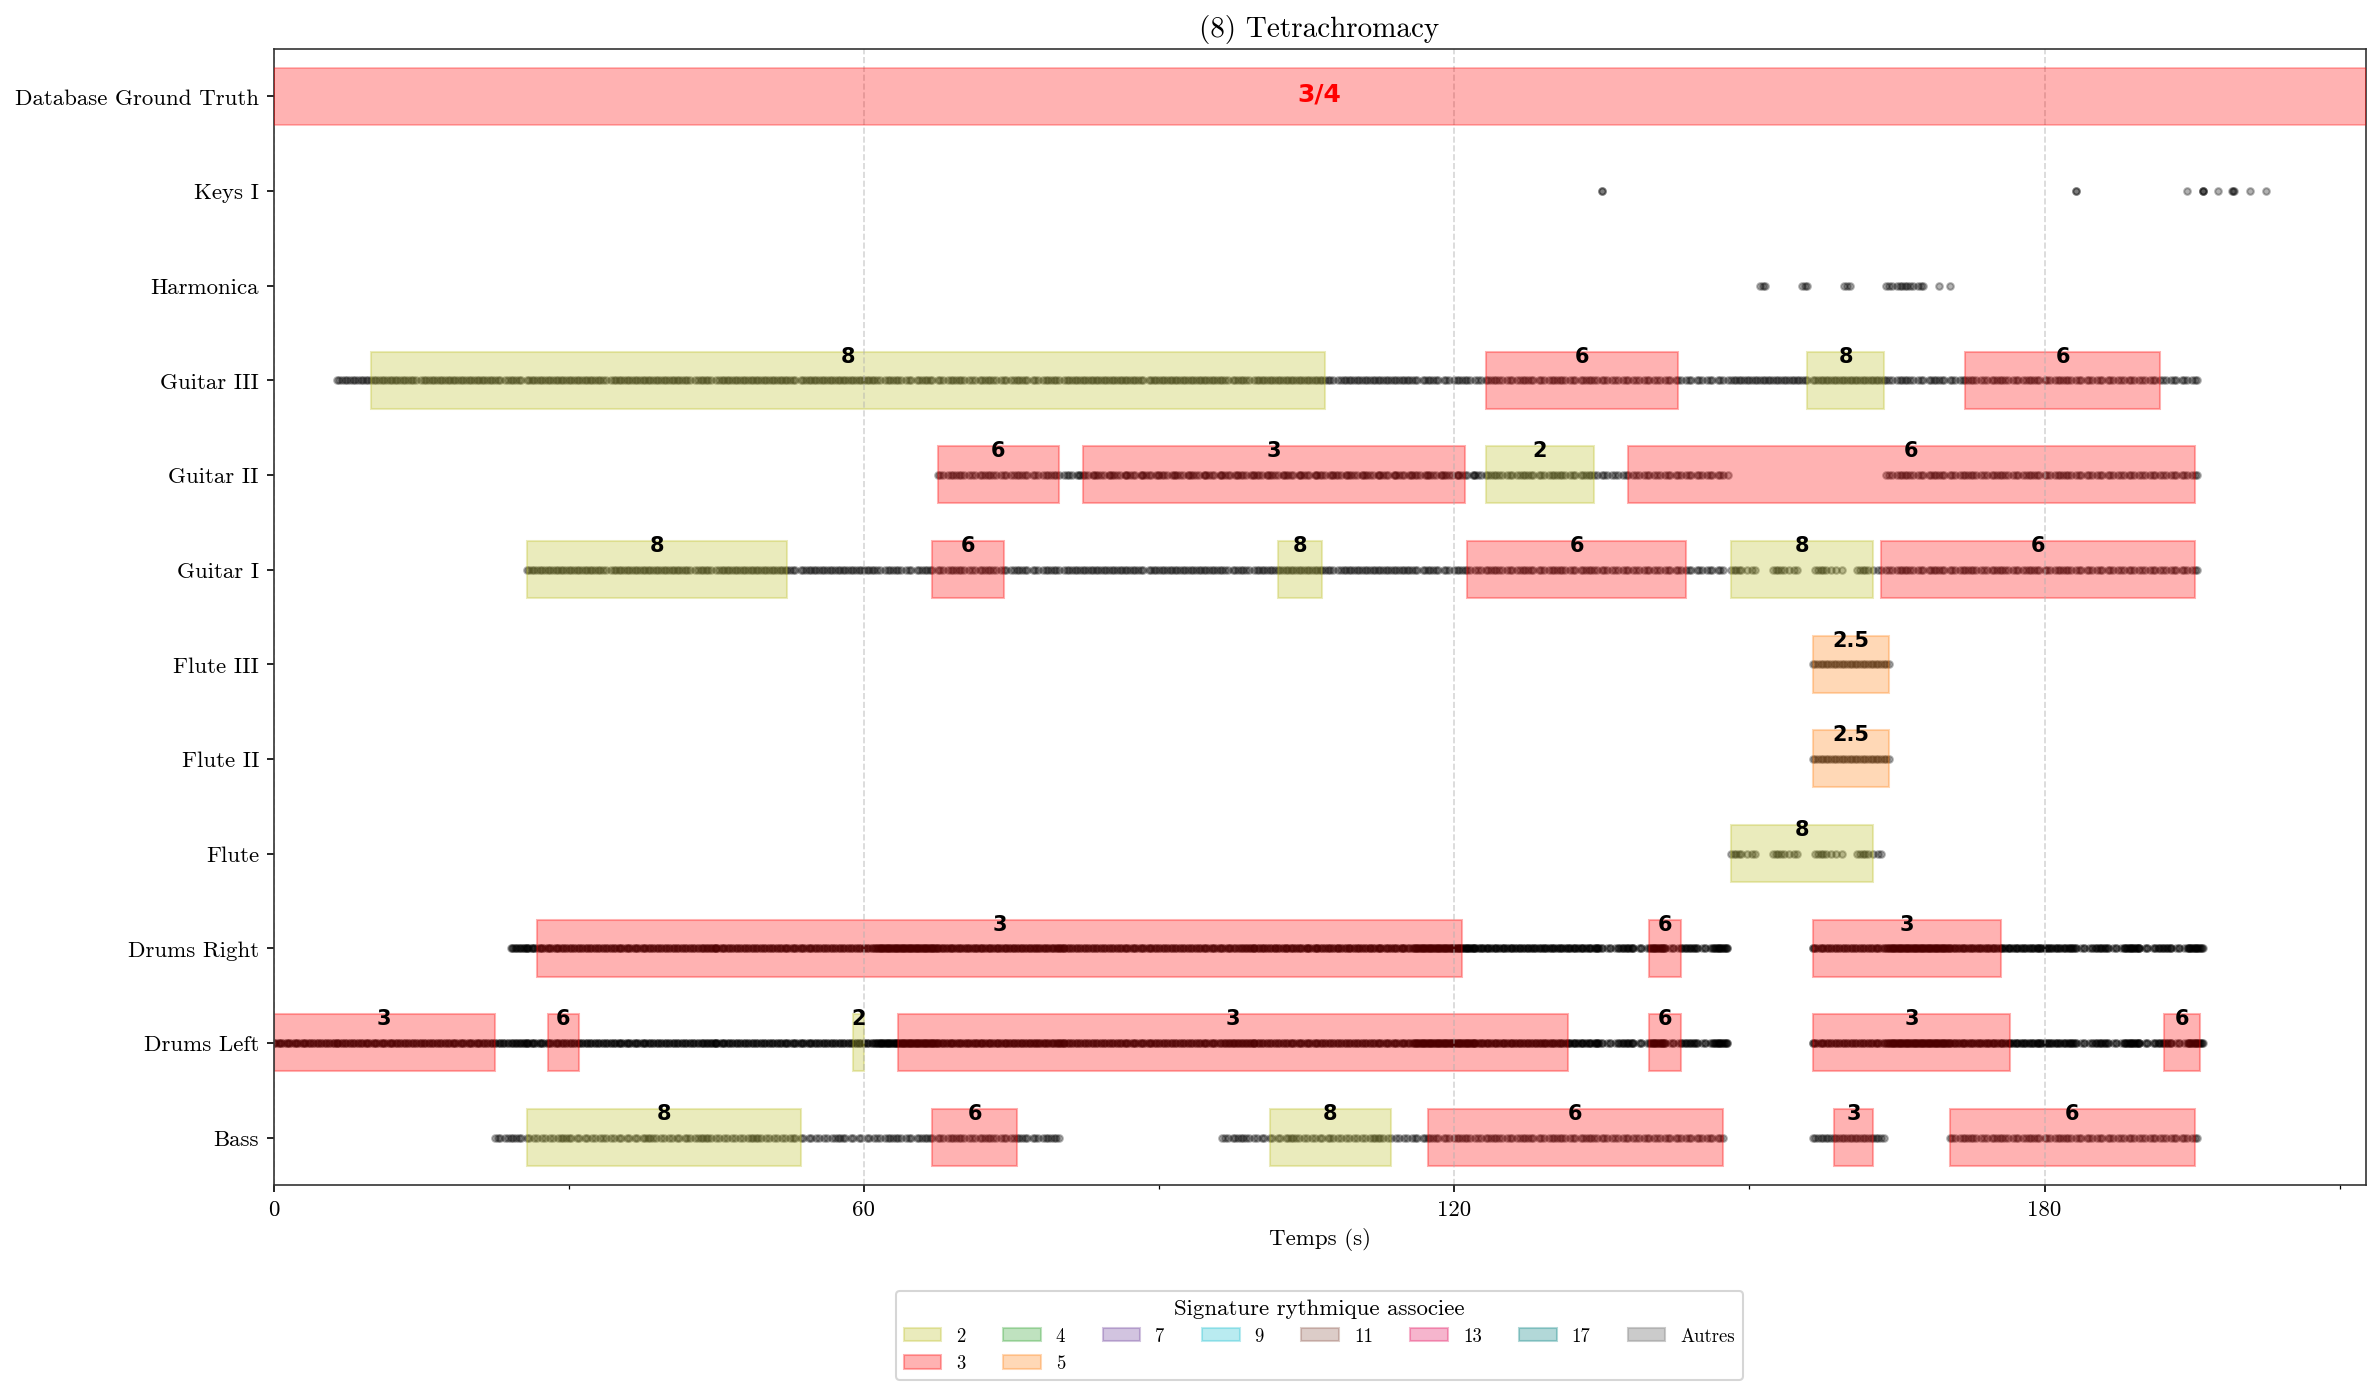

Pourcentage de points perdus : 36.08 %
Nombre de motifs: 86
Global compactness: 1.462809917355372
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 2138.50
   • Total cumulated length covered by signature segments: 1839.00
   • Percentage of 'No Signature': 29.8%
   • Percentage of 'With Signature': 70.2%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.484878 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (8) Tetrachromacy.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 70.2%
   • Without signature (gaps): 29.8%

🎵 POLYMETRIC COMPLEXITY: 0.192
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 378.0 beats
   • Number of ins

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


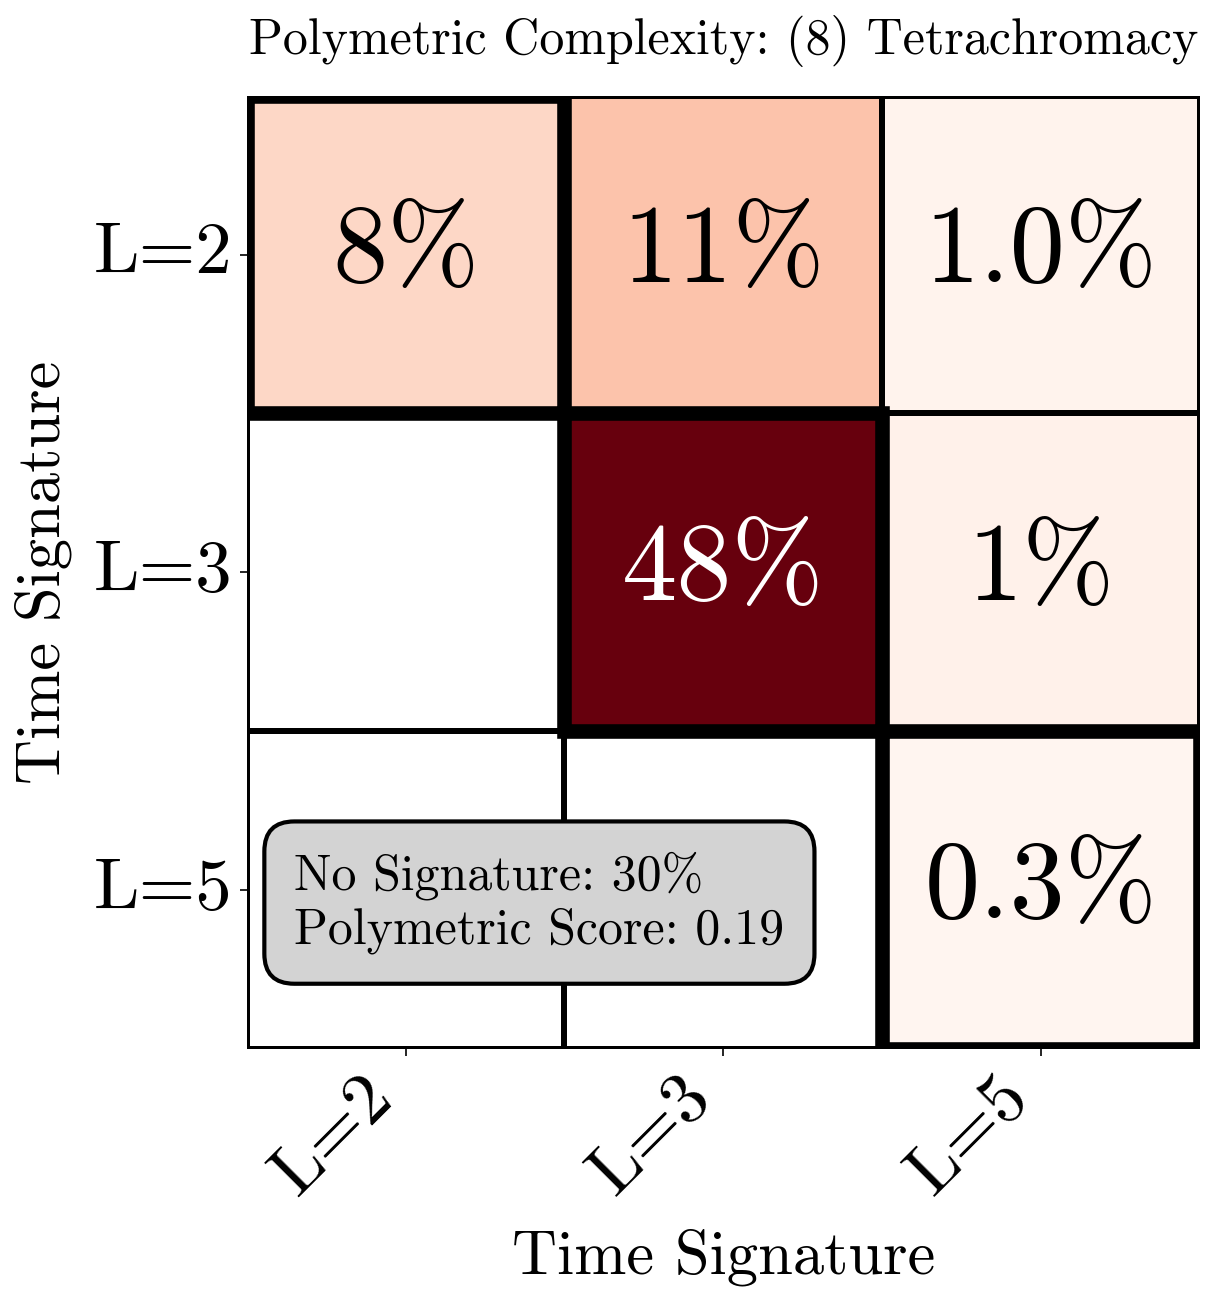

/tmp/ipython-input-3813062772.py:569: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


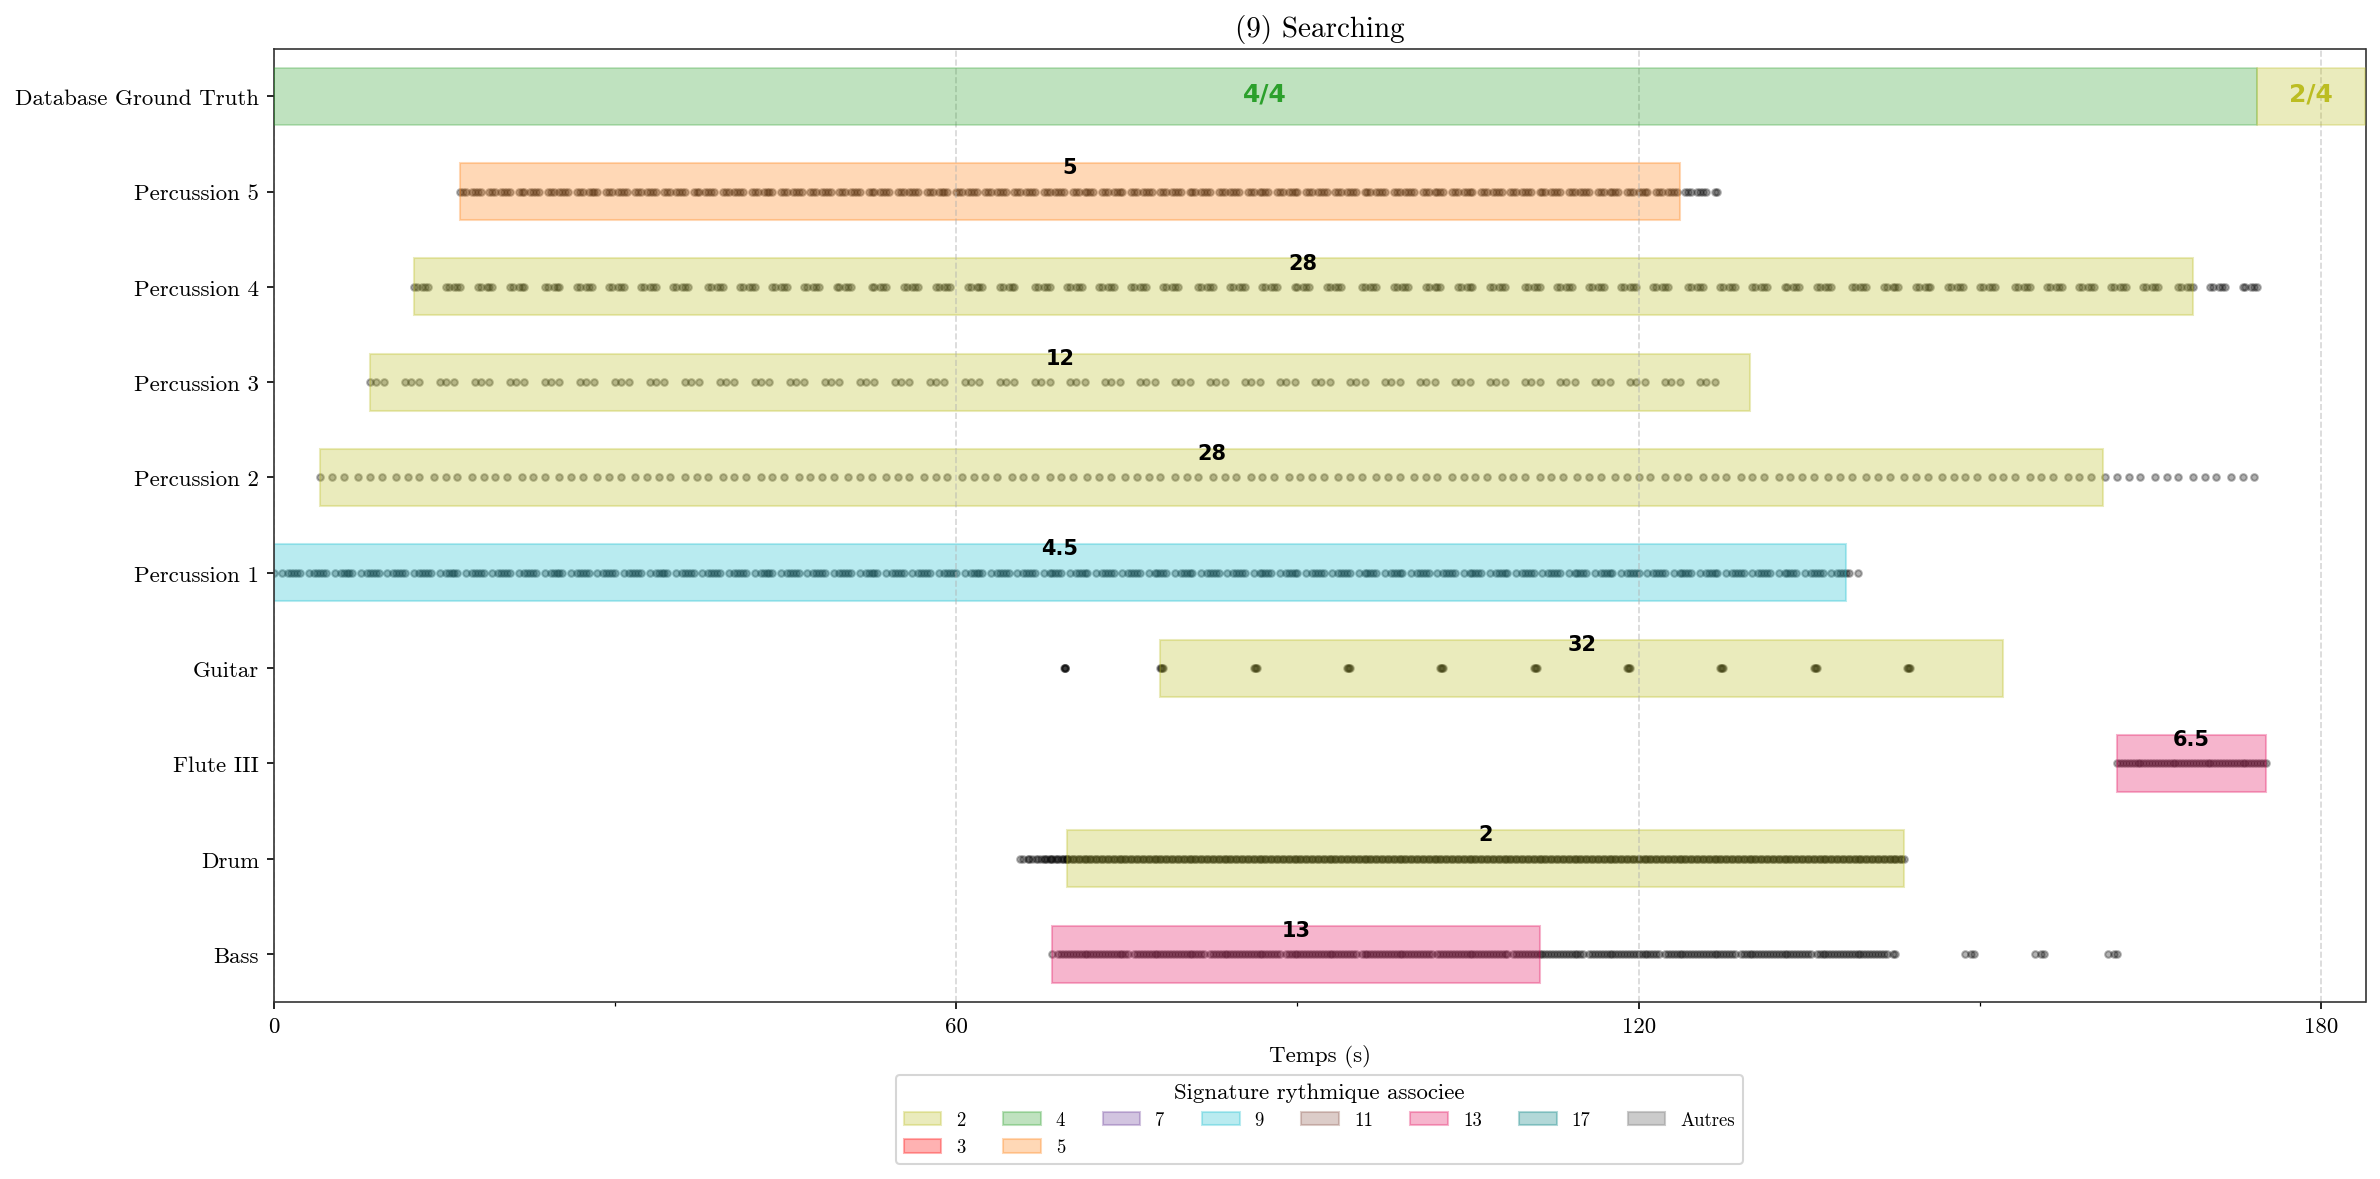

Pourcentage de points perdus : 3.87 %
Nombre de motifs: 59
Global compactness: 2.982456140350877
🔍 PERCENTAGE CALCULATION: 
   • Total cumulated track length: 1869.50
   • Total cumulated length covered by signature segments: 14252.00
   • Percentage of 'No Signature': 4.4%
   • Percentage of 'With Signature': 95.6%
   • Somme finale du grid: 1.000000 (devrait être ≈ 1.0)

🔍 CHECKING PROPORTIONS (Triangular):
   • Upper triangle sum: 1.000000 (should be ≈ 1.0)
   • Max value: 0.370174 (should be ≤ 1.0)
   • Min value: 0.000000 (should be ≥ 0.0)
   ✅ Proportions are correct
   ✅ All values are within [0,1]

POLYMETRIC ANALYSIS WITH PRE-CALCULATED GAPS: (9) Searching.mid

📊 RHYTHMIC SIGNATURE COVERAGE (PRE-CALCULATED):
   • With detected signature: 95.6%
   • Without signature (gaps): 4.4%

🎵 POLYMETRIC COMPLEXITY: 0.914
   (0 = purely homometric, 1 = purely polymetric)
   (calculated only on zones with a signature)

📈 STATISTICS:
   • Total duration: 341.5 beats
   • Number of instrumen

/tmp/ipython-input-3580288092.py:273: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=figsize)


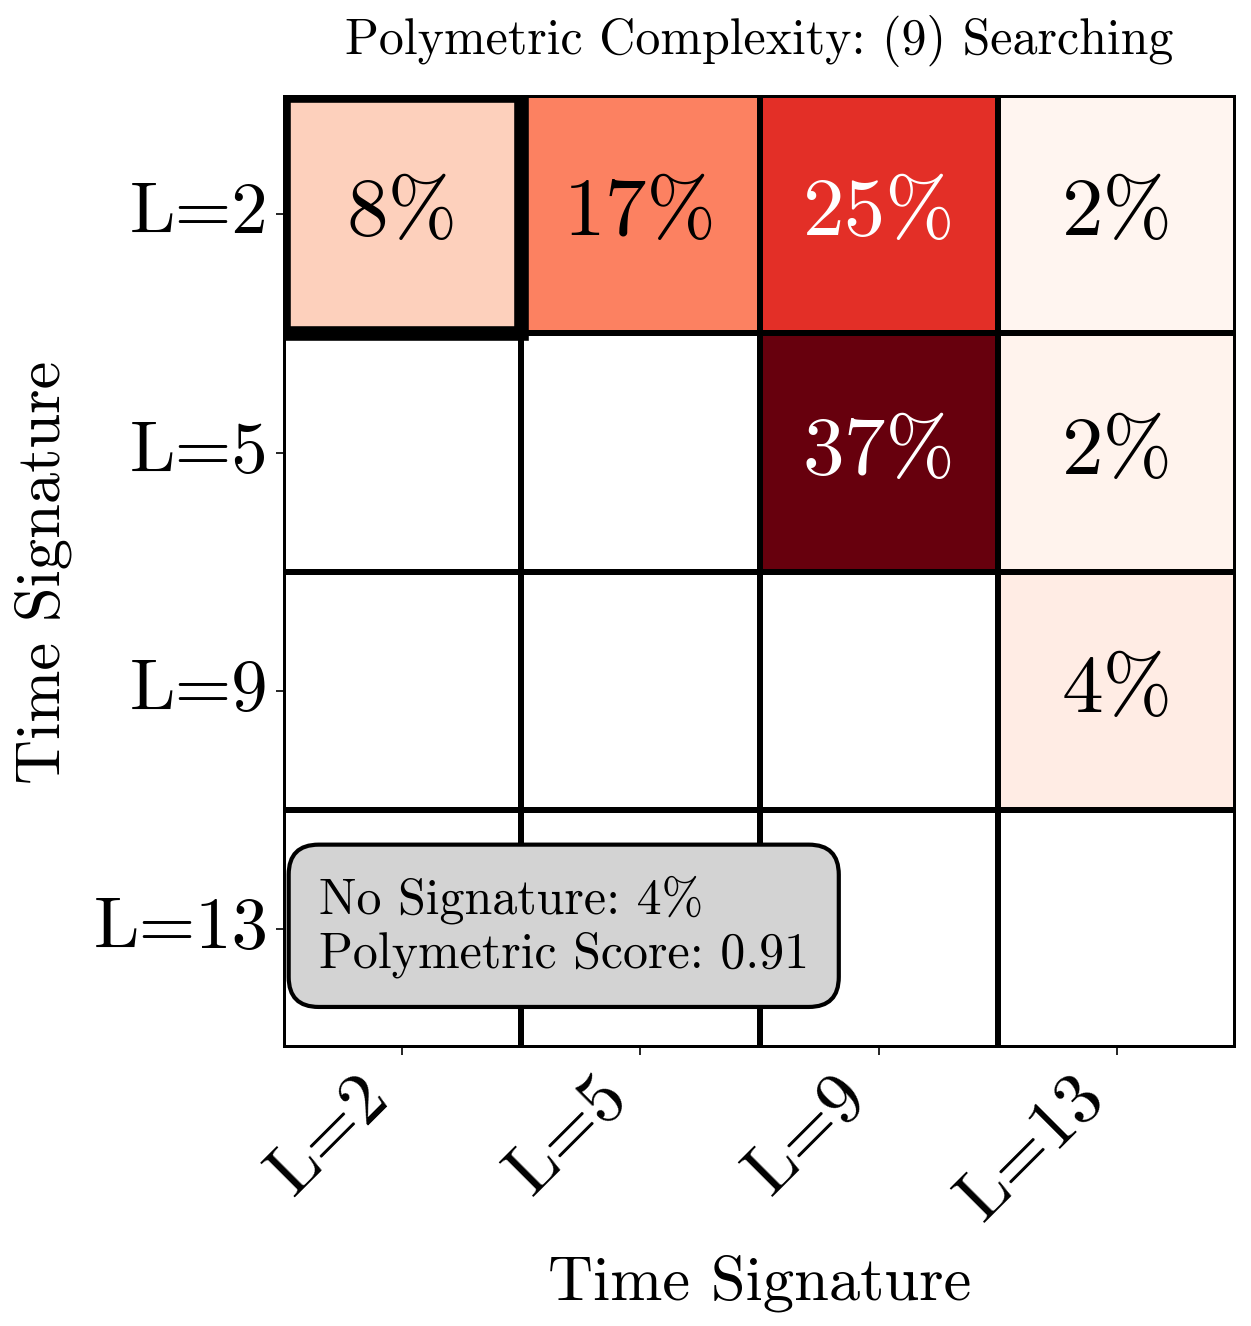

In [ ]:
pieces_name = ["(1) Crumbling Castle.mid", "(2) Polygondwanaland.mid", "(3) Castle in the Air.mid", "(4) Deserted Dunes Welcome Weary Feet.mid", "(5) Innercell.mid", "(6) Loyalty.mid",  "(7) Horology.mid", "(8) Tetrachromacy.mid","(9) Searching.mid"] #, "(10) The Fourth Colour.mid"]

folder_path = "/content/drive/MyDrive/Pattern_Detection/MIDI_Source/Polygondwanaland_MIDI"
ground_truth_df = check_time_signature_presence(folder_path)

for piece in pieces_name:

  intervals_by_inst, band_map, display_bands, track_instruments = plot_metric_sections_by_best_compactness(
                                subsets_data,
                                piece,
                                pattern_detection=pattern_detection,
                                dilation=dilation,
                                ground_truth_df=ground_truth_df,
                                Lmax = 50)

  grid, bases, analysis_data, patterns = analyze_track_polymetry_with_precalculated_gaps(
        display_bands,
        track_instruments,
        piece,
        plot=True,
        threshold=0.005)

# To use

## Functionals

This section defines the data preprocessing functions in order to analyze your pieces of music.

In [ ]:
def process_midi_separating_instruments(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    tempo_changes, tempos = midi_data.get_tempo_changes()
    bpm = tempos[0] if len(tempos) > 0 else Fraction(120)
    seconds_to_beats = bpm / 60
    tatum = Fraction(1, (8 * 3))
    data = []

    for instrument in midi_data.instruments:
        instrument_name = instrument.name if instrument.name else 'Unknown'
        for note in instrument.notes:
            onset_in_beats = note.start * seconds_to_beats
            duration_in_beats = (note.end - note.start) * seconds_to_beats

            rounded_onset = round(onset_in_beats / tatum) * tatum
            rounded_duration = round(duration_in_beats / tatum) * tatum

            onset_value = float(rounded_onset) if rounded_onset.denominator % 3 != 0 else rounded_onset
            duration_value = float(rounded_duration) if rounded_duration.denominator % 3 != 0 else rounded_duration

            data.append({
                'midi_file': os.path.basename(midi_file_path),
                'instrument': instrument_name,
                'pitch': note.pitch,
                'onset': onset_value,
                'duration': duration_value
            })
    return data

def preprocess_midi_folder_to_dict(folder_path):
    dataset = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".mid") or filename.endswith(".midi"):
            file_path = os.path.join(folder_path, filename)
            try:
                midi_data = process_midi_separating_instruments(file_path)
                df = pd.DataFrame(midi_data)
                midi_file = df['midi_file'].iloc[0]

                if midi_file not in dataset:
                    dataset[midi_file] = {}

                for instrument, group in df.groupby('instrument'):
                    if instrument not in dataset[midi_file]:
                        dataset[midi_file][instrument] = []

                    for row in group.itertuples(index=False):
                        onset = Fraction(row.onset) if '/' in str(row.onset) else float(row.onset)
                        dataset[midi_file][instrument].append((onset, row.pitch))

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    return dataset

def get_subsets_with_points(preprocessed_dataset):
    excluded_tracks = {}

    subsets_data = {}
    for track_name, instruments_data in preprocessed_dataset.items():
        track_filename = track_name.split(" - ")[-1]
        for instrument_name, points in instruments_data.items():
            subset_name = f"{track_filename}_{instrument_name}"
            if subset_name not in excluded_tracks:
                subsets_data[subset_name] = points
    return subsets_data

## To complete by user

To analyze your own dataset.

In [ ]:
# 👇 To use:
midi_folder_path = "your_midi_folder_path_here"
preprocessed_dataset = preprocess_midi_folder_to_dict(midi_folder_path)
subsets_data = get_subsets_with_points(preprocessed_dataset)

print("✅ Dataset loaded with", len(subsets_data), "subsets.")

ground_truth_df = check_time_signature_presence(midi_folder_path)

# 1. Get all unique track names
track_names = {"_".join(k.split("_")[:-1]) for k in subsets_data}

# 2. Convert to sorted list
pieces_name = sorted(track_names)
print("Pieces name:", pieces_name)

# 3. Plot each unique piece
for piece in pieces_name:
    plot_metric_sections_by_best_compactness(subsets_data, piece, pattern_detection, dilation, ground_truth_df)